# Imports e inicializações

In [15]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from operator import itemgetter
import re

import glob

from pyhive import hive

##Classe com vários métodos de pre-processamento de texto em português criado pelo grupo F03
import utils.preprocessing_portuguese as preprossPT

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

import time
import multiprocessing as mp

from wordcloud import WordCloud

from tqdm.notebook import tqdm

import itertools

In [16]:
path_data = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/data/"

path_res = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/data/resultados_classificacao/"

#13 classes
path_classes_doc = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/relacao_documentos_label_v2.csv"

#path_classes_doc = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/relacao_documentos_label_v3-400Edital.csv"


dir_cids = ["288-licitacoes-pirapetinga",
        "289-licitacoes-coqueiral",
       "290-licitacoes-cristais",
       "302-licitacoes-olaria",
       "304-licitacoes-passa-vinte",
       "306-licitacoes-arantina",
       "353-licitacoes-ijaci",
       "381-licitacoes-sao-bento-abade",
       "385-licitacoes-ribeirao-vermelho",
       "351-licitacoes-itamarati/licitacoes_itamarati_2017",
       "351-licitacoes-itamarati/licitacoes_itamarati_2018",
       "351-licitacoes-itamarati/licitacoes_itamarati_2019",
       "351-licitacoes-itamarati/licitacoes_itamarati_2020"
       ]


stop_words = ["municipal", "mg", "minas", "prefeitura", "pirapetinga", "ijaci", "itamarati", "itamarati de minas", "cristais", "olaria", 
              "passa-vinte", "arantina", "ribeirao vermelho", "sao bento abade", "coqueiral", "estabelecimentolicitante", "gerais", "rc", "tc", "hr", "rx"]

df_itens = pd.read_csv('/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/sicom_20210109_licitacao_item_202109091726.csv')

list_itens = df_itens["dsc_item_raw"].to_list()

#print(list_itens[0])


In [17]:
def limpeza_texto(page_text, city_name):
    txt_process = preprossPT.TextPreProcessing()
    city_name = city_name.replace("_", " ")
    
    page_text = txt_process.remove_person_names(page_text)
    
    page_text = page_text.lower()
    
    page_text = txt_process.remove_emails(page_text)

    page_text = txt_process.remove_urls(page_text)
    
    page_text = txt_process.remove_pronouns(page_text)

    page_text = txt_process.remove_adverbs(page_text)

    page_text = txt_process.remove_special_characters(page_text)

    page_text = txt_process.remove_accents(page_text)

    page_text = txt_process.remove_stopwords(page_text)

    page_text = txt_process.remove_hour(page_text)
    # split numbers from letters
    page_text = ' '.join(re.split('(\d+)',page_text))

    page_text = txt_process.remove_symbols_from_numbers(page_text)

    page_text = txt_process.remove_numbers(page_text)

    page_text = txt_process.remove_reduced_or_contracted_words(page_text)
    
    #Removendo letras sozinhas no texto
    #page_text = re.sub(r'(?:^| )\w(?:$| )', ' ', page_text).strip()
    page_text = re.sub(r"\b[a-zA-Z]\b", "", page_text)

    page_text = page_text.replace("_","")
    
    # remove nome do municipio e estado
    page_text = page_text.replace(city_name,"")
    
    page_text = page_text.replace('minas gerais',"")    
    page_text = page_text.replace('prefeitura municipal',"")
    page_text = page_text.replace('prefeitura',"")
    
    page_text = txt_process.remove_excessive_spaces(page_text)
    
    return page_text

In [18]:
def get_name(directory):
    return re.search("licitacoes-(.*)/", directory)[1].replace("-", "_")

def list_json_files_dir(city_dir, city_name):
    if city_name != 'itamarati':
        return glob.glob(os.path.join(city_dir, 'data', 'files_json', '*'))
    else:
        return glob.glob(os.path.join(city_dir, '*', 'data', 'files_json', '*'))

def read_files(file_dir):
    with open(file_dir) as f:
        lines = f.read() # lê o conteúdo (pode ser lido em um stream, se achar necessário)
        return json.loads(lines)
    
def preprocess_text(document, num_pages, city_name):
    return [limpeza_texto(page_content, city_name) for page_content in document['text_content'][:4]]

def merge_pages(document, num_pages):
    # retorna lista onde a cada posicao uma nova pagina e concatenada ao texto
    num_pages+=1
    return [" ".join(document['text_preprocessed'][0:num_pages]) for num_pages in range(1,num_pages)]

In [19]:
base_path = "../data/*licitacoes*/"
cities_dir = glob.glob(base_path)
num_pages = 4

def read_data():
    cities_docs = {}
    df_document_content = pd.DataFrame(columns=['doc_id', 'city', 'file_dir', 'one_page', 'two_pages', 'three_pages', 'four_pages'])

    for city_dir in cities_dir:
        city_name = get_name(city_dir)
        if city_name == "bh":
            continue
        print("-"*100)
        print(city_name)
        # Lista os arquivos a serem lidos
        files_dir = list_json_files_dir(city_dir, city_name)
        # Faz a leitura dos arquivos
        for file_dir in tqdm(files_dir):
            document = read_files(file_dir)
            # Verifica se foi possível extrair texto do documento
            if document['status'] == 'SUCCESS':
                # preprocessamento
                document['text_preprocessed'] = preprocess_text(document, num_pages, city_name)
                # gera variacoes do texto concatenando 1 a num_pages páginas
                page_content = merge_pages(document, num_pages)
                # gera linha a ser inserida no dataframe
                new_row = [document['file_id'], city_name, file_dir]
                new_row.extend(page_content)
                # insere nova linha no dataframe
                df_document_content.loc[len(df_document_content)] = new_row
    return df_document_content

In [20]:
def split_stratified_into_train_val_test(df_input, stratify_colname='final_meta-class',
                                         frac_train=0.7, frac_val=0.2, frac_test=0.1,
                                         random_state=42):
    '''
    Source: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''
    print(round(frac_train + frac_val + frac_test))
    if round(frac_train + frac_val + frac_test) != 1:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' %  (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [21]:
def verificar_distribuicao_classes(df,nome_set):
    path = "/dados01/workspace/ufmg.f01dcc/m03/business_understanding/notebooks/resultado_m03_meta_classes_extraction/classes_analises/"
    plt.figure(figsize=(15, 6))
    
    #sns_plot = sns.barplot(x=df["label"], y=df_aux["level_0"], data=df_aux, palette=clrs, zorder=100, ci=None, order=df_aux.sort_values('level_0', ascending = True)["class"])
    
    g = sns.histplot(y = 'final_meta-class', color='#66c3a6', data=df,shrink = 0.7, zorder=100)
    
    plt.ylabel("Classe", size=14)
    plt.xlabel("Quantidade", size=14)
    
    plt.grid(zorder=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()
    
    g = g.get_figure()
    g.savefig(path+"distribuicao_classe_"+nome_set+".png", dpi=250)


----------------------------------------------------------------------------------------------------
sao_bento_abade


  0%|          | 0/232 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
olaria


  0%|          | 0/42 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
coqueiral


  0%|          | 0/1528 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
cristais


  0%|          | 0/1736 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
passa_vinte


  0%|          | 0/395 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
arantina


  0%|          | 0/937 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
ijaci


  0%|          | 0/451 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
itamarati


  0%|          | 0/1110 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
ribeirao_vermelho


  0%|          | 0/684 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
pirapetinga


  0%|          | 0/1007 [00:00<?, ?it/s]

1


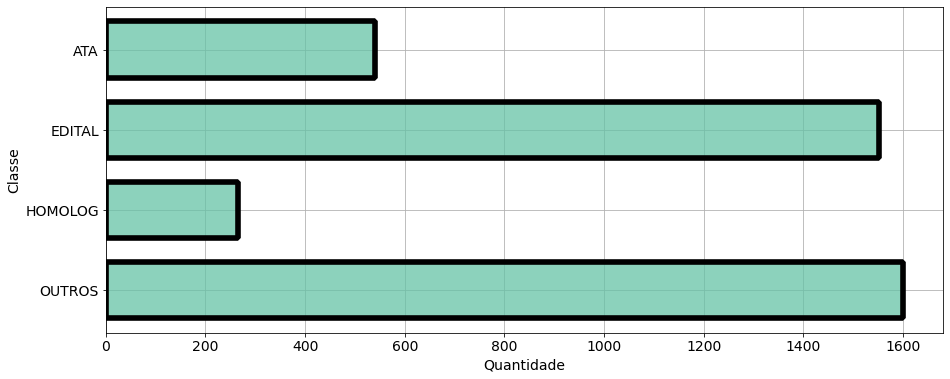

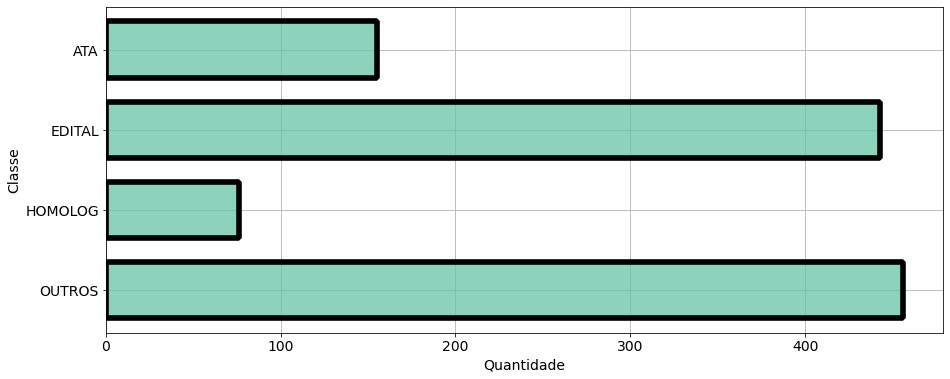

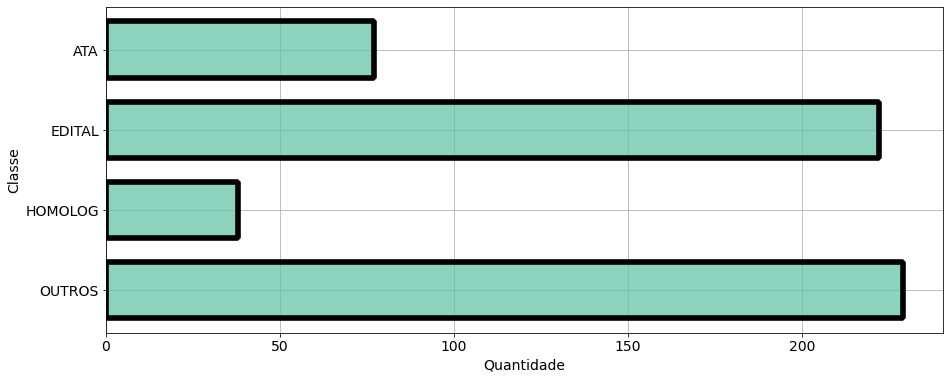

'print("Diferença entre: treino e validação: ", list(set(df_train["final_meta-class"]) - set(df_val["final_meta-class"])))\nprint("Diferença entre treino e teste: ", list(set(df_train["final_meta-class"]) - set(df_test["final_meta-class"])))\nprint("Diferença entre validação e teste: ", list(set(df_val["final_meta-class"]) - set(df_test["final_meta-class"])))'

In [22]:
all_documents = read_data()

df_input = pd.read_csv(path_classes_doc) 

# Associação do conteúdo dos docs com o dataframe com as classes

df_data = pd.merge(left=df_input, right=all_documents, on='doc_id')






df_train, df_val, df_test, y_train, y_val, y_test = split_stratified_into_train_val_test(df_data, stratify_colname='final_meta-class',
                                         frac_train=0.7, frac_val=0.2, frac_test=0.1,
                                         random_state=42)


#Undersampling em edital
'''frames = [df_train.loc[df_train['final_meta-class'] == "EDITAL"].head(600), df_train.loc[df_train['final_meta-class'] != "EDITAL"]]
df_train = pd.concat(frames)

frames_label = [y_train.loc[y_train['final_meta-class'] == "EDITAL"].head(600), y_train.loc[y_train['final_meta-class'] != "EDITAL"]]
y_train = pd.concat(frames_label)
print("TRAINdf", df_train)
print("TRAIN",y_train)'''

verificar_distribuicao_classes(df_train.sort_values(by=['final_meta-class']), "treino") #70%
verificar_distribuicao_classes(df_val.sort_values(by=['final_meta-class']), "validacao") #20%
verificar_distribuicao_classes(df_test.sort_values(by=['final_meta-class']), "teste") #10%

#print(set(df_train["label"]).intersection(df_val["label"]))
'''print("Diferença entre: treino e validação: ", list(set(df_train["final_meta-class"]) - set(df_val["final_meta-class"])))
print("Diferença entre treino e teste: ", list(set(df_train["final_meta-class"]) - set(df_test["final_meta-class"])))
print("Diferença entre validação e teste: ", list(set(df_val["final_meta-class"]) - set(df_test["final_meta-class"])))'''

In [23]:
display(df_train.head)

display(y_train.head)

#print(all_documents[:3])




<bound method NDFrame.head of                                 doc_id final_meta-class                label  \
4496  cad98d60b59929099e8dcd304518523a           OUTROS               outros   
3659  70e142c5b1964cfbf203a78dfa8ef217           OUTROS                aviso   
4182  028b47986f9c51ad6b669ab7d581a395           OUTROS             contrato   
4400  f18c65bb7a36857b55db88ab8e1fe566           OUTROS             contrato   
554   8336f956d75b5e87b7c58284b4a9fbc6              ATA  ata registro precos   
...                                ...              ...                  ...   
4298  fe14f995e918a321d86c2e47b4defa53           OUTROS             contrato   
3941  240e488718bf5222ecea77f3446f9ddd           OUTROS             contrato   
2749  35a36eb8a4ecc9063610873a78581b07           EDITAL               edital   
2003  3b00559a2a9f13a697463bacc58a3ce1           EDITAL               edital   
3837  5354b7bc2160801b43d2b39ba4c45ef5           OUTROS                aviso   

         

<bound method NDFrame.head of      final_meta-class
4496           OUTROS
3659           OUTROS
4182           OUTROS
4400           OUTROS
554               ATA
...               ...
4298           OUTROS
3941           OUTROS
2749           EDITAL
2003           EDITAL
3837           OUTROS

[3957 rows x 1 columns]>

# Filtrar termos por IDF

In [24]:


def filter_data(document_text):
    document_text = document_text.split(" ")
    document_text = [term for term in document_text if term in idf_terms_to_keep]        
    return " ".join(document_text)


vectorizer = TfidfVectorizer()
# Calcula tfidf
vectorizer.fit(df_train['four_pages'].values)
# extrai idf
idf_values = vectorizer.idf_
idf_terms = vectorizer.get_feature_names()
# define termos a serem filtrados
index_idf_to_keep = np.nonzero(idf_values < 8)[0].tolist()
idf_values_to_keep = [idf_values[i] for i in index_idf_to_keep]
idf_terms_to_keep = [idf_terms[i] for i in index_idf_to_keep]

# Filtra termos
p = mp.Pool(mp.cpu_count()) # Data parallelism Object
t3 = time.time()
df_train['four_pages_processed'] = p.map(filter_data, df_train['four_pages'])
t4 = time.time()
print("time consuming after Parallel Processing to process the Dataset {0:.2f}s".format(round(t4-t3, 2)))
# Armazena base processada
#df_train.to_csv("lstm_data/preprocessed_data_v2.csv", index=False)






time consuming after Parallel Processing to process the Dataset 29.53s


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:

#print(df_val.head())
print(df_train.shape)

print(y_train.shape)

#print(len(list_itens))
#print(list_itens[:4])

(3957, 10)
(3957, 1)


In [26]:
list_itens_clean = [item.split(" ") for item in list_itens] 

list_itens_clean = list(itertools.chain(*list_itens_clean))

#Remove itens duplicados
final_list_itens = list(dict.fromkeys(list_itens_clean))

print(len(final_list_itens))

2009328


In [27]:
##OLD VERSION
'''def compute_corpus(df):
    corpus_doc = []
    for doc in tqdm(df["four_pages_processed"]):
        corpus_aux = [''.join(page) for page in doc[:2]]
        corpus = ' '.join(corpus_aux)

        for stop_word in stop_words:
            corpus = corpus.lower().replace(stop_word, "") 
            
        #Remove itens
        for item in final_list_itens:
            corpus = corpus.lower().replace(item, "")
            
        
        
        corpus_doc.append(limpeza_texto(corpus))
        
    return corpus_doc
    
        

corpus_doc_train = compute_corpus(df_train)
corpus_doc_val = compute_corpus(df_val)
corpus_doc_test = compute_corpus(df_test)'''

'def compute_corpus(df):\n    corpus_doc = []\n    for doc in tqdm(df["four_pages_processed"]):\n        corpus_aux = [\'\'.join(page) for page in doc[:2]]\n        corpus = \' \'.join(corpus_aux)\n\n        for stop_word in stop_words:\n            corpus = corpus.lower().replace(stop_word, "") \n            \n        #Remove itens\n        for item in final_list_itens:\n            corpus = corpus.lower().replace(item, "")\n            \n        \n        \n        corpus_doc.append(limpeza_texto(corpus))\n        \n    return corpus_doc\n    \n        \n\ncorpus_doc_train = compute_corpus(df_train)\ncorpus_doc_val = compute_corpus(df_val)\ncorpus_doc_test = compute_corpus(df_test)'

In [29]:
##Filtra os 1000 primeiros termos de cada documento
#print(corpus_doc_train[:3])

def tokenize(text):
    words = [token for token in word_tokenize(text)]
    words_doc = ' '.join(words[:1000])
    return words_doc

corpus_doc_train_aux = [tokenize(corpus) for corpus in corpus_doc_train]
#print(corpus_doc_train_aux[:3])
corpus_doc_val_aux = [tokenize(corpus) for corpus in corpus_doc_val]
corpus_doc_test_aux = [tokenize(corpus) for corpus in corpus_doc_test]

NameError: name 'corpus_doc_train' is not defined

In [33]:
def tf_idf_data(corpus_doc, folder):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus_doc)
    
    print(">> X")
    #print(X)

    tf_idf_features = vectorizer.get_feature_names()
    
    #print(tf_idf_features)
    
    

    #print(type(tf_idf_features))
    
    ##Verificando palavras na nuvem de palavras

    dense = X.todense()
    lst1 = dense.tolist()

    df = pd.DataFrame(lst1, columns=tf_idf_features)

    df = df.T.sum(axis=1)

    #print(type(df))
    #print(df)

    #Reiniciando o ambiente de imagem
    '''plt.figure(figsize=(15, 6))
    
    wordcloud = WordCloud(background_color="white", max_words=400).generate_from_frequencies(df)

    # remove plot axes
    plt.axis("off")

    plt.imshow(wordcloud)'''


    df_aux = df.to_frame().rename(columns={'term':'tf-idf'}).reset_index()
    
    
    
    #print(X.toarray()[0])
    #print(len(tf_idf_features_filtrado))
    
    df_tfidf = pd.DataFrame(data=X.toarray(), columns=tf_idf_features)
    
    '''if folder == "train":
        tf_idf_features_filtrado = filtrar_idf(corpus_doc, df_aux)
        df_tfidf = df_tfidf.loc[:, df_tfidf.columns.isin(tf_idf_features_filtrado)]'''
    
    print(">> Matrix TF-IDF")
    print(df_tfidf.head())
    print(type(df_tfidf))


    return df_tfidf[sorted(df_tfidf.columns)]
    #return df_tfidf[:1000]

'''print(len(corpus_doc_train_aux))
corpus_doc_train = corpus_doc_train_aux
corpus_doc_val = corpus_doc_val_aux
corpus_doc_test = corpus_doc_test_aux'''
tf_idf_train = tf_idf_data(df_train["four_pages_processed"], "train")
tf_idf_val = tf_idf_data(df_val["four_pages"], "val")
tf_idf_test = tf_idf_data(df_test["four_pages"], "test")


>> X
>> Matrix TF-IDF
    aa  aaa  aaplicacaodaspenalidadescabiveis  aaquisicao  aar  aas  \
0  0.0  0.0                               0.0         0.0  0.0  0.0   
1  0.0  0.0                               0.0         0.0  0.0  0.0   
2  0.0  0.0                               0.0         0.0  0.0  0.0   
3  0.0  0.0                               0.0         0.0  0.0  0.0   
4  0.0  0.0                               0.0         0.0  0.0  0.0   

   aausenciadocredenciadoemqualquermomentodasessaopublica   ab  aba  abacate  \
0                                                0.0       0.0  0.0      0.0   
1                                                0.0       0.0  0.0      0.0   
2                                                0.0       0.0  0.0      0.0   
3                                                0.0       0.0  0.0      0.0   
4                                                0.0       0.0  0.0      0.0   

   ...  zica  zignago  zincado  zinco  ziober  ziper  zoledronico  zon

#TF-IDF 

# Use features and weights found at training stage

In [34]:
#print(tf_idf_train)


tf_idf_val_in_train = tf_idf_val.loc[:, tf_idf_val.columns.isin(tf_idf_train.columns)]

print(tf_idf_val.loc[:, ~tf_idf_val.columns.isin(tf_idf_train.columns)].columns)

tf_idf_train_not_val = tf_idf_train.loc[:, ~tf_idf_train.columns.isin(tf_idf_val.columns)].columns

df_add = pd.DataFrame(np.zeros((tf_idf_val_in_train.shape[0], len(tf_idf_train_not_val))), columns=tf_idf_train_not_val)

tf_idf_val_final = pd.concat([tf_idf_val_in_train,df_add], axis=1)

#tf_idf_val = pd.concat([tf_idf_val_in_train, tf_idf_train_not_val], axis=1)


tf_idf_test_in_train = tf_idf_test.loc[:, tf_idf_test.columns.isin(tf_idf_train.columns)]

print(tf_idf_test.loc[:, ~tf_idf_test.columns.isin(tf_idf_train.columns)].columns)

tf_idf_train_not_test = tf_idf_train.loc[:, ~tf_idf_train.columns.isin(tf_idf_test.columns)].columns

df_add_test = pd.DataFrame(np.zeros((tf_idf_test_in_train.shape[0], len(tf_idf_train_not_test))), columns=tf_idf_train_not_test)

tf_idf_test_final = pd.concat([tf_idf_test_in_train,df_add_test], axis=1)


print(tf_idf_train.shape)
print(tf_idf_val_final.shape)
print(tf_idf_test_final.shape)


#print(y_train)

'''print(tf_idf_features_test)

print("Diferença entre: validação e treino: ", list(set(tf_idf_features_val["index"]) - set(tf_idf_features_train["index"])))
print("Diferença entre teste e treino: ", list(set(tf_idf_features_test["index"]) - set(tf_idf_features_train["index"])))

print(tf_idf_features_val.shape)'''


Index(['abadia', 'abaixoindicados', 'abbott', 'abcfarma', 'aberturas',
       'abilio', 'abotoadores', 'abrasao', 'abrasiva', 'abrasivos',
       ...
       'zm', 'zoeb', 'zolpidem', 'zone', 'zonne', 'zoom', 'zoya', 'zoysia',
       'zumgiram', 'zydus'],
      dtype='object', length=4821)
Index(['aabad', 'aad', 'aaddom', 'aaea', 'aaeca', 'aagi', 'aai', 'aal', 'aalt',
       'aan',
       ...
       'zequinha', 'zerado', 'zeze', 'zhacaa', 'zincada', 'zirico', 'zolpidem',
       'zvais', 'zveanlotor', 'zydus'],
      dtype='object', length=3595)
(3957, 12948)
(1130, 12948)
(566, 12948)


'print(tf_idf_features_test)\n\nprint("Diferença entre: validação e treino: ", list(set(tf_idf_features_val["index"]) - set(tf_idf_features_train["index"])))\nprint("Diferença entre teste e treino: ", list(set(tf_idf_features_test["index"]) - set(tf_idf_features_train["index"])))\n\nprint(tf_idf_features_val.shape)'

# Avaliações

In [35]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [36]:


train_ds = ReviewsDataset(tf_idf_train, y_train.values.ravel())
val_ds = ReviewsDataset(tf_idf_val_final, y_val)
test_ds = ReviewsDataset(tf_idf_test_final, y_test)

print(train_ds)

In [37]:
def confunsion_matrix_chart(y_true_str, y_pred_str, title):

    print("TRUE:",y_true_str["final_meta-class"])
    myset = set(sorted(y_true_str["final_meta-class"]))
    print(myset)
    print("LABELS true:", myset)
    
    myset = set(sorted(y_pred_str))
    print(myset)
    print("LABELS pred:", myset)
    
    df_cm = confusion_matrix(y_true_str["final_meta-class"], y_pred_str, normalize="true", labels=['ATA', 'EDITAL', 'HOMOLOG', 'OUTROS'])#, labels=["Ata", "Edital", "Homologação", "Outros"]

    plt.figure(figsize = (25,25))
    
    cmap = sns.light_palette("#01706E", n_colors=7, as_cmap=True)

    #sns.color_palette("light:b", as_cmap=True)
    sns_plot = sns.heatmap(df_cm, annot=True,  fmt=".3f", annot_kws={"size": 16}, cmap=cmap, xticklabels=['ATA', 'EDITAL', 'HOMOLOG', 'OUTROS'], yticklabels=['ATA', 'EDITAL', 'HOMOLOG', 'OUTROS'])#, xticklabels=["Ata", "Edital", "Homologação", "Outros"], yticklabels=["Ata", "Edital", "Homologação", "Outros"]

    #sns_plot.set(xlabel="Label Predito", ylabel = "Label Verdadeiro")
    
    sns_plot.set_xlabel("Label Predito",fontsize=15)
    sns_plot.set_ylabel("Label Verdadeiro",fontsize=15)

    sns_plot = sns_plot.get_figure()
    
    plt.xticks(size=15)
    plt.yticks(size=15)

    sns_plot.savefig(path_res+title+".png", dpi=150)

In [38]:
def evaluation_models(y_true, y_pred, folder):
    
    print(">> EVALUATION TRUE: ", y_true)
    print("F1_score macro "+ folder+":", f1_score(y_true, y_pred, average='macro'))
    print("F1_score weighted "+ folder+":", f1_score(y_true, y_pred, average='weighted'))
    
    confunsion_matrix_chart(y_true, y_pred, folder)
    

# Classificação com o modelo Naive Bayes 

In [39]:
#3 Feature selection techniques

#Feature selection 
#selector = SelectPercentile(f_classif, percentile=10)
#Univariate Selection
selector = SelectPercentile(chi2, percentile=20)
selector.fit(tf_idf_train, y_train.values.ravel())

features_train = selector.transform(tf_idf_train)#.toarray()
print(features_train.shape)
features_val = selector.transform(tf_idf_val_final)#.toarray()
features_test = selector.transform(tf_idf_test_final)#.toarray()

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)#1412
selector = bestfeatures.fit(tf_idf_train, y_train.values.ravel())

features_train_KBest = selector.transform(tf_idf_train)#.toarray()
print(features_train.shape)
features_val_KBest = selector.transform(tf_idf_val_final)#.toarray()
features_test_KBest = selector.transform(tf_idf_test_final)

dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(tf_idf_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print best features


#Feature importance
model = ExtraTreesClassifier()
model.fit(tf_idf_train, y_train.values.ravel())
print(model.feature_importances_)


(3957, 2590)
(3957, 2590)
                Specs       Score
3807    determinacoes  205.282262
9664              prc  197.412927
3192   credenciamento  183.444163
6234      homologacao  176.706335
4677        envelopes  169.494433
7362        licitante  166.068550
10013        proposta  164.987810
8293              nao  159.063778
8029            minas  145.369323
713             anexo  144.703578
6097      habilitacao  143.288787
3169              cpl  135.438709
4287           edital  130.530767
1099              ata  129.987799
12819             vlr  129.094542
[2.36239515e-05 2.80831049e-05 1.36459092e-04 ... 8.70254978e-06
 0.00000000e+00 0.00000000e+00]



 >> MultinomialNB - Sem feature selection

Train set score:  0.9244377053323225

Validation set score:  0.12831858407079647

Test set score:  0.14664310954063603

>> Avaliações - MultinomialNB
>> EVALUATION TRUE:       final_meta-class
4496           OUTROS
3659           OUTROS
4182           OUTROS
4400           OUTROS
554               ATA
...               ...
4298           OUTROS
3941           OUTROS
2749           EDITAL
2003           EDITAL
3837           OUTROS

[3957 rows x 1 columns]
F1_score macro treino - MultinomialNB: 0.8782780789716631
F1_score weighted treino - MultinomialNB: 0.9217902591613577
TRUE: 4496    OUTROS
3659    OUTROS
4182    OUTROS
4400    OUTROS
554        ATA
         ...  
4298    OUTROS
3941    OUTROS
2749    EDITAL
2003    EDITAL
3837    OUTROS
Name: final_meta-class, Length: 3957, dtype: object
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS true: {'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS pred: {'HOMOLOG',

>> EVALUATION TRUE:       final_meta-class
4496           OUTROS
3659           OUTROS
4182           OUTROS
4400           OUTROS
554               ATA
...               ...
4298           OUTROS
3941           OUTROS
2749           EDITAL
2003           EDITAL
3837           OUTROS

[3957 rows x 1 columns]
F1_score macro treino - GaussianNB: 0.9318452354283906
F1_score weighted treino - GaussianNB: 0.9504627562351956
TRUE: 4496    OUTROS
3659    OUTROS
4182    OUTROS
4400    OUTROS
554        ATA
         ...  
4298    OUTROS
3941    OUTROS
2749    EDITAL
2003    EDITAL
3837    OUTROS
Name: final_meta-class, Length: 3957, dtype: object
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS true: {'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS pred: {'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
>> EVALUATION TRUE:       final_meta-class
2265           EDITAL
1253           EDITAL
2533           EDITAL
5150           OUTROS
919            EDITAL
...               .

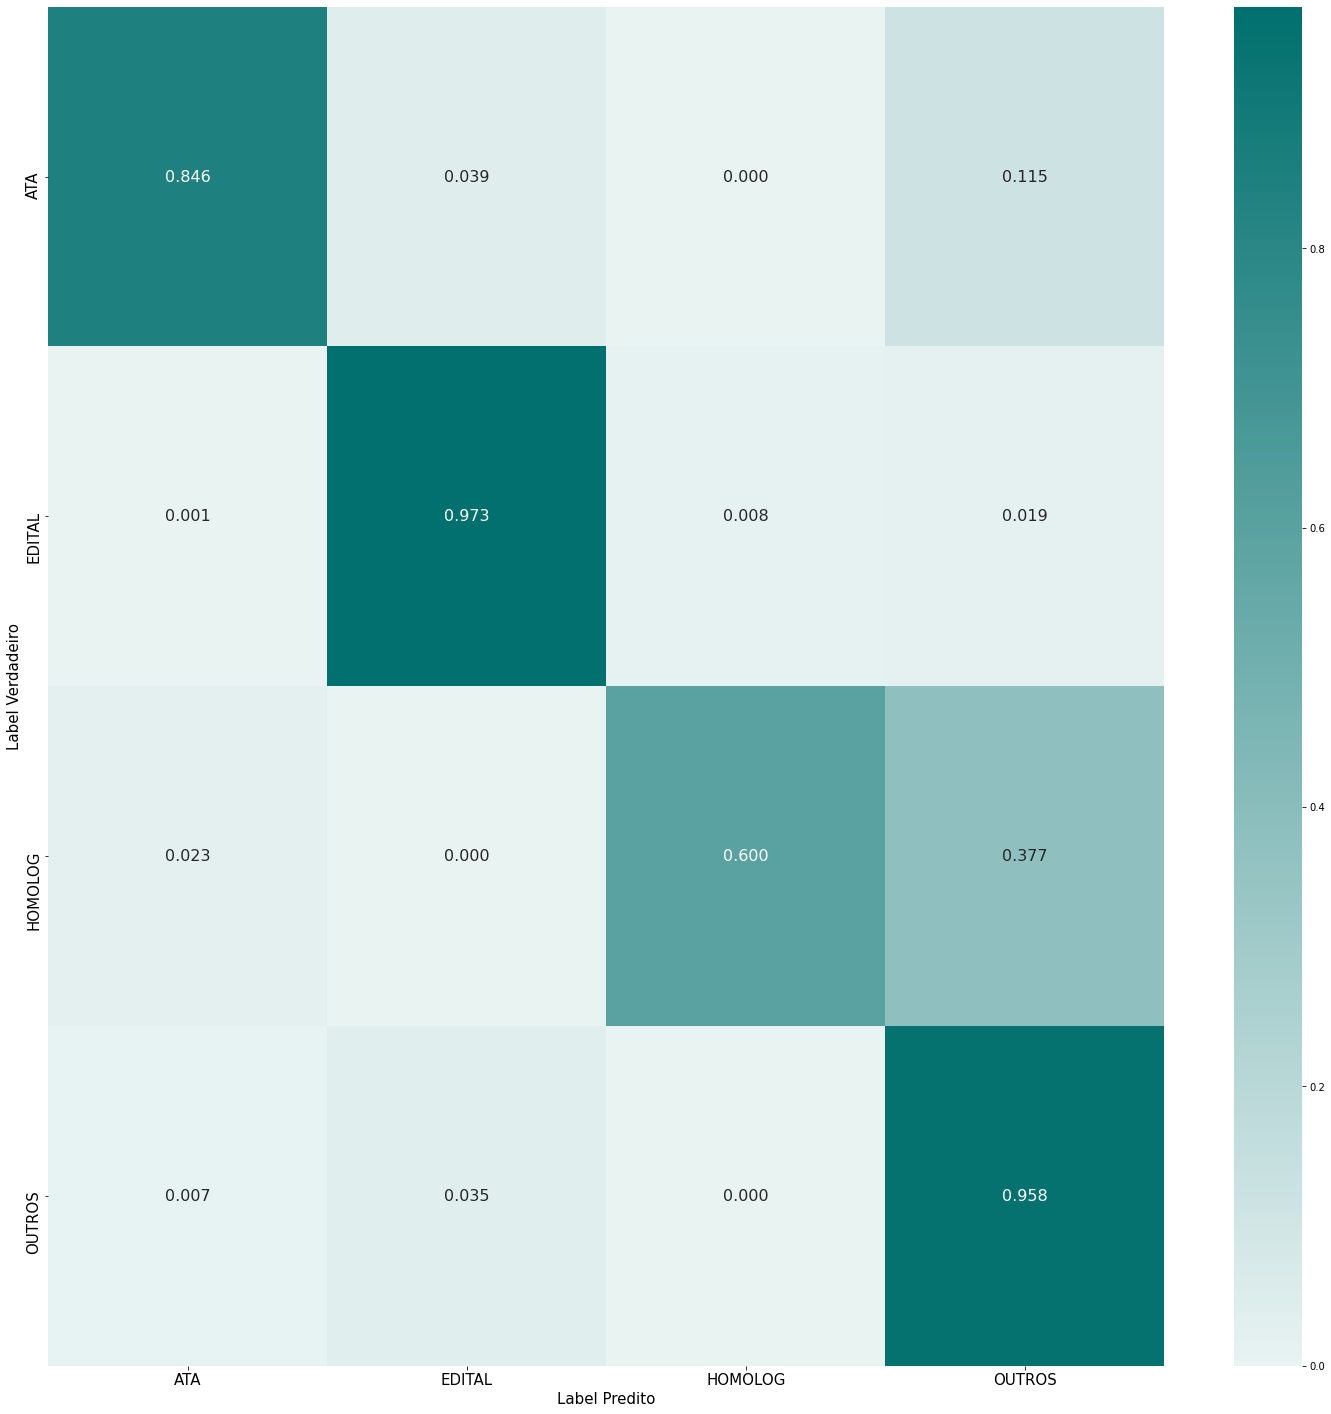

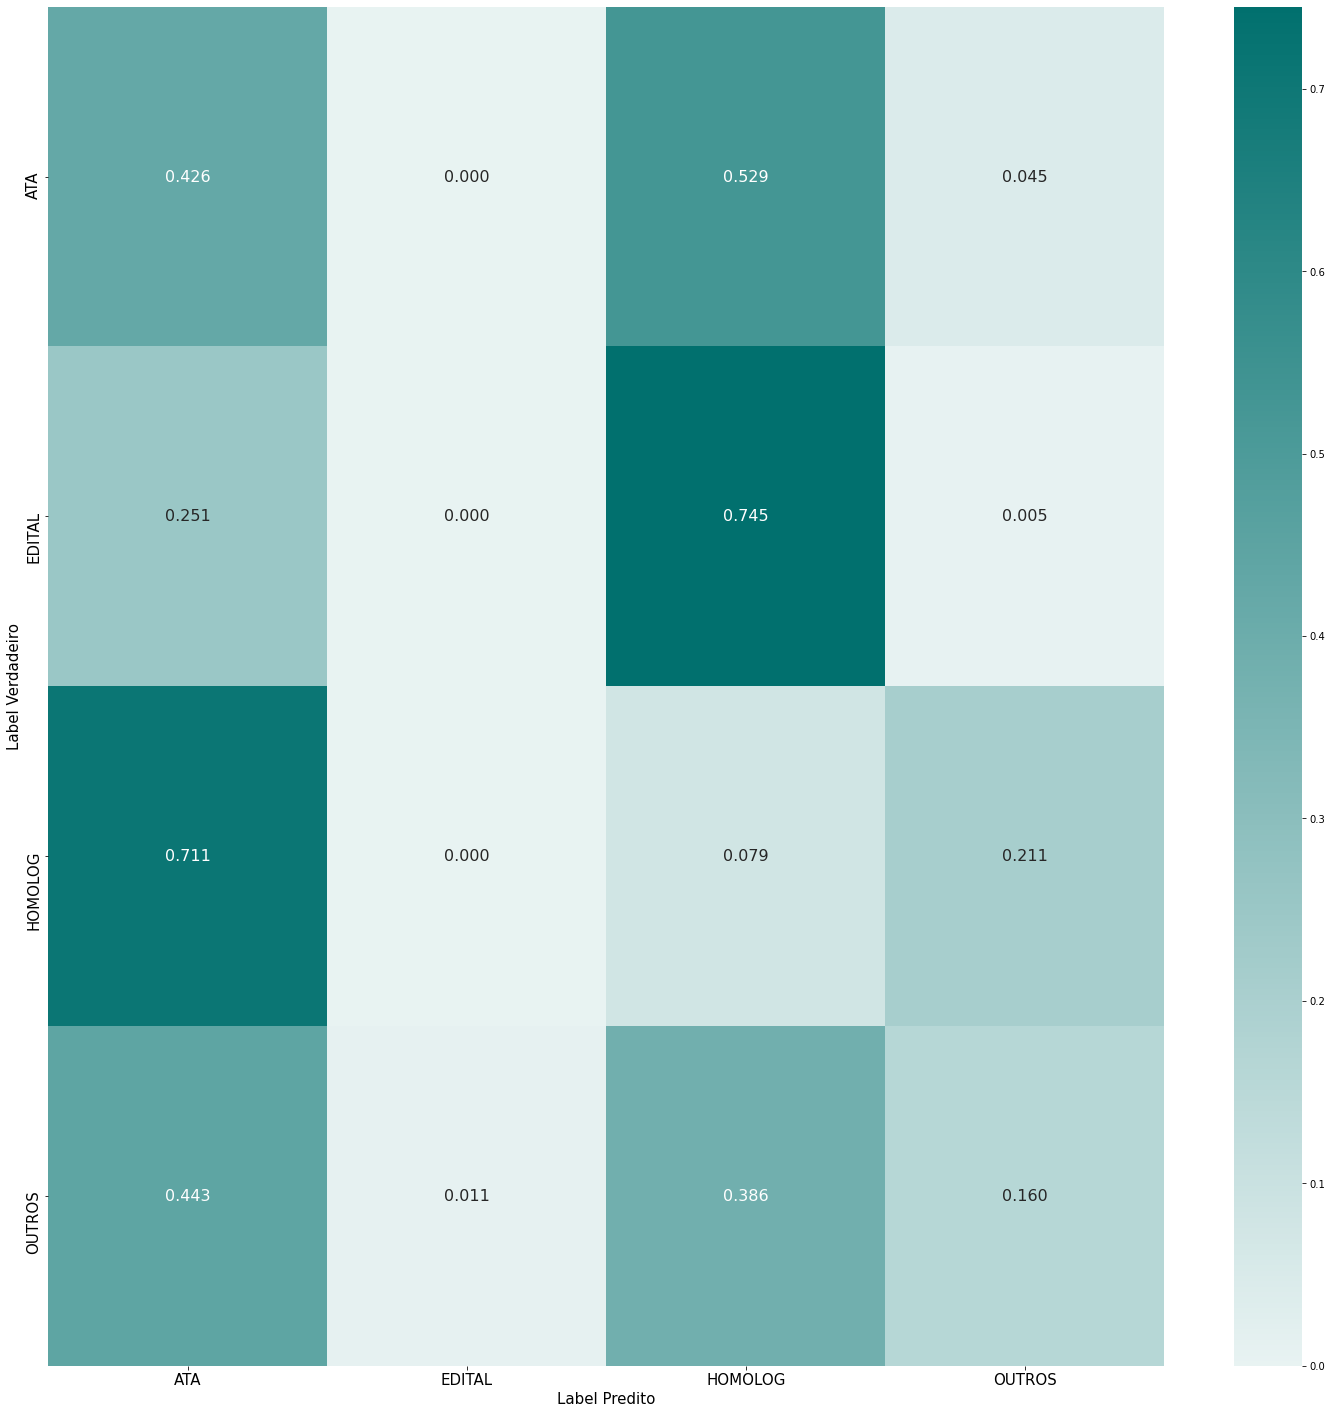

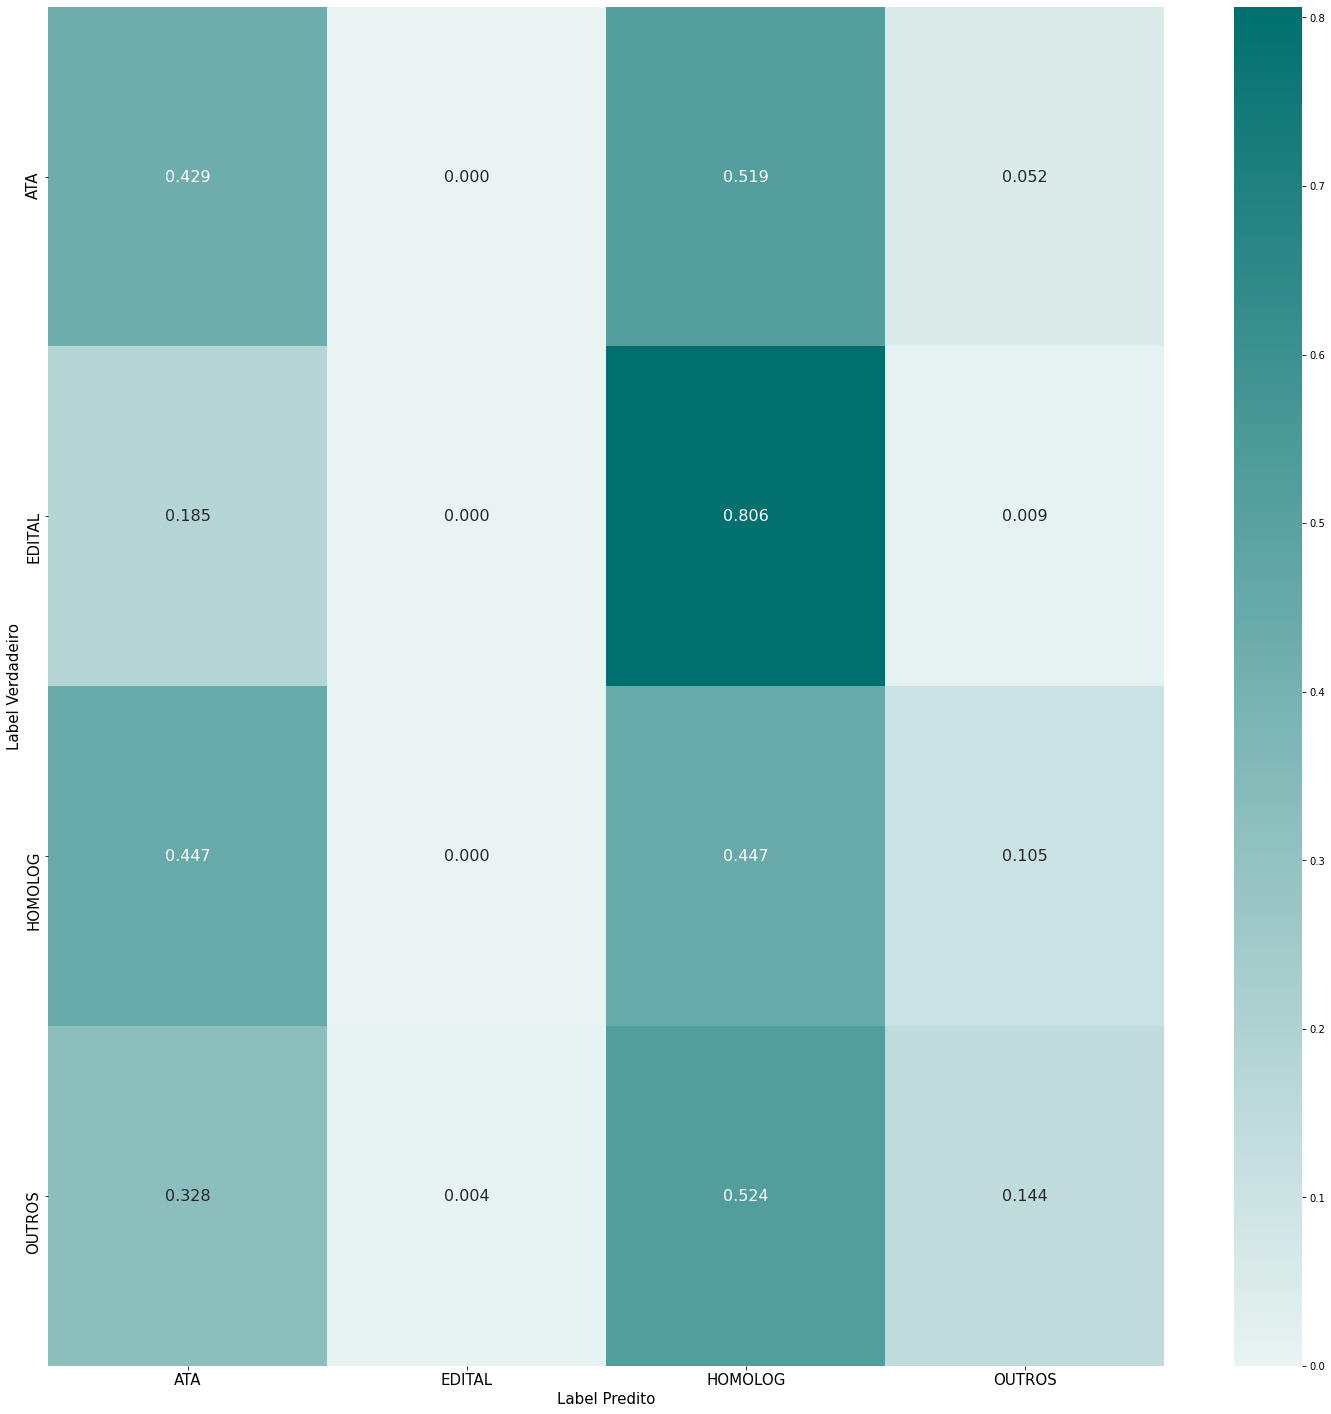

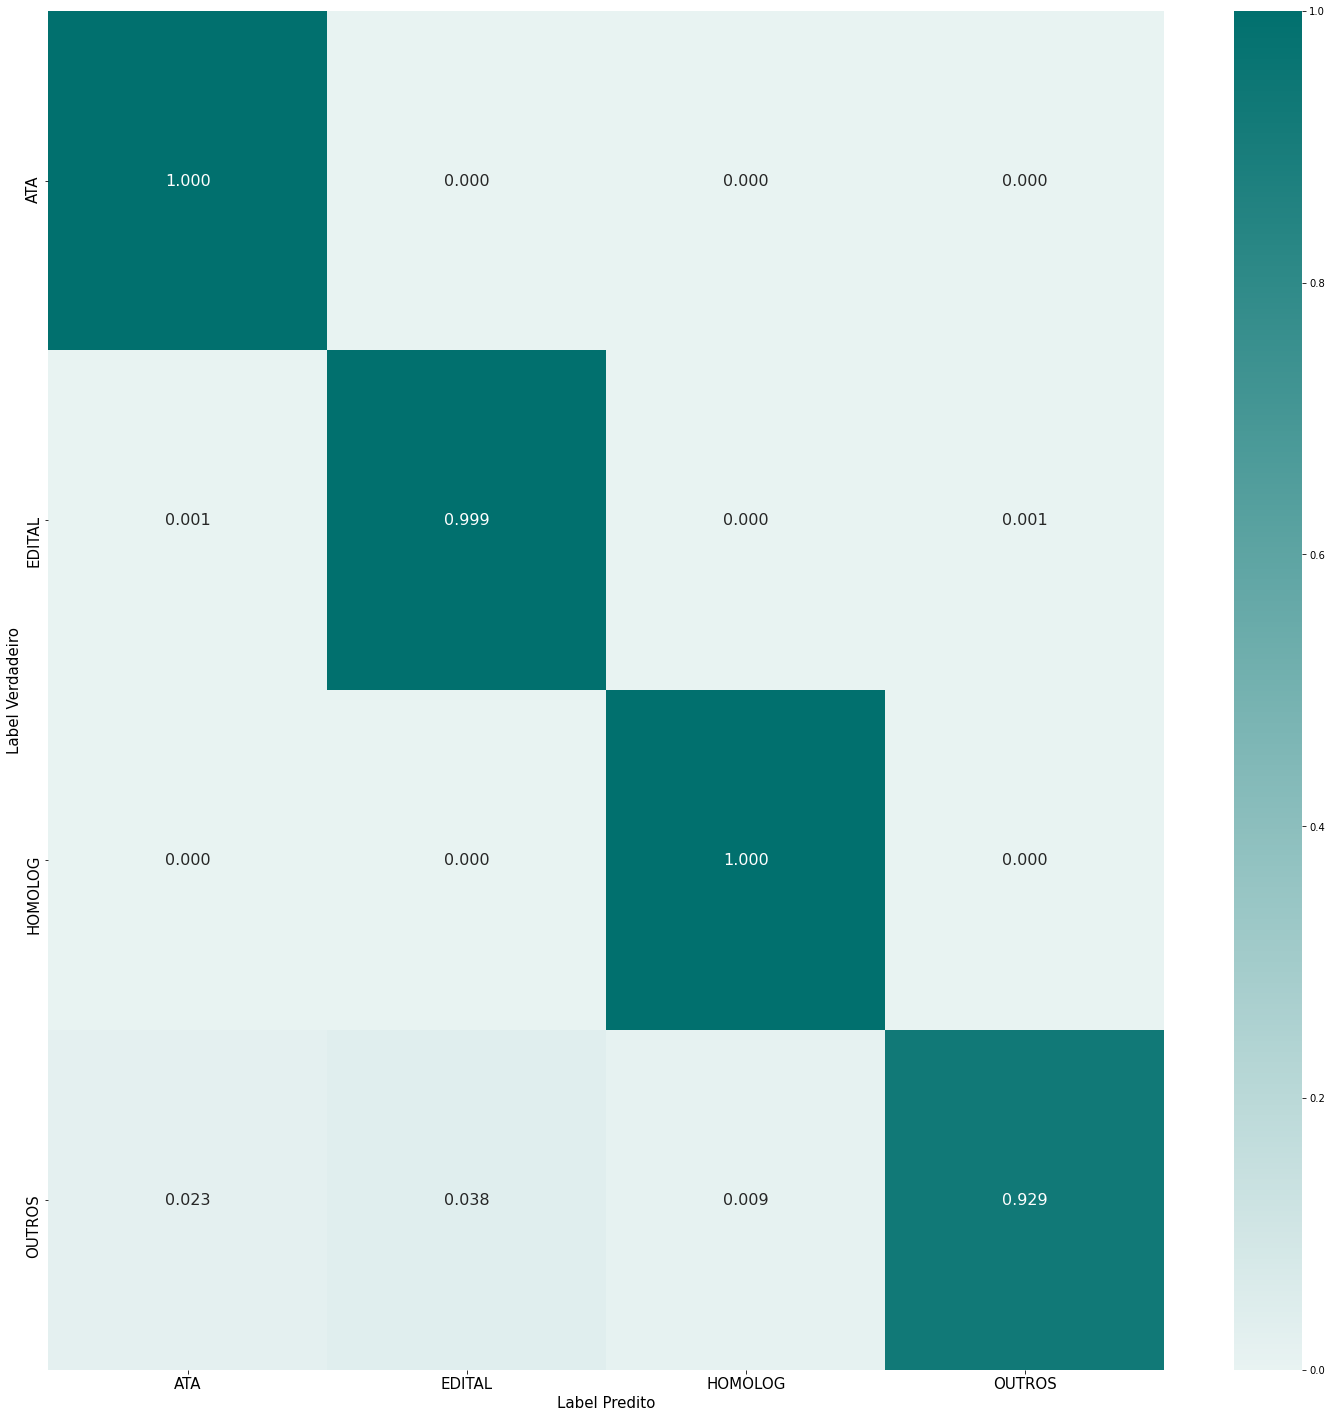

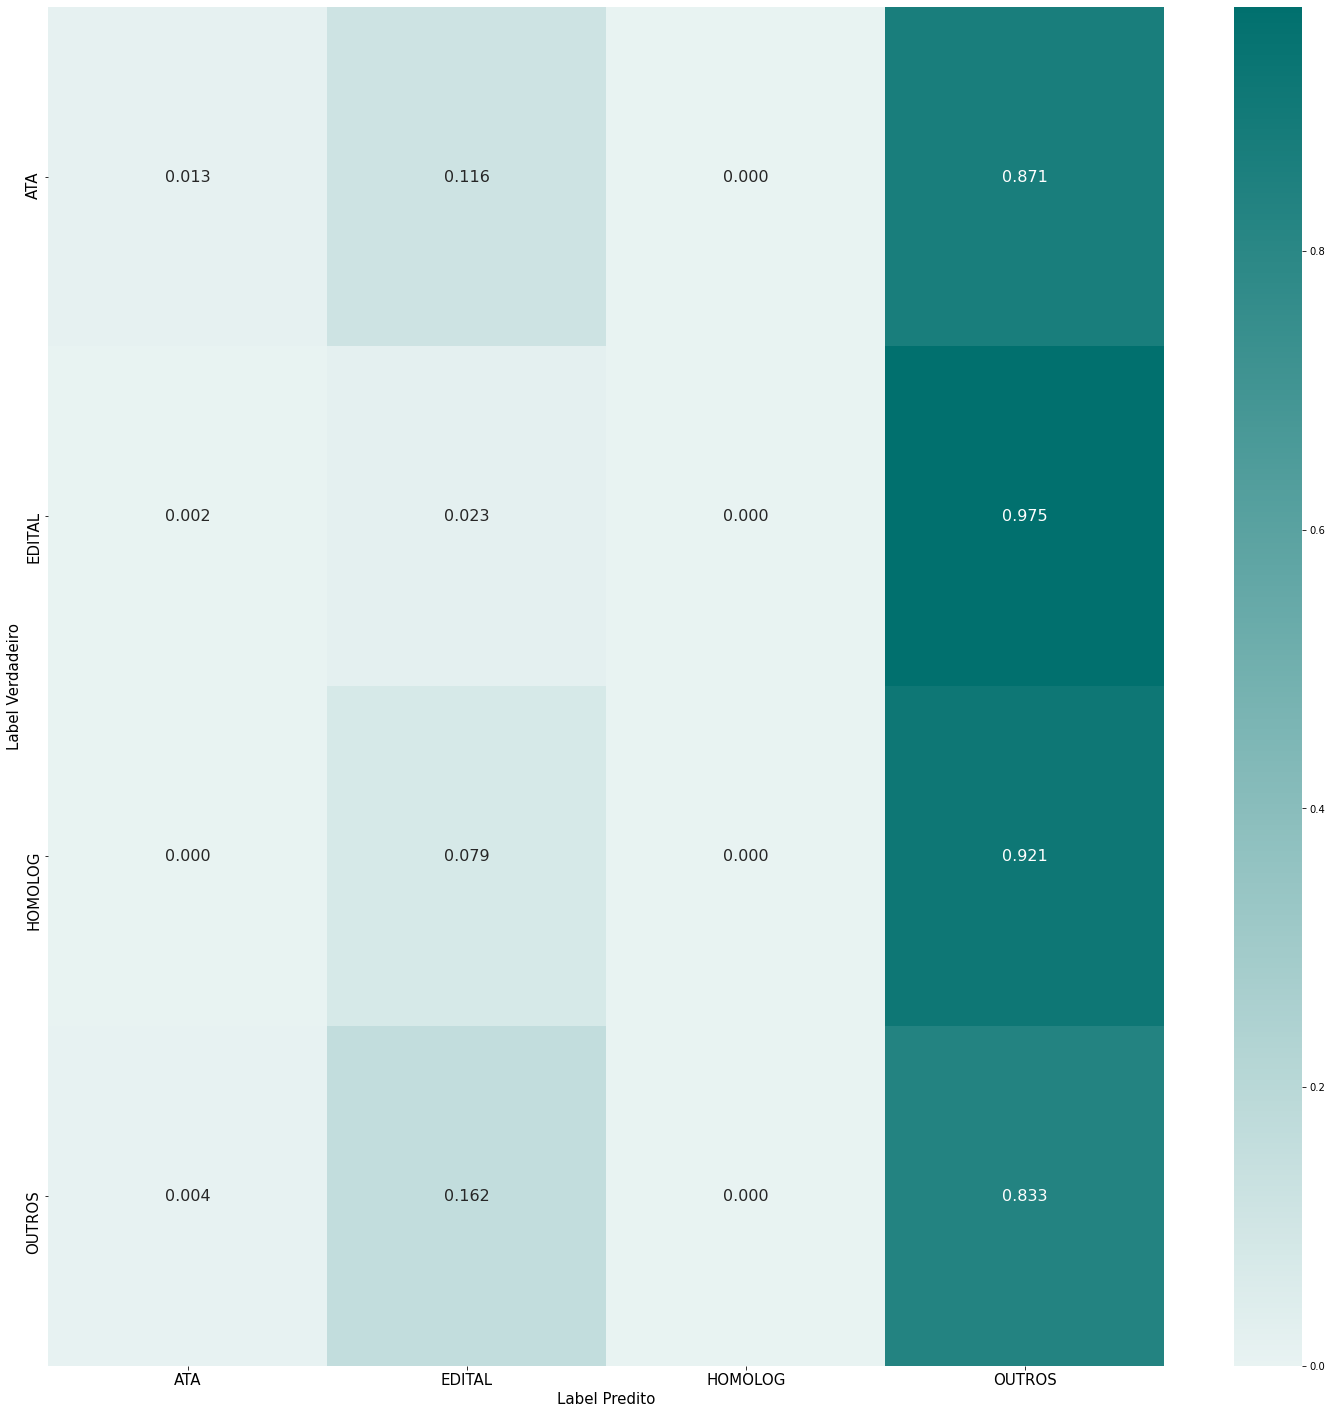

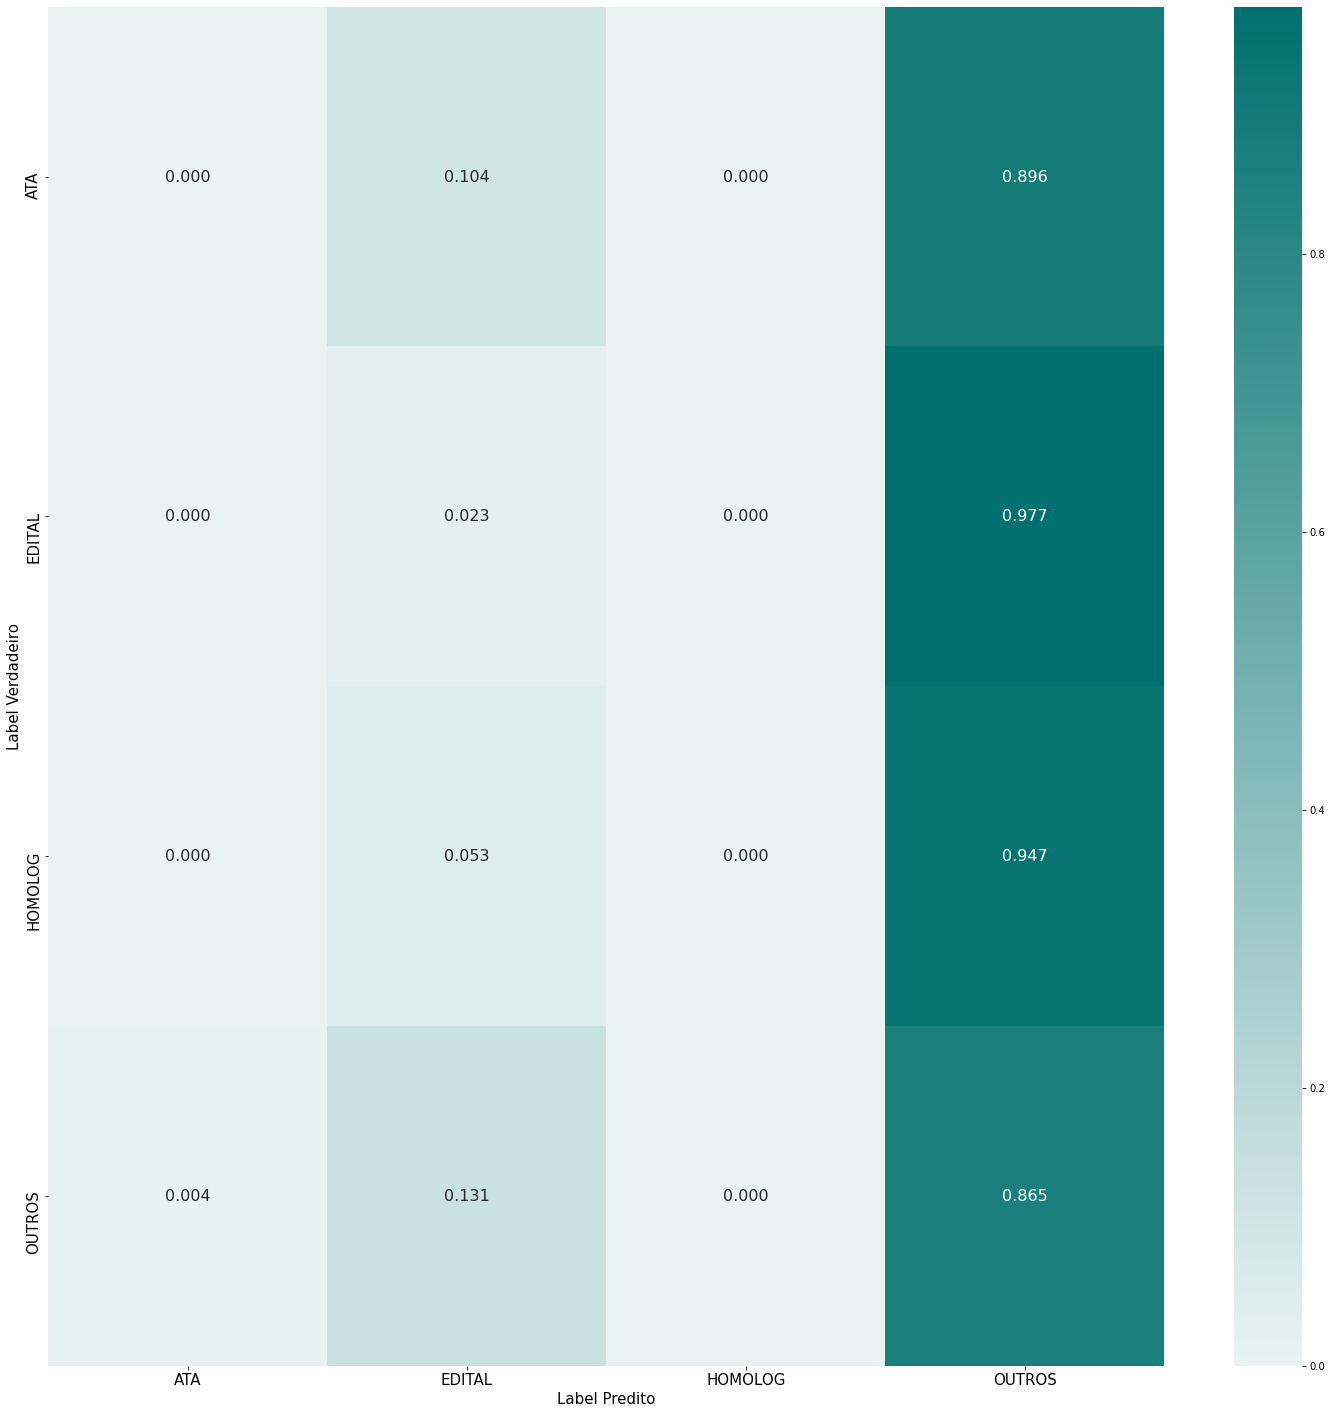

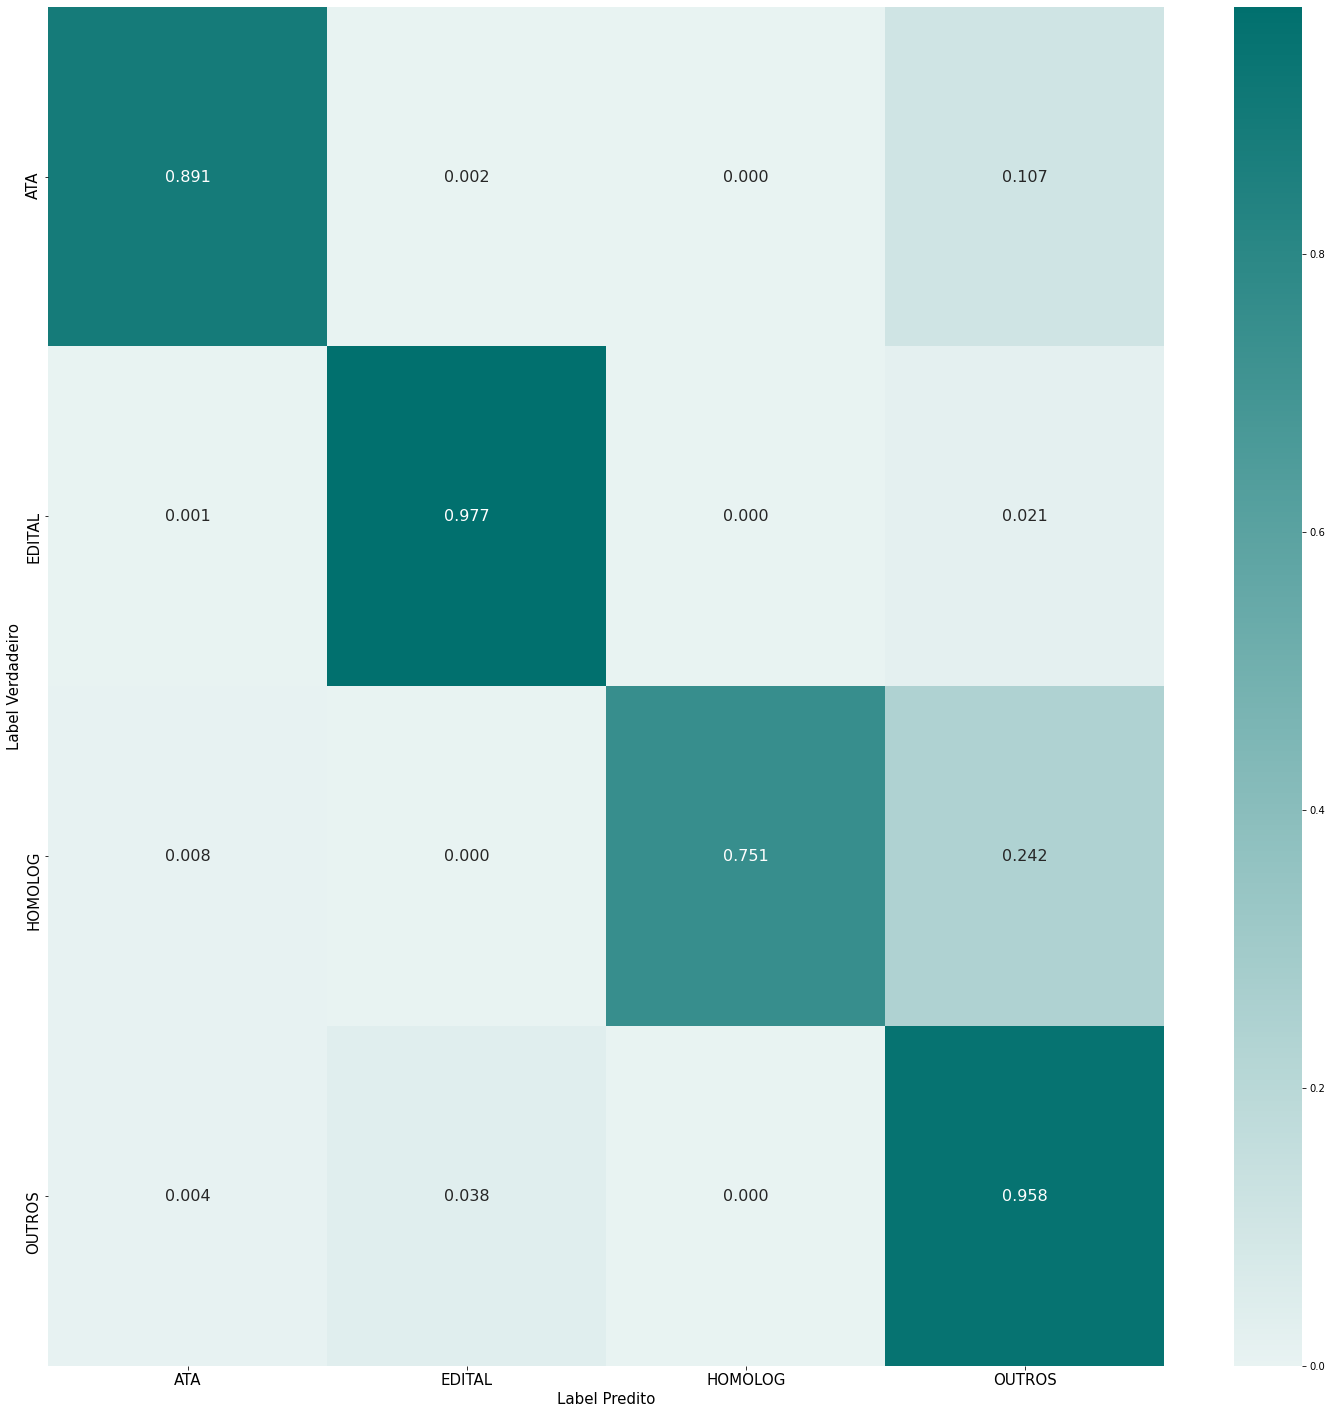

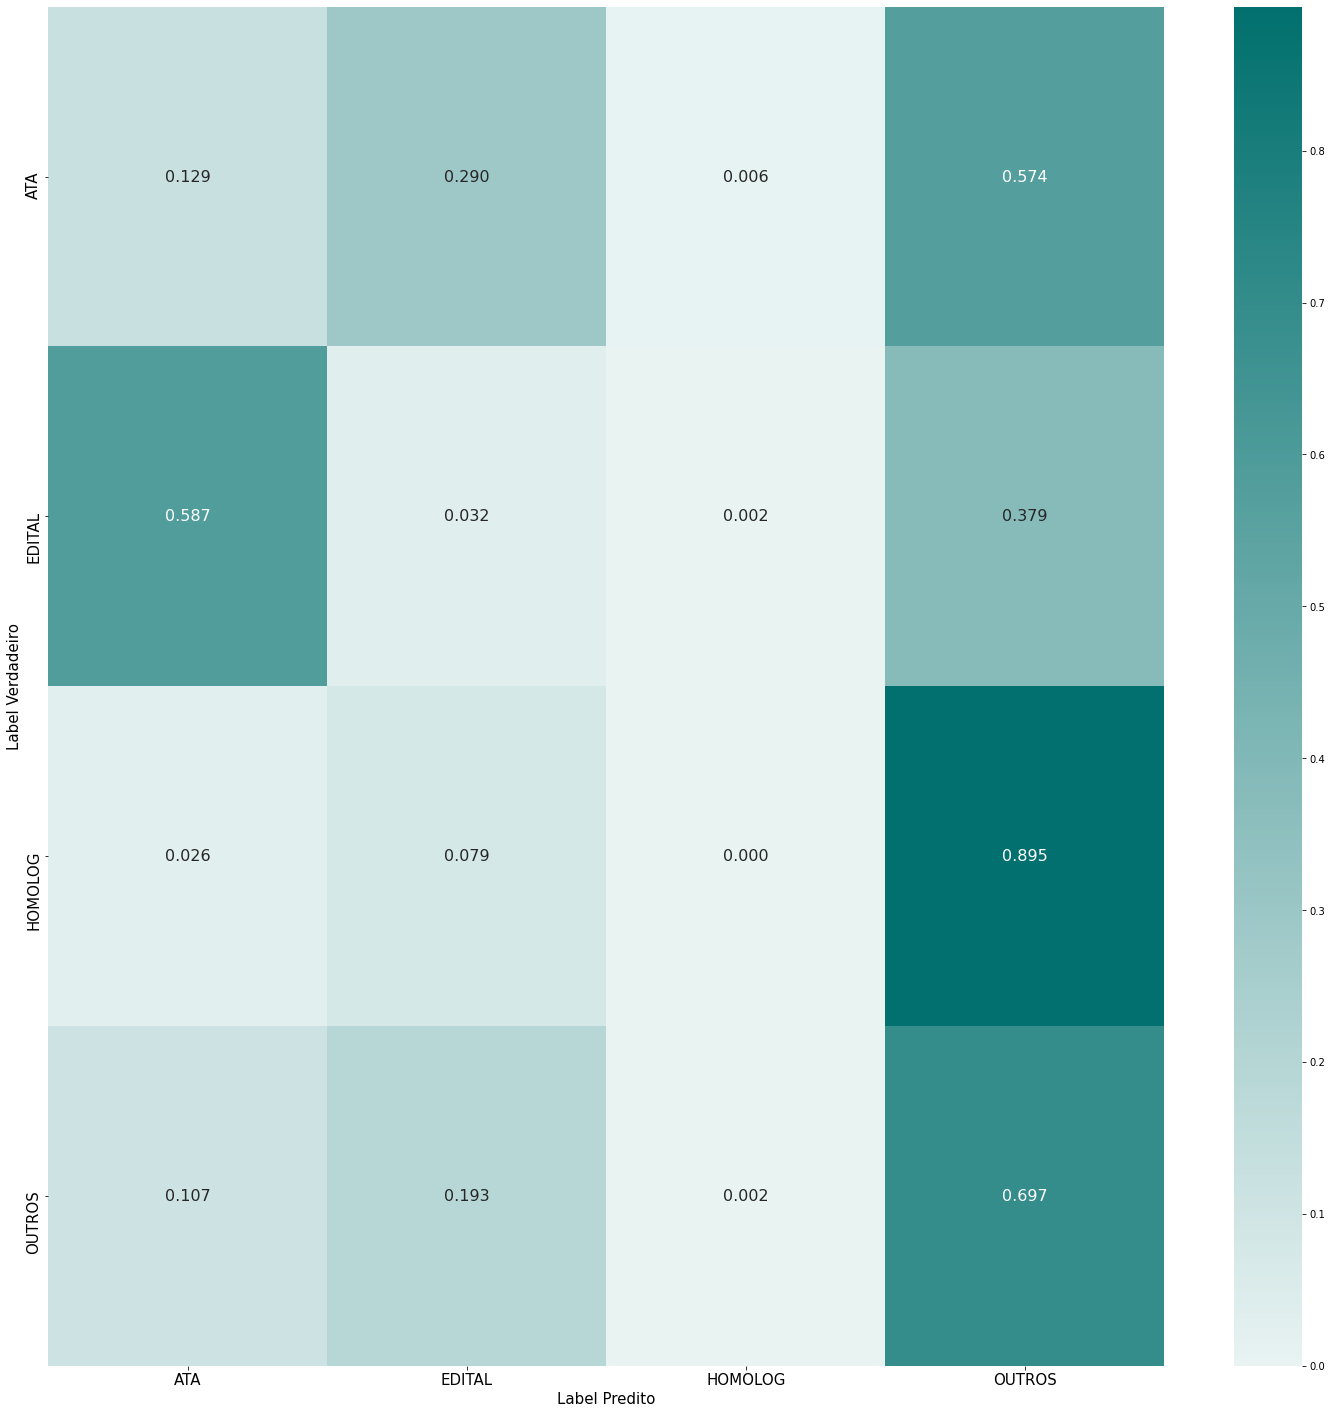

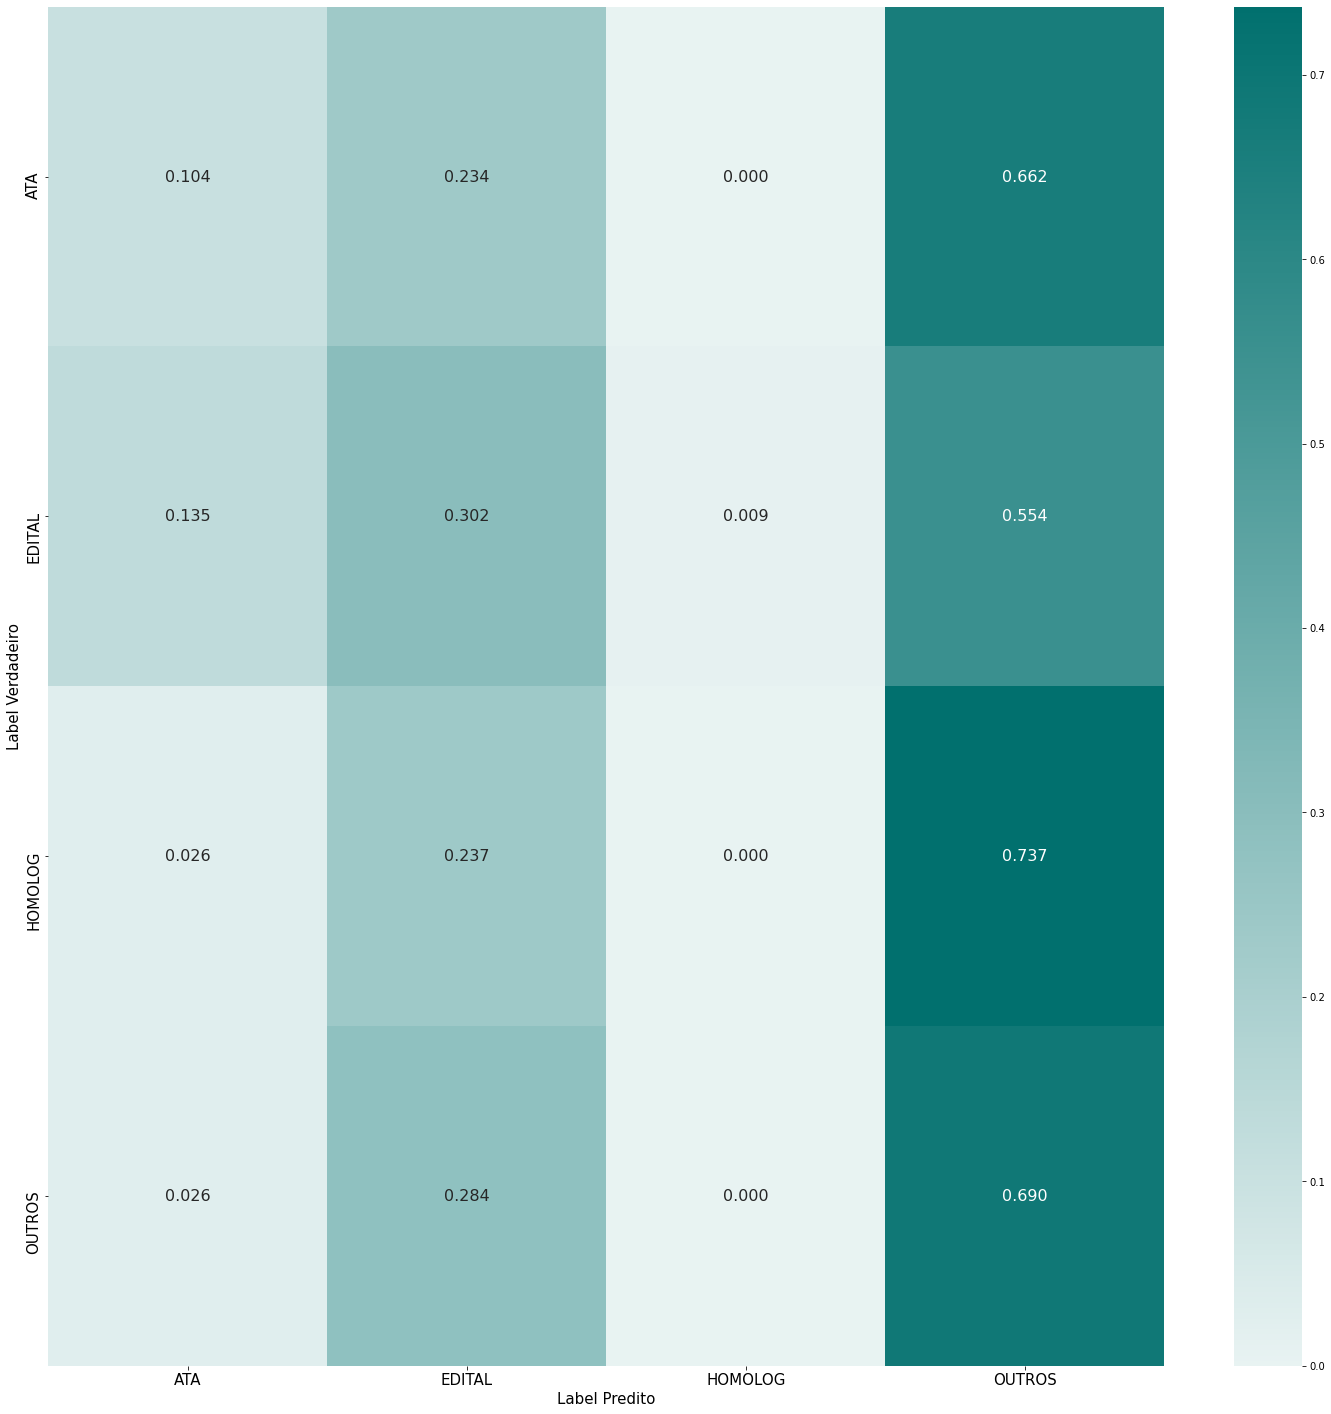

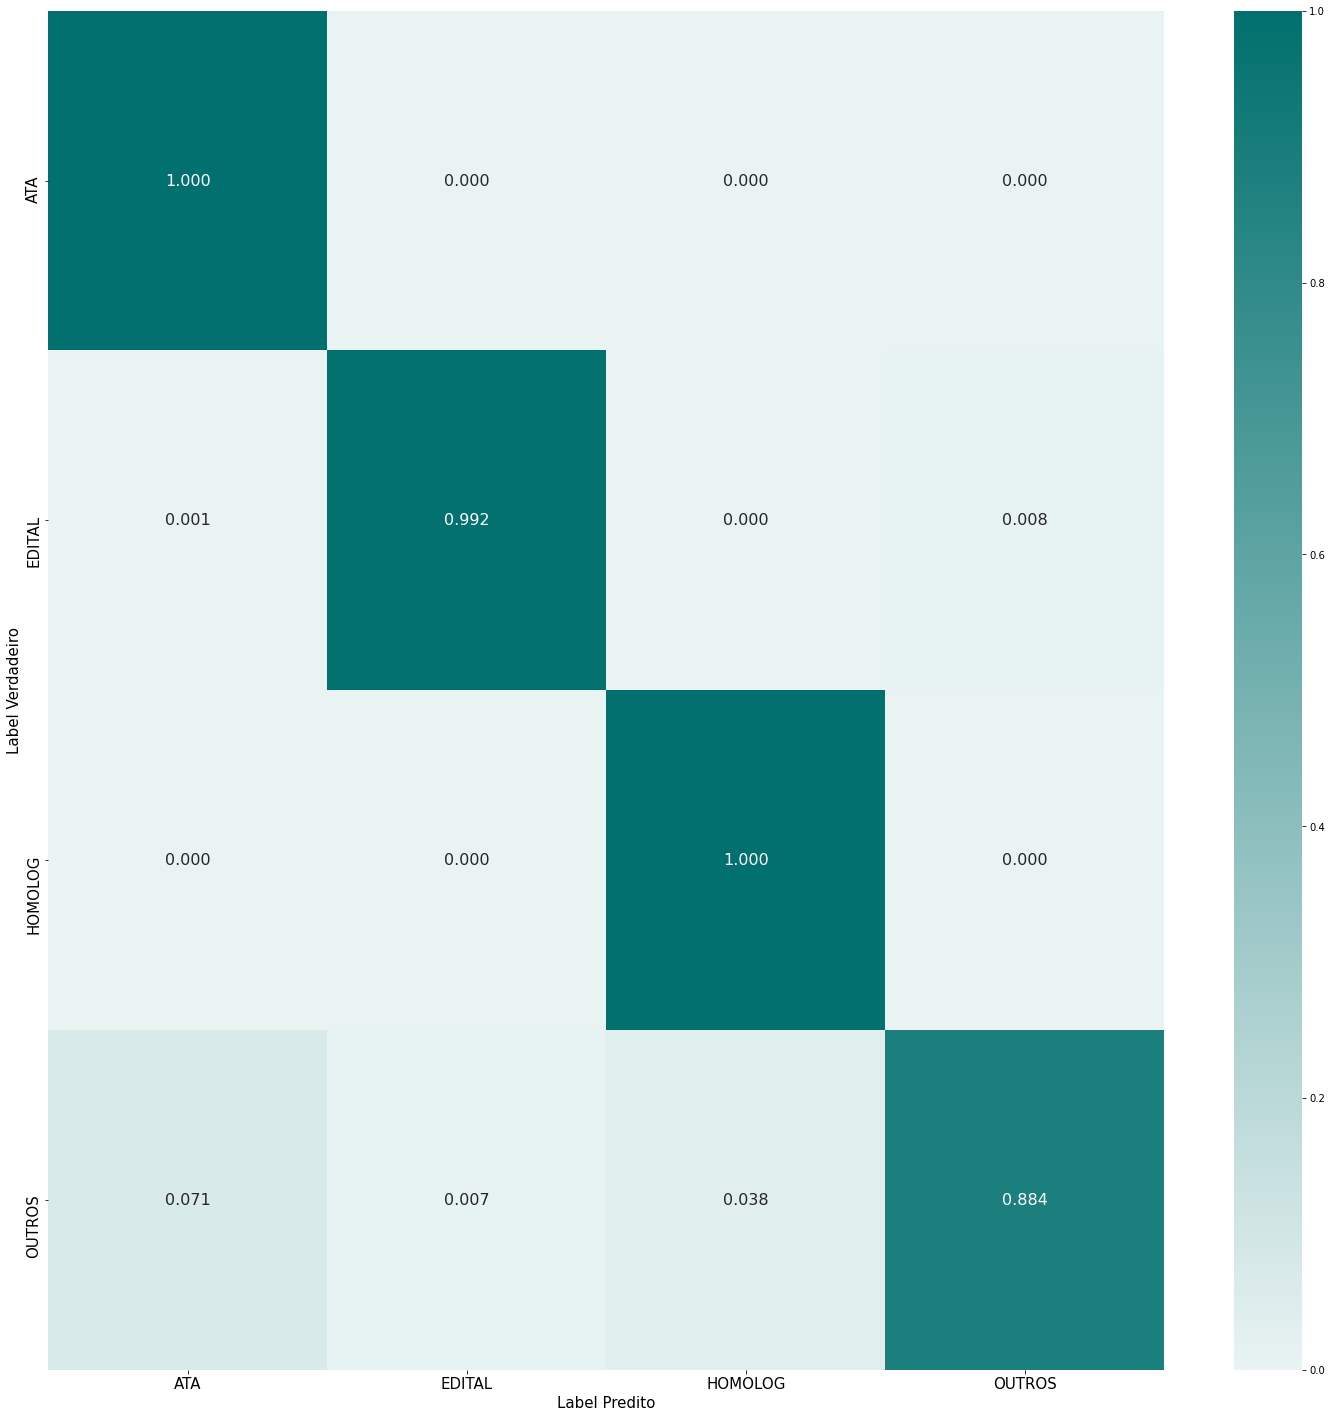

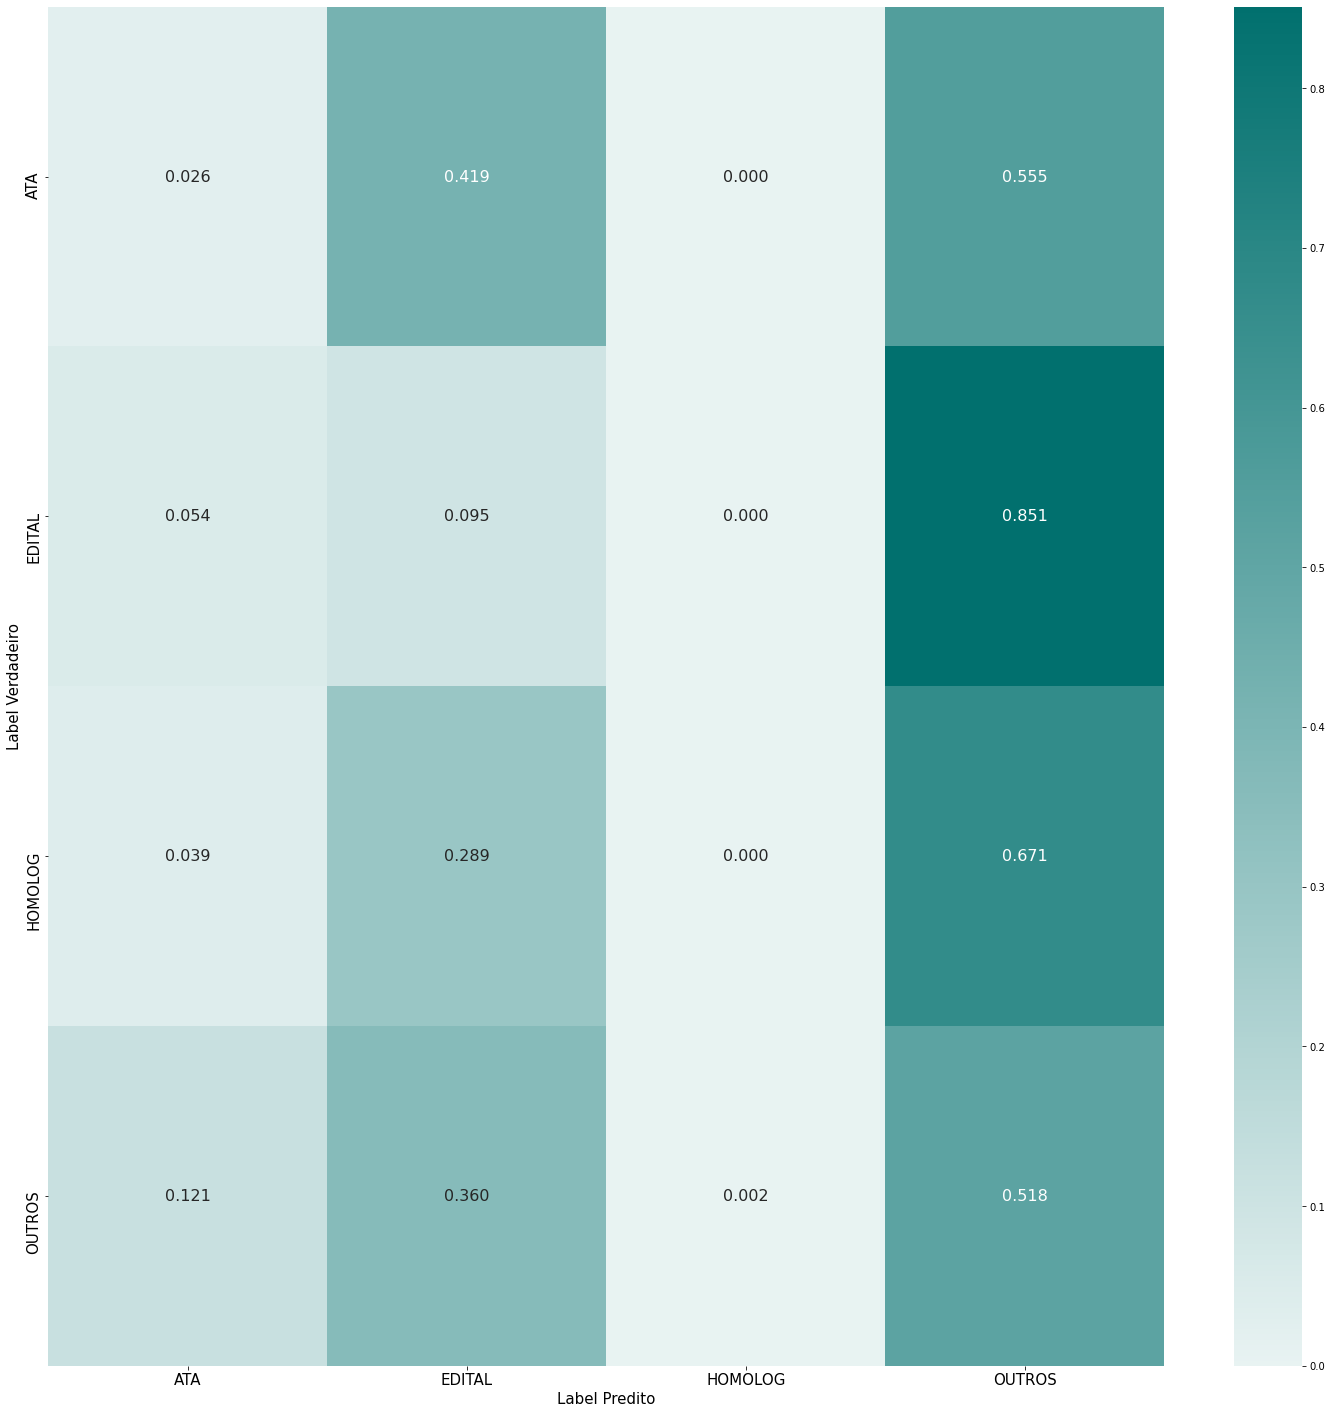

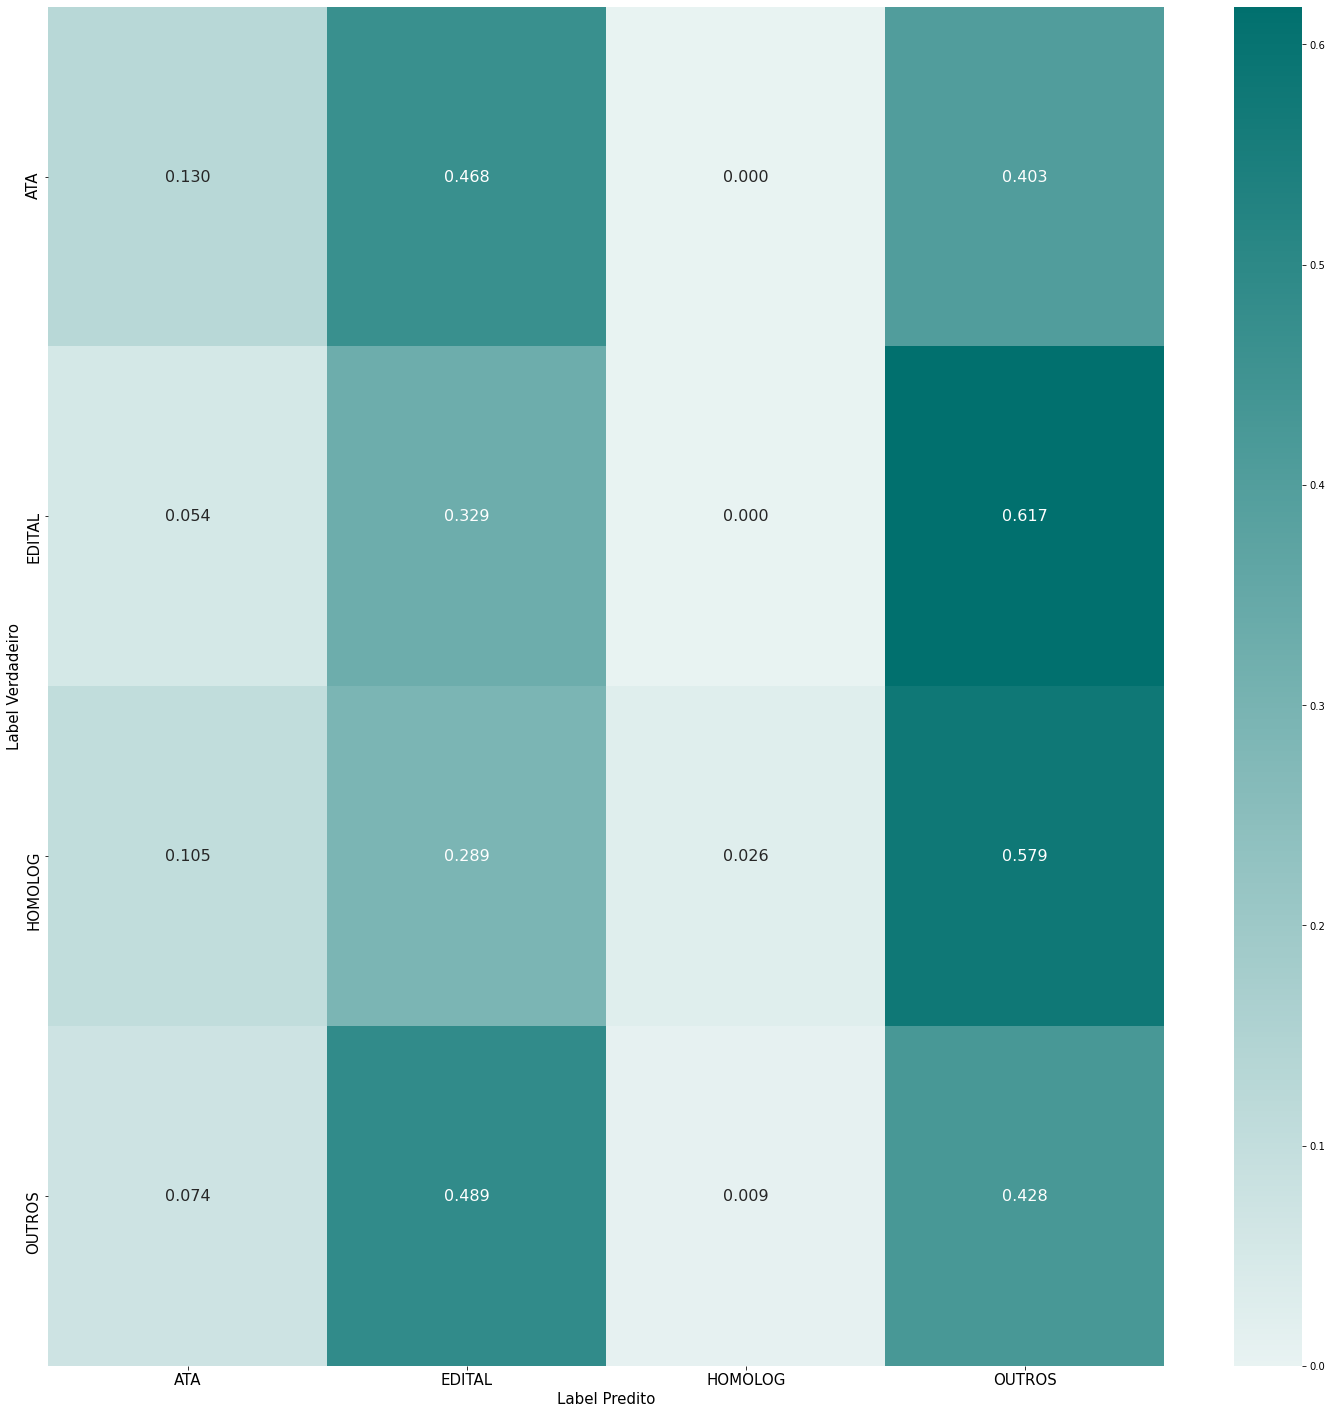

In [40]:

#Sem feature selection
#MultinomialNB
model_MNB = MultinomialNB().fit(tf_idf_train, y_train.values.ravel())

score_train_MNB = model_MNB.score(tf_idf_train, y_train.values.ravel())
print("\n >> MultinomialNB - Sem feature selection")

print("\nTrain set score: ", score_train_MNB)

score_val_MNB = model_MNB.score(tf_idf_val_final, y_val.values.ravel())

print("\nValidation set score: ", score_val_MNB)

score_test_MNB = model_MNB.score(tf_idf_test_final, y_test.values.ravel())

print("\nTest set score: ", score_test_MNB)

#print(y_train.values.ravel())

##### Avaliações

print("\n>> Avaliações - MultinomialNB")

y_pred_train = model_MNB.predict(tf_idf_train)

evaluation_models(y_train, y_pred_train, "treino - MultinomialNB")

y_pred_val = model_MNB.predict(tf_idf_val_final)

evaluation_models(y_val, y_pred_val, "validação - MultinomialNB")

y_pred_test = model_MNB.predict(tf_idf_test_final)

evaluation_models(y_test, y_pred_test, "teste - MultinomialNB")



#f1_measure = 


print("\n >> GaussianNB - Sem feature selection")

#GaussianNB
model_GNB = GaussianNB().fit(tf_idf_train, y_train.values.ravel())

score_train_GNB = model_GNB.score(tf_idf_train, y_train.values.ravel())

print("\nTrain set score: ", score_train_GNB)

score_val_GNB = model_GNB.score(tf_idf_val_final, y_val.values.ravel())

print("\nValidation set score: ", score_val_GNB)

score_test_GNB = model_GNB.score(tf_idf_test_final, y_test.values.ravel())

print("\nTest set score: ", score_test_GNB)

##### Avaliações

print("\n>> Avaliações - GaussianNB")

y_pred_train = model_GNB.predict(tf_idf_train)

evaluation_models(y_train, y_pred_train, "treino - GaussianNB")

y_pred_val = model_GNB.predict(tf_idf_val_final)

evaluation_models(y_val, y_pred_val, "validação - GaussianNB")

y_pred_test = model_GNB.predict(tf_idf_test_final)

evaluation_models(y_test, y_pred_test, "teste - GaussianNB")



#Com feature selection
#MultinomialNB
model_MNB = MultinomialNB().fit(features_train, y_train.values.ravel())

score_train_MNB = model_MNB.score(features_train, y_train.values.ravel())

print("\n >> MultinomialNB - Com feature selection")


print("\nTrain set score: ", score_train_MNB)

score_val_MNB = model_MNB.score(features_val, y_val.values.ravel())

print("\nValidation set score: ", score_val_MNB)

score_test_MNB = model_MNB.score(features_test, y_test.values.ravel())

print("\nTest set score: ", score_test_MNB)

##### Avaliações

print("\n>> Avaliações - MultinomialNB")

y_pred_train = model_MNB.predict(features_train)

evaluation_models(y_train, y_pred_train, "treino - MultinomialNB")

y_pred_val = model_MNB.predict(features_val)

evaluation_models(y_val, y_pred_val, "validação - MultinomialNB")

y_pred_test = model_MNB.predict(features_test)

evaluation_models(y_test, y_pred_test, "teste - MultinomialNB")

print("\n >> GaussianNB - Com feature selection")

#GaussianNB
model_GNB = GaussianNB().fit(features_train, y_train.values.ravel())

score_train_GNB = model_GNB.score(features_train, y_train.values.ravel())

print("\nTrain set score: ", score_train_GNB)

score_val_GNB = model_GNB.score(features_val, y_val.values.ravel())

print("\nValidation set score: ", score_val_GNB)

score_test_GNB = model_GNB.score(features_test, y_test.values.ravel())

print("\nTest set score: ", score_test_GNB)

##### Avaliações

print("\n>> Avaliações - GaussianNB")

y_pred_train = model_GNB.predict(features_train)

evaluation_models(y_train, y_pred_train, "treino - GaussianNB")

y_pred_val = model_GNB.predict(features_val)

evaluation_models(y_val, y_pred_val, "validação - GaussianNB")

y_pred_test = model_GNB.predict(features_test)

evaluation_models(y_test, y_pred_test, "teste - GaussianNB")



# Random forest


 Random Forest sem feature selection

Train set score:  0.8473591104371999

Validation set score:  0.40353982300884955

Test set score:  0.4045936395759717

>> Avaliações - Random Forest
>> EVALUATION TRUE:       final_meta-class
4496           OUTROS
3659           OUTROS
4182           OUTROS
4400           OUTROS
554               ATA
...               ...
4298           OUTROS
3941           OUTROS
2749           EDITAL
2003           EDITAL
3837           OUTROS

[3957 rows x 1 columns]
F1_score macro treino - Random Forest: 0.638527408474011
F1_score weighted treino - Random Forest: 0.8170255348969435
TRUE: 4496    OUTROS
3659    OUTROS
4182    OUTROS
4400    OUTROS
554        ATA
         ...  
4298    OUTROS
3941    OUTROS
2749    EDITAL
2003    EDITAL
3837    OUTROS
Name: final_meta-class, Length: 3957, dtype: object
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS true: {'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS pred: {'HOMOLOG', 'ATA',

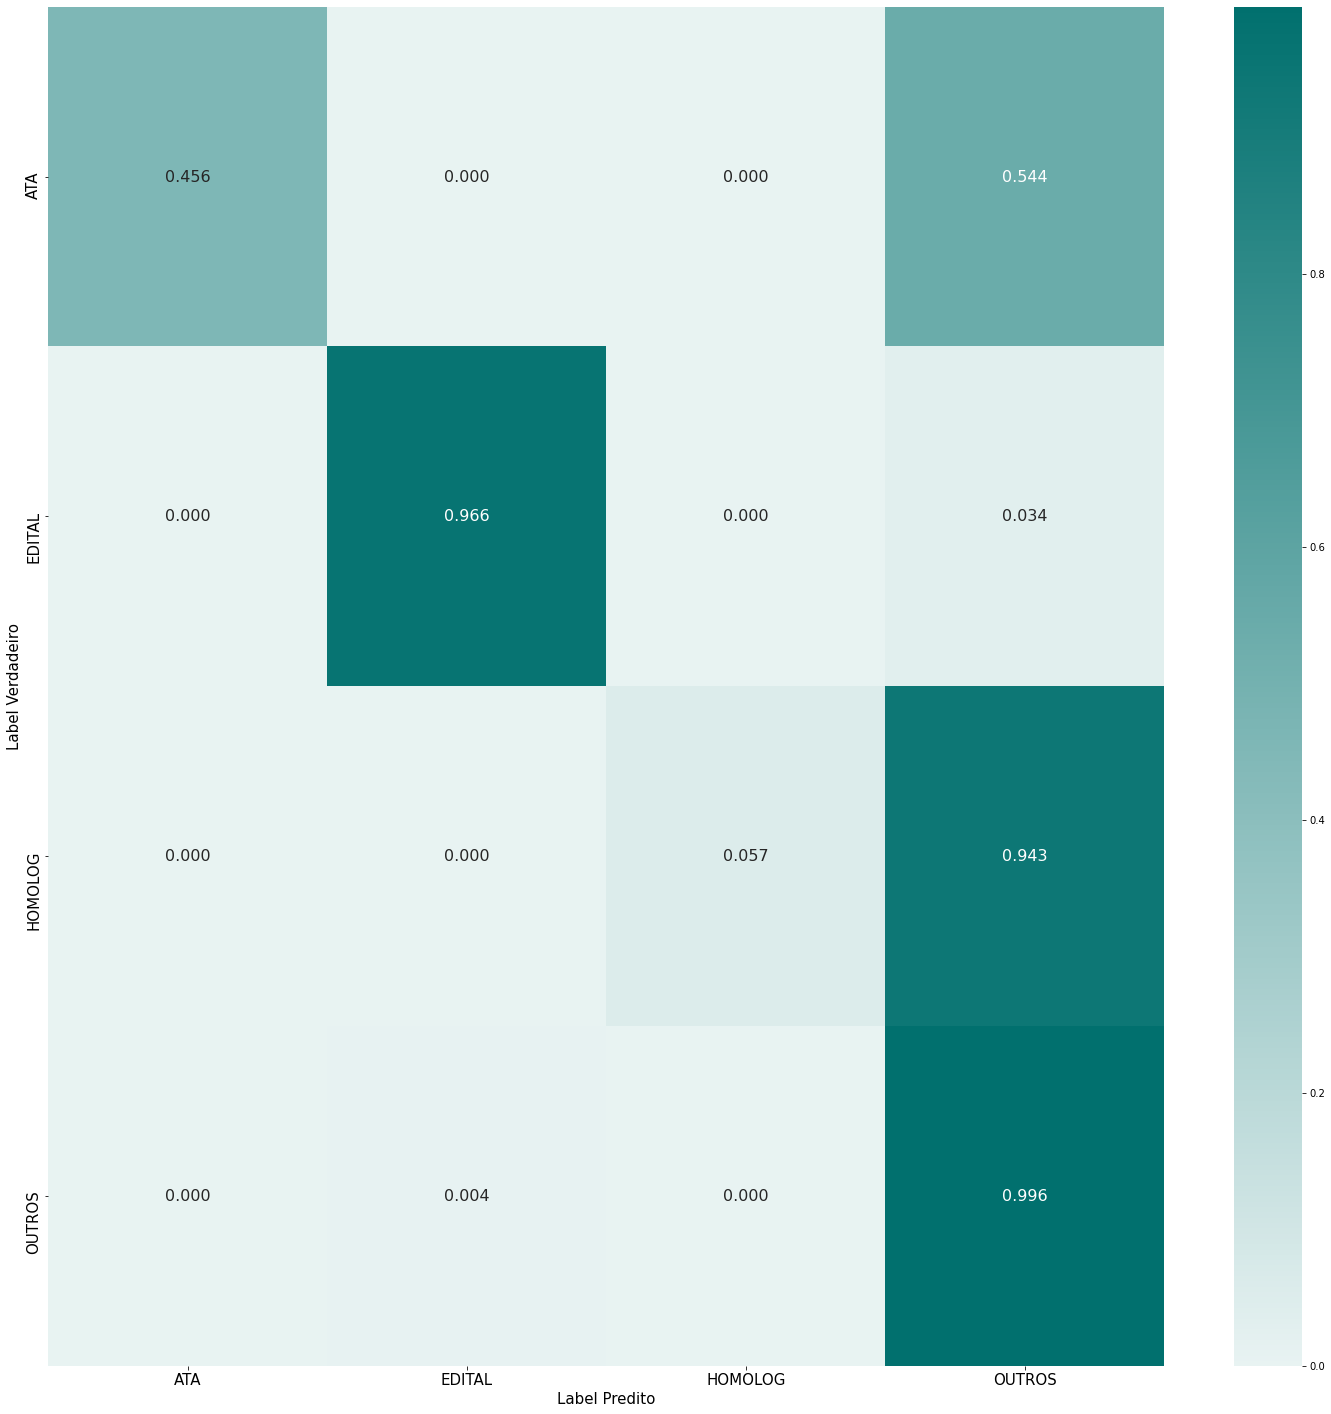

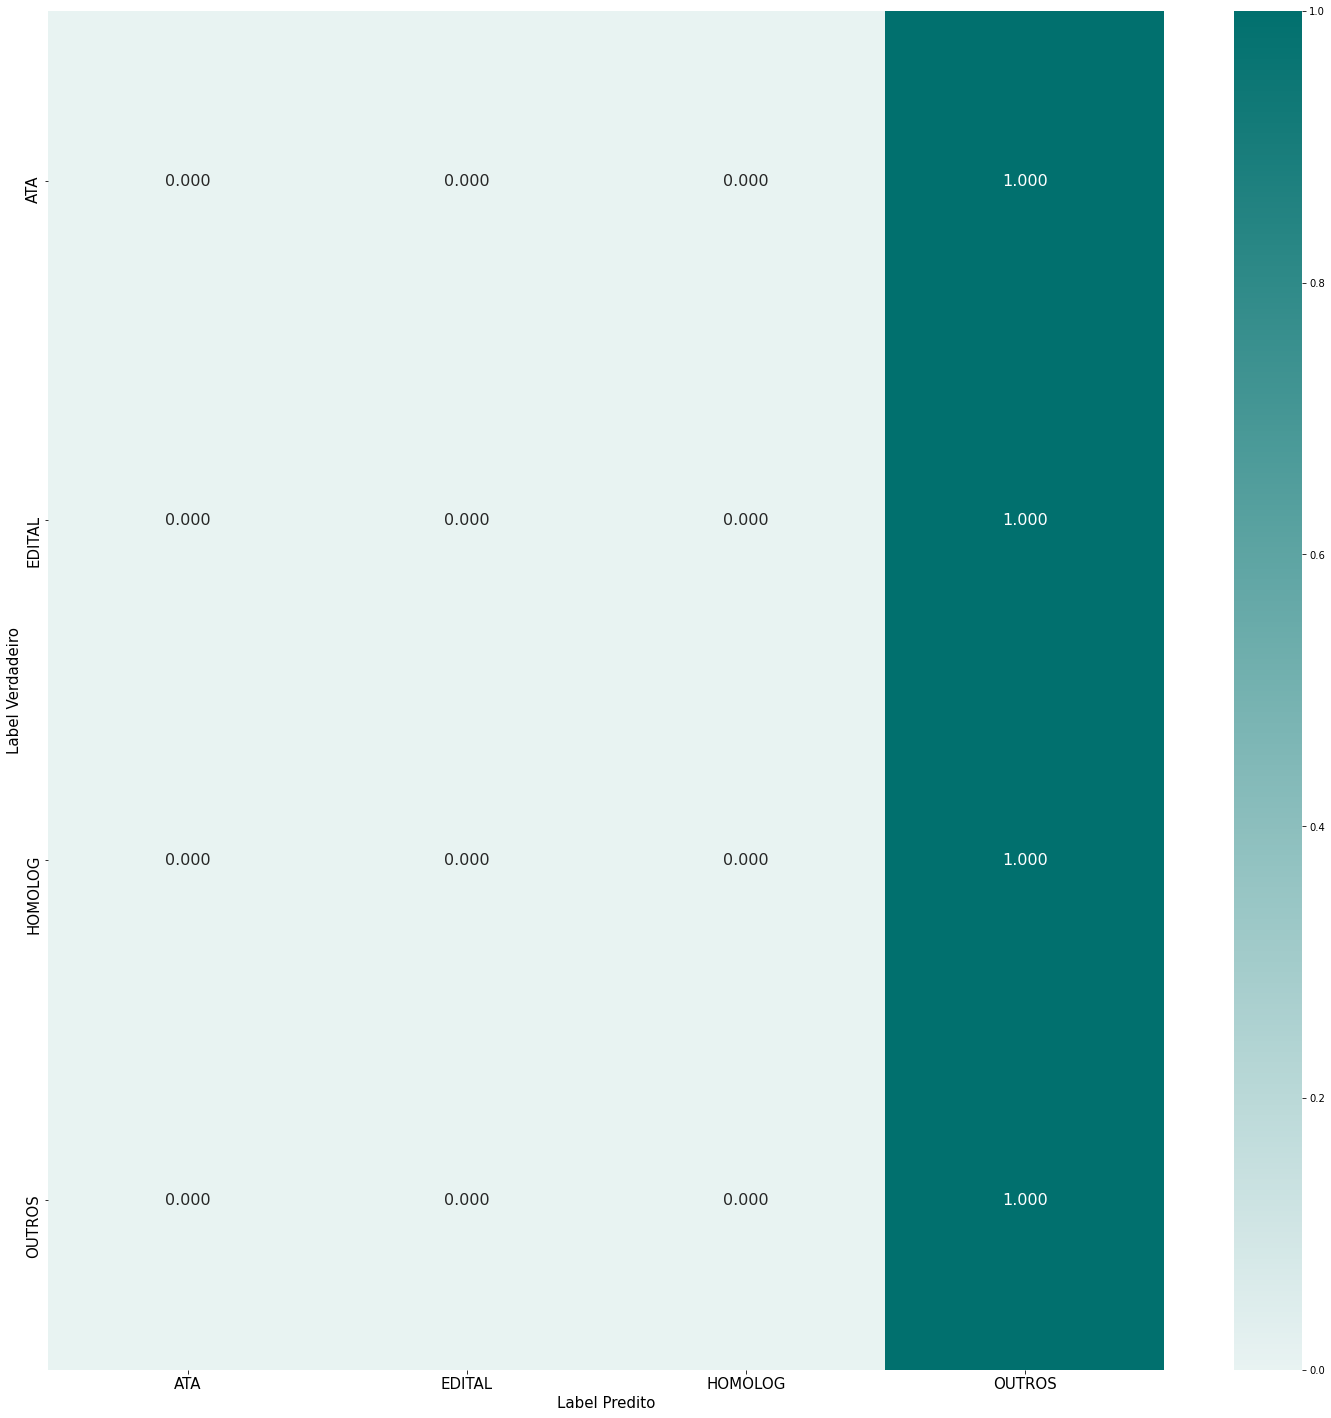

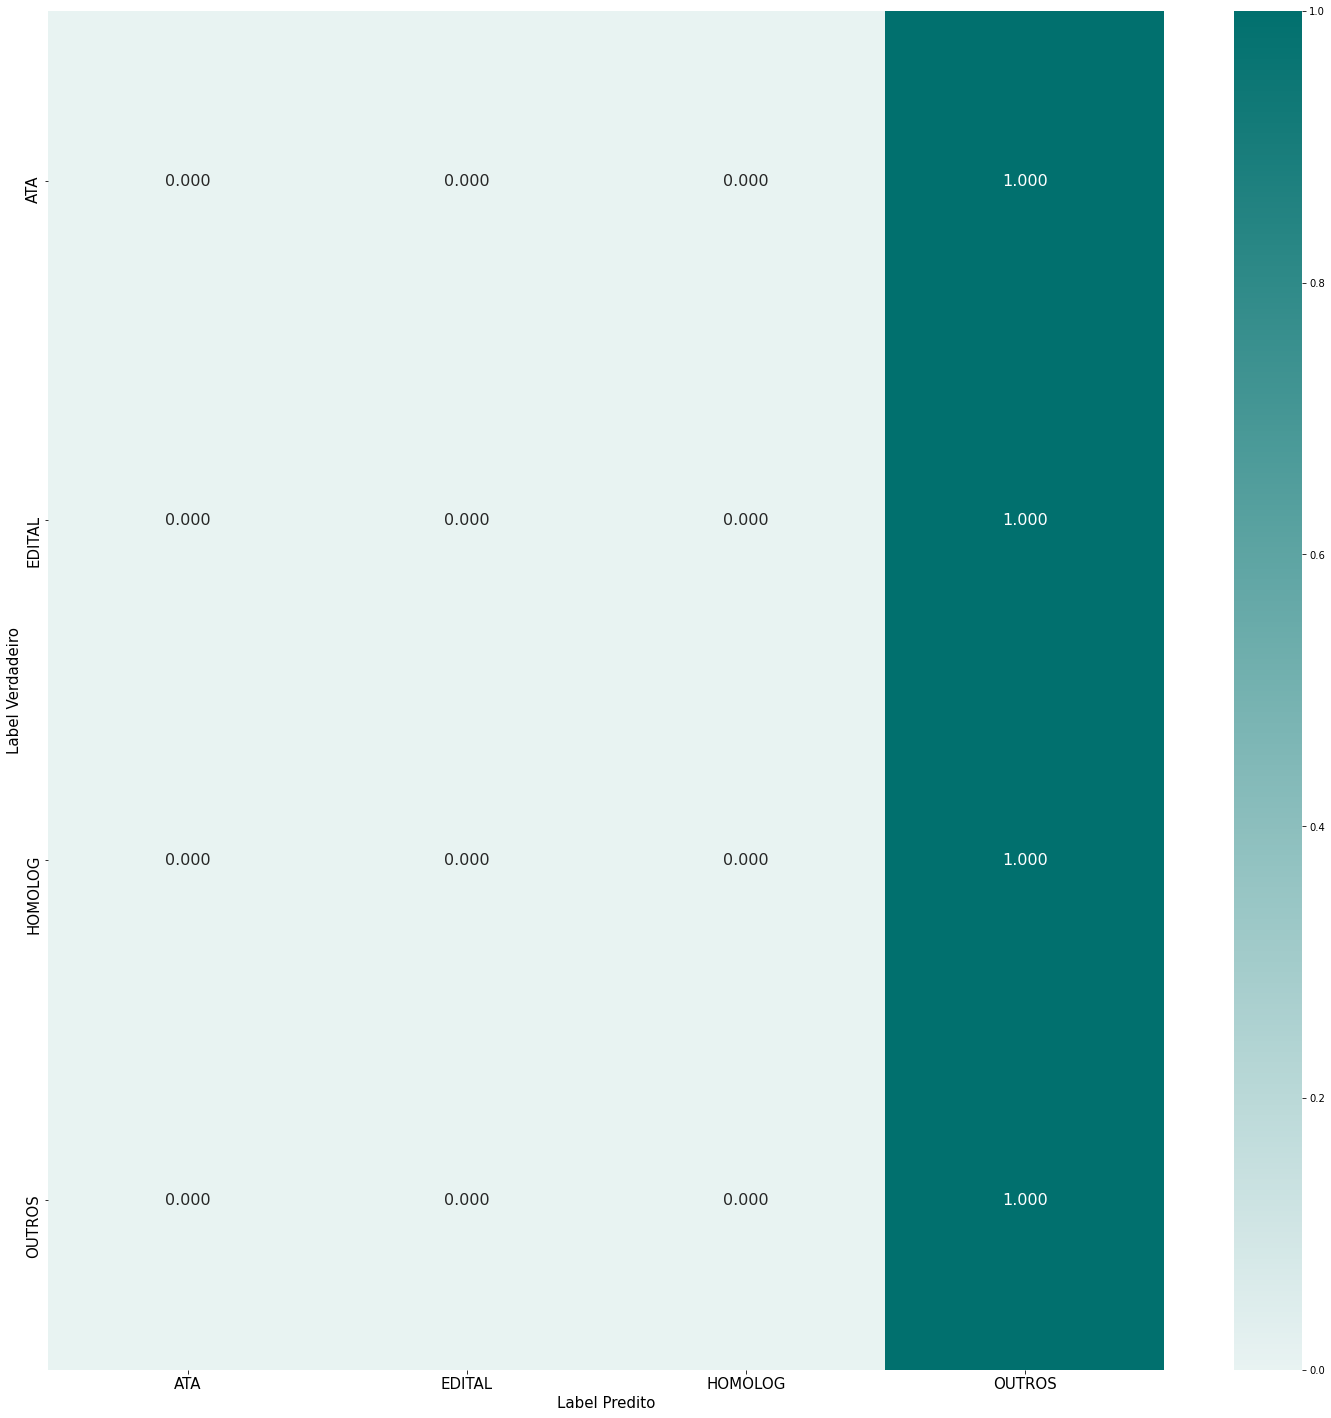

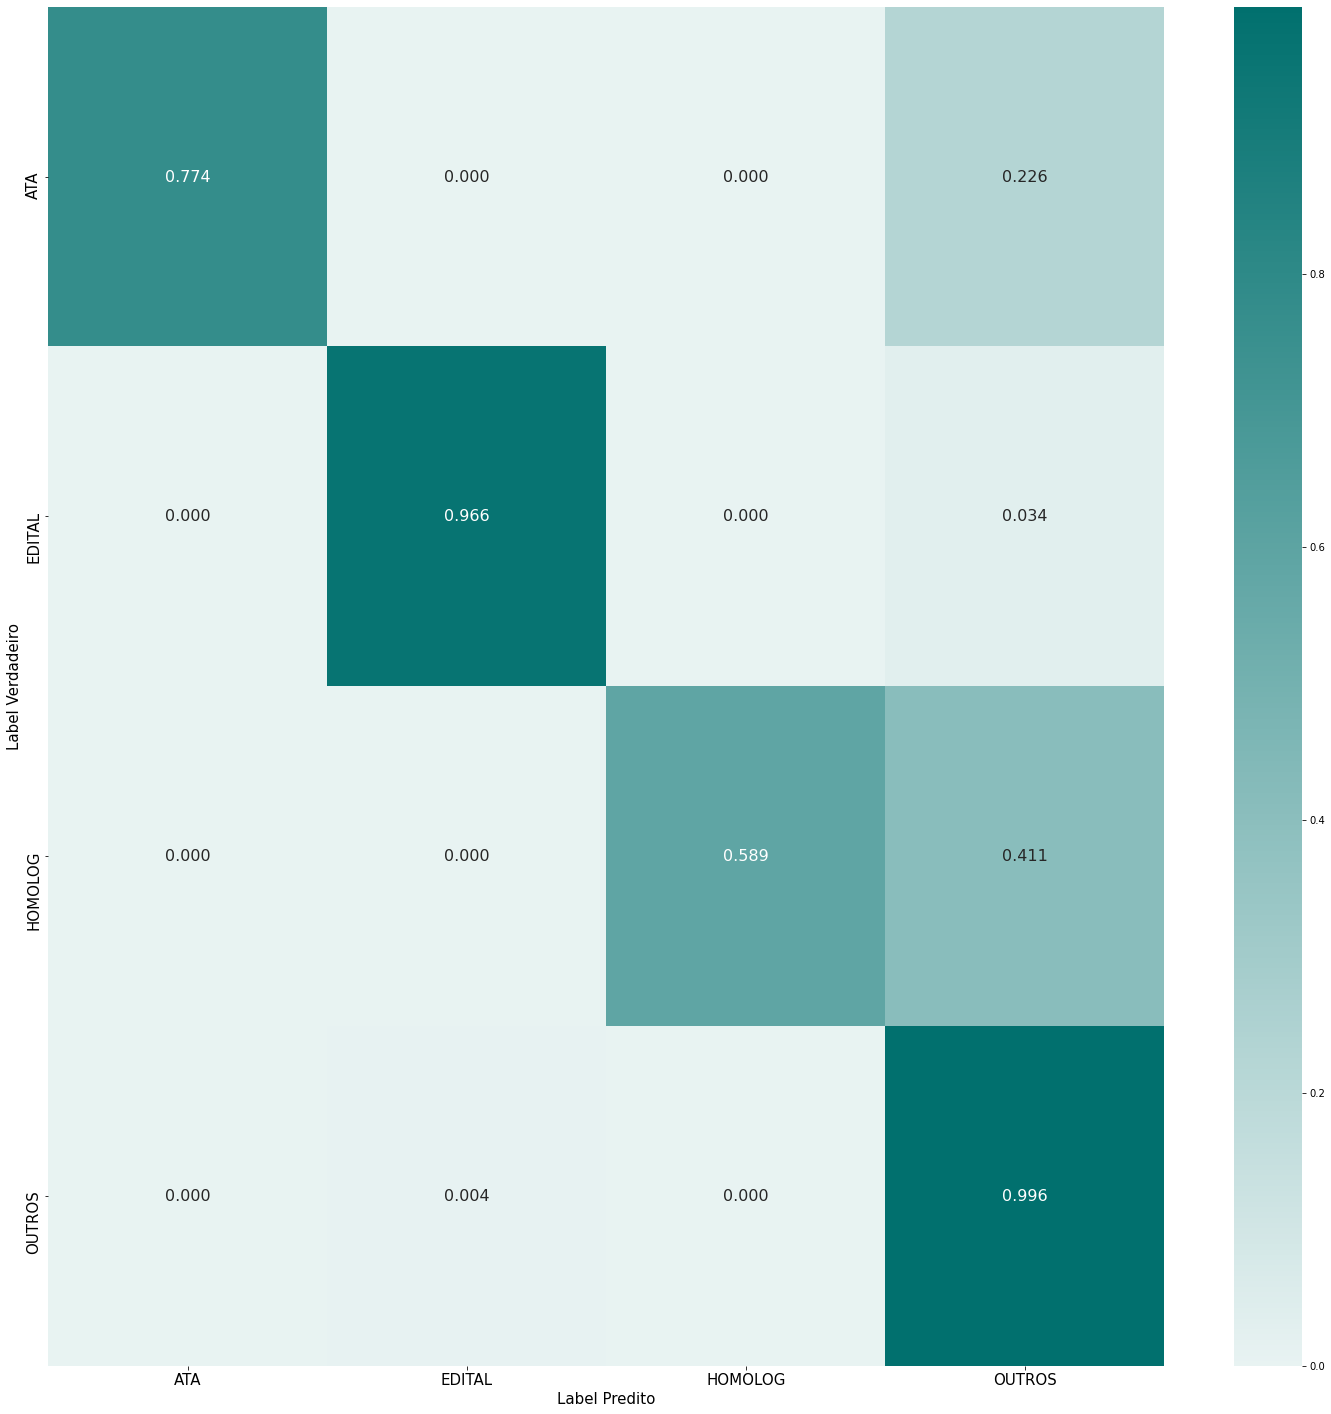

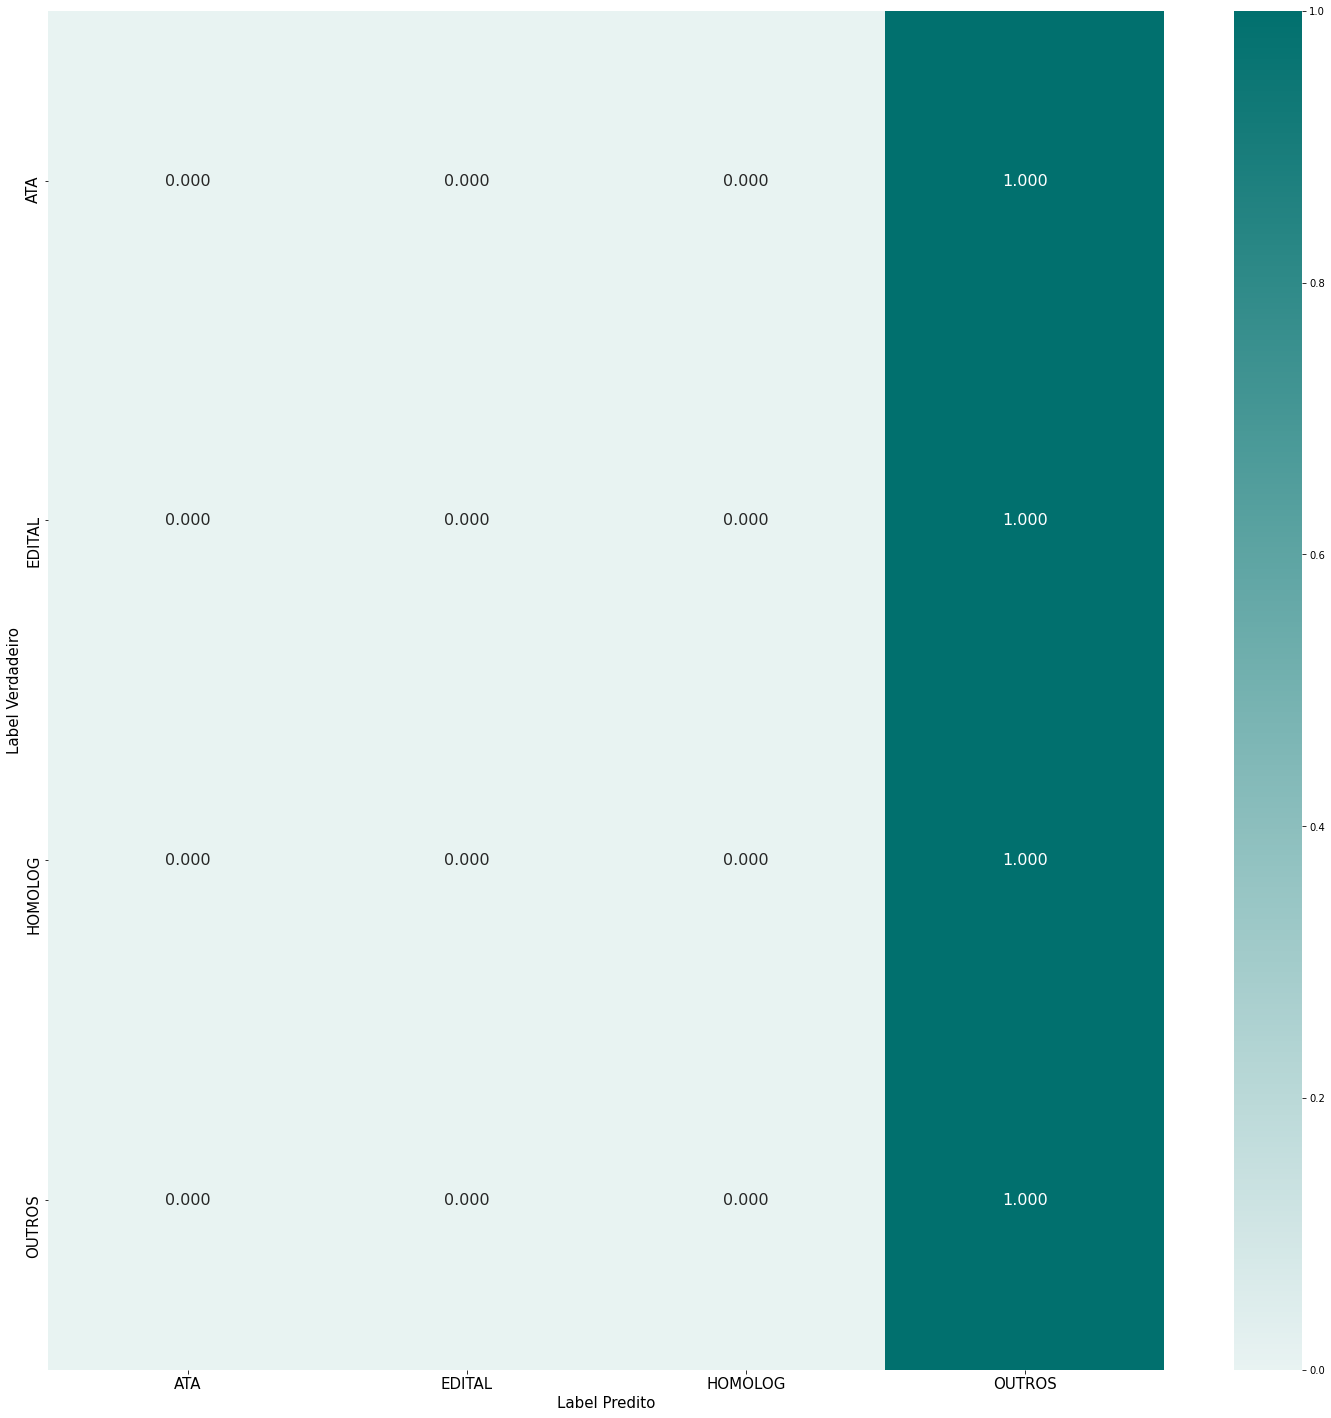

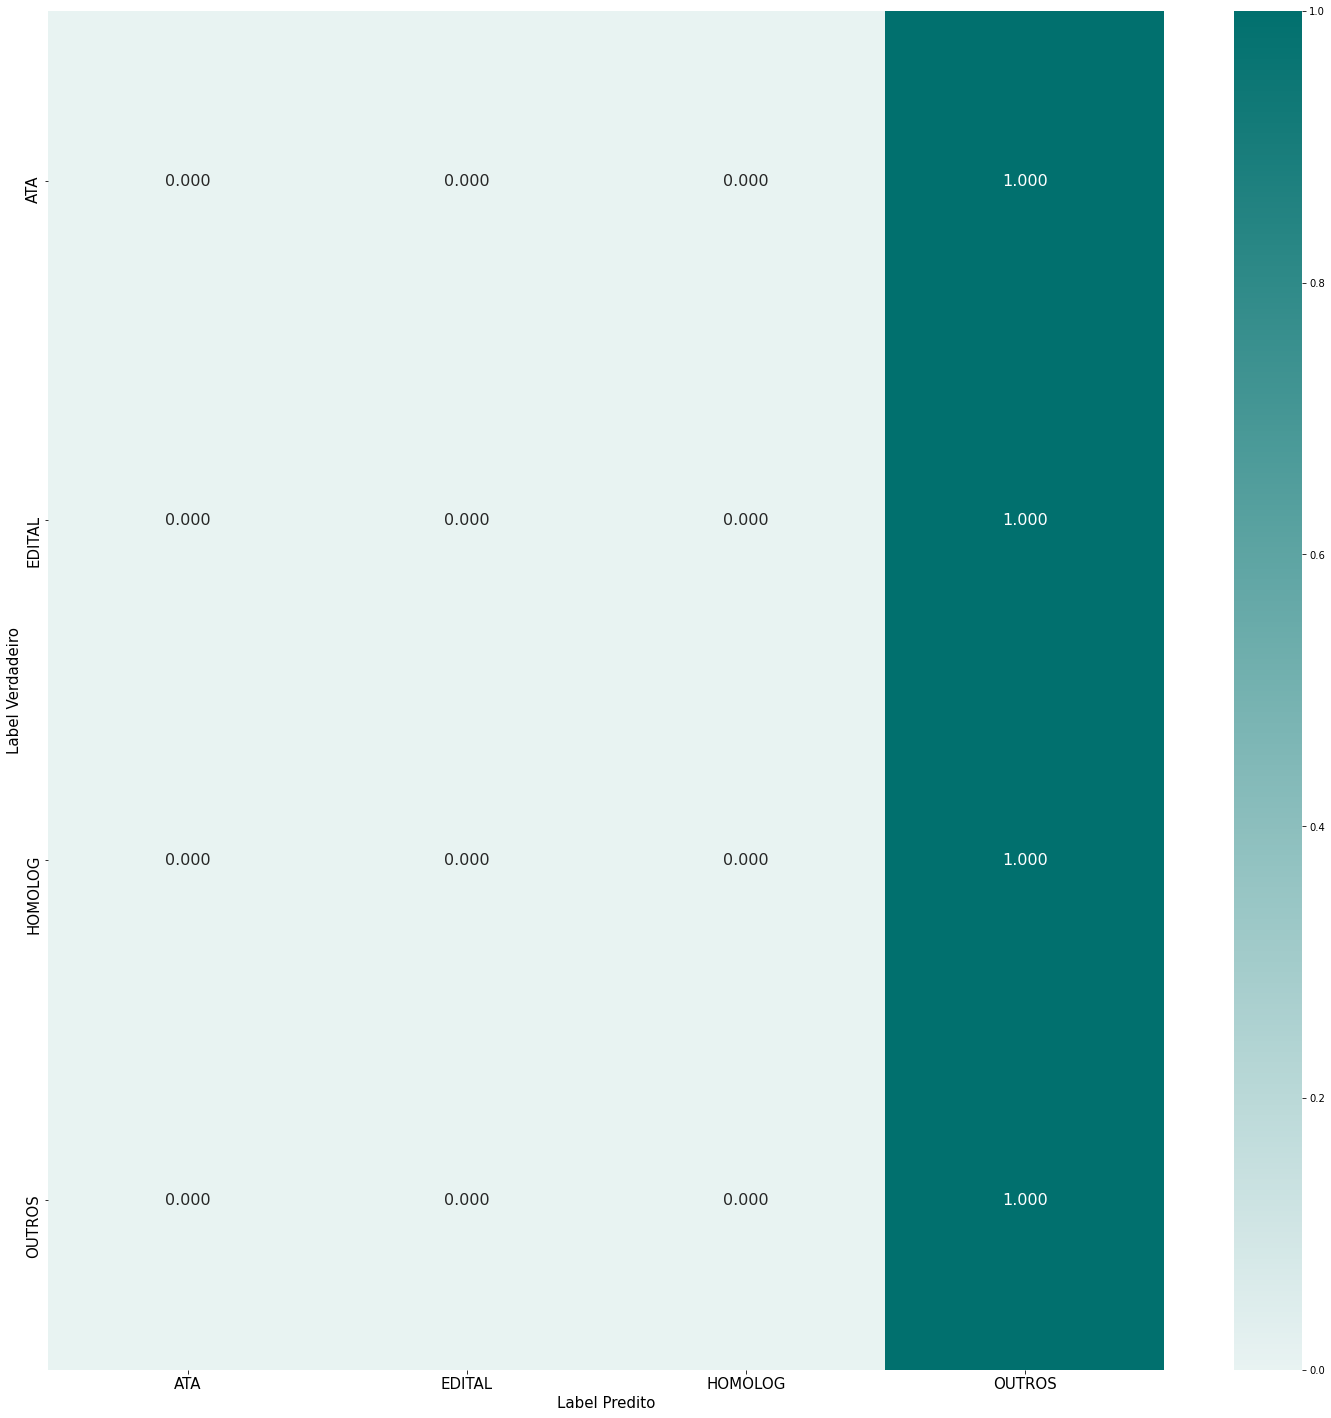

In [41]:
print("\n Random Forest sem feature selection")
rf = RandomForestClassifier(max_depth=10,max_features=10)
rf.fit(tf_idf_train,y_train.values.ravel())

score_rf = rf.score(tf_idf_train, y_train.values.ravel())

print("\nTrain set score: ", score_rf)

score_val_rf = rf.score(tf_idf_val_final, y_val.values.ravel())

print("\nValidation set score: ", score_val_rf)

score_test_rf = rf.score(tf_idf_test_final, y_test.values.ravel())

print("\nTest set score: ", score_test_rf)

print("\n>> Avaliações - Random Forest")

y_pred_train = rf.predict(tf_idf_train)

evaluation_models(y_train, y_pred_train, "treino - Random Forest")

y_pred_val = rf.predict(tf_idf_val_final)

evaluation_models(y_val, y_pred_val, "validação - Random Forest")

y_pred_test = rf.predict(tf_idf_test_final)

evaluation_models(y_test, y_pred_test, "teste - Random Forest")

print("\n Random Forest com feature selection")
rf = RandomForestClassifier(max_depth=10,max_features=10)
rf.fit(features_train,y_train.values.ravel())

score_rf = rf.score(features_train, y_train.values.ravel())

print("\nTrain set score: ", score_rf)

score_val_rf = rf.score(features_val, y_val.values.ravel())

print("\nValidation set score: ", score_val_rf)

score_test_rf = rf.score(features_test, y_test.values.ravel())

print("\nTest set score: ", score_test_rf)


print("\n>> Avaliações - Random Forest")

y_pred_train = rf.predict(features_train)

evaluation_models(y_train, y_pred_train, "treino")

y_pred_val = rf.predict(features_val)

evaluation_models(y_val, y_pred_val, "validação")

y_pred_test = rf.predict(features_test)

evaluation_models(y_test, y_pred_test, "teste")




# XGBoost


 XGBoost sem feature selection


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Train set score:  0.9997472832954258
>> EVALUATION TRUE:       final_meta-class
4496           OUTROS
3659           OUTROS
4182           OUTROS
4400           OUTROS
554               ATA
...               ...
4298           OUTROS
3941           OUTROS
2749           EDITAL
2003           EDITAL
3837           OUTROS

[3957 rows x 1 columns]
F1_score macro treino: 0.9998413322133964
F1_score weighted treino: 0.9997472820487241
TRUE: 4496    OUTROS
3659    OUTROS
4182    OUTROS
4400    OUTROS
554        ATA
         ...  
4298    OUTROS
3941    OUTROS
2749    EDITAL
2003    EDITAL
3837    OUTROS
Name: final_meta-class, Length: 3957, dtype: object
{'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'}
LABELS true: {'HOMOLOG', 'ATA', 'EDITAL', 'OUTROS'

ValueError: feature_names mismatch: ['aa', 'aaa', 'aaplicacaodaspenalidadescabiveis', 'aaquisicao', 'aar', 'aas', 'aausenciadocredenciadoemqualquermomentodasessaopublica', 'ab', 'aba', 'abacate', 'abacaxi', 'abaco', 'abade', 'abaixador', 'abas', 'abastecer', 'abastecidos', 'abastecimento', 'abastecimentos', 'abatimento', 'abatimentos', 'abc', 'abdome', 'abdominal', 'aberta', 'abertas', 'aberto', 'abertos', 'abertura', 'abic', 'abnt', 'abobora', 'abobrinha', 'abra', 'abracadeira', 'abrange', 'abrangencia', 'abrangendo', 'abrantes', 'abre', 'abreu', 'abri', 'abridor', 'abrigada', 'abrigar', 'abrigo', 'abril', 'abrir', 'abrira', 'abrirao', 'abriu', 'abs', 'absoluta', 'absoluto', 'absorcao', 'absorvente', 'abster', 'ac', 'acabada', 'acabamento', 'acabamentos', 'acabaria', 'acacia', 'academia', 'academias', 'academicas', 'acao', 'acarreta', 'acarretam', 'acarretando', 'acarretar', 'acarretara', 'acarretarem', 'acarretaria', 'acarrete', 'acartadecredenciamento', 'acategoria', 'acc', 'ace', 'aceita', 'aceitabilidade', 'aceitacao', 'aceitando', 'aceitar', 'aceitara', 'aceitarem', 'aceitas', 'aceitaveis', 'aceitavel', 'aceite', 'aceitem', 'aceito', 'aceitos', 'aceleracao', 'acelerador', 'acem', 'acendimento', 'acer', 'acertadas', 'acertado', 'acerto', 'acervo', 'acessar', 'acesse', 'acessibilidade', 'acessivel', 'acesso', 'acessorio', 'acessorios', 'acessos', 'acetato', 'acetilcisteina', 'acetilsalicilico', 'acha', 'achada', 'achado', 'achatado', 'achocolatado', 'aci', 'aciclovir', 'acid', 'acida', 'acidente', 'acidentes', 'acidez', 'acidificante', 'acido', 'acidos', 'acidulado', 'acidulante', 'acionadas', 'acionado', 'acionador', 'acionadores', 'acionamento', 'acionista', 'acionistas', 'aclamacao', 'aclasta', 'aco', 'acoes', 'acolhida', 'acolhimento', 'acolho', 'acomodacao', 'acomodacoes', 'acomotacita', 'acompanha', 'acompanhada', 'acompanhadas', 'acompanhado', 'acompanhados', 'acompanhamento', 'acompanhando', 'acompanhante', 'acompanhar', 'acompanhara', 'acondicionada', 'acondicionadas', 'acondicionado', 'acondicionados', 'acondicionamento', 'acontecera', 'acontecimento', 'acopia', 'acoplada', 'acoplado', 'acordado', 'acordam', 'acordao', 'acordaram', 'acordo', 'acordos', 'acostadas', 'acostado', 'acostados', 'acr', 'acresce', 'acrescentado', 'acrescentar', 'acrescido', 'acrescimo', 'acrescimos', 'acrilex', 'acrilica', 'acrilico', 'acs', 'active', 'acucar', 'acuidade', 'acum', 'acumulacao', 'acumulada', 'acumulado', 'acumular', 'acumulo', 'acustico', 'ad', 'ada', 'adaptacao', 'adaptacoes', 'adaptado', 'adaptador', 'adaptados', 'adaptativas', 'adaptativo', 'ade', 'adeclaracao', 'adelbras', 'adendo', 'adendos', 'adenosina', 'adensamento', 'adequacao', 'adequacoes', 'adequada', 'adequadas', 'adequado', 'adequados', 'adequar', 'aderem', 'aderencia', 'aderente', 'aderentes', 'aderidos', 'aderir', 'aderirem', 'ades', 'adesao', 'adesiva', 'adesivada', 'adesivo', 'adesivos', 'adesoes', 'adiada', 'adicao', 'adicionada', 'adicionado', 'adicionais', 'adicional', 'adimplemento', 'adimplentes', 'aditado', 'aditamento', 'aditamentos', 'aditivado', 'aditivados', 'aditivo', 'aditivos', 'adjudica', 'adjudicacao', 'adjudicacaopdf', 'adjudicada', 'adjudicado', 'adjudicados', 'adjudicando', 'adjudicar', 'adjudicara', 'adjudicataria', 'adjudicatario', 'adjudico', 'adjuvantes', 'adm', 'admini', 'adminis', 'administracao', 'administracaopublica', 'administracoes', 'administrador', 'administradora', 'administradores', 'administrados', 'administrar', 'administrativa', 'administrativas', 'administrativo', 'administrativos', 'admissao', 'admissibilidade', 'admissivel', 'admite', 'admitem', 'admitida', 'admitidas', 'admitido', 'admitidos', 'admitindo', 'admitir', 'admitira', 'ado', 'adocante', 'adocao', 'adocumentacaoconformeas', 'adocumentacaodeveraserapresentada', 'adolescente', 'adolescentes', 'adotada', 'adotadas', 'adotado', 'adotados', 'adotando', 'adotar', 'adote', 'adquirida', 'adquiridas', 'adquirido', 'adquiridos', 'adquirir', 'adquirirem', 'adquiriu', 'adriana', 'adriani', 'adriano', 'adstrita', 'adubacao', 'adulteracao', 'adulto', 'adultos', 'aduz', 'adversa', 'advertencia', 'advindas', 'advir', 'advocaticios', 'advogada', 'advogado', 'advogados', 'ae', 'aee', 'aereas', 'aeroportos', 'aerosol', 'aerossol', 'aexclusividade', 'af', 'afasta', 'afastada', 'afastamento', 'afastar', 'afazenda', 'afazendaestadual', 'afazendaestadualda', 'afe', 'afericao', 'aferida', 'aferir', 'afeta', 'afetada', 'afetadas', 'afetam', 'afetar', 'afete', 'afetem', 'afim', 'afinidade', 'afins', 'afirma', 'afirmacao', 'afirmam', 'afirmar', 'afirmativas', 'afixadas', 'afixado', 'afixados', 'afonso', 'afs', 'ag', 'agencia', 'agencias', 'agenda', 'agendada', 'agendadas', 'agendado', 'agendamento', 'agendamentos', 'agendar', 'agente', 'agentes', 'agi', 'agilidade', 'agilizar', 'agle', 'aglon', 'agostinho', 'agosto', 'agradavel', 'agradeceu', 'agrale', 'agrario', 'agratto', 'agravos', 'agregados', 'agregue', 'agricola', 'agricolas', 'agricult', 'agricultor', 'agricultores', 'agricultura', 'agridem', 'agroecologicos', 'agroindustria', 'agroindustriais', 'agronomia', 'agropecuari', 'agropecuaria', 'agropecuario', 'agrotoxicos', 'agua', 'aguarda', 'aguardando', 'aguardar', 'aguas', 'aguda', 'aguia', 'aguiar', 'agulha', 'agulhado', 'agulhas', 'agulhinha', 'ah', 'ai', 'aids', 'ailton', 'aindaquecomalgumapendenciaourestricao', 'aindaquemunidadeprocuracao', 'air', 'airbag', 'airbags', 'airro', 'ais', 'aitva', 'aj', 'aja', 'ajeje', 'ajuda', 'ajudante', 'ajuntadeira', 'ajustado', 'ajustados', 'ajustam', 'ajustamento', 'ajustavel', 'ajuste', 'ajustes', 'al', 'ala', 'alair', 'alambrado', 'alameda', 'alan', 'alane', 'alaranjada', 'alarme', 'alarmes', 'alas', 'alavanca', 'alberto', 'albis', 'album', 'albumina', 'alc', 'alca', 'alcalina', 'alcalinizante', 'alcancada', 'alcancado', 'alcancados', 'alcancando', 'alcance', 'alcapao', 'alceu', 'alcione', 'alcool', 'alea', 'alecxandro', 'alega', 'alegacao', 'alegacoes', 'alegado', 'alegam', 'alegando', 'alegar', 'alegre', 'aleluia', 'alem', 'alex', 'alexandre', 'alfa', 'alfabeto', 'alface', 'alfagas', 'alfalagos', 'alfenas', 'alfinete', 'alfredo', 'algarismo', 'algarismos', 'algodao', 'alho', 'alianca', 'alicate', 'alienacao', 'alienacoes', 'alimentacao', 'alimentar', 'alimentares', 'alimenticio', 'alimenticios', 'alimento', 'alimentos', 'aline', 'alinea', 'alineas', 'alinhamento', 'alinhavo', 'aliquota', 'alma', 'almaco', 'almada', 'alme', 'almeid', 'almeida', 'almoco', 'almofada', 'almofadas', 'almotolia', 'almoxarifado', 'alocada', 'alocados', 'alojamento', 'alojar', 'alongado', 'alongo', 'alphaville', 'alprazolam', 'alquil', 'alt', 'alta', 'altair', 'altamira', 'altas', 'altera', 'alteracao', 'alteracoes', 'alteracoesa', 'alterada', 'alteradas', 'alterado', 'alterados', 'alterando', 'alterar', 'altere', 'alternada', 'alternativa', 'alternativas', 'alternativos', 'alterou', 'alto', 'altomare', 'altura', 'aludido', 'aludidos', 'alugueis', 'aluguel', 'aluminio', 'aluno', 'alunos', 'alv', 'alvara', 'alvaras', 'alvarenga', 'alvares', 'alvaro', 'alvejado', 'alvenaria', 'alveolar', 'alverne', 'alves', 'alvina', 'alvura', 'alyson', 'am', 'amaciante', 'amadurecimento', 'amalgama', 'amalgamador', 'amalia', 'amanco', 'amanda', 'amanteigada', 'amapa', 'amaral', 'amarela', 'amarelada', 'amareladas', 'amarelados', 'amarelamento', 'amarelo', 'amaro', 'amarracao', 'amassada', 'amassadas', 'amassados', 'amazon', 'amazonas', 'amb', 'ambar', 'ambas', 'ambientais', 'ambiental', 'ambientalmente', 'ambiente', 'ambientes', 'ambito', 'ambroxol', 'ambu', 'ambulancia', 'ambulancias', 'ambulatorial', 'amd', 'amelia', 'amelio', 'amendoa', 'amendoim', 'america', 'american', 'americana', 'americano', 'americo', 'amg', 'amianto', 'amido', 'amilaceo', 'amilase', 'amina', 'amiodarona', 'amitriptilina', 'amm', 'amo', 'amonio', 'amorfo', 'amortecedor', 'amortecedores', 'amostra', 'amostras', 'amoxicilina', 'amp', 'amparada', 'amparado', 'amparo', 'amperes', 'amperimetro', 'ampicilina', 'ampla', 'ampliacao', 'ampliacoes', 'ampliado', 'ampliando', 'ampliar', 'amplificador', 'amplificadores', 'amplo', 'amplos', 'ampola', 'ampolas', 'amputacao', 'an', 'ana', 'analio', 'analisa', 'analisada', 'analisadas', 'analisado', 'analisador', 'analisados', 'analisando', 'analisar', 'analisara', 'analise', 'analises', 'anamnese', 'ananias', 'anatel', 'anatomico', 'ancoragem', 'andaime', 'andamento', 'andar', 'andere', 'andorinha', 'andrade', 'andre', 'andreia', 'android', 'anel', 'anemia', 'aneotania', 'aneroide', 'anestesia', 'anestesica', 'anestesico', 'anestesiologia', 'anestesista', 'anexa', 'anexacao', 'anexada', 'anexadaacartade', 'anexadas', 'anexado', 'anexados', 'anexar', 'anexas', 'anexo', 'anexoiidesteedital', 'anexos', 'angelica', 'angelino', 'angelo', 'angulo', 'animais', 'animal', 'anionicos', 'aniversario', 'anjos', 'anlodipino', 'ano', 'anonima', 'anonimas', 'anormal', 'anormalidade', 'anos', 'anotacao', 'anotacoes', 'anp', 'ant', 'antares', 'antecedencia', 'antecedentes', 'anteceder', 'antecedera', 'antecederem', 'antecipacao', 'antecipado', 'antecipando', 'antena', 'antenas', 'anteparo', 'anterior', 'anteriores', 'antero', 'anti', 'antiacaro', 'antibacteriano', 'antibloqueio', 'anticoagulante', 'anticorrosivo', 'antiderrapante', 'antifungo', 'antigo', 'antineoplasicos', 'antirrabica', 'antisseptico', 'antonia', 'antonio', 'antropometrica', 'anuais', 'anual', 'anualmente', 'anuencia', 'anuido', 'anulacao', 'anulado', 'anulados', 'anular', 'anunciado', 'anverso', 'anvisa', 'aoc', 'aocusto', 'aoencerrarocredenciamento', 'aofinalassinado', 'aorta', 'ap', 'apac', 'apagadas', 'apagador', 'apagar', 'aparecera', 'aparecida', 'aparecido', 'aparelhada', 'aparelhamento', 'aparelho', 'aparelhos', 'aparencia', 'aparente', 'apenada', 'apenasumamarca', 'api', 'apiloamento', 'aplica', 'aplicacao', 'aplicacoes', 'aplicada', 'aplicadas', 'aplicado', 'aplicador', 'aplicadores', 'aplicados', 'aplicando', 'aplicar', 'aplicara', 'aplicativo', 'aplicaveis', 'aplicaveisaespecie', 'aplicavel', 'aplicou', 'apo', 'apodrecidas', 'apodrecidos', 'apodrecimentos', 'apoiar', 'apoio', 'apolices', 'apontada', 'apontadas', 'apontador', 'apontados', 'apontamentos', 'apontando', 'apontar', 'apos', 'aposentado', 'aposentados', 'aposoregularcredenciamento', 'apostiladas', 'apostilamentos', 'app', 'aprazada', 'apreciacao', 'aprendiz', 'aprendizado', 'apresenta', 'apresentacao', 'apresentacoes', 'apresentada', 'apresentadas', 'apresentado', 'apresentados', 'apresentam', 'apresentando', 'apresentar', 'apresentara', 'apresentaradeclaracao', 'apresentaram', 'apresentarao', 'apresentaras', 'apresentarem', 'apresentaremos', 'apresentarnomomentooportuno', 'apresente', 'apresentem', 'apresentou', 'apresuntado', 'aprimoramento', 'aprimorando', 'apropostacomocnpjdaempresa', 'apropriada', 'apropriadas', 'apropriado', 'aprova', 'aprovacao', 'aprovada', 'aprovadas', 'aprovado', 'aprovados', 'aprovar', 'aproveitada', 'aproveitamento', 'aproveitando', 'aproveitaveis', 'aprovou', 'aproximada', 'aproximadas', 'aproximado', 'apt', 'apta', 'aptamil', 'aptas', 'apti', 'aptidao', 'apto', 'aptos', 'apuracao', 'apurada', 'apuradas', 'apurado', 'apurados', 'apurar', 'apure', 'aquecedor', 'aquiesce', 'aquisicao', 'aquisicoes', 'aquisisao', 'aqusicao', 'ar', 'ara', 'aracatuba', 'aracoiaba', 'aradora', 'araguari', 'aramado', 'arame', 'arantes', 'arar', 'arary', 'araujo', 'arcar', 'arcara', 'arco', 'arcos', 'ardidos', 'area', 'areas', 'areia', 'arena', 'arenna', 'arespeito', 'aretusa', 'argamassa', 'argo', 'argola', 'argolinha', 'argumentos', 'aristeu', 'arla', 'arm', 'armacao', 'armada', 'armado', 'armadura', 'armando', 'armarinhos', 'armario', 'armazenados', 'armazenamento', 'aro', 'aroma', 'aromatizante', 'arp', 'arqplast', 'arquibancadas', 'arquiteta', 'arquiteto', 'arquitetonica', 'arquitetonico', 'arquitetura', 'arquivada', 'arquivado', 'arquivados', 'arquivamento', 'arquive', 'arquivo', 'arquivos', 'array', 'arrazoado', 'arrecadacao', 'arrecadadas', 'arrecadados', 'arredondado', 'arredondamento', 'arrematacao', 'arrematados', 'arrematante', 'arrematantes', 'arrimo', 'arrolados', 'arroz', 'arruda', 'arruela', 'arrumada', 'art', 'arte', 'artecamp', 'artefatos', 'arterial', 'arterias', 'artes', 'artesanato', 'artesiano', 'artesianos', 'articulacao', 'articulada', 'articuladas', 'articuladora', 'articuladoras', 'artificiais', 'artificial', 'artigo', 'artigos', 'artista', 'artistas', 'artistica', 'artisticas', 'artistico', 'artisticos', 'arts', 'arvores', 'as', 'ascorbico', 'aseguir', 'asem', 'asfaltica', 'asfaltico', 'asfalto', 'aslicitantes', 'aslo', 'asp', 'aspecto', 'aspectos', 'aspirador', 'asr', 'ass', 'assadeira', 'assado', 'assegurada', 'assegurado', 'assegurando', 'assegurar', 'assegure', 'assembleia', 'assemelhada', 'assemelhado', 'assentada', 'assentado', 'assentamento', 'assentamentos', 'assentar', 'assento', 'assentos', 'assepsia', 'assessor', 'assessoramento', 'assessoria', 'assessorias', 'assina', 'assinada', 'assinadas', 'assinado', 'assinados', 'assinalado', 'assinale', 'assinam', 'assinar', 'assinara', 'assinaram', 'assinarem', 'assinatura', 'assinaturas', 'assine', 'assinou', 'assis', 'assist', 'assiste', 'assistencia', 'assistenciais', 'assistente', 'assistidas', 'assistidos', 'assistindo', 'assistir', 'assitencia', 'assoc', 'associacao', 'associacoes', 'associada', 'associadas', 'associado', 'associados', 'associem', 'assolan', 'assume', 'assumida', 'assumidas', 'assumido', 'assumidos', 'assumindo', 'assumir', 'assumpta', 'assunto', 'assuntos', 'ast', 'astem', 'astm', 'astra', 'astrazeneca', 'at', 'ata', 'atacadista', 'atacadistas', 'atadura', 'atas', 'ate', 'atencao', 'atenda', 'atendam', 'atende', 'atendem', 'atendendo', 'atendente', 'atender', 'atendera', 'atenderam', 'atenderem', 'atendeu', 'atendida', 'atendidas', 'atendido', 'atendidos', 'atendimento', 'atendimentos', 'atenolol', 'atentando', 'atenuada', 'ateoultimodiautilqueantecederadata', 'aterial', 'aterrados', 'aterramento', 'aterro', 'atestada', 'atestadas', 'atestado', 'atestados', 'atestando', 'atestar', 'atestara', 'ateste', 'atesto', 'atf', 'atila', 'atinente', 'atinentes', 'atingem', 'atingido', 'atingidos', 'atingir', 'atingiu', 'ativ', 'ativa', 'ativada', 'ativado', 'ativas', 'atividade', 'atividades', 'ativo', 'ativos', 'atlantica', 'atlas', 'atm', 'atmosferica', 'ato', 'atomico', 'atorvastatina', 'atos', 'atospraticados', 'atoxica', 'atoxico', 'atracao', 'atracoes', 'atracurio', 'atrair', 'atrapalhe', 'atrasada', 'atrasar', 'atraso', 'atrasos', 'atraves', 'atravesdedeclaracao', 'atribua', 'atribuicao', 'atribuicoes', 'atribuidas', 'atribuido', 'atribuidos', 'atrio', 'atropina', 'atua', 'atuacao', 'atuais', 'atual', 'atualidade', 'atualizacao', 'atualizacoes', 'atualizada', 'atualizadas', 'atualizado', 'atualizados', 'atuando', 'atuar', 'atuara', 'atuarem', 'atue', 'atuem', 'atv', 'atx', 'au', 'audatex', 'aude', 'audiencia', 'audio', 'audiograma', 'audiovisuais', 'audiovisual', 'auditiva', 'auditoria', 'auferidos', 'auferindo', 'augusto', 'aula', 'aulas', 'aumenta', 'aumentando', 'aumentar', 'aumento', 'aumentos', 'aurelio', 'auricular', 'auscultador', 'ausencia', 'ausente', 'ausentes', 'autarquia', 'autarquias', 'autentica', 'autenticacao', 'autenticacoes', 'autenticada', 'autenticadas', 'autenticado', 'autenticados', 'autenticadospelo', 'autenticidade', 'auto', 'autoclavado', 'autoclavavel', 'autoclave', 'autocopiativo', 'automacao', 'automatica', 'automaticamente', 'automatico', 'automaticos', 'automotiva', 'automotivas', 'automotivo', 'automotivos', 'automotor', 'automotores', 'automoveis', 'automovel', 'autonomia', 'autonomo', 'autonomos', 'autor', 'autorais', 'autores', 'autoridade', 'autoridades', 'autoriza', 'autorizacao', 'autorizacaoexpressado', 'autorizacoes', 'autorizada', 'autorizadas', 'autorizado', 'autorizadora', 'autorizados', 'autorizando', 'autorizar', 'autorize', 'autorizo', 'autos', 'autuados', 'aux', 'auxiliado', 'auxiliando', 'auxiliar', 'auxiliares', 'auxilio', 'auxilios', 'av', 'avai', 'avaliacao', 'avaliacoes', 'avaliada', 'avaliadas', 'avaliados', 'avaliar', 'avancada', 'avancado', 'avayou', 'ave', 'aveia', 'aveian', 'avelar', 'avenca', 'avencadas', 'avencado', 'avenida', 'avenidas', 'avental', 'averiguacao', 'averiguar', 'avermelhado', 'aviamentos', 'avila', 'aviso', 'avisos', 'avivar', 'aw', 'azara', 'azarias', 'azedo', 'azeite', 'azeitona', 'azevedo', 'azitromicina', 'azul', 'azulejos', 'azulim', 'ba', 'babador', 'baby', 'bacia', 'bacitracina', 'bacon', 'bacterias', 'bactericida', 'bacteriologico', 'bag', 'bahia', 'bairro', 'bairros', 'baixa', 'baixada', 'baixadas', 'baixado', 'bala', 'balanca', 'balancas', 'balanceamento', 'balancete', 'balancetes', 'balanco', 'balancos', 'balao', 'baldansi', 'balde', 'baldrame', 'baleia', 'baliza', 'balizamento', 'balmak', 'balsa', 'bamaq', 'bambole', 'banana', 'bananas', 'banca', 'bancada', 'bancaria', 'bancarias', 'bancario', 'bancarios', 'bancas', 'banco', 'bancos', 'band', 'banda', 'bandas', 'bandeira', 'bandeirantes', 'bandeiras', 'bandeja', 'bandejas', 'bandinha', 'banheiro', 'banheiros', 'banho', 'baniquinha', 'banners', 'bar', 'barao', 'barata', 'barba', 'barbante', 'barbosa', 'barboza', 'bares', 'barra', 'barracao', 'barracas', 'barramento', 'barras', 'barreira', 'barreiras', 'barro', 'barros', 'bartolomeu', 'bas', 'basculamento', 'basculante', 'basculantes', 'base', 'baseadas', 'baseado', 'bases', 'basica', 'basicas', 'basico', 'basicos', 'basicosdiretoseindiretos', 'basquete', 'bassi', 'bastao', 'batata', 'batentes', 'bateria', 'baterias', 'batista', 'bau', 'baunilha', 'bayer', 'bb', 'bc', 'bd', 'bdi', 'bdmg', 'be', 'beam', 'bebedouro', 'bebedouros', 'bebida', 'bebidas', 'bege', 'bela', 'belchior', 'belgo', 'beline', 'belizario', 'belo', 'belvedere', 'bemaindaacartadecredenciamentocomfimespecifico', 'bemcomofrete', 'bemcomonosigilodaspropostaseointeresse', 'bemcomoosdocumentosaelainerentes', 'bemcomopararesponder', 'bemcomopraticartodososatosinerentesao', 'beneficiada', 'beneficiadas', 'beneficiado', 'beneficiados', 'beneficiaria', 'beneficiario', 'beneficiarios', 'beneficio', 'beneficios', 'benfeitorias', 'benjamin', 'benjoin', 'bens', 'benserazida', 'bento', 'benz', 'benzalconio', 'benzatina', 'benzeno', 'benzetacil', 'benzocaina', 'benzotiazolin', 'berco', 'bercos', 'berinjela', 'bernardes', 'bernardino', 'berrini', 'besilato', 'betaistina', 'betaniamed', 'beterraba', 'betim', 'betoneira', 'betuminoso', 'bexiga', 'bh', 'bhcg', 'bi', 'biblioteca', 'bibliotecario', 'bic', 'bica', 'bicabornato', 'bicalho', 'bicarbonato', 'bico', 'bicombustivel', 'bidestilada', 'big', 'bilateral', 'bilhetagem', 'bilirrubina', 'bimatoprost', 'bimetalico', 'bio', 'biobase', 'biodegradavel', 'biodinamica', 'biohosp', 'biolab', 'bioland', 'biologica', 'biologico', 'biologicos', 'bioquimica', 'bioquimicas', 'biosani', 'biotecnica', 'bipap', 'bipolar', 'biscoito', 'biscoitos', 'bisnaga', 'bissulfato', 'bisturi', 'bitartarato', 'bitola', 'bits', 'bittencourt', 'bivolt', 'bl', 'blanc', 'blau', 'blc', 'blocks', 'bloco', 'blocos', 'bloquete', 'bloquetes', 'bo', 'boa', 'boas', 'bob', 'bobina', 'bobinas', 'boca', 'bocal', 'bocas', 'boehringer', 'boi', 'boia', 'boj', 'bojo', 'bokas', 'bola', 'bolacha', 'bolas', 'boletim', 'boletins', 'boleto', 'bolinha', 'bolo', 'bolor', 'bolsa', 'bolsos', 'bom', 'bomba', 'bombas', 'bombeado', 'bombeamento', 'bombeiro', 'bombeiros', 'bombom', 'bombona', 'bomtempo', 'bonfim', 'bonificacao', 'bonoboi', 'bons', 'bordas', 'bordos', 'boreda', 'borges', 'borracha', 'borracharia', 'borrachas', 'borrachudo', 'borroes', 'bosch', 'bota', 'botafogo', 'botao', 'botecos', 'botelho', 'botijao', 'botijoes', 'botoes', 'botrel', 'bovina', 'box', 'bpf', 'br', 'bracadeira', 'braco', 'bracos', 'bradesco', 'braga', 'bragal', 'braganca', 'branca', 'brancas', 'branco', 'brasao', 'brasferma', 'brasil', 'brasileira', 'brasileiras', 'brasileiro', 'brasileiros', 'brasilinha', 'braulio', 'braz', 'brazil', 'brazlimp', 'break', 'bri', 'bridgestone', 'brigadista', 'brigadistas', 'brilha', 'brilhante', 'brilhantes', 'brilho', 'brim', 'brimonidina', 'brink', 'brinksul', 'brinquedos', 'brisa', 'brisas', 'brita', 'britada', 'broca', 'brocas', 'brochura', 'brochurao', 'brocolis', 'brometo', 'brotados', 'brotar', 'brother', 'brotos', 'broxa', 'brucelose', 'brum', 'brumadinho', 'bruno', 'brust', 'bruta', 'bruto', 'bruxa', 'brw', 'bs', 'btu', 'btus', 'bucal', 'bucha', 'bueiro', 'buffet', 'bulbo', 'bupivacaina', 'buracos', 'bureta', 'burro', 'burros', 'busca', 'buscando', 'buscar', 'buscarao', 'butilbrometo', 'by', 'ca', 'cab', 'cabe', 'cabeada', 'cabeca', 'cabecalho', 'cabeceira', 'cabeceiras', 'cabecote', 'cabendo', 'cabera', 'caberao', 'cabine', 'cabiveis', 'cabivel', 'cabo', 'cabos', 'cabral', 'cac', 'cacamba', 'cacambas', 'cacarola', 'cacau', 'cachaca', 'cache', 'cachoeira', 'cachoeirinha', 'cachorro', 'cacisa', 'cadarco', 'cadastrada', 'cadastradas', 'cadastrado', 'cadastrados', 'cadastrais', 'cadastral', 'cadastramento', 'cadastrar', 'cadastro', 'cadastros', 'cadeado', 'cadeia', 'cadeira', 'cadeirante', 'cadeirantes', 'cadeiras', 'caderneta', 'caderno', 'cae', 'caes', 'cafe', 'cafimp', 'cagec', 'caiba', 'caicara', 'caicaras', 'caixa', 'caixas', 'caixinha', 'caju', 'cal', 'calamidade', 'calamitosa', 'calca', 'calcadas', 'calcamento', 'calcario', 'calcio', 'calculada', 'calculado', 'calculadora', 'calculados', 'calcular', 'calculo', 'calculos', 'caldas', 'caldo', 'calendario', 'calha', 'calhas', 'caligrafia', 'call', 'calor', 'calorica', 'cama', 'camada', 'camadas', 'camara', 'camaras', 'camargo', 'camarim', 'cambio', 'cambraia', 'cambui', 'camera', 'cameras', 'camila', 'camilo', 'caminha', 'caminhao', 'caminhoes', 'caminhoneiros', 'caminhonete', 'camioneta', 'camisa', 'camisas', 'camiseta', 'camisetas', 'campainha', 'campanha', 'campanhas', 'campeonato', 'campinas', 'campo', 'campos', 'campsondas', 'camurca', 'cana', 'canaa', 'canada', 'canais', 'canal', 'canaleta', 'cancado', 'cancelado', 'cancelamento', 'cancelamentos', 'cancelar', 'cancer', 'candeias', 'candidato', 'candidatos', 'candido', 'caneca', 'canecao', 'canedo', 'canela', 'caneta', 'cangere', 'canil', 'canina', 'canjica', 'cano', 'canola', 'canopla', 'canteiro', 'cantina', 'cantineira', 'canto', 'cantoneira', 'cantor', 'canula', 'canzil', 'cao', 'cap', 'capa', 'capacetes', 'capacidade', 'capacitacao', 'capacitada', 'capacitado', 'capacitor', 'capas', 'capaz', 'capazes', 'capeamento', 'capilar', 'capina', 'capital', 'capitao', 'capitulo', 'capituvas', 'capote', 'caps', 'capsula', 'capsulas', 'captacao', 'captopril', 'caput', 'car', 'caracteres', 'caracteristica', 'caracteristicas', 'caracteristico', 'caracteristicos', 'caracteriza', 'caracterizacao', 'caracterizada', 'caracterizado', 'caracterizando', 'caracterizara', 'carajas', 'carater', 'carbamazepina', 'carboidrato', 'carboidratos', 'carbonada', 'carbonato', 'carbono', 'carcaca', 'card', 'cardan', 'cardiaca', 'cardiacos', 'cardin', 'cardio', 'cardiocenter', 'cardiologico', 'cardiologista', 'cardioversor', 'cardoso', 'carencia', 'carente', 'carentes', 'carga', 'cargas', 'cargo', 'cargos', 'carimbada', 'carimbado', 'carimbar', 'carimbo', 'carimbos', 'carinhoso', 'carioca', 'carioquinha', 'carlos', 'carlu', 'carmense', 'carmo', 'carnauba', 'carnaval', 'carne', 'carneiro', 'carnes', 'carnitina', 'caroco', 'caroline', 'carpinteiro', 'carregadeira', 'carregador', 'carregadores', 'carregados', 'carregamento', 'carreta', 'carrinho', 'carro', 'carros', 'cart', 'carta', 'cartadecredenciamento', 'cartadecredenciamentodeveraestarconformedispostonomodelodoanexoiiidesteeditaloupor', 'cartao', 'cartaz', 'cartazes', 'carteira', 'carteiras', 'cartela', 'carter', 'cartoes', 'cartolina', 'cartorial', 'cartorio', 'cartucho', 'cartuchos', 'carvalho', 'carvao', 'carvedilol', 'casa', 'casada', 'casado', 'casamento', 'casas', 'casca', 'cascalho', 'cascas', 'case', 'caseira', 'caseiro', 'caso', 'casoamicroempresa', 'casohajainteressedameedaepp', 'casos', 'casosejamapresentadosprecoscommais', 'castanha', 'castanho', 'castejon', 'castell', 'castelo', 'castro', 'cat', 'catadores', 'cataguases', 'catalogo', 'catalogos', 'catanduva', 'catarina', 'categoria', 'categorias', 'caterpillar', 'cateter', 'catgut', 'catraca', 'catumbi', 'cau', 'cauc', 'caucao', 'caucionar', 'causa', 'causada', 'causado', 'causados', 'causal', 'causam', 'causar', 'cause', 'cavadeira', 'cavalete', 'cavalgada', 'cavalhiere', 'caxias', 'cbc', 'cbmmg', 'cbpf', 'cbuq', 'cc', 'ccmei', 'cd', 'cdi', 'cdn', 'cdp', 'ce', 'cea', 'ceasa', 'cebola', 'cebolinha', 'cecafi', 'ceceado', 'cecilia', 'ceder', 'cedula', 'ceem', 'cef', 'cefalexina', 'cefalotina', 'cefazolina', 'ceftriaxona', 'cega', 'cegueira', 'cei', 'cel', 'celebracao', 'celebrada', 'celebrado', 'celebram', 'celebrar', 'celidonio', 'celio', 'celofane', 'celso', 'celular', 'celulas', 'celulose', 'celulosicas', 'cem', 'cemei', 'cemig', 'cemiteriais', 'cemiterio', 'cemiterios', 'cenario', 'cenica', 'cenoura', 'censura', 'centavo', 'centavos', 'centavosdenomaximo', 'centenario', 'center', 'centesimal', 'centimetros', 'cento', 'centopeia', 'centos', 'central', 'centrifuga', 'centro', 'cep', 'cer', 'cera', 'ceramica', 'ceramico', 'cercas', 'cerda', 'cerdas', 'cereal', 'cerebral', 'cerqueira', 'certame', 'certames', 'certida', 'certidao', 'certidoes', 'certificacao', 'certificada', 'certificado', 'certificadoderegistrocadastral', 'certificados', 'certificando', 'certificar', 'cervantes', 'cervical', 'cesar', 'cessacao', 'cessao', 'cessarao', 'cesta', 'cestaro', 'cestas', 'cesto', 'cetoprofeno', 'ceu', 'cevada', 'cf', 'cfc', 'cfm', 'cgest', 'cgj', 'cha', 'chacara', 'chagas', 'chama', 'chamada', 'chamadas', 'chamado', 'chamamento', 'chame', 'chamex', 'chao', 'chapa', 'chapas', 'chapeu', 'chapeuzinho', 'chapim', 'chapisco', 'charmeca', 'chassi', 'chassis', 'chata', 'chato', 'chave', 'chaves', 'check', 'chefe', 'chefia', 'chegada', 'chegar', 'chegou', 'cheio', 'cheiro', 'cheque', 'chevrolet', 'chip', 'chocolate', 'chocos', 'choque', 'chuchu', 'chumbado', 'chumbados', 'chuvas', 'chuveiro', 'chuveiros', 'chuvoso', 'chx', 'ci', 'cia', 'cica', 'ciclo', 'ciclobenzaprina', 'ciclofarma', 'cid', 'cidadania', 'cidadao', 'cidadaos', 'cidade', 'cidades', 'ciencia', 'ciente', 'cientes', 'cientificar', 'cientificas', 'cientifico', 'ciex', 'cilene', 'cilia', 'cilindrada', 'cilindradas', 'cilindro', 'cilindros', 'cilostazol', 'cimams', 'cimbramento', 'cimed', 'cimento', 'cinco', 'cinetico', 'cinquenta', 'cinquentacentavos', 'cinquentenario', 'cinta', 'cintas', 'cinto', 'cintos', 'cinza', 'cinzas', 'cipap', 'cipebaleia', 'cipriano', 'ciprofibrato', 'cira', 'circo', 'circuito', 'circulacao', 'circulante', 'circunstancia', 'circunstanciada', 'circunstanciadas', 'circunstanciado', 'circunstancias', 'cirurgia', 'cirurgiao', 'cirurgias', 'cirurgica', 'cirurgicas', 'cirurgico', 'ciruti', 'cisao', 'ciser', 'cismarg', 'cita', 'citacao', 'citada', 'citado', 'citados', 'citalopram', 'citologico', 'citopatologico', 'citrato', 'citro', 'civeis', 'civel', 'civicas', 'civicos', 'civil', 'civis', 'cj', 'ck', 'cl', 'clamp', 'clara', 'clareza', 'claritromicina', 'claros', 'classe', 'classes', 'classic', 'classificacao', 'classificacoes', 'classificada', 'classificadas', 'classificado', 'classificadora', 'classificados', 'classificar', 'classificara', 'classificatoria', 'claudiney', 'claudinilda', 'claudio', 'clausula', 'clausulas', 'clean', 'clemilde', 'clemilso', 'clenes', 'clerialine', 'cleto', 'cleunice', 'clicar', 'clientes', 'clima', 'climaticas', 'climatizada', 'clinica', 'clinicas', 'clinico', 'clio', 'clipes', 'clique', 'clomipramina', 'clonazepam', 'clopidogrel', 'clorafenicol', 'cloreto', 'clorexidina', 'cloridrato', 'cloro', 'clorpromazina', 'clortalidona', 'clube', 'clubes', 'clusiva', 'clyde', 'cm', 'cmed', 'cmg', 'cmt', 'cmx', 'cnae', 'cnd', 'cnds', 'cndt', 'cndtrabalhista', 'cnes', 'cnh', 'cnpj', 'coadjuvante', 'coador', 'cob', 'cobas', 'coberta', 'cobertas', 'coberto', 'cobertura', 'coberturas', 'cobra', 'cobrada', 'cobrado', 'cobranca', 'cobrar', 'cobre', 'cobreado', 'cobrir', 'coccao', 'coco', 'cod', 'codeina', 'codigo', 'coeficiente', 'coeficientes', 'coelho', 'coenzima', 'coerentes', 'coffee', 'cofins', 'cofres', 'cogran', 'cola', 'colaboracao', 'colaborador', 'colaboradores', 'colaborar', 'colagenase', 'colante', 'colchao', 'colchoes', 'colchonete', 'colecao', 'colegial', 'colesterol', 'coleta', 'coletar', 'coletiva', 'coletivas', 'coletividade', 'coletivo', 'coletivos', 'coletor', 'coletora', 'coletores', 'colheita', 'colhendo', 'colher', 'coligacao', 'coligadas', 'colina', 'colinas', 'colirio', 'colisao', 'colmeia', 'colo', 'colocacao', 'colocada', 'colocado', 'colocados', 'colocar', 'colonial', 'color', 'coloracao', 'colorida', 'coloridas', 'colorido', 'colorimetrica', 'colorimetrico', 'coluna', 'colunas', 'com', 'comac', 'comal', 'comandante', 'comando', 'comandos', 'comarca', 'comb', 'combate', 'combustiveis', 'combustivel', 'comcnpjdamatrizedafilial', 'comecara', 'comecarao', 'comemoracao', 'comemoracoes', 'comemorativas', 'comentarios', 'comerciais', 'comercial', 'comercializacao', 'comercializar', 'comercializem', 'comercialmente', 'comerciante', 'comercio', 'comestiveis', 'comestivel', 'cometendo', 'cometer', 'cometidas', 'cominacoes', 'cominado', 'cominscricaoemataderegistrodeprecos', 'comissao', 'comissionado', 'comnumerodocnpjeoenderecorespectivo', 'comodato', 'comodidade', 'comomodeloconstantenoanexoivdesteedital', 'comomodelonoanexoiii', 'comonaformaestabelecidanosubitemanterior', 'comorespectivoselo', 'comosrespectivosprecosou', 'comp', 'compacta', 'compactacao', 'compactada', 'compactado', 'compactador', 'compactadora', 'compactor', 'companhia', 'comparacao', 'comparando', 'comparativos', 'compareca', 'comparecer', 'comparecera', 'compareceram', 'comparecerem', 'compareceu', 'comparecimento', 'compartilhamento', 'compartimento', 'compatibilidade', 'compativeis', 'compativel', 'compel', 'compensacao', 'compensada', 'compensado', 'compensatoria', 'compete', 'competem', 'competencia', 'competencias', 'competente', 'competentes', 'competicao', 'competindo', 'competira', 'competitiva', 'competitividade', 'competitivo', 'competitivos', 'complementacao', 'complementar', 'complementares', 'complemento', 'completa', 'completaedetalhadado', 'completar', 'completas', 'completo', 'completos', 'complexidade', 'complexo', 'complicacoes', 'compoe', 'compoem', 'compondo', 'componente', 'componentes', 'compor', 'compora', 'comportamento', 'comportando', 'comportar', 'comporte', 'compos', 'composicao', 'composicoes', 'composta', 'composto', 'compostos', 'compra', 'compradores', 'compras', 'comprazodevalidadeem', 'compreende', 'compreendem', 'compreendendo', 'compreendidas', 'compreendido', 'compreendidos', 'compreensao', 'compreensaodeseuenunciado', 'compressa', 'compressor', 'comprimento', 'comprimido', 'comprimidos', 'comprobatoria', 'comprobatorio', 'comprobatorios', 'comprometa', 'comprometam', 'compromete', 'comprometendo', 'comprometer', 'comprometida', 'comprometidas', 'comprometimento', 'compromisso', 'compromissos', 'compromitente', 'comprovacao', 'comprovacoes', 'comprovada', 'comprovadas', 'comprovado', 'comprovados', 'comprovando', 'comprovante', 'comprovantes', 'comprovar', 'comprove', 'comprovem', 'compulsoria', 'computadas', 'computador', 'computadores', 'computadorizada', 'computados', 'computar', 'computarnestetodososcustos', 'comum', 'comunica', 'comunicacao', 'comunicacoes', 'comunicada', 'comunicadas', 'comunicado', 'comunicador', 'comunicados', 'comunicaque', 'comunicar', 'comunicara', 'comunidade', 'comunidades', 'comunitaria', 'comunitario', 'comunitarios', 'comuns', 'comutacao', 'con', 'conama', 'concebido', 'concede', 'concedente', 'conceder', 'concedida', 'concedidas', 'concedido', 'concedidos', 'conceicao', 'conceito', 'conceitos', 'concentracao', 'concentrado', 'concentrador', 'concentradores', 'concerne', 'concernentes', 'concessao', 'concessionaria', 'concessionario', 'concessorio', 'concha', 'conciliacao', 'concisa', 'conclui', 'concluida', 'concluidas', 'concluir', 'conclusao', 'concorda', 'concordam', 'concordancia', 'concordando', 'concordata', 'concordataria', 'concordatariaouemprocessodefalencia', 'concordatarias', 'concorrencia', 'concorrencias', 'concorrendo', 'concorrente', 'concorrentes', 'concorrer', 'concorrera', 'concorrerem', 'concreta', 'concretagem', 'concretizacao', 'concreto', 'concretos', 'concurso', 'condensado', 'condensador', 'condicao', 'condicionada', 'condicionado', 'condicionador', 'condicionados', 'condicionante', 'condicionantes', 'condicionantesprevistasnoart', 'condicionara', 'condicoes', 'condicoesdesteitem', 'condicoesdotratamentodiferenciadoamee', 'condimentos', 'condiz', 'condizentes', 'condominio', 'condor', 'conducao', 'conduta', 'condutas', 'condutor', 'conduzida', 'conduzido', 'conduzidos', 'conduzir', 'conecta', 'conectividade', 'conector', 'conectores', 'conego', 'conep', 'cones', 'conexao', 'conexoes', 'conf', 'confea', 'confeccao', 'confeccionada', 'confeccionadas', 'confeccionado', 'confeccionados', 'confeccoes', 'confeitaria', 'conferencia', 'conferencias', 'conferida', 'conferidas', 'conferido', 'conferidos', 'conferir', 'conferira', 'confianca', 'confibra', 'configuracao', 'configurado', 'configurando', 'configurara', 'confirmacao', 'confirmada', 'confirmar', 'confirme', 'conflitante', 'conformacao', 'conformealineac', 'conformeasespecificacoesdoeditaledeseusanexos', 'conformedescricaoabaixo', 'conformedeterminaaleicomplementarno', 'conformedispostonopreambulodesteedital', 'conformedispuseraexigenciadosreferidosanexos', 'conformedispuseroanexoii', 'conformedispuseroanexoiidesteedital', 'conformedispuserosanexosie', 'conformeestabelecidonosanexosieii', 'conformemodeloconstantenoanexoviii', 'conformemodelodoanexoviii', 'conformeocaso', 'conformeportaria', 'conformesegue', 'conformidade', 'confortaveis', 'confortavel', 'conforto', 'confrontados', 'confronto', 'congelada', 'congelado', 'congelados', 'congenere', 'congeneres', 'congenita', 'conhece', 'conhecer', 'conhecida', 'conhecidas', 'conhecidos', 'conhecimento', 'conhecimentos', 'conheco', 'conico', 'conj', 'conjugacao', 'conjugada', 'conjugado', 'conjugados', 'conjugando', 'conjunta', 'conjuntamente', 'conjuntas', 'conjunto', 'conjuntos', 'cons', 'consagracao', 'consagrado', 'consagrados', 'consanguinidade', 'consciente', 'conscientizacao', 'consecucao', 'consecutivo', 'consecutivos', 'conseguida', 'conseguimos', 'conseguinte', 'conselheiro', 'conselheiros', 'conselho', 'conselhos', 'consenso', 'consentimento', 'consentindo', 'consequencia', 'consequencias', 'consequente', 'conserto', 'consertos', 'conserva', 'conservacao', 'conservantes', 'considera', 'consideracao', 'consideracoes', 'considerada', 'consideradas', 'considerado', 'considerados', 'consideram', 'considerando', 'considerar', 'considerara', 'consideraraapenasasduasprimeirascasas', 'considerou', 'consignada', 'consignado', 'consignados', 'consignando', 'consignarem', 'consiste', 'consistencia', 'consistente', 'consistindo', 'consistira', 'consoante', 'consolacao', 'console', 'consolidacao', 'consolidada', 'consolidado', 'consonancia', 'consonante', 'consorciada', 'consorciadas', 'consorciado', 'consorcio', 'consorcios', 'consta', 'constam', 'constando', 'constant', 'constante', 'constantes', 'constar', 'constarao', 'constatacao', 'constatada', 'constatado', 'constatando', 'constatara', 'constatou', 'conste', 'constem', 'constitucionais', 'constitucional', 'constituem', 'constitui', 'constituicao', 'constituida', 'constituidas', 'constituido', 'constituidos', 'constituindo', 'constituir', 'constituira', 'constituirao', 'constitutivo', 'constitutivos', 'constritor', 'construcao', 'construceg', 'construcoes', 'construida', 'construido', 'construir', 'construsol', 'construtiva', 'construtivo', 'construtivos', 'construtora', 'consubstanciada', 'consubstanciadas', 'consubstanciado', 'consul', 'consulta', 'consultado', 'consultados', 'consultar', 'consultara', 'consultas', 'consultor', 'consultores', 'consultoria', 'consultorias', 'consultorio', 'consultorios', 'consumido', 'consumidor', 'consumo', 'conta', 'contabeis', 'contabil', 'contabilidade', 'contact', 'contado', 'contador', 'contadores', 'contados', 'contadosdadatade', 'contagem', 'container', 'contaminacao', 'contaminacoes', 'contando', 'contar', 'contas', 'contato', 'contator', 'contatos', 'conte', 'contem', 'contempla', 'contemplada', 'contempladas', 'contemplando', 'contemplar', 'contemporaneo', 'contencao', 'contendo', 'contendoemsuaparte', 'contendoemsuaparteexternaefrontalosseguintesdizeres', 'contenha', 'contenham', 'conter', 'contera', 'conterao', 'conterem', 'contesta', 'conteudo', 'conteudos', 'conti', 'contida', 'contidas', 'contido', 'contidos', 'continencia', 'contingencia', 'continua', 'continuacao', 'continuada', 'continuando', 'continuar', 'continuidade', 'continuo', 'continuos', 'contive', 'contiver', 'contiverem', 'contmn', 'contorno', 'contra', 'contracao', 'contraditar', 'contraditorio', 'contraentes', 'contran', 'contrapartida', 'contrapiso', 'contraprestacao', 'contraprova', 'contraria', 'contrariarem', 'contrario', 'contrarrazoes', 'contraste', 'contratacao', 'contratacoes', 'contratacoesfrequentes', 'contratada', 'contratadas', 'contratado', 'contratados', 'contratando', 'contratante', 'contratantes', 'contratar', 'contratarcomopoderpublico', 'contratem', 'contrato', 'contratos', 'contratuais', 'contratual', 'contratualmente', 'contravergas', 'contribui', 'contribuicao', 'contribuicoes', 'contribuido', 'contribuindo', 'contribuinte', 'contribuintes', 'contribuir', 'controcel', 'controlada', 'controladas', 'controlador', 'controladoras', 'controladoria', 'controlados', 'controlar', 'controle', 'controles', 'controversia', 'contudo', 'convencionado', 'convencionados', 'convencional', 'conveniadas', 'conveniencia', 'conveniente', 'convenio', 'convenios', 'conversao', 'conversor', 'convida', 'convidadas', 'convidado', 'convidados', 'convidara', 'convier', 'convite', 'convivencia', 'convoca', 'convocacao', 'convocacaopara', 'convocada', 'convocadas', 'convocado', 'convocados', 'convocar', 'convocara', 'convocarem', 'convocatorio', 'coombs', 'coop', 'coopaf', 'cooperacao', 'cooperados', 'cooperativa', 'cooperativas', 'coopperweld', 'coord', 'coordenacao', 'coordenadas', 'coordenador', 'coordenadora', 'coordenar', 'copa', 'copam', 'copasa', 'copersul', 'copia', 'copiadoestatuto', 'copiadora', 'copias', 'copo', 'copoflex', 'copos', 'copy', 'copysul', 'copyuai', 'coqueirense', 'coqueiros', 'cor', 'coracao', 'coracoes', 'coral', 'corante', 'corantes', 'corda', 'cordas', 'core', 'cores', 'coroa', 'coroamento', 'corolla', 'corona', 'coronavirus', 'coronel', 'corpo', 'corporacao', 'corpos', 'correa', 'correcao', 'correcoes', 'corredica', 'corredicas', 'corrego', 'correia', 'correio', 'correios', 'correlacionado', 'correlacionados', 'correlatas', 'correlatos', 'correndo', 'corrente', 'correntes', 'correr', 'correra', 'correrao', 'corresponda', 'corresponde', 'correspondem', 'correspondencia', 'correspondendo', 'correspondente', 'correspondentes', 'correspondera', 'corresponsabilidade', 'correta', 'corretas', 'corretiva', 'corretivas', 'corretivo', 'correto', 'corretos', 'corrida', 'corridas', 'corridos', 'corrigida', 'corrigidas', 'corrigido', 'corrigidos', 'corrigir', 'corrimao', 'corrosao', 'corrugado', 'corta', 'cortada', 'cortado', 'cortador', 'cortar', 'corte', 'cortes', 'cortesia', 'cortica', 'cortina', 'cortinas', 'cosme', 'costa', 'costais', 'costal', 'costas', 'costume', 'costura', 'cota', 'cotacao', 'cotacoes', 'cotada', 'cotadas', 'cotado', 'cotados', 'cotar', 'cotas', 'cotidiano', 'cotistas', 'cotonete', 'cotovelo', 'couber', 'couberem', 'couche', 'couro', 'couros', 'courvin', 'coutinho', 'couve', 'cov', 'cova', 'covas', 'covid', 'coxa', 'coxim', 'coxo', 'cozido', 'cozidos', 'cozimento', 'cozinha', 'cozinheiro', 'cp', 'cpap', 'cpf', 'cpii', 'cpl', 'cpr', 'cprb', 'cpu', 'cr', 'cracha', 'cracker', 'cral', 'cranio', 'cras', 'crc', 'crcdamunicipal', 'crea', 'cream', 'creatinina', 'creche', 'creches', 'credenciada', 'credenciadas', 'credenciadaterasuapropostaavaliada', 'credenciado', 'credenciados', 'credencial', 'credenciamento', 'credenciamentos', 'credenciando', 'credenciante', 'credenciantes', 'credenciar', 'credenciara', 'credencie', 'credenciem', 'creditado', 'creditados', 'credito', 'creditos', 'credor', 'credores', 'creme', 'cremosa', 'crepe', 'crepom', 'crescente', 'crescimento', 'crespa', 'crespo', 'crf', 'cria', 'criacao', 'criada', 'criados', 'crianca', 'criancas', 'criar', 'criativa', 'criminais', 'criminal', 'crise', 'cristais', 'cristal', 'cristalia', 'cristiano', 'cristina', 'cristovao', 'criterio', 'criterios', 'criteriosa', 'critica', 'crlv', 'crm', 'cro', 'crocante', 'cromada', 'cromadas', 'cromado', 'cromados', 'cronica', 'cronograma', 'cronogramas', 'cronometro', 'croqui', 'crs', 'crt', 'cru', 'cruvinel', 'cruz', 'cruzeiro', 'cruzes', 'cruzeta', 'crv', 'cs', 'csc', 'csll', 'csn', 'ct', 'cta', 'ctb', 'ctcell', 'ctf', 'ctps', 'cts', 'cuba', 'cubico', 'cubinhos', 'cubo', 'cubos', 'cuca', 'cuidado', 'cuidados', 'cuja', 'cujas', 'culpa', 'culposa', 'cultura', 'culturais', 'cultural', 'cumpra', 'cumpram', 'cumpre', 'cumprem', 'cumprida', 'cumpridas', 'cumprido', 'cumpridos', 'cumprimento', 'cumprimentodeprazoparaadataehorarioespecificadosparaarealizacaodasessaopublica', 'cumprindo', 'cumprir', 'cumpriram', 'cumprirem', 'cumulada', 'cumulativamente', 'cunha', 'cupula', 'cura', 'curativo', 'curcuma', 'cureta', 'curitiba', 'curriculo', 'curriculum', 'curso', 'cursos', 'curta', 'curto', 'curumim', 'curva', 'cuspideira', 'custeadas', 'custeados', 'custeio', 'custo', 'custodia', 'custodio', 'custos', 'custovaria', 'cv', 'cvs', 'cx', 'daapresentacaodosenvelopes', 'dada', 'dadas', 'dade', 'dado', 'dadocumentacao', 'dados', 'daempresa', 'daer', 'dag', 'dagua', 'dai', 'dainternet', 'dalariva', 'dalcno', 'dalei', 'daleifederalno', 'dalicitacao', 'dalma', 'dama', 'damunicipalde', 'dan', 'danca', 'dando', 'daniel', 'danielle', 'danificacao', 'danificadas', 'danificado', 'danificados', 'dano', 'danos', 'dantas', 'dap', 'daportariaconjuntatjmg', 'dapropostadeprecos', 'dar', 'dara', 'darao', 'darc', 'daru', 'dascondicoesdeparticipacao', 'daspropostas', 'data', 'datacenter', 'datada', 'datadas', 'datado', 'datados', 'datas', 'datilografada', 'datilografadas', 'datilografado', 'datilografados', 'dau', 'davi', 'david', 'davisson', 'daysi', 'dayton', 'db', 'dbi', 'dbm', 'dc', 'dcp', 'dd', 'ddr', 'de', 'deacordo', 'deate', 'debito', 'debitos', 'deca', 'decadencia', 'decair', 'decaira', 'decanoato', 'decibeis', 'decide', 'decidem', 'decidido', 'decididos', 'decidindo', 'decidir', 'decidira', 'decidirem', 'decidiu', 'decima', 'decimais', 'decimaisaposavirgula', 'decimo', 'decimos', 'decisao', 'decisoes', 'declara', 'declaracao', 'declaracoes', 'declarada', 'declaradas', 'declarado', 'declarados', 'declaram', 'declaramos', 'declarando', 'declarar', 'declarara', 'declararam', 'declararou', 'declaro', 'declarou', 'declinarem', 'declinio', 'decomposicao', 'decondicoes', 'decorre', 'decorrem', 'decorrencia', 'decorrente', 'decorrentes', 'decorrer', 'decorreram', 'decorrerem', 'decorrido', 'decorridos', 'decredenciamento', 'decrescente', 'decrescentes', 'decretacao', 'decretada', 'decreto', 'decretos', 'decretou', 'decurso', 'dedescontoapresentado', 'dedetizacao', 'dedicacao', 'dedicada', 'dediquem', 'dedo', 'deduascasas', 'deed', 'deer', 'defeito', 'defeitos', 'defeituosa', 'defeituosos', 'deferido', 'deferimento', 'defesa', 'deficiencia', 'deficiencias', 'deficiente', 'deficientes', 'define', 'definem', 'definicao', 'definicoes', 'definida', 'definidas', 'definido', 'definidonosanexosieiidesteedital', 'definidoras', 'definidos', 'definindo', 'definir', 'definira', 'definitiva', 'definitivo', 'deflazacort', 'deformaalhegarantira', 'deformalismo', 'deformidade', 'deformidades', 'degermante', 'degiane', 'degraus', 'dehabilitacao', 'dehon', 'deinscricao', 'deivid', 'deixa', 'deixado', 'deixando', 'deixar', 'deixaram', 'deixarem', 'deixe', 'deixou', 'delegacao', 'delegacia', 'delegada', 'delegadas', 'delfim', 'deliberacao', 'deliberar', 'dell', 'dello', 'delma', 'delta', 'delucia', 'delvane', 'dem', 'demanda', 'demandado', 'demandam', 'demandar', 'demandas', 'demao', 'demaos', 'demarcacao', 'demarcode', 'demetrio', 'demissao', 'demodoagozardosbeneficiosdasuaregularizacao', 'demolicao', 'demonstra', 'demonstracao', 'demonstracoes', 'demonstrada', 'demonstrado', 'demonstrando', 'demonstrar', 'demonstrarem', 'demonstrativo', 'demonstrem', 'demora', 'demoradias', 'dengue', 'denipotti', 'denise', 'denominada', 'denominado', 'denominados', 'densidade', 'dentada', 'dental', 'dentalcir', 'dentarias', 'dente', 'dentemed', 'dentes', 'dentina', 'dentista', 'denuncia', 'deodoro', 'dep', 'depart', 'departamento', 'departamentoadministrativodiversododepartamentodecompraselicitacoes', 'departamentos', 'departicipacao', 'depende', 'dependem', 'dependencia', 'dependencias', 'dependendo', 'dependente', 'dependentes', 'depender', 'dependera', 'deplenoatendimentoaosrequisitosdehabilitacao', 'depositado', 'depositar', 'deposito', 'depositos', 'deprecos', 'depreende', 'depregao', 'depto', 'deputado', 'der', 'derem', 'derivacoes', 'derivada', 'derivados', 'derrapante', 'des', 'desabamento', 'desabrigada', 'desacordo', 'desafio', 'desagradavel', 'desalojamento', 'desastres', 'desatender', 'desaterro', 'desativacao', 'desatualizada', 'desbaste', 'desc', 'descanso', 'descarga', 'descarpa', 'descarpack', 'descarpak', 'descartaveis', 'descartavel', 'descarte', 'descascada', 'descentralizacao', 'descentralizados', 'desclassifica', 'desclassificacao', 'desclassificada', 'desclassificadas', 'desclassificado', 'desclassificados', 'desclassificando', 'desclassificar', 'desclassificara', 'desclassificatorio', 'descoberta', 'desconexao', 'desconformidade', 'desconhecimento', 'desconsideradas', 'descontada', 'descontado', 'descontados', 'descontar', 'desconto', 'descontos', 'descredenciado', 'descreve', 'descrevendo', 'descrever', 'descricao', 'descricoes', 'descriminacao', 'descriminado', 'descrita', 'descritas', 'descritivo', 'descrito', 'descritos', 'descumprido', 'descumprimento', 'descumprindo', 'descumprir', 'descupinazacao', 'desde', 'desdeque', 'desdequeestejaemplenavalidade', 'deseja', 'desejada', 'desejado', 'desejam', 'desejamos', 'desejar', 'desejarem', 'desejaremfazerusodosbeneficiosdaleicomplementar', 'deseje', 'desembacador', 'desembaracado', 'desembargador', 'desembarque', 'desempate', 'desempenada', 'desempenadeira', 'desempenado', 'desempenhar', 'desempenho', 'desengordurada', 'desengordurante', 'desengraxante', 'desenho', 'desenhos', 'desenvolve', 'desenvolver', 'desenvolveu', 'desenvolvida', 'desenvolvidas', 'desenvolvido', 'desenvolvidos', 'desenvolvimento', 'desequilibrio', 'deserta', 'deserto', 'desfibrilador', 'desforma', 'desgaste', 'desgerminado', 'desidratada', 'design', 'designacao', 'designada', 'designadaparaarealizacaodocertame', 'designadas', 'designado', 'designados', 'designar', 'desimpedido', 'desinfeta', 'desinfetante', 'desinsetizacao', 'desinteresse', 'desintetizacao', 'desistencia', 'desistente', 'desistir', 'desk', 'desktop', 'deslanosideo', 'desliga', 'deslizamento', 'deslizante', 'deslocamento', 'deslocamentos', 'deslocar', 'desmembramento', 'desmobilizacao', 'desmontagem', 'desnatado', 'desnecessaria', 'desobrigando', 'desobrigar', 'desobstrucao', 'desocupacao', 'desocuparem', 'desodorizador', 'desoneracao', 'desonerada', 'desonerado', 'despacho', 'despejo', 'despesa', 'despesas', 'desportivas', 'desporto', 'desprendimento', 'desprezadas', 'desqualificada', 'desqualificados', 'desratizacao', 'destaca', 'destacados', 'destacamento', 'destacar', 'destacavel', 'destaque', 'desteedital', 'destina', 'destinacao', 'destinada', 'destinadas', 'destinado', 'destinados', 'destinam', 'destinataria', 'destinatario', 'destino', 'destruicao', 'desvios', 'det', 'detalhada', 'detalhadamente', 'detalhadas', 'detalhado', 'detalhamento', 'detalhamentos', 'detalhe', 'detalhes', 'detarefa', 'deteccao', 'detectado', 'detector', 'detectores', 'detem', 'detencao', 'detenham', 'detentor', 'detentora', 'detentoras', 'detentores', 'detergente', 'deterioracao', 'deterioracoes', 'determina', 'determinacao', 'determinacoes', 'determinada', 'determinadas', 'determinado', 'determinados', 'determinando', 'determinante', 'determinantes', 'determinar', 'determine', 'determinem', 'detiver', 'detran', 'detrimento', 'detritos', 'deu', 'deus', 'deva', 'devanil', 'deve', 'devem', 'devemos', 'devendo', 'devendoser', 'dever', 'deveraapresentarasuadocumentacaocomoexigidonoanexoiidesteedital', 'deveraapresentarobrigatoriamenteasuaregularidadefiscal', 'deveraconteradocumentacaorelativaahabilitacao', 'deveraconterapropostadeprecos', 'deveraestaracompanhadode', 'deverao', 'deveraoestaremnomedaempresalicitante', 'deveraofaze', 'deveraoinformar', 'deveres', 'deveria', 'deveriam', 'devida', 'devidafrequencia', 'devidamentes', 'devidas', 'devido', 'devidos', 'devolucao', 'devolva', 'devolve', 'devolvendo', 'devolvida', 'devolvido', 'devolvidos', 'dexametasona', 'dexclorfeniramina', 'dextrosol', 'deysiane', 'dez', 'dezembro', 'dezenove', 'dezesete', 'dezesseis', 'dezessete', 'dezoito', 'df', 'dfl', 'dg', 'dhchenne', 'di', 'dia', 'diabetes', 'diacetil', 'diag', 'diagnostica', 'diagnosticas', 'diagnostico', 'diagnosticos', 'dialetica', 'diamantada', 'diametro', 'diametros', 'dianteira', 'dianteiras', 'dianteiro', 'dianteiros', 'diaria', 'diarias', 'diario', 'diarios', 'diarreia', 'dias', 'diascorridos', 'diasuteisparaarespectivaregularizacao', 'diazepam', 'diclofenaco', 'didatica', 'didatico', 'didaticos', 'die', 'dieinimar', 'diesel', 'dieta', 'dietal', 'dietas', 'dietetico', 'diferenca', 'diferencas', 'diferenciacao', 'diferenciado', 'diferencial', 'diferente', 'diferentes', 'dificuldade', 'dificuldades', 'dificultando', 'dificultar', 'dificulte', 'difusao', 'digitacao', 'digitada', 'digitadas', 'digitador', 'digitados', 'digitais', 'digital', 'digitalizador', 'digitalmente', 'digite', 'digitos', 'diglicerideos', 'digoxina', 'dijalma', 'diligencia', 'diligenciar', 'diligencias', 'diltiazem', 'diluente', 'diluicao', 'diluido', 'dimenidrinato', 'dimensao', 'dimensionamento', 'dimensionar', 'dimensoes', 'diminuam', 'diminui', 'diminuicao', 'diminuicoes', 'diminuindo', 'diminuir', 'dimipel', 'din', 'dinamismo', 'dinheiro', 'diones', 'diony', 'dipirona', 'diploma', 'diplomas', 'dir', 'dirceu', 'direcao', 'direciona', 'direcionado', 'direcional', 'direcionamento', 'direito', 'direitos', 'direta', 'diretaouindiretamentesobreaexecucaodoobjeto', 'diretas', 'diretor', 'diretora', 'diretores', 'diretoria', 'diretorias', 'diretos', 'diretotias', 'diretriz', 'diretrizes', 'dirigente', 'dirigenteouassemelhado', 'dirigentes', 'dirigida', 'dirigidas', 'dirigido', 'dirigidos', 'dirigir', 'dirimir', 'disciplina', 'disciplinado', 'disciplinam', 'disciplinares', 'disciplinas', 'disco', 'discos', 'discricionariedade', 'discricionario', 'discriminacao', 'discriminada', 'discriminadas', 'discriminado', 'discriminados', 'discussao', 'disjuntor', 'disjuntores', 'disk', 'dismac', 'dispensa', 'dispensada', 'dispensado', 'dispensas', 'dispensavel', 'dispenser', 'display', 'dispoe', 'dispoem', 'dispondo', 'disponibilidade', 'disponibiliza', 'disponibilizacao', 'disponibilizada', 'disponibilizadas', 'disponibilizado', 'disponibilizados', 'disponibilizar', 'disponibilizara', 'disponiveis', 'disponivel', 'dispor', 'disposicao', 'disposicoes', 'dispositivo', 'dispositivos', 'dispostas', 'disposto', 'dispostos', 'dispuser', 'dispusera', 'disputa', 'disputar', 'disquete', 'disseminacao', 'dissolucao', 'distancia', 'distancias', 'distante', 'distincoes', 'distinto', 'distintos', 'distrato', 'distrib', 'distribuicao', 'distribuidas', 'distribuido', 'distribuidor', 'distribuidora', 'distribuidos', 'distrimix', 'distrito', 'distritos', 'distrofia', 'dita', 'ditames', 'dito', 'diu', 'diurna', 'diurno', 'divalproato', 'divergencia', 'divergencias', 'divergentes', 'diversa', 'diversao', 'diversas', 'diversidade', 'diverso', 'diversos', 'divida', 'dividida', 'divididos', 'divino', 'divinopolis', 'divisa', 'divisao', 'divisoes', 'divisor', 'divisoria', 'divisorias', 'divisuma', 'divorciada', 'divorciado', 'divulgacao', 'divulgacoes', 'divulgada', 'divulgado', 'divulgar', 'diz', 'dizem', 'dizeres', 'dj', 'djalma', 'dl', 'dmt', 'dn', 'dnrc', 'doacao', 'doacessoaoedital', 'doagi', 'doblo', 'dobra', 'dobradicas', 'dobrado', 'dobragem', 'dobras', 'dobro', 'dobutamina', 'doc', 'doce', 'doces', 'docredenciamento', 'documentacao', 'documentacaoexigidaparaparticiparnestalicitacaoequedeveraserapresentadacomocondicao', 'documentacaorelacionadano', 'documentacoes', 'documentar', 'documento', 'documentofiscal', 'documentos', 'documentosanexos', 'documentose', 'documentosquepassaraoa', 'doenca', 'doencas', 'doenunciado', 'doenvelopeno', 'dois', 'dolicitante', 'dolo', 'dolosa', 'dom', 'domestico', 'domesticos', 'domiciliada', 'domiciliado', 'domiciliados', 'domiciliar', 'domiciliares', 'domicilio', 'domingo', 'domingos', 'domingues', 'dominio', 'domperidona', 'don', 'dona', 'donaduzzi', 'donizeti', 'donizetti', 'doobjeto', 'dopamina', 'doppler', 'dopregao', 'doprocesso', 'doproponente', 'doregistro', 'dori', 'doriana', 'dorvalina', 'dorzolamida', 'dosagem', 'dose', 'dosenvelopes', 'dosenvelopese', 'doses', 'doslicitantes', 'dosn', 'dot', 'dotacao', 'dotacoes', 'dotada', 'dotado', 'dotipomaiordescontooumenor', 'dotipomenorpreco', 'dotitulo', 'dou', 'douglas', 'dourada', 'dourado', 'doutor', 'doutrina', 'download', 'doze', 'dp', 'dpi', 'dr', 'dra', 'dre', 'drenado', 'drenagem', 'drenante', 'dreno', 'drive', 'drogaria', 'drogas', 'drop', 'dry', 'dsl', 'dual', 'duarte', 'duas', 'ducato', 'ducha', 'duloxetina', 'dumont', 'dunga', 'duo', 'dupla', 'duplagem', 'duplas', 'duplex', 'duplicata', 'duplo', 'duplos', 'duque', 'dura', 'durabilidade', 'duracao', 'durante', 'durar', 'duraveis', 'durepox', 'durex', 'duros', 'dutra', 'duvida', 'duvidas', 'duzentos', 'duzia', 'duzias', 'dvd', 'dvi', 'dz', 'ea', 'eaexecutoradocontratoforfilial', 'eaindaserescritaemlinguagemclaraequenaodificulteaexata', 'eaindicacaode', 'ealteracoesposteriores', 'eas', 'eb', 'ebct', 'ebd', 'ebram', 'ebv', 'ec', 'eca', 'eccard', 'ecf', 'ecg', 'eco', 'ecobrink', 'economia', 'economica', 'economicas', 'economicidade', 'economico', 'ecujossocios', 'ed', 'ede', 'edemaisnormas', 'edevendoconter', 'edgar', 'edge', 'edicamentos', 'edicao', 'edificacao', 'edificacoes', 'edificada', 'edificio', 'edificios', 'edinamara', 'editada', 'editais', 'edital', 'editaleanexoii', 'editaleseusanexosestaodisponiveisnosite', 'editalicia', 'editalicias', 'editalicio', 'editalissimas', 'editalpara', 'editora', 'editoracao', 'edmar', 'edta', 'eduardo', 'educaao', 'educaca', 'educacao', 'educacionais', 'educacional', 'educadora', 'educadores', 'educativas', 'edwirges', 'ee', 'eequipedeapoionoiniciodasessaopublicaou', 'eesclarecimentos', 'efedrina', 'efeito', 'efeitos', 'efetiva', 'efetivacao', 'efetivada', 'efetivado', 'efetivados', 'efetivamente', 'efetivar', 'efetivas', 'efetivo', 'efetivos', 'efetuada', 'efetuadas', 'efetuado', 'efetuados', 'efetuar', 'efetuara', 'efetue', 'eficacia', 'eficaz', 'eficiencia', 'eficiente', 'eficientizacao', 'efigenia', 'eg', 'egg', 'ei', 'eireli', 'eirelli', 'eixo', 'el', 'elaboracao', 'elaborada', 'elaboradas', 'elaborado', 'elaborando', 'elaborar', 'elaborou', 'elastano', 'elastica', 'elastico', 'eldorado', 'elefone', 'elegem', 'elegendo', 'elegera', 'elegibilidade', 'elegida', 'eleicao', 'eleito', 'eleitoral', 'elementar', 'elemento', 'elementos', 'elencada', 'elencadas', 'elencados', 'elencam', 'elencou', 'eletivo', 'eletivos', 'eletrica', 'eletricas', 'eletricidade', 'eletricista', 'eletrico', 'eletricos', 'eletro', 'eletrocardiografo', 'eletrocardiograma', 'eletrodo', 'eletrodomesticos', 'eletrodos', 'eletroduto', 'eletrodutos', 'eletronica', 'eletronicamente', 'eletronicas', 'eletronico', 'eletronicono', 'eletronicos', 'eletrostatica', 'elevacao', 'elevado', 'elevador', 'elevatoria', 'eleve', 'elgin', 'elias', 'eliazar', 'elielson', 'elimina', 'eliminacao', 'eliminado', 'eliminar', 'eliminatoria', 'elisei', 'eliseos', 'elixir', 'elizabet', 'elizabeti', 'elizange', 'elizei', 'elo', 'eloi', 'eloisio', 'elza', 'email', 'emalgarismo', 'emanadas', 'emanoel', 'emater', 'ematofundamentado', 'emb', 'embala', 'embalada', 'embalado', 'embalados', 'embalag', 'embalagem', 'embalagens', 'embalagensequaisquer', 'embargos', 'embarque', 'embasamento', 'emboco', 'embolo', 'embrac', 'embratel', 'embreagem', 'embutida', 'embutir', 'emdissolucaoouem', 'emenda', 'emendas', 'emenvelopelacrado', 'emerenciano', 'emergencia', 'emergenciais', 'emergencial', 'emergencias', 'emerson', 'emg', 'emidio', 'emige', 'emilion', 'eminente', 'emissao', 'emissaodo', 'emissor', 'emissora', 'emissores', 'emitente', 'emitida', 'emitidas', 'emitido', 'emitidos', 'emitidossomenteemnomedamatriz', 'emitir', 'emitira', 'emmoedanacional', 'emolumentos', 'emoriginaloucopiaautentica', 'emos', 'empacotado', 'empatadas', 'empatados', 'empate', 'empedramento', 'empenha', 'empenhada', 'empenhadas', 'empenhado', 'empenho', 'empilhavel', 'emplacamento', 'empmaq', 'empreendedor', 'empreendedores', 'empreendimento', 'empreendimentos', 'emprega', 'empregado', 'empregados', 'empregar', 'empregaticio', 'empregaticios', 'emprego', 'empregos', 'empreitada', 'empreitar', 'empreiteira', 'empreiteiro', 'empresa', 'empresafara', 'empresaria', 'empresariais', 'empresarial', 'empresarias', 'empresario', 'empresarios', 'empresas', 'empresasparaparticiparemdestecertamedeveraoestaradimplentescomofiscofederale', 'emprestimo', 'emprestimos', 'empreteira', 'emprocessoderecuperacaojudicialouextrajudicial', 'emreceberosbeneficiosdaleicomplementarno', 'ems', 'emtrabalho', 'emulsao', 'emulsificante', 'en', 'enalapril', 'enbrel', 'encadernacao', 'encaixar', 'encaixe', 'encaixes', 'encaminha', 'encaminhada', 'encaminhadas', 'encaminhado', 'encaminhados', 'encaminhamento', 'encaminhando', 'encaminhar', 'encaminhara', 'encaminhou', 'encanada', 'encareceria', 'encargo', 'encargos', 'encargossociais', 'encarregada', 'encarregado', 'encarregados', 'encascalhamento', 'encerrada', 'encerradas', 'encerrado', 'encerrados', 'encerramento', 'encerrando', 'encerrar', 'encerrou', 'encontra', 'encontrada', 'encontradas', 'encontram', 'encontrando', 'encontrar', 'encontrarem', 'encontre', 'encontrem', 'encontro', 'encostas', 'encosto', 'endemia', 'endemias', 'enderecada', 'enderecados', 'endereco', 'enderecoecnpj', 'enderecoeletronicoinseridonoanexoiidesteedital', 'enderecos', 'endovenosa', 'endres', 'endurecido', 'enema', 'energia', 'energisa', 'energizacao', 'enfermagem', 'enfermeira', 'enfermeiro', 'enfermeiros', 'enfermidades', 'enfrentamento', 'enfretamento', 'eng', 'engate', 'engenharia', 'engenheira', 'engenheiro', 'engenheiros', 'engenho', 'engminas', 'engotex', 'engrenagem', 'enoghalliton', 'enoxaparina', 'enquadra', 'enquadradas', 'enquadrado', 'enquadrados', 'enquadram', 'enquadramento', 'enquadrar', 'enquadrarem', 'enquadre', 'enquadrem', 'enquanto', 'enrijecida', 'enriquecida', 'enriquecido', 'enrocamento', 'ens', 'ensaio', 'ensaios', 'enseja', 'ensejando', 'ensejar', 'ensejara', 'ensina', 'ensino', 'ensure', 'entao', 'ente', 'entende', 'entendendo', 'entender', 'entendida', 'entendido', 'entendimento', 'entendimentos', 'enteral', 'enterica', 'entes', 'entidade', 'entidades', 'entintado', 'ento', 'entorno', 'entra', 'entrada', 'entradas', 'entrar', 'entrara', 'entrega', 'entregadosenvelopesestipuladanopreambulodesteedital', 'entregar', 'entregara', 'entregarao', 'entregaraoao', 'entregas', 'entregue', 'entregues', 'entrelinha', 'entrelinhas', 'entres', 'entretenimento', 'entrevista', 'entroncamento', 'entulho', 'entulhos', 'enumerados', 'enunciadas', 'enunciado', 'envelhecimento', 'envelope', 'envelopen', 'envelopeno', 'envelopes', 'envia', 'enviada', 'enviadas', 'enviado', 'enviados', 'enviar', 'enviaram', 'enviarem', 'envie', 'envio', 'enviou', 'envolva', 'envolvam', 'envolve', 'envolvendo', 'envolver', 'envolvidas', 'envolvidos', 'envolvimento', 'enxada', 'enxadao', 'enzima', 'enzimas', 'enzimatico', 'eo', 'eos', 'eoutroscustos', 'ep', 'epc', 'epcs', 'epi', 'epidemias', 'epidemiologia', 'epidemiologica', 'epidemiologico', 'epigrafadas', 'epigrafado', 'epigrafe', 'epinefrina', 'epis', 'epoca', 'eposterioresalteracoes', 'epoxi', 'epp', 'epps', 'eppseraconcedidootratamento', 'epsol', 'epson', 'equalizador', 'equesatisfacamasexigenciasdesteeditaleseusanexos', 'equilibrio', 'equip', 'equipada', 'equipado', 'equipamento', 'equipamentos', 'equipar', 'equiparada', 'equiparadas', 'equipe', 'equipedeapoio', 'equipes', 'equipo', 'equivalente', 'equivalentes', 'equivoco', 'eraf', 'erario', 'ere', 'ereni', 'erfi', 'erila', 'eritron', 'erlan', 'ermo', 'errata', 'erro', 'erroneamente', 'erroneo', 'erros', 'es', 'esc', 'escada', 'escadas', 'escala', 'escalada', 'escamoteavel', 'escassez', 'escassos', 'escavacao', 'escavadeira', 'escavado', 'escavador', 'escitalopram', 'esclarecer', 'esclareceu', 'esclarecido', 'esclarecimento', 'esclarecimentos', 'esclarescimentos', 'escola', 'escolar', 'escolares', 'escolaridade', 'escolas', 'escolha', 'escolher', 'escolhida', 'escolhidas', 'escopo', 'escopolamina', 'escorada', 'escoramento', 'escova', 'escrever', 'escrita', 'escritas', 'escrito', 'escritorio', 'escritura', 'escrituracao', 'escumadeira', 'escura', 'escuro', 'eseusanexostambempoderaoserretiradosnodepartamentodecompraselicitacoesda', 'esf', 'esfera', 'esferas', 'esferografica', 'esfigmomanometro', 'esfignomanometro', 'esforcos', 'esgosto', 'esgot', 'esgotados', 'esgotamento', 'esgoto', 'esguicho', 'esm', 'esmaltada', 'esmalte', 'esmaltec', 'esmeralda', 'esmeril', 'esmero', 'esp', 'espacador', 'espacadores', 'espaco', 'espacos', 'espaguete', 'espalhamento', 'esparadrapo', 'espatula', 'espec', 'especiais', 'especial', 'especialidade', 'especialidades', 'especialista', 'especializada', 'especializadas', 'especializado', 'especializados', 'especialmentesenaohouverreferenciaespecificapara', 'especie', 'especies', 'especifica', 'especificacao', 'especificacaoclara', 'especificacoes', 'especificada', 'especificadas', 'especificado', 'especificados', 'especificadosabaixo', 'especificamentesolicitadosnosanexosieiidesteedital', 'especificando', 'especificar', 'especificas', 'especifico', 'especificos', 'especimes', 'espectadores', 'espedito', 'espelho', 'espelhos', 'espera', 'esperado', 'esperanca', 'espessante', 'espessura', 'espetaculo', 'espinafre', 'espindola', 'espinhal', 'espiral', 'espirito', 'espironalactona', 'espironolactona', 'espolio', 'esponja', 'espontanea', 'esporadica', 'esporte', 'esportes', 'esportiva', 'esportivas', 'esportivo', 'esportivos', 'esportlazer', 'espostes', 'espuma', 'esq', 'esquadrias', 'esquerdo', 'essencia', 'essenciais', 'essencial', 'est', 'estabelecam', 'estabelece', 'estabelecendo', 'estabelecer', 'estabeleceu', 'estabelecida', 'estabelecidas', 'estabelecido', 'estabelecidos', 'estabelecimento', 'estabelecimentolicitante', 'estabelecimentos', 'estabilidade', 'estabilizacao', 'estabilizada', 'estabilizador', 'estabilizante', 'estaca', 'estacao', 'estacas', 'estacionamento', 'estacionarias', 'estadia', 'estadio', 'estado', 'estados', 'estaduais', 'estadual', 'estadualda', 'estagios', 'estampa', 'estampado', 'estando', 'estanislau', 'estao', 'estar', 'estara', 'estarao', 'estarem', 'estatistica', 'estatuidos', 'estatutaria', 'estatutario', 'estatutarios', 'estatuto', 'estatutos', 'estavel', 'esteira', 'estendido', 'esterelizados', 'esteril', 'esterilizacao', 'esterilizado', 'esterilizados', 'esteticas', 'estetoscopio', 'estevao', 'esteves', 'estilete', 'estilo', 'estimada', 'estimadas', 'estimado', 'estimados', 'estimativa', 'estimativas', 'estimativo', 'estimativos', 'estimem', 'estimula', 'estipulacao', 'estipulada', 'estipuladas', 'estipulado', 'estipulados', 'estipulou', 'estiverescritoosseus', 'estofamento', 'estojo', 'estojos', 'estoque', 'estoques', 'estrad', 'estrada', 'estradas', 'estragadas', 'estrangeira', 'estrangeiras', 'estrangeiros', 'estranhas', 'estranho', 'estranhos', 'estrategia', 'estrategicos', 'estreita', 'estrela', 'estreptolisina', 'estreptoquinase', 'estribos', 'estrita', 'estritamente', 'estrutura', 'estruturacao', 'estruturado', 'estruturais', 'estrutural', 'estruturas', 'estudante', 'estudantes', 'estudantil', 'estudo', 'estudos', 'estufamentos', 'esuasposterioresalteracoeseasnormas', 'esubsidiariamentepelaleino', 'esus', 'esverdeada', 'etambemmunicipaldasededalicitante', 'etanol', 'etapa', 'etapas', 'etaria', 'etc', 'ete', 'ethernet', 'etica', 'etico', 'eticos', 'etilico', 'etios', 'etiqueta', 'etocsilado', 'eucalar', 'eucalipto', 'eucatex', 'eunice', 'eurico', 'eurofarma', 'europa', 'eustaquio', 'ev', 'eva', 'evandro', 'evasao', 'eve', 'evelyn', 'evento', 'eventos', 'eventuais', 'eventuaisdivergencias', 'eventual', 'evidenciador', 'evidenciados', 'evidenciando', 'evidente', 'evitando', 'evitar', 'evolucao', 'ex', 'exame', 'exames', 'examido', 'examinada', 'examinado', 'examinar', 'examinara', 'exarado', 'exata', 'exato', 'excecao', 'exceda', 'exceder', 'excedera', 'excel', 'excelencia', 'excelente', 'excelentissima', 'excepcional', 'excepcionalmente', 'excessiva', 'excessivo', 'excessivos', 'excesso', 'exceto', 'excetuando', 'exclui', 'excluida', 'excluido', 'excluidos', 'excluindo', 'excluir', 'excluira', 'exclusao', 'exclusiva', 'exclusivamenteparameeepp', 'exclusivaresponsabilidadeque', 'exclusividade', 'exclusivo', 'exclusivos', 'execucao', 'execucoes', 'executa', 'executada', 'executadas', 'executado', 'executados', 'executando', 'executante', 'executar', 'executavel', 'execute', 'executivo', 'executor', 'executora', 'executoras', 'executou', 'exemplo', 'exequibilidade', 'exequivel', 'exerce', 'exercer', 'exercerem', 'exercicio', 'exercicios', 'exercida', 'exercido', 'exercitador', 'exibidos', 'exibindo', 'exibir', 'exige', 'exigem', 'exigencia', 'exigencias', 'exigenciasdispostasnoanexoiidesteedital', 'exigibilidade', 'exigida', 'exigidas', 'exigido', 'exigidos', 'exigir', 'exigiveis', 'exigivel', 'exija', 'exijam', 'exime', 'eximem', 'eximira', 'exista', 'existam', 'existe', 'existem', 'existencia', 'existente', 'existentes', 'existindo', 'existir', 'existira', 'exito', 'exma', 'exmo', 'expansao', 'expectativa', 'expectativada', 'expede', 'expedi', 'expedicao', 'expedicionario', 'expedida', 'expedidas', 'expedido', 'expedidor', 'expedidos', 'expediente', 'expedientes', 'expediu', 'expensas', 'experiencia', 'experiencias', 'expirada', 'expirado', 'explica', 'explicativas', 'explicitadas', 'explicitadasedispostasnoanexoiidesteedital', 'explicitamente', 'exploracao', 'explorado', 'exploradora', 'explorar', 'explorem', 'exportacao', 'exposicao', 'exposicoes', 'exposto', 'expostos', 'express', 'expressa', 'expressao', 'expressas', 'expresso', 'expressoes', 'expressos', 'expressospoderesderepresentacaocomoexigeoanexoiiidesteedital', 'extensao', 'extenso', 'exterior', 'externa', 'externaefrontalcomosseguintesdizeres', 'externamente', 'externas', 'externo', 'externos', 'extincao', 'extinguir', 'extinguivel', 'extintor', 'extintos', 'extra', 'extracao', 'extracontratual', 'extraidas', 'extraido', 'extraidos', 'extrair', 'extrajudicial', 'extraordinaria', 'extrato', 'extrator', 'extratos', 'extrema', 'extremos', 'extrusora', 'fa', 'faber', 'fabiana', 'fabiano', 'fabio', 'fabrica', 'fabricacao', 'fabricada', 'fabricadas', 'fabricado', 'fabricante', 'fabricantes', 'fabricas', 'fac', 'faca', 'facam', 'face', 'faces', 'fachada', 'facial', 'facil', 'facilidade', 'facilidades', 'facilita', 'facilitador', 'facilitam', 'facilitando', 'facilitar', 'facit', 'faculdade', 'facultada', 'facultado', 'facultando', 'facultativa', 'facultativas', 'facultativo', 'fagundes', 'faixa', 'faixas', 'falante', 'falantes', 'falar', 'falencia', 'falenciadecretada', 'falha', 'falhando', 'falhar', 'falhas', 'falpaes', 'falsa', 'falsas', 'falso', 'falsos', 'falta', 'faltantes', 'faltas', 'familia', 'familiar', 'familiares', 'familias', 'fan', 'fantasia', 'fantoches', 'far', 'fara', 'farao', 'fardos', 'faria', 'farinha', 'farma', 'farmace', 'farmaceu', 'farmaceuti', 'farmaceutica', 'farmaceutico', 'farmaceuticos', 'farmacia', 'farmax', 'farois', 'farol', 'farpado', 'fase', 'fases', 'fast', 'fatima', 'fato', 'fator', 'fatores', 'fatos', 'fatosn', 'fatura', 'faturada', 'faturado', 'faturamento', 'faturas', 'faustino', 'favor', 'favoravel', 'favorecido', 'fawler', 'fax', 'faxina', 'faxineira', 'faz', 'faze', 'fazem', 'fazemos', 'fazenda', 'fazendaria', 'fazendas', 'fazendo', 'fazer', 'fazerem', 'fazeres', 'fc', 'fcj', 'fck', 'fd', 'fe', 'febraban', 'fechada', 'fechado', 'fechados', 'fechadura', 'fechamento', 'fechamentos', 'fecho', 'fechos', 'federacao', 'federais', 'federal', 'federalno', 'federativa', 'feijao', 'feira', 'feiras', 'feita', 'feitas', 'feito', 'feitos', 'felina', 'felipe', 'felix', 'feliz', 'feltro', 'femea', 'feminino', 'fenestra', 'fenestrado', 'fenilefrina', 'fenitoina', 'fenobarbital', 'fenoterol', 'fentanil', 'fer', 'feriado', 'feriados', 'ferias', 'ferimento', 'ferimentos', 'fermentacao', 'fermentada', 'fermentadas', 'fermentado', 'fermento', 'fermentos', 'fernanda', 'fernandes', 'fernando', 'fernao', 'feroz', 'ferragem', 'ferragens', 'ferramenta', 'ferramentaria', 'ferramentas', 'ferraz', 'ferreira', 'ferritina', 'ferro', 'ferroso', 'ferrugem', 'fertilizantes', 'fes', 'feses', 'festa', 'festas', 'festivais', 'festival', 'festividadad', 'festividade', 'festividades', 'festivo', 'fetal', 'fevereiro', 'fez', 'fezes', 'ff', 'fg', 'fgts', 'fgv', 'fhemig', 'fi', 'fiacao', 'fiat', 'fiatallis', 'fibra', 'fibras', 'fibrocimento', 'fibroso', 'fica', 'ficam', 'ficando', 'ficar', 'ficara', 'ficarao', 'ficha', 'fichas', 'ficou', 'fidedignidade', 'fidedignidadedadocumentacaoeinformacoesapresentadaspelalicitantesaodesuainteirae', 'fidelidade', 'fiel', 'fielmente', 'figueira', 'figueiredo', 'figura', 'figurara', 'figurarem', 'filantropicas', 'filho', 'filiais', 'filial', 'filmagem', 'filme', 'filmes', 'filtro', 'filtros', 'fim', 'fina', 'finais', 'final', 'finalidade', 'finalidades', 'finalistica', 'finalizacao', 'finalizada', 'finalizando', 'financas', 'financeira', 'financeiramente', 'financeiras', 'financeiro', 'financeiros', 'financiamento', 'finaneira', 'finasterida', 'finda', 'findando', 'findo', 'fino', 'finos', 'fins', 'fio', 'fiorino', 'fios', 'fiota', 'fique', 'fiquem', 'firam', 'fire', 'firma', 'firmada', 'firmadas', 'firmado', 'firmados', 'firmalicitante', 'firmam', 'firmando', 'firmar', 'firmara', 'firme', 'firmes', 'firmeza', 'firmou', 'fiscais', 'fiscal', 'fiscalizacao', 'fiscalizada', 'fiscalizador', 'fiscalizadoras', 'fiscalizar', 'fisco', 'fisica', 'fisicas', 'fisico', 'fisicos', 'fisiologica', 'fisiologicamente', 'fisiologico', 'fisioteraia', 'fisioterapeuta', 'fisioterapia', 'fisioterapica', 'fisoterapia', 'fita', 'fitas', 'fitilho', 'fitomenadiona', 'fiuza', 'fix', 'fixa', 'fixacao', 'fixada', 'fixadas', 'fixado', 'fixador', 'fixados', 'fixando', 'fixo', 'fixos', 'fizer', 'fizeram', 'fizerem', 'fl', 'flamabilidade', 'flamboyant', 'flandres', 'flanela', 'flanges', 'flavia', 'flaviana', 'flavio', 'fleming', 'flemming', 'flex', 'flexiveis', 'flexivel', 'flocos', 'floculacao', 'flor', 'floreiras', 'flores', 'floresta', 'florestal', 'florestas', 'floriano', 'fls', 'fluido', 'fluidos', 'fluir', 'fluor', 'fluorescente', 'fluoreto', 'fluoxetina', 'flutuante', 'fluxo', 'fluxometro', 'fm', 'fnde', 'fns', 'fo', 'foco', 'fogao', 'fogo', 'folclore', 'folder', 'folders', 'folha', 'folhas', 'folheto', 'folhetos', 'folia', 'folias', 'folico', 'fomentar', 'fomento', 'fone', 'fonoaudiologa', 'fonseca', 'font', 'fonte', 'fontes', 'fops', 'foradosenvelopes', 'forca', 'forcado', 'ford', 'forespecificadonosanexosieiidesteedital', 'forma', 'formacao', 'formada', 'formado', 'formados', 'formaincorreta', 'formais', 'formal', 'formalidade', 'formalidades', 'formalismo', 'formalizacao', 'formalizada', 'formalizadas', 'formalizado', 'formalizar', 'formalmente', 'formandos', 'formas', 'formatado', 'formato', 'formatos', 'formatura', 'formiga', 'formigueiro', 'formula', 'formulacao', 'formulada', 'formuladas', 'formulado', 'formulados', 'formulando', 'formular', 'formulario', 'formularios', 'formulas', 'fornecedor', 'fornecedora', 'fornecedores', 'fornecendo', 'fornecer', 'fornecera', 'forneceu', 'fornecida', 'fornecidas', 'fornecido', 'fornecidos', 'fornecimento', 'fornecimentos', 'forno', 'foro', 'foroni', 'forro', 'fort', 'fortalecimento', 'fortaleza', 'forte', 'fortes', 'fortificada', 'fortuito', 'fortunato', 'forum', 'fosca', 'fosco', 'fosfatase', 'fosfato', 'fosforo', 'fossa', 'foto', 'fotocopia', 'fotocopiadoras', 'fotocopias', 'fotografia', 'fotografias', 'fotografica', 'fotografico', 'fotopolimerizador', 'fotopolimerizavel', 'fotos', 'foxlux', 'fps', 'fr', 'fracao', 'fracionamento', 'fracoes', 'fragrancia', 'fralda', 'fraldas', 'franca', 'frances', 'francesa', 'francisco', 'francislon', 'franco', 'frango', 'franquia', 'fras', 'frasco', 'frascos', 'fratura', 'fraudando', 'fraudar', 'fraude', 'free', 'freezers', 'frei', 'freio', 'freios', 'freire', 'freitas', 'frenagem', 'frenhan', 'frente', 'frequencia', 'frequencias', 'frequentes', 'fresca', 'frescal', 'frescas', 'fresco', 'fresenius', 'frete', 'fretes', 'fria', 'frigobar', 'frio', 'frogeri', 'fronhas', 'frontais', 'frontal', 'frost', 'frota', 'frotas', 'frustrados', 'frustrar', 'frustrem', 'fruta', 'frutas', 'frutiferas', 'fruto', 'frutos', 'ftp', 'fuba', 'fuel', 'fujifilm', 'fulcro', 'full', 'fumaca', 'fumarato', 'fun', 'funasa', 'funcao', 'funcionais', 'funcional', 'funcionalidade', 'funcionam', 'funcionamento', 'funcionamentoda', 'funcionar', 'funcionario', 'funcionarios', 'funcione', 'funcionem', 'funcoes', 'funcoies', 'fund', 'fundacao', 'fundacional', 'fundacoes', 'fundada', 'fundament', 'fundamenta', 'fundamentacao', 'fundamentada', 'fundamentado', 'fundamentados', 'fundamentais', 'fundamental', 'fundamentalmente', 'fundamentando', 'fundamento', 'fundamentos', 'fundeb', 'fundiaria', 'fundido', 'fundos', 'funeral', 'funerarios', 'fungos', 'funil', 'funilaria', 'furado', 'furgao', 'furo', 'furos', 'furosemida', 'furp', 'furtado', 'furto', 'fusao', 'futebol', 'futsal', 'futura', 'futuras', 'futuro', 'futuros', 'fx', 'ga', 'gabaglia', 'gabapentina', 'gabarito', 'gabaritos', 'gabinete', 'gabriel', 'gabriela', 'gadbem', 'gadben', 'gaianases', 'gaiola', 'gala', 'galao', 'galdino', 'galeria', 'galinha', 'galinhas', 'galpao', 'galvanizada', 'galvanizado', 'galvanizados', 'gam', 'gama', 'gambogi', 'gangorra', 'garage', 'garanta', 'garantem', 'garantia', 'garantias', 'garantida', 'garantidos', 'garantindo', 'garantir', 'garantira', 'garapa', 'garcia', 'gardin', 'garoto', 'garrafa', 'garrote', 'gas', 'gases', 'gasolina', 'gasoso', 'gastar', 'gasto', 'gastos', 'gatos', 'gaveta', 'gavetas', 'gaxeta', 'gaze', 'gazebo', 'gb', 'gc', 'ge', 'geise', 'geiziane', 'gel', 'geladeira', 'gelatina', 'geleia', 'general', 'generalidade', 'generico', 'genericos', 'genero', 'generos', 'gengival', 'gente', 'genuinas', 'genuinos', 'geografia', 'geografica', 'geografico', 'geolab', 'georreferenciamento', 'ger', 'gera', 'geracao', 'geradas', 'gerado', 'gerador', 'geradores', 'gerados', 'geraforte', 'gerais', 'geral', 'geraldo', 'gerando', 'gerar', 'gerdau', 'gerencia', 'gerenciador', 'gerenciados', 'gerencial', 'gerenciamento', 'gerenciar', 'gerente', 'gerentes', 'geriatrica', 'geriatricas', 'gerir', 'germed', 'gessada', 'gesso', 'gestante', 'gestantes', 'gestao', 'gestor', 'gestora', 'gestores', 'getulio', 'gg', 'ggtps', 'ghz', 'gi', 'gianetti', 'gigas', 'gilberto', 'gilmar', 'gin', 'ginastica', 'ginecologia', 'ginocia', 'gir', 'girassol', 'giratoria', 'giratorio', 'giro', 'gismar', 'giz', 'gizao', 'gl', 'glauciano', 'glicemia', 'glicerina', 'glicerinado', 'glicosamina', 'glicose', 'glicosilada', 'glimepirida', 'gliter', 'glitter', 'globais', 'global', 'globo', 'gloria', 'glp', 'gluconato', 'glutamil', 'glutamina', 'gluten', 'gm', 'gmc', 'gnmed', 'go', 'godoi', 'goiaba', 'goiabada', 'gol', 'gomes', 'goncalves', 'gonzaga', 'gord', 'gordura', 'gorduras', 'got', 'gotas', 'governador', 'governamental', 'governo', 'goytacazes', 'gps', 'gpt', 'gr', 'gra', 'gracas', 'grade', 'gradear', 'grades', 'gradil', 'gradis', 'graduacao', 'gradual', 'grafado', 'grafica', 'grafico', 'graficos', 'gram', 'grama', 'gramas', 'gramatura', 'grampeador', 'grampo', 'grampos', 'grande', 'grandes', 'granel', 'granitica', 'granitina', 'granito', 'granja', 'granulado', 'granular', 'granulos', 'grao', 'graos', 'grasart', 'gratuita', 'grau', 'graudas', 'graudo', 'graus', 'gravacao', 'gravado', 'gravadora', 'gravar', 'gravata', 'gravavel', 'grave', 'gravemente', 'graves', 'gravidade', 'gravoso', 'gravuras', 'graxa', 'graxas', 'grelha', 'greve', 'grifamos', 'grifo', 'grifos', 'gripe', 'grossa', 'grossi', 'grosso', 'grs', 'grupo', 'grupos', 'gsg', 'gt', 'gts', 'guache', 'guape', 'guarana', 'guarapari', 'guarda', 'guardanapo', 'guardar', 'guarnicao', 'guarnicoes', 'guarulhos', 'guedel', 'guedes', 'guerra', 'guia', 'guias', 'guilherme', 'guimaraes', 'guitarra', 'gustavo', 'ha', 'habeis', 'habil', 'habilidade', 'habilidades', 'habilita', 'habilitacao', 'habilitacaoremanescentes', 'habilitada', 'habilitadas', 'habilitado', 'habilitados', 'habilitar', 'habilitarem', 'habilitatoria', 'habilitatorias', 'habilitatorios', 'habilite', 'habilitem', 'habilitou', 'habitacao', 'habitacionais', 'habitacional', 'habitaculo', 'habitantes', 'habitos', 'hai', 'hajasolicitacaoaodepartamentomunicipaldecompraselicitacoes', 'hall', 'haloperidol', 'hamburger', 'hamiltom', 'hamilton', 'handebol', 'hard', 'hardware', 'harmonia', 'harmonica', 'haroldo', 'has', 'hassen', 'haste', 'hastes', 'hatch', 'havendo', 'haver', 'havera', 'haverem', 'havia', 'haviadas', 'havida', 'havidas', 'havido', 'havidos', 'hbsag', 'hcg', 'hcv', 'hd', 'hdl', 'hdmi', 'he', 'health', 'healthcare', 'helder', 'helen', 'helice', 'helio', 'helvecio', 'helvio', 'helyelson', 'hematologia', 'hemax', 'hemiparesia', 'hemiplegia', 'hemoderivados', 'hemoglobina', 'hemoglutinacao', 'hemograma', 'hemominas', 'hemoterapia', 'henrique', 'heparina', 'hepatite', 'herbalab', 'herculano', 'herdeiros', 'hericson', 'hespanha', 'hetikos', 'hid', 'hidralazina', 'hidrante', 'hidrantes', 'hidratada', 'hidraulica', 'hidraulicas', 'hidraulico', 'hidraulicos', 'hidroclorotiazida', 'hidrocoloide', 'hidrocor', 'hidrocortisona', 'hidrofila', 'hidrofilo', 'hidrogenada', 'hidrografica', 'hidrojateamento', 'hidroxido', 'higiene', 'higienica', 'higienicamente', 'higienicas', 'higienico', 'higieniza', 'higienizacao', 'higienizado', 'hioscina', 'hiper', 'hiperdia', 'hipertenso', 'hipertonica', 'hipoclorito', 'hipodermica', 'hipofise', 'hipolabor', 'hipospadia', 'hipotese', 'hipoteses', 'historia', 'historias', 'historica', 'historico', 'hiv', 'hlf', 'hmh', 'hmin', 'holerits', 'holland', 'homem', 'homens', 'homogenea', 'homogeneo', 'homologa', 'homologacao', 'homologacaopdf', 'homologada', 'homologadas', 'homologado', 'homologados', 'homologar', 'homologo', 'honda', 'honorarios', 'honrar', 'hood', 'hora', 'horaria', 'horario', 'horarios', 'horas', 'horizontal', 'horizonte', 'hortalica', 'hortalicas', 'hortifruti', 'hortifrutigranjeiro', 'hortifrutigranjeiros', 'hospedagem', 'hospitais', 'hospital', 'hospitalar', 'hospitalares', 'hospitalat', 'hotel', 'hotelaria', 'house', 'hp', 'hr', 'hrs', 'hs', 'ht', 'http', 'hum', 'humana', 'humano', 'humanos', 'humberto', 'hy', 'hz', 'ia', 'ian', 'ibama', 'ibf', 'ibge', 'ibirite', 'ibramed', 'ic', 'icms', 'icp', 'id', 'idade', 'ideal', 'idenpendente', 'identico', 'identicos', 'identidade', 'identificacao', 'identificada', 'identificadas', 'identificado', 'identificador', 'identificados', 'identificando', 'identificar', 'identificou', 'identifique', 'identifiquem', 'idioma', 'idone', 'idonea', 'idoneidade', 'idoneo', 'idoso', 'idosos', 'ie', 'iea', 'ieee', 'ief', 'iepha', 'iespecificacao', 'ifp', 'igd', 'ige', 'igg', 'igm', 'ignicao', 'ignitor', 'ignorancia', 'igor', 'igp', 'igpm', 'igreja', 'iguacu', 'iguais', 'igual', 'igualdade', 'ii', 'iia', 'iidesteeditalobservadasasexigenciasestabelecidasnesteinstrumento', 'iii', 'iio', 'ilc', 'ilegais', 'ilegalidade', 'ilg', 'ilicito', 'ilicitos', 'ilumi', 'iluminacao', 'iluminado', 'ilustracao', 'ima', 'imagem', 'imagens', 'imaq', 'imaterial', 'imaturos', 'imediata', 'imerso', 'iminencia', 'iminente', 'imitacao', 'imobiliarios', 'imonocromatrografia', 'imonucromatografia', 'imoveis', 'imovel', 'imp', 'impacto', 'impeca', 'impede', 'impedem', 'impedida', 'impedidas', 'impedido', 'impedidos', 'impedimento', 'impedimentos', 'impedir', 'impedira', 'impedirem', 'impeditiva', 'impeditivas', 'impeditivo', 'impeditivos', 'impenhoravel', 'imperfeicoes', 'imperial', 'impermeabilizacao', 'impermeabilizante', 'impermeavel', 'impertinente', 'impessoalidade', 'impetrar', 'implantacao', 'implantada', 'implantado', 'implantados', 'implementacao', 'implementar', 'implica', 'implicara', 'implicarao', 'impliquem', 'impoe', 'impor', 'importa', 'importacao', 'importadas', 'importado', 'importados', 'importancia', 'importante', 'importantes', 'importar', 'importara', 'importaranaimediataexclusaodaproponenteporelerepresentada', 'importe', 'importem', 'importes', 'imposicao', 'impossibilidade', 'impossibilitada', 'impossibilitadas', 'impossibilitados', 'impossibilite', 'impossivel', 'imposta', 'impostas', 'imposto', 'impostos', 'imprecisa', 'imprecisae', 'imprensa', 'imprescindivel', 'imprescritivel', 'impressa', 'impressao', 'impressas', 'impresso', 'impressora', 'impressoras', 'impressos', 'impreterivelmente', 'imprevisiveis', 'imprevisivel', 'imprimacao', 'imprimir', 'improcedencia', 'improprio', 'improprios', 'impugna', 'impugnacao', 'impugnacoes', 'impugnados', 'impugnante', 'impugnar', 'impulsionamento', 'impurezas', 'imunizacao', 'imunocromatografico', 'imunoensaio', 'imunohematologico', 'in', 'ina', 'inabilita', 'inabilitacao', 'inabilitada', 'inabilitadas', 'inabilitado', 'inabilitados', 'inabilitara', 'inacabada', 'inacio', 'inadequados', 'inadimplemento', 'inadimplencia', 'inadimplente', 'inadimplentes', 'inadimplidos', 'inadimplir', 'inalienavel', 'inalterada', 'inalteradas', 'inalterado', 'inalterados', 'inaplicabilidade', 'inaptidao', 'inaquisicao', 'inativo', 'inativos', 'inauguracao', 'inaugural', 'inc', 'incalculaveis', 'incc', 'incendio', 'incendios', 'incentivo', 'incerta', 'incertas', 'incertos', 'incidam', 'incidencia', 'incidente', 'incidentes', 'incidir', 'incidira', 'incineracao', 'inciso', 'incisoi', 'incisos', 'inclinacao', 'inclua', 'incluem', 'inclui', 'incluida', 'incluidas', 'incluido', 'incluidos', 'incluindo', 'incluir', 'inclusa', 'inclusao', 'inclusas', 'inclusivemunicipais', 'incluso', 'inclusos', 'incolor', 'incomodo', 'incompativeis', 'incompativel', 'incompleta', 'incompleto', 'incompletos', 'incondicional', 'incondicionalmente', 'inconfidentes', 'inconsistencias', 'inconveniente', 'incorporacao', 'incorporadora', 'incorre', 'incorrecao', 'incorrecoes', 'incorrer', 'incorrera', 'incorreta', 'incorretas', 'incorretos', 'incubadora', 'incumbira', 'ind', 'indeferida', 'indeferido', 'indeferidos', 'indeferimento', 'indefinicao', 'indelevel', 'indenizacao', 'indenizacoes', 'indenizara', 'indenizatoria', 'indenizatorio', 'independe', 'independente', 'independentes', 'indeterminado', 'indevassaveis', 'indevida', 'indevido', 'indica', 'indicacao', 'indicacoes', 'indicada', 'indicadas', 'indicado', 'indicador', 'indicados', 'indicando', 'indicar', 'indicara', 'indicarao', 'indicativa', 'indicativo', 'indice', 'indices', 'indiciar', 'indique', 'indireta', 'indiretas', 'indireto', 'indiretos', 'indispensaveis', 'indispensavel', 'indisponibilidade', 'individua', 'individuais', 'individual', 'individualizadas', 'individuo', 'individuos', 'indoor', 'industria', 'industriais', 'industrial', 'industrializada', 'industrias', 'inequivoca', 'inequivocamente', 'inerente', 'inerentes', 'inertes', 'inexecucao', 'inexequiveis', 'inexequivel', 'inexigibilidade', 'inexigibilidades', 'inexigivel', 'inexiste', 'inexistem', 'inexistencia', 'inexistentes', 'inexistindo', 'inf', 'infancia', 'infantil', 'infantis', 'infeccao', 'infecciosa', 'infecciosos', 'inferior', 'inferiores', 'inflacionaria', 'inflaveis', 'influencia', 'infonew', 'informa', 'informacao', 'informacoes', 'informada', 'informadas', 'informado', 'informados', 'informais', 'informal', 'informando', 'informar', 'informatica', 'informativa', 'informativas', 'informativo', 'informativos', 'informatizacao', 'informatizado', 'informatizados', 'infortunistica', 'infracao', 'infracoes', 'infraestrutura', 'infraestrutural', 'infratora', 'infusao', 'ingas', 'ingles', 'inglesa', 'ingleza', 'ingredientes', 'ingresso', 'inhame', 'inhaminho', 'inicia', 'iniciacao', 'iniciada', 'iniciado', 'iniciadoocredenciamento', 'iniciados', 'iniciais', 'inicial', 'inicialmente', 'iniciam', 'iniciando', 'iniciar', 'iniciara', 'iniciativa', 'iniciativas', 'inicio', 'iniciou', 'inidonea', 'inidoneas', 'inidoneidade', 'inidoneo', 'inidoneos', 'ininterrupto', 'ininterruptos', 'initio', 'inj', 'injecao', 'injetada', 'injetado', 'injetavel', 'injetor', 'injetora', 'injustificada', 'injustificadamente', 'injustificado', 'inmetro', 'inobservancia', 'inox', 'inoxidavel', 'inpc', 'inpm', 'insalubre', 'insanaveis', 'insanavel', 'insatisfatorio', 'inscrever', 'inscricao', 'inscricoes', 'inscrita', 'inscritas', 'inscrito', 'inscritos', 'inseparavel', 'insercao', 'insercoes', 'insere', 'inseridas', 'inserido', 'inseridos', 'inserir', 'inserviveis', 'inseticida', 'insetos', 'insolvencia', 'inspecao', 'inspecionado', 'inspecoes', 'inss', 'instalacao', 'instalacoes', 'instalada', 'instaladas', 'instalado', 'instalados', 'instalar', 'instancia', 'instancias', 'instantaneo', 'instaurada', 'instaurado', 'institucionais', 'institucional', 'institui', 'instituicao', 'instituicoes', 'instituido', 'instituidos', 'instituiu', 'instituto', 'instrucao', 'instrucoes', 'instruido', 'instruir', 'instrumental', 'instrumento', 'instrumentopublicocompoderesespecificos', 'instrumentos', 'insuficiencia', 'insulina', 'insumos', 'insurge', 'insuscetiveis', 'int', 'intacta', 'intactas', 'intactos', 'integra', 'integracao', 'integrada', 'integrado', 'integrados', 'integral', 'integralidade', 'integralmente', 'integram', 'integrante', 'integrantes', 'integrar', 'integrara', 'integrarao', 'integraropresenteprocesso', 'integras', 'integridade', 'integro', 'integros', 'inteira', 'inteiras', 'inteiro', 'inteiros', 'intel', 'intelectual', 'intempestiva', 'intempestivamente', 'intencao', 'intensidade', 'intenso', 'inter', 'intercience', 'intercom', 'interessada', 'interessadas', 'interessado', 'interessados', 'interessar', 'interesse', 'interesses', 'interface', 'interfaces', 'interferencia', 'interferir', 'interfiram', 'interfolha', 'interim', 'interino', 'interior', 'interligacao', 'interligados', 'intermediacao', 'intermediario', 'intermediarios', 'intermedio', 'intermunicipais', 'intermunicipal', 'interna', 'internacao', 'internacional', 'internamente', 'internas', 'internet', 'interno', 'internos', 'interpelacao', 'interpor', 'interposicao', 'interposta', 'interpostas', 'interposto', 'interpostos', 'interpretacao', 'interpretacoes', 'interpretada', 'interpretadas', 'interpretar', 'interpretativo', 'interregno', 'interromper', 'interrompido', 'interrupcao', 'interrupcoes', 'interruptor', 'interruptores', 'intertravado', 'intervalo', 'intervalos', 'intervencao', 'intervencoes', 'intervir', 'intima', 'intimacao', 'intimacoes', 'intimados', 'intime', 'intra', 'intral', 'intransferivel', 'intravenosa', 'intravenoso', 'introducao', 'introduzidas', 'intuito', 'intuitu', 'inumeras', 'inutilizacao', 'inutilizados', 'invalida', 'invalidacao', 'inverno', 'inversao', 'inverter', 'invertido', 'inves', 'investidura', 'investigacao', 'investimento', 'inviabilidade', 'inviabilizara', 'inviabilizaram', 'inviolabilidade', 'inviolavel', 'involuntario', 'io', 'iodado', 'iodo', 'iodontosul', 'iodoterapia', 'iogurte', 'ion', 'ionica', 'ip', 'ipca', 'ipf', 'ipiranga', 'ipratropio', 'ipsemg', 'ipva', 'ir', 'ira', 'iranete', 'irao', 'iris', 'irmaos', 'irp', 'irreajustaveis', 'irreajustavel', 'irregular', 'irregulares', 'irregularidade', 'irregularidades', 'irrelevante', 'irrelevantes', 'irrestrita', 'irrestritamente', 'irretratavel', 'irrevogavel', 'irrigacao', 'irrisorios', 'irwin', 'is', 'isabella', 'isencao', 'isenta', 'isentando', 'isentas', 'isento', 'isentos', 'ismael', 'isobarica', 'isolada', 'isoladas', 'isolamento', 'isolante', 'isonomia', 'isopor', 'isosource', 'isosourse', 'isossorbida', 'isotiazolin', 'isqueiro', 'israel', 'iss', 'issqn', 'istenio', 'it', 'italiana', 'itaocara', 'itapejica', 'itau', 'ite', 'item', 'itemobservados', 'itens', 'itensconstantes', 'itensoulotes', 'itobi', 'ituada', 'itumirim', 'iv', 'iveco', 'ivo', 'ivulgacao', 'ix', 'izabela', 'izabella', 'ja', 'jaboticabeiras', 'jaime', 'jane', 'janeiro', 'janela', 'janelas', 'janice', 'januaria', 'jany', 'japones', 'jaques', 'jarbas', 'jardim', 'jardinagem', 'jardins', 'jarra', 'jasmim', 'jato', 'jazida', 'jb', 'jcb', 'jd', 'jeans', 'jelco', 'jesus', 'jet', 'jg', 'jjz', 'jk', 'jl', 'jm', 'jn', 'joao', 'joaquim', 'jobson', 'jocar', 'jocimara', 'joel', 'joelho', 'joelhos', 'jogo', 'jogos', 'jonas', 'jonathan', 'jonias', 'jorge', 'jornada', 'jornais', 'jornal', 'jose', 'joseia', 'josiana', 'josiane', 'josiele', 'josiely', 'josimara', 'josue', 'jota', 'jovem', 'jovens', 'jp', 'jprolab', 'jr', 'jsn', 'juber', 'jubileu', 'juca', 'jucemg', 'juciara', 'judicia', 'judiciais', 'judicial', 'judiciario', 'juiz', 'juizado', 'juizo', 'jujuba', 'julgada', 'julgado', 'julgadora', 'julgados', 'julgamento', 'julgamentos', 'julgando', 'julgar', 'julgou', 'julgue', 'julho', 'juliana', 'juliano', 'julieta', 'julio', 'julvan', 'jumbo', 'junho', 'junia', 'junio', 'junior', 'junta', 'juntada', 'juntado', 'juntando', 'juntar', 'juntas', 'junto', 'juramento', 'juremar', 'juridica', 'juridicamente', 'juridicas', 'juridico', 'juridicos', 'jurisdicao', 'jurisdicional', 'jurisprudencial', 'juros', 'jus', 'juscelino', 'justa', 'justas', 'justen', 'justica', 'justifica', 'justificada', 'justificadamente', 'justificadas', 'justificado', 'justificados', 'justificando', 'justificar', 'justificativa', 'justificativas', 'justificavas', 'justificaveis', 'justificavel', 'justifique', 'justos', 'juventude', 'jx', 'ka', 'kangoo', 'karina', 'kasulo', 'katia', 'kcal', 'keila', 'kf', 'kg', 'kgf', 'kgmf', 'kids', 'kilo', 'kilograma', 'kit', 'kits', 'km', 'kombi', 'konica', 'kraft', 'krona', 'kt', 'kva', 'kw', 'kyocera', 'la', 'lab', 'laboratoriais', 'laboratorial', 'laboratorio', 'laboratorios', 'laborclin', 'lacerda', 'lacrada', 'lacradas', 'lacrado', 'lacrados', 'lacre', 'lactantes', 'lactato', 'lactea', 'lacteas', 'lactose', 'ladeira', 'lado', 'lados', 'ladrilho', 'laerte', 'laeste', 'lage', 'lagoa', 'lagoas', 'laiz', 'laje', 'lajes', 'lajinha', 'lam', 'lama', 'lamina', 'laminada', 'laminado', 'laminados', 'laminas', 'lamotrigina', 'lampada', 'lampadas', 'lan', 'lancados', 'lancamento', 'lancamentos', 'lance', 'lances', 'lancese', 'lancesseguintes', 'lanceta', 'lancetas', 'lanche', 'lanches', 'lanchonete', 'lanchonetes', 'landhel', 'laner', 'lansoprazol', 'lanterna', 'lanternagem', 'lapis', 'lar', 'lara', 'laranja', 'laranjeiras', 'larg', 'larga', 'largura', 'laringanoscopio', 'laringea', 'laringoscopio', 'larissa', 'larsen', 'larvaria', 'larvas', 'las', 'lasanha', 'laser', 'lasmar', 'lastro', 'lat', 'lata', 'latas', 'laterais', 'lateral', 'latex', 'latonado', 'laudo', 'laudos', 'laurilico', 'lauro', 'lauzir', 'lav', 'lavacao', 'lavada', 'lavador', 'lavadora', 'lavagem', 'lavanderia', 'lavar', 'lavatorio', 'lavavel', 'lavrada', 'lavradas', 'lavrado', 'lavrando', 'lavrar', 'lavras', 'lavratura', 'lavrei', 'lavrou', 'layout', 'lazer', 'lbf', 'lbs', 'lc', 'lcd', 'ld', 'ldh', 'ldo', 'le', 'leandro', 'leao', 'lecitina', 'led', 'legais', 'legalidade', 'legalizada', 'legalmente', 'legenda', 'legendas', 'legislacao', 'legislacoes', 'legislativo', 'legitima', 'legitimacao', 'legitimidade', 'legiveis', 'legivel', 'lei', 'leia', 'leilao', 'leiloados', 'leiloeiro', 'lein', 'leis', 'leite', 'leiteira', 'leiteiro', 'leites', 'leito', 'leitor', 'leitura', 'lembrar', 'lemos', 'lencois', 'lencol', 'lencos', 'lene', 'lenta', 'leonardo', 'leonides', 'leonora', 'leopoldina', 'leopoldinense', 'leopoldo', 'ler', 'lesao', 'lesoes', 'leste', 'letivo', 'letra', 'letreiros', 'lettera', 'leucocitos', 'levada', 'levadas', 'levado', 'levam', 'levando', 'levantada', 'levantadas', 'levantamento', 'levantamentos', 'levantar', 'levar', 'leve', 'leves', 'levodopa', 'levotiroxina', 'lg', 'lga', 'li', 'lia', 'liame', 'liberacao', 'liberadas', 'liberado', 'liberados', 'liberar', 'licenca', 'licencas', 'licenciada', 'licenciado', 'licenciamento', 'licitacao', 'licitacoes', 'licitada', 'licitado', 'licitador', 'licitadora', 'licitados', 'licitante', 'licitantedeveraaoindicaroseupreco', 'licitantepoderadeixardeapresentarpropostadeprecooupercentualdedescontoparaumoumais', 'licitantequetenhaapresentadoenvelopescompropostaenaoestejadevidamenterepresentadae', 'licitantes', 'licitantesdeverao', 'licitantevencedor', 'licitar', 'licitatoria', 'licitatorio', 'licitatorios', 'licitorio', 'licursi', 'lida', 'lidas', 'lider', 'lido', 'lidocaina', 'lig', 'liga', 'ligacao', 'ligacoes', 'ligada', 'ligadas', 'ligado', 'lilas', 'lilian', 'lim', 'lima', 'limao', 'limborco', 'limitacao', 'limitacoes', 'limitada', 'limitadas', 'limitado', 'limitando', 'limitar', 'limite', 'limitem', 'limites', 'limp', 'limpa', 'limpador', 'limpar', 'limpas', 'limpeza', 'limpezas', 'limpido', 'limpos', 'line', 'linear', 'lineares', 'linearidade', 'lingua', 'linguagem', 'linguica', 'linha', 'linhas', 'link', 'liofilizado', 'lipase', 'lipideos', 'lipidio', 'liq', 'liquida', 'liquidacao', 'liquidacaoouainda', 'liquidadas', 'liquidante', 'liquide', 'liquidez', 'liquidificador', 'liquido', 'liquidos', 'liquiform', 'lisa', 'lisas', 'liso', 'lisos', 'lista', 'listados', 'listagem', 'literatura', 'litigios', 'litio', 'litr', 'litro', 'litros', 'live', 'livre', 'livres', 'livro', 'livros', 'lix', 'lixa', 'lixamento', 'lixeira', 'lixeiras', 'lixo', 'lixos', 'lo', 'loantesdohorariodeterminadoparainiciodocredenciamento', 'lobato', 'lobo', 'loc', 'locacao', 'locacoes', 'locado', 'locador', 'locadora', 'locados', 'locais', 'local', 'localidade', 'localidades', 'localiza', 'localizacao', 'localizada', 'localizadas', 'localizado', 'localizados', 'localizar', 'locao', 'locataria', 'locatario', 'locatarios', 'loco', 'locomocao', 'locucao', 'locutor', 'logicos', 'login', 'logistica', 'logomarca', 'logos', 'logotipo', 'logradouro', 'logradouros', 'loja', 'lombada', 'lombardi', 'lona', 'lonas', 'longa', 'longarina', 'longitudinal', 'longo', 'lopes', 'loratadina', 'lorenco', 'lorenzo', 'loroca', 'lorys', 'los', 'losartana', 'lotacao', 'lotacaoadm', 'lotacaoagentes', 'lotacaoassist', 'lotacaoconselho', 'lotacaocras', 'lotacaodepart', 'lotacaofarmacia', 'lotacaogabinete', 'lotacaoinativo', 'lotacaoinativos', 'lotacaolimpesa', 'lotacaomanutencao', 'lotacaonasf', 'lotacaopensionista', 'lotacaoprof', 'lote', 'loteamento', 'lotes', 'lou', 'louca', 'loucas', 'lourdes', 'lourenco', 'louro', 'lr', 'ls', 'lt', 'ltcat', 'ltda', 'lts', 'lua', 'luana', 'lub', 'lubrax', 'lubrificacao', 'lubrificante', 'lubrificantes', 'lucas', 'lucelena', 'lucia', 'luciana', 'luciano', 'luciene', 'lucrativo', 'lucrativos', 'lucro', 'lucros', 'ludmar', 'lugar', 'lugares', 'luis', 'luiz', 'lumen', 'luminaria', 'luminarias', 'luminosa', 'lupulus', 'luva', 'luvas', 'luxo', 'luz', 'luzes', 'luzia', 'luzimar', 'lx', 'mac', 'maca', 'macacao', 'macarrao', 'macedo', 'machado', 'macho', 'machucados', 'macia', 'macias', 'macico', 'maciel', 'macio', 'maco', 'maconaria', 'macrogotas', 'macsupply', 'madeira', 'madeiras', 'madura', 'maduras', 'maduro', 'maduros', 'mae', 'mafel', 'magalhaes', 'magazine', 'magela', 'magenta', 'magisterio', 'magnesio', 'magnetica', 'magnetico', 'magneticos', 'magno', 'magro', 'maia', 'mail', 'maildalicitanteparacontato', 'mails', 'main', 'maio', 'maionese', 'maior', 'maiores', 'maioria', 'maisena', 'maizena', 'major', 'majoracao', 'malas', 'maleato', 'maleta', 'malha', 'maltodextrina', 'maluca', 'mamadeira', 'mamao', 'mamografia', 'man', 'mancal', 'manchas', 'manchester', 'mandado', 'mandados', 'mandante', 'mandatario', 'mandato', 'mandioca', 'mandril', 'maneira', 'maneiras', 'manejo', 'manga', 'mangabeiras', 'mangueira', 'mangueiras', 'manha', 'manhumirim', 'manifesta', 'manifestacao', 'manifestacoes', 'manifestada', 'manifestado', 'manifestamente', 'manifestar', 'manifestaram', 'manifestarem', 'manifestem', 'manifestou', 'manilha', 'manilhas', 'manipulacao', 'manipulados', 'manipulcao', 'manitol', 'manivela', 'manobras', 'manoel', 'manometro', 'mansa', 'manta', 'mante', 'manteiga', 'mantem', 'mantendo', 'mantenha', 'mantenham', 'manter', 'mantera', 'manterao', 'manterem', 'mantida', 'mantidas', 'mantido', 'mantidos', 'mantimentos', 'mantiver', 'manuais', 'manual', 'manualmente', 'manuscrita', 'manuscritas', 'manuscritos', 'manuseio', 'manut', 'manutencao', 'manutencoes', 'mao', 'maos', 'mapa', 'mapeamento', 'maq', 'maqnete', 'maqproposta', 'maqsupply', 'maquiavel', 'maquina', 'maquinario', 'maquinarios', 'maquinas', 'maquira', 'maracuja', 'marca', 'marcacao', 'marcada', 'marcado', 'marcador', 'marcadosprodutoscotados', 'marcapasso', 'marcas', 'marce', 'marcela', 'marcelino', 'marcelo', 'marcenaria', 'marcha', 'marchas', 'marcia', 'marciana', 'marciano', 'marcilia', 'marcio', 'marco', 'marconato', 'marcopolo', 'marcos', 'marcus', 'marechal', 'margareth', 'margarina', 'maria', 'mariani', 'mariano', 'marina', 'marineusa', 'maringa', 'marinho', 'marlene', 'marlon', 'marly', 'marmitex', 'marmorizada', 'marque', 'marques', 'marreta', 'marrom', 'marron', 'marrons', 'marta', 'martelete', 'martelo', 'martins', 'martuscello', 'mascara', 'mascaras', 'mascarenhas', 'masculina', 'masculino', 'massa', 'massas', 'massote', 'master', 'mastermed', 'mat', 'mata', 'matematica', 'materia', 'materiais', 'material', 'materias', 'maternal', 'maternidade', 'mateus', 'matheus', 'matias', 'matilde', 'matinha', 'matiolli', 'mato', 'matos', 'matricula', 'matriculados', 'matriz', 'mattheus', 'mattos', 'maturacao', 'mauro', 'max', 'maxicor', 'maxima', 'maximas', 'maximo', 'maximos', 'maxprint', 'mayo', 'mazziero', 'mb', 'mba', 'mbps', 'mc', 'mcg', 'mcidades', 'md', 'mda', 'mdf', 'mdp', 'mec', 'mecanica', 'mecanico', 'mecanicos', 'mecanismo', 'mecanismos', 'mecanizada', 'med', 'medcenter', 'medeiros', 'media', 'mediamente', 'mediante', 'medic', 'medica', 'medical', 'medicamento', 'medicamentos', 'medicao', 'medicas', 'medicina', 'medicinais', 'medicinal', 'medico', 'medicoes', 'medicos', 'medida', 'medidas', 'medidor', 'medidos', 'medindo', 'medio', 'medios', 'medir', 'medservice', 'medsul', 'meeasempresasdepequenoporte', 'mega', 'mei', 'meia', 'meio', 'meios', 'meira', 'meis', 'mel', 'melancia', 'melhorar', 'melhores', 'melhoria', 'melhorias', 'melhorpreco', 'mello', 'melo', 'melyssa', 'mem', 'memantina', 'membro', 'membros', 'memoria', 'memoriais', 'memorial', 'memso', 'mencao', 'mencionada', 'mencionadas', 'mencionado', 'mencionados', 'mendes', 'mendonca', 'menezes', 'menor', 'menorde', 'menores', 'menorpreco', 'menosprezar', 'mensagem', 'mensagens', 'mensais', 'mensal', 'mensalidade', 'mensalmente', 'mental', 'mento', 'meouempresadepequenoporte', 'meouepp', 'mera', 'mercado', 'mercadorias', 'mercantil', 'mercantis', 'mercedes', 'merck', 'mercosul', 'mercur', 'merece', 'merecem', 'merenda', 'merentina', 'merito', 'meritoriamente', 'meros', 'mes', 'mesa', 'mesas', 'meses', 'mesma', 'mesmas', 'mesmos', 'mesmossao', 'mesquita', 'messias', 'mestre', 'met', 'meta', 'metais', 'metal', 'metalica', 'metalicas', 'metalico', 'metalicos', 'metalizada', 'metalon', 'metalurgicos', 'metas', 'metformina', 'metil', 'metildopa', 'metileno', 'metilergometrina', 'metoclopramida', 'metodo', 'metodologia', 'metodos', 'metoprolol', 'metrica', 'metro', 'metrologia', 'metronidazol', 'metros', 'mexerica', 'mexgrafica', 'mf', 'mfc', 'mg', 'mgatravesdopregoeiro', 'mgde', 'mge', 'mgnohorariocomercial', 'mh', 'mhz', 'michele', 'micobiologico', 'micota', 'micro', 'microcomputador', 'microdont', 'microempreendedor', 'microempreendedores', 'microempresa', 'microempresas', 'microesferas', 'microfones', 'microgotas', 'microlitros', 'microns', 'microonibus', 'micropipeta', 'micropore', 'microporosa', 'microprocessado', 'microrregiao', 'mictorio', 'midas', 'midazolam', 'midia', 'midias', 'mig', 'migracao', 'miguel', 'mil', 'milca', 'milesimos', 'milhao', 'milho', 'milhoes', 'miligrama', 'miligramas', 'mililitro', 'mililitros', 'milimetrada', 'milimetros', 'militar', 'militro', 'milla', 'millah', 'mille', 'min', 'mina', 'minas', 'mineira', 'mineiras', 'mineiro', 'mineiros', 'minerais', 'mineral', 'mini', 'minima', 'minimas', 'minimo', 'minimos', 'ministerio', 'ministrar', 'ministro', 'minolta', 'minuciosa', 'minuta', 'minutos', 'mioglobina', 'miolo', 'miquilino', 'mira', 'miracema', 'miranda', 'mirene', 'miro', 'mislene', 'missner', 'mista', 'mistos', 'mistura', 'misturas', 'mix', 'mj', 'ml', 'mlho', 'mm', 'mmx', 'moagem', 'mob', 'mobi', 'mobil', 'mobile', 'mobiliario', 'mobiliarios', 'mobilizacao', 'mochila', 'mocho', 'modalidade', 'modalidadepregao', 'modalidades', 'modas', 'modelar', 'modelo', 'modelos', 'moderado', 'moderna', 'modernizacao', 'modesto', 'modificacao', 'modificacoes', 'modificada', 'modificar', 'modifiquem', 'modo', 'modos', 'modular', 'modulo', 'modulos', 'moeda', 'moema', 'mofados', 'mofo', 'mofos', 'mogno', 'moida', 'moido', 'moises', 'mola', 'molas', 'moldada', 'moldadas', 'moldado', 'moldados', 'moldes', 'moldura', 'moles', 'molho', 'momentanea', 'momento', 'moncoes', 'mondial', 'mondo', 'monetaria', 'mongrassano', 'monica', 'monitor', 'monitorada', 'monitoramento', 'monitorar', 'monitorizacao', 'mono', 'monocromatica', 'monocromatico', 'monofasico', 'mononitrato', 'mononucleose', 'mononylon', 'monoparesia', 'monoplegia', 'monopolar', 'monovolt', 'monsenhor', 'mont', 'montada', 'montado', 'montadoras', 'montados', 'montagem', 'montagens', 'montanha', 'montanhes', 'monte', 'monteiro', 'montelucaste', 'montes', 'monumental', 'mor', 'mora', 'moradores', 'moraes', 'morais', 'moralidade', 'moranga', 'morango', 'moratoria', 'morcegos', 'moreira', 'moreti', 'morlan', 'morro', 'mortadela', 'mortalidade', 'morte', 'mortes', 'moscas', 'mosquitos', 'mostra', 'mostrador', 'mostrando', 'mostrar', 'mostrou', 'mota', 'motivacao', 'motivada', 'motivadamente', 'motivadas', 'motivados', 'motivo', 'motivos', 'moto', 'motobomba', 'motocicleta', 'motocicletas', 'motonivealdora', 'motoniveladora', 'motor', 'motores', 'motorista', 'motoristas', 'motorizacao', 'motos', 'motoserra', 'motosserra', 'motosserras', 'moura', 'mouse', 'moveis', 'movel', 'movido', 'movimentacao', 'movimentar', 'movimento', 'movimentos', 'moving', 'mp', 'mpa', 'mr', 'ms', 'msr', 'mt', 'mts', 'mucarela', 'mudanca', 'mudancas', 'mudas', 'multa', 'multas', 'multi', 'multicabo', 'multifarma', 'multifinalitario', 'multifocal', 'multifuncionais', 'multifuncional', 'multigrama', 'multilaser', 'multimetro', 'multimidia', 'multiparametrico', 'multipla', 'multiplicacao', 'multiuso', 'multiusuario', 'multivias', 'mun', 'mundial', 'mundo', 'municipais', 'municipal', 'municipalda', 'municipalde', 'municipaldepassavinte', 'municipalidade', 'municipes', 'municipio', 'municipios', 'municpal', 'munida', 'munido', 'munidos', 'muninipal', 'munir', 'mural', 'muriae', 'muro', 'muros', 'muscular', 'musculo', 'musica', 'musicais', 'musical', 'musicas', 'musico', 'mutuamente', 'muzambinho', 'mx', 'nac', 'nacionais', 'nacional', 'nacionalidade', 'nacionalmente', 'nadir', 'naformadarespectivalegislacaoestadual', 'naformapresencial', 'nahabilitacao', 'naloxona', 'namodalidadepregao', 'namorato', 'nan', 'nancy', 'nanica', 'nanismo', 'nao', 'naoapresenteadeclaracaoanexada', 'naofazendoestaapresentacaoobrigatoriaalevaraacondicaodeinabilitada', 'naogi', 'naoseraadmitidaaparticipacaonestalicitacaoaempresa', 'naoseresponsabilizaraporenvelopesenviadospeloscorreiosouprotocolizadosem', 'naquela', 'narciso', 'nardelli', 'nardy', 'nasal', 'nascente', 'nascido', 'nascimento', 'nasf', 'nasmesmascondicoescomo', 'naso', 'nasogastrica', 'naste', 'natabelapararegistrodeprecos', 'natacao', 'natal', 'natanael', 'nathane', 'nativa', 'natulab', 'natura', 'naturais', 'natural', 'natureza', 'nbc', 'nbr', 'ncia', 'ne', 'neblina', 'neblinas', 'nebulizacao', 'nebulizador', 'necessaria', 'necessarias', 'necessario', 'necessarios', 'necessidade', 'necessidades', 'necessita', 'necessitam', 'necessitar', 'necessite', 'necessitem', 'nectar', 'negar', 'negativa', 'negativas', 'negligencia', 'negocia', 'negociacao', 'negociacoes', 'negociar', 'negociara', 'negociarem', 'negocios', 'negra', 'negro', 'neire', 'nelcinho', 'nelsinho', 'nenhumapessoa', 'nenhumdocumentoseraautenticadopelo', 'neo', 'neomicina', 'neonatal', 'neonatos', 'neostigmina', 'nepomuceno', 'nervuras', 'nessas', 'nesses', 'nesteedital', 'nestes', 'nestle', 'net', 'neto', 'neutralizante', 'neutro', 'neuza', 'neve', 'neves', 'new', 'nexo', 'neymar', 'nf', 'niemeyer', 'nifedipino', 'nilba', 'nilserlei', 'ninho', 'nipel', 'niple', 'niquelado', 'nisio', 'niteroi', 'nitrofurasona', 'nitroglicerina', 'niveis', 'nivel', 'nivelador', 'niveladora', 'nksul', 'nl', 'nm', 'nobre', 'nobreak', 'nobrega', 'nocasodeprocuracao', 'nocivas', 'nogueira', 'nohorarioprevisto', 'noite', 'nome', 'nomeacao', 'nomeacoes', 'nomeada', 'nomeado', 'nomeados', 'nomeia', 'nomenclatura', 'nomes', 'nominal', 'nona', 'nono', 'noquecouber', 'noqueserefereao', 'norepinefrina', 'norma', 'normais', 'normal', 'normas', 'normativa', 'normativas', 'normocalorica', 'normoproteica', 'nort', 'norte', 'norteadores', 'nortriptilina', 'nosetor', 'nostermos', 'nostermosdalei', 'nota', 'notadamente', 'notas', 'notebook', 'notebooks', 'notificacao', 'notificadas', 'notificado', 'notificar', 'notoria', 'notoriedade', 'notorio', 'noturna', 'noturno', 'nova', 'novacao', 'novaes', 'novais', 'novartis', 'novas', 'novato', 'nove', 'novecentos', 'novembro', 'noventa', 'novo', 'novos', 'np', 'npbi', 'nr', 'ns', 'nu', 'nuclear', 'nucleo', 'nulidade', 'numeracao', 'numeradas', 'numerados', 'numeral', 'numerico', 'numero', 'numerodoprocessolicitatorioedamodalidade', 'numeros', 'nunes', 'nutren', 'nutribody', 'nutric', 'nutricao', 'nutricionais', 'nutricional', 'nutricionista', 'nutrili', 'nxx', 'nylon', 'oa', 'oab', 'oautordoprojetobasicoouexecutivo', 'obedece', 'obedecendo', 'obedecer', 'obedecera', 'obedecerao', 'obedecida', 'obedecidas', 'obedecido', 'obedecidos', 'obediencia', 'obeso', 'obito', 'objetiva', 'objetivamente', 'objetivando', 'objetivas', 'objetivo', 'objetivos', 'objeto', 'objetos', 'objetosolicitado', 'obr', 'obra', 'obras', 'obriga', 'obrigacao', 'obrigacional', 'obrigacoes', 'obrigada', 'obrigadas', 'obrigado', 'obrigados', 'obrigam', 'obrigando', 'obrigase', 'obrigatoria', 'obrigatoriamente', 'obrigatoriamenteestarassinadapelorepresentantelegaldalicitante', 'obrigatorias', 'obrigatoriedade', 'obrigatorio', 'obrigatorios', 'obs', 'observacao', 'observacoes', 'observada', 'observadas', 'observado', 'observados', 'observancia', 'observando', 'observandoasobrigacoesimpostasparaorecebimentodosbeneficiosdalc', 'observar', 'observara', 'observarao', 'obstaculos', 'obstante', 'obstetricia', 'obte', 'obtencao', 'obter', 'obtera', 'obterao', 'obterem', 'obtida', 'obtidas', 'obtido', 'obtidos', 'obtiverem', 'oc', 'ocal', 'ocasiao', 'ocasionados', 'ocasionais', 'ocasionar', 'ocasionara', 'ocial', 'ocorra', 'ocorre', 'ocorrem', 'ocorrencia', 'ocorrencias', 'ocorrendo', 'ocorrer', 'ocorrera', 'ocorrerao', 'ocorrerem', 'ocorreu', 'ocorrida', 'ocorridas', 'ocorrido', 'ocorridos', 'oculos', 'ocultacao', 'oculto', 'ocupacional', 'ocupam', 'ocupante', 'ocupantes', 'ocupar', 'ocupe', 'od', 'ode', 'odesatendimentoemqualquerdositensdasexigenciasda', 'odeste', 'odilom', 'odilon', 'odonto', 'odontologia', 'odontologica', 'odontologico', 'odontologicos', 'odor', 'odores', 'odorizador', 'oedital', 'oentende', 'oenvelopeno', 'oes', 'oeste', 'oexigido', 'ofereca', 'oferecer', 'oferecidas', 'oferecido', 'oferecidos', 'oferecimento', 'oferta', 'ofertada', 'ofertadas', 'ofertado', 'ofertados', 'ofertante', 'ofertantes', 'ofertar', 'ofertaram', 'ofertarem', 'ofertas', 'oferte', 'ofertem', 'ofertou', 'oficiais', 'oficial', 'oficina', 'oficinas', 'oficio', 'oficios', 'oftalmica', 'og', 'ogu', 'oitava', 'oitavo', 'oitenta', 'oito', 'oitocentos', 'oleo', 'oleos', 'olho', 'olhos', 'olicitante', 'olidef', 'olimpio', 'oliva', 'oliveira', 'oliveiras', 'olivetti', 'olivio', 'om', 'ombro', 'omega', 'omeprazol', 'omissao', 'omissas', 'omisso', 'omissoes', 'omissos', 'omitido', 'oms', 'on', 'ona', 'onca', 'oncologica', 'oncologico', 'onda', 'ondas', 'ondulada', 'ondulado', 'ondular', 'one', 'onerado', 'onerando', 'onerar', 'onerara', 'onerosa', 'onesio', 'onibus', 'onix', 'online', 'onofre', 'onus', 'onze', 'oocultech', 'op', 'opaca', 'opaco', 'opacos', 'opcao', 'opcoes', 'opendocument', 'operacao', 'operacionais', 'operacional', 'operacionalizacao', 'operacoes', 'operador', 'operadora', 'operadoras', 'operadores', 'operando', 'operar', 'operario', 'operarios', 'operatorio', 'opere', 'operem', 'opiniao', 'opinioes', 'opino', 'oponham', 'oportuna', 'oportunidade', 'oppus', 'opregoeiro', 'optamos', 'optar', 'optarem', 'opte', 'optica', 'optico', 'optou', 'or', 'oral', 'orario', 'orbitas', 'orcamentaria', 'orcamentarias', 'orcamentario', 'orcamentarios', 'orcamento', 'orcamentos', 'ordem', 'ordenacao', 'ordenadas', 'ordenador', 'ordenamento', 'ordenara', 'ordens', 'ordinaria', 'ordinarias', 'ordinario', 'ordinarios', 'oregano', 'orepresentante', 'orepresentantedalicitantedeveraseapresentarparaocredenciamentojuntoao', 'organica', 'organico', 'organicos', 'organismo', 'organizacao', 'organizacionais', 'organizacoes', 'organizador', 'organizadora', 'organizados', 'organizar', 'organolepticas', 'orgao', 'orgaos', 'orientacao', 'orientacoes', 'orientadas', 'orientador', 'orientados', 'orientam', 'orientar', 'origem', 'originados', 'originais', 'original', 'originalidade', 'originar', 'originaria', 'originariamente', 'originario', 'originarios', 'oriunda', 'oriundas', 'oriundo', 'oriundos', 'orlindo', 'ornamentacao', 'ortopedica', 'ortopedico', 'osanexos', 'osc', 'oscalina', 'oscar', 'oscilacao', 'oscip', 'osdocumentosapresentados', 'osdocumentosautenticadosemoutrosestadosdafederacaodeveraopossuirautenticacaoem', 'osdocumentoslistadosnoanexoiidoedital', 'osdocumentosquevieremautenticadosemcartorioslocalizadosnoestadodeminasgeraisdeverao', 'osenvelopesdeveraoserentreguesaopregoeiro', 'oservidoroudirigentedoorgao', 'osinteressados', 'oslancesverbaisseraodadosconsiderandoovalorunitariooupercentualdedescontoparacadaitem', 'osmar', 'osorio', 'osram', 'ossea', 'osservicos', 'ossinho', 'osso', 'ostentam', 'ostentando', 'ostentar', 'ostomia', 'oswaldo', 'otavio', 'otico', 'otimizar', 'otimo', 'otoni', 'otoscopio', 'otosporin', 'otto', 'ottoni', 'ou', 'oua', 'ouaindaatravesdeprocuracao', 'ouaindaporqualquerservidordoorgaolicitador', 'ouaprocuracao', 'ouato', 'oudespesasqueincidamouvenhamaincidir', 'oudiretorespertencamamaisdeuma', 'oudocontratosocialeaultimaalteracaoonde', 'ouempresasdepequenoporte', 'ouepp', 'oufalsa', 'ouitens', 'ouitensofertado', 'oulote', 'oumembroda', 'oumicroempreendedor', 'oun', 'ouqueestejaimpedidadelicitare', 'ouro', 'outdoor', 'outorga', 'outorgada', 'outorgado', 'outorgados', 'outorgando', 'outorgante', 'outorgar', 'outra', 'outras', 'outrasinformacoesemeiosdecontatoestaodispostosnoanexoiidesteedital', 'outros', 'outrosparaaplenaeperfeitaexecucaodofornecimentodoobjetolicitadoduranteavigenciadocontratoaser', 'outsourcing', 'outubro', 'ouvido', 'ouvinte', 'ouvintes', 'oval', 'ovo', 'ovos', 'ox', 'oxcarbazepina', 'oxi', 'oxibiodegradaveis', 'oxida', 'oxidadas', 'oxido', 'oxigenio', 'oxigenoterapia', 'oximetro', 'pa', 'pab', 'pablo', 'pabx', 'pac', 'pacha', 'pacheco', 'paciente', 'pacientes', 'pack', 'paco', 'pacote', 'pacotes', 'pacs', 'pacto', 'pactuadas', 'pactuado', 'pactuaram', 'padaria', 'padem', 'padrao', 'padre', 'padroes', 'padronizacao', 'padronizado', 'padronizados', 'padua', 'paes', 'pag', 'paga', 'pagamento', 'pagamentos', 'pagar', 'pagara', 'pagas', 'pagavel', 'page', 'pagina', 'paginas', 'pago', 'pagos', 'pai', 'paif', 'paineis', 'painel', 'pains', 'pais', 'paisagismo', 'paiva', 'palacio', 'palavra', 'palco', 'palestra', 'palha', 'palio', 'palito', 'palmeira', 'palmeiras', 'palmito', 'pampers', 'pampulha', 'pandemia', 'panela', 'panelux', 'pang', 'pangue', 'panificacoes', 'panificados', 'pano', 'panorama', 'panoramica', 'panotico', 'pantoprazol', 'pao', 'pap', 'papa', 'papanicolau', 'papaya', 'papeis', 'papel', 'papelao', 'papelaria', 'papelfolha', 'par', 'paraatenderaobrigatoriedadeou', 'parabolica', 'paracetamol', 'parada', 'parafina', 'parafinsdehabilitacao', 'parafuso', 'parafusos', 'paragrafo', 'paragrafos', 'parahabilitacao', 'parahabilitacaoestarelacionadanoanexoiidesteedital', 'paraiba', 'parainaugurarasessaopublicadopregaopresencial', 'paraiso', 'paralelepipedo', 'paralelo', 'paralisacao', 'paralisar', 'paralisia', 'paralisou', 'parametro', 'parametros', 'parana', 'paraobomeregularandamentodostrabalhos', 'paraopeba', 'paraparesia', 'paraplegia', 'parasitas', 'parasitos', 'parcela', 'parcelada', 'parceladas', 'parcelado', 'parcelamento', 'parcelas', 'parceria', 'parcerias', 'parciais', 'parcial', 'pardo', 'parecer', 'pareceres', 'parede', 'paredes', 'pares', 'park', 'parlamentar', 'parlamentares', 'paroxetina', 'parque', 'parques', 'parreira', 'parta', 'parte', 'partes', 'participacao', 'participacaonocertameeparaaformulacaodelancesverbais', 'participado', 'participam', 'participando', 'participante', 'participantes', 'participantesdesteprocessoeque', 'participar', 'participara', 'participaram', 'participarao', 'participarem', 'participe', 'participem', 'participou', 'particular', 'particularcomfirmadoemissorreconhecidaemcartorio', 'particulares', 'particularidades', 'particulas', 'partida', 'partir', 'parto', 'parts', 'pas', 'pasep', 'passa', 'passado', 'passageiro', 'passageiros', 'passagem', 'passagens', 'passam', 'passando', 'passar', 'passara', 'passaram', 'passarao', 'passaros', 'passeio', 'passeios', 'passiva', 'passivo', 'passos', 'passou', 'pasta', 'pastas', 'pastes', 'pasteurizacao', 'pasteurizada', 'pasteurizado', 'pasteurizados', 'pastilha', 'pastor', 'pastoso', 'patio', 'patricia', 'patrimoniais', 'patrimonial', 'patrimonio', 'patrol', 'patronais', 'patrulha', 'pau', 'paula', 'paulino', 'paulista', 'paulo', 'pauta', 'pautada', 'pautadas', 'pautado', 'pavican', 'pavidez', 'pavimentacao', 'pavimentacoes', 'pavimentada', 'pavimentadas', 'pavimento', 'pavimentos', 'pb', 'pbt', 'pbv', 'pc', 'pca', 'pci', 'pcmg', 'pcmso', 'pcr', 'pcs', 'pct', 'pd', 'pdf', 'pe', 'peao', 'peca', 'pecas', 'pecuaria', 'peculiaridades', 'pecuniaria', 'ped', 'pedacos', 'pedagogia', 'pedagogica', 'pedagogico', 'pedagogicos', 'pedal', 'pede', 'pedestais', 'pedestres', 'pediatria', 'pediatrica', 'pediatrico', 'pedido', 'pedidos', 'pediu', 'pedra', 'pedras', 'pedreira', 'pedreiro', 'pedrisco', 'pedriscos', 'pedro', 'pedrosa', 'pedroso', 'pei', 'peito', 'peitoril', 'peixoto', 'pelainternet', 'pelaproprianatureza', 'pele', 'pelicula', 'pelodescumprimentodealgumaexigenciaouinformacoesprestadasde', 'peloso', 'pelp', 'pelve', 'pen', 'pena', 'penaforte', 'penal', 'penalidade', 'penalidades', 'penalizada', 'penalizadas', 'penalmente', 'penas', 'pencas', 'pendencia', 'pendente', 'pendrive', 'peneira', 'penhora', 'penido', 'penna', 'penrose', 'pensamento', 'pensao', 'pensionista', 'pensionistas', 'pente', 'pentinho', 'pentium', 'pepino', 'pequen', 'pequena', 'pequenas', 'pequeno', 'pequenop', 'pequenos', 'pera', 'perante', 'percebe', 'perceber', 'percebido', 'percentu', 'percentuais', 'percentuaisdedesconto', 'percentual', 'percevejo', 'percorridos', 'percurso', 'percutanea', 'perd', 'perda', 'perdas', 'perdera', 'perdigao', 'perdoes', 'perdurar', 'perdurarem', 'pereciveis', 'pereira', 'perfazendo', 'perfeita', 'perfeitas', 'perfex', 'perfil', 'perfis', 'perfumaria', 'perfume', 'perfuracao', 'perfuracoes', 'perfurador', 'periapical', 'periferico', 'perifericos', 'perigoso', 'perigosos', 'perimetro', 'periodica', 'periodicidade', 'periodico', 'periodo', 'periodos', 'permanece', 'permanecem', 'permanecer', 'permanecera', 'permanecerao', 'permanente', 'permanentes', 'permantente', 'permissao', 'permissoes', 'permita', 'permitam', 'permite', 'permitem', 'permitida', 'permitidas', 'permitido', 'permitidos', 'permitindo', 'permitir', 'permitira', 'permutar', 'perna', 'pernambuco', 'pernil', 'pernoite', 'perola', 'perolada', 'perreira', 'personae', 'personalizada', 'personalizado', 'personalizados', 'perspectiva', 'pertecentes', 'pertenca', 'pertencam', 'pertence', 'pertencente', 'pertencentes', 'pertencer', 'pertinencia', 'pertinente', 'pertinentes', 'pertinentescomoobjetolicitado', 'perturbar', 'pes', 'pesa', 'pesada', 'pesadas', 'pesados', 'pesagem', 'peso', 'pesquisa', 'pesquisar', 'pesquisas', 'pessego', 'pessoa', 'pessoafisicaoujuridica', 'pessoais', 'pessoal', 'pessoas', 'pessoasjuridicasqueseusobjetoscontratuaissejamcondizentese', 'pet', 'peticao', 'peticoes', 'petroleo', 'petronas', 'peugeot', 'pf', 'pff', 'pg', 'pgfn', 'ph', 'pharma', 'phaser', 'philips', 'pi', 'pia', 'piacava', 'piassi', 'piaui', 'picadora', 'picareta', 'pick', 'picole', 'picotado', 'piemont', 'pierangeli', 'pigmentada', 'pijama', 'pijamas', 'pilar', 'pilares', 'pilha', 'pilulas', 'pimenta', 'pimentao', 'pimentel', 'pin', 'pinca', 'pincel', 'ping', 'pingadeira', 'pinheiro', 'pinheiros', 'pinho', 'pino', 'pintada', 'pintadas', 'pintado', 'pintados', 'pinto', 'pintor', 'pintura', 'pinturas', 'pinus', 'pipa', 'pipeta', 'pipetadora', 'pipetas', 'pipete', 'pipoca', 'piracicaba', 'pirapetiga', 'piraptinga', 'piratininga', 'pirelli', 'pires', 'piridoxal', 'piridoxina', 'pirofosfato', 'pirulito', 'pis', 'piscina', 'piso', 'pisos', 'pista', 'pistao', 'pistas', 'pistola', 'pitangui', 'piva', 'pizza', 'pje', 'pl', 'pla', 'placa', 'placas', 'plafon', 'planalto', 'planejados', 'planejamento', 'planejar', 'planialtimetrico', 'planilha', 'planilhas', 'planimetrico', 'plano', 'planos', 'planta', 'plantao', 'plantas', 'plantio', 'plantios', 'plantoes', 'plas', 'plast', 'plastca', 'plastcor', 'plastica', 'plastico', 'plasticos', 'plastificada', 'plastificante', 'plastilit', 'plasutil', 'plataforma', 'plataformas', 'play', 'player', 'playground', 'plb', 'pleitear', 'plena', 'plenario', 'plenitude', 'pleno', 'plenos', 'plissada', 'plotagem', 'plu', 'plug', 'plus', 'pluviais', 'pluvial', 'pm', 'pma', 'pmgirs', 'pmmg', 'pmp', 'pmrv', 'pmvg', 'pn', 'pnae', 'pncd', 'pne', 'pneu', 'pneumatico', 'pneus', 'po', 'poa', 'pobreza', 'pocidonio', 'poco', 'pocos', 'poda', 'pode', 'podem', 'podemos', 'podendo', 'poder', 'podera', 'poderao', 'poderaoparticipardestalicitacao', 'poderaosersubstituidospelo', 'poderaotambemserenviadospore', 'poderarepresentarmaisdeumalicitanteno', 'poderaserrelevadopelo', 'poderes', 'poderia', 'pois', 'poisnaosendoempapeltimbradoobriga', 'poisnomomentodocredenciamentoouduranteasessaopublicanenhumdocumentopoderaser', 'pokan', 'pol', 'polarfix', 'polegada', 'polegadas', 'poliamida', 'polibol', 'polibras', 'policarbonato', 'policia', 'policiamento', 'polido', 'poliedro', 'poliesportiva', 'poliesportivos', 'poliester', 'polietileno', 'polimento', 'polionda', 'polipropileno', 'politica', 'politicas', 'politico', 'politicos', 'poliuretano', 'polivalentes', 'polpa', 'poltrona', 'poltronas', 'poluidor', 'poluidoras', 'polvilho', 'polyana', 'pomada', 'pomarico', 'pomba', 'pombos', 'pon', 'poncan', 'pong', 'ponkan', 'ponta', 'pontaletadas', 'pontas', 'ponte', 'ponteira', 'ponteiras', 'pontinho', 'pontinhos', 'ponto', 'pontos', 'pontuacao', 'pontuacoes', 'pontual', 'pontualmente', 'populacao', 'popular', 'populares', 'porca', 'porcao', 'porcas', 'porcelana', 'porcentagem', 'porem', 'poremnaoparticiparadasrodadasdelancesverbais', 'poremnaopoderafazer', 'porfiri', 'porfolhaparacobrirasdespesascomascopiasreprograficas', 'poritemoulote', 'poritemouporlotedeve', 'porpreco', 'porprejuizos', 'porque', 'porquinhos', 'port', 'porta', 'portador', 'portadora', 'portadores', 'portal', 'portando', 'portanto', 'portao', 'portaria', 'portarias', 'portas', 'portatil', 'porte', 'portesejam', 'portico', 'porticos', 'portland', 'porto', 'portoes', 'portugues', 'portuguesa', 'portugueses', 'pos', 'posicao', 'posicionamento', 'posicoes', 'positiva', 'positivas', 'positivo', 'possa', 'possam', 'possamos', 'posse', 'posses', 'possibilidade', 'possibilidades', 'possibilita', 'possibilitando', 'possibilitar', 'possibilite', 'possibilitem', 'possiveis', 'possivel', 'possua', 'possuam', 'possuem', 'possui', 'possuia', 'possuidores', 'possuindo', 'possuir', 'postagem', 'postal', 'postas', 'poste', 'posterior', 'posteriores', 'posteriori', 'posteriormente', 'postes', 'posto', 'postos', 'postura', 'potassio', 'potavel', 'pote', 'potencia', 'potenciais', 'potencial', 'potencializando', 'potencias', 'pouca', 'poupanca', 'pousa', 'pousada', 'pouso', 'povidona', 'power', 'powerd', 'pp', 'ppra', 'pqc', 'pr', 'praca', 'pracas', 'prado', 'pragas', 'praia', 'pramesa', 'prancha', 'pranchas', 'prancheta', 'prata', 'prateleira', 'prateleiras', 'prati', 'pratica', 'praticada', 'praticadas', 'praticado', 'praticados', 'praticadosatosinerentesaesteprocessolicitatorio', 'praticar', 'praticas', 'praticaveis', 'pratico', 'praticou', 'prato', 'pratos', 'prazo', 'prazodevalidadedapropostadeveraserdenominimo', 'prazos', 'prc', 'pre', 'preambulo', 'precatorios', 'precaucao', 'precedendo', 'precedentes', 'preceder', 'precedeu', 'precedida', 'precedidas', 'precedido', 'preceito', 'preceitos', 'preceitua', 'preceituado', 'precipitante', 'precisa', 'precisam', 'precisao', 'precisarao', 'precision', 'preciso', 'precisos', 'preclusao', 'preclusivo', 'precluso', 'preco', 'precoce', 'preconiza', 'preconizados', 'precos', 'predial', 'predilecta', 'predio', 'predios', 'prednisona', 'preencha', 'preencham', 'preenche', 'preenchem', 'preencher', 'preencherem', 'preenchida', 'preenchidas', 'preenchido', 'preenchidos', 'preenchimento', 'pref', 'prefeita', 'prefeito', 'preferencia', 'preferencialmente', 'preferencias', 'preferir', 'preffeitura', 'preg', 'pregabalina', 'pregador', 'pregao', 'pregaono', 'pregistro', 'prego', 'pregoeira', 'pregoeiro', 'pregomin', 'prejudica', 'prejudicial', 'prejudique', 'prejudiquem', 'prejuizo', 'prejuizos', 'preliminar', 'preliminares', 'preliminarmente', 'premiacao', 'premiacoes', 'premiar', 'premier', 'premios', 'premiu', 'premium', 'premoldados', 'prendedor', 'prensado', 'preparacao', 'preparada', 'preparadas', 'preparado', 'preparador', 'preparar', 'preparo', 'preponderancia', 'preponderante', 'preposto', 'prepostos', 'prerrogativas', 'prescricao', 'prescricoes', 'prescritas', 'prescritos', 'presenca', 'presencia', 'presenciais', 'presencial', 'presencialn', 'presencialporregistro', 'presente', 'presentecertame', 'presenteprocesso', 'presentes', 'preserva', 'preservacao', 'preservando', 'preservante', 'preservar', 'presidencia', 'presidente', 'presidirao', 'pressao', 'presso', 'pressupoe', 'pressuposto', 'prest', 'prestacao', 'prestacoes', 'prestada', 'prestadas', 'prestado', 'prestador', 'prestadora', 'prestadores', 'prestados', 'prestadosemconformidadecomasexigenciaseespecificacoesconstantesdo', 'prestando', 'prestar', 'prestara', 'prestimos', 'prestou', 'presumindo', 'presuncao', 'presunto', 'preta', 'pretas', 'pretenda', 'pretende', 'pretender', 'pretenderem', 'pretendida', 'pretendido', 'pretexto', 'preto', 'prevalecendo', 'prevalecera', 'preve', 'prevencao', 'prevendo', 'preveni', 'prevenindo', 'preventiva', 'preventivas', 'preventivo', 'previa', 'previas', 'previdencia', 'previdenciaria', 'previdenciariaetrabalhista', 'previdenciarias', 'previdenciarios', 'previdenciariosetrabalhistas', 'previne', 'previo', 'previsao', 'previsiveis', 'previsoes', 'prevista', 'previstas', 'previsto', 'previstos', 'prezado', 'prezados', 'prim', 'prima', 'primaria', 'primas', 'primavera', 'prime', 'primeira', 'primeiras', 'primeiros', 'primer', 'primo', 'princesa', 'principais', 'principal', 'principe', 'principio', 'principios', 'print', 'prioridade', 'prioridades', 'prioritariamente', 'priscila', 'prisional', 'prismart', 'privada', 'privadas', 'privado', 'privados', 'privilegiado', 'pro', 'probidade', 'problema', 'problemas', 'problematico', 'proc', 'procare', 'proceda', 'procede', 'procedencia', 'procedendo', 'procedente', 'proceder', 'procedera', 'procederam', 'procederem', 'procedeu', 'procedida', 'procedido', 'procedimentais', 'procedimento', 'procedimentos', 'proceso', 'process', 'processada', 'processadas', 'processado', 'processador', 'processadores', 'processados', 'processamento', 'processo', 'processono', 'processos', 'processuais', 'proclamacao', 'proconve', 'procopio', 'proctor', 'procuracao', 'procurador', 'procuradora', 'procuradores', 'procuradoria', 'procurar', 'procurarem', 'procuratorio', 'prod', 'producao', 'producoes', 'produto', 'produtor', 'produtora', 'produtores', 'produtos', 'produtosparasaudesujeitosacadastramento', 'produza', 'produzam', 'produzida', 'produzido', 'produzidos', 'produzir', 'produzira', 'proenca', 'proferida', 'proferidas', 'proferido', 'professor', 'professora', 'professores', 'proficiencia', 'profilatica', 'profilaticas', 'profilaxia', 'profissao', 'profissionais', 'profissional', 'profissoes', 'profundidade', 'profundo', 'prog', 'programa', 'programacao', 'programada', 'programadas', 'programas', 'programatica', 'programaticos', 'progressao', 'progresso', 'proibicao', 'proibida', 'proibido', 'proibidos', 'proj', 'projecao', 'projetada', 'projeto', 'projetor', 'projetos', 'prol', 'prolab', 'prolatado', 'prolia', 'proliferacao', 'prolongada', 'prolongado', 'prolongamento', 'promed', 'promedica', 'prometazina', 'promocao', 'promocoes', 'promotora', 'promove', 'promovendo', 'promover', 'promovera', 'promovida', 'promovido', 'pronaf', 'prontuario', 'pronunciar', 'pronunciara', 'propafenona', 'propagacao', 'propaganda', 'propatilnitrato', 'propiciar', 'proponente', 'proponentes', 'propor', 'proporcao', 'proporciona', 'proporcionalidade', 'proporcionando', 'proporcionar', 'proporcionara', 'proposito', 'proposta', 'propostaa', 'propostade', 'propostadeprecos', 'propostadeprecosdeveraindicaro', 'propostadeveraserapresentadaemumaunicavia', 'propostas', 'proposto', 'propostos', 'propria', 'proprias', 'propriedade', 'proprietaria', 'proprietario', 'proprio', 'proprios', 'proprosta', 'prorroga', 'prorrogacao', 'prorrogacoes', 'prorrogada', 'prorrogadas', 'prorrogado', 'prorrogados', 'prorrogaveis', 'prorrogavel', 'prospecto', 'prosperar', 'prosseguimento', 'prosseguindo', 'prosseguir', 'protec', 'protecao', 'proteg', 'protege', 'proteger', 'protegidos', 'proteina', 'proteinas', 'proteses', 'protesto', 'protetor', 'protetoras', 'protetores', 'protocolada', 'protocoladas', 'protocolado', 'protocolados', 'protocolar', 'protocolizada', 'protocolizado', 'protocolizados', 'protocolizadosanteriormentenodepartamentodecompraselicitacoes', 'protocolizando', 'protocolizar', 'protocolo', 'protocolos', 'protombina', 'prova', 'provas', 'provavel', 'provedor', 'proveniente', 'provenientes', 'proventos', 'prover', 'providencia', 'providenciada', 'providenciadas', 'providenciar', 'providenciara', 'providencias', 'providencie', 'provido', 'provimento', 'provisoria', 'provisorio', 'provisorios', 'provocada', 'provocado', 'provocados', 'proxima', 'proximas', 'proximo', 'prudente', 'ps', 'psa', 'psf', 'psfs', 'psicologica', 'psicologo', 'psiquiatrica', 'psiquiatricos', 'psm', 'pst', 'pt', 'pto', 'ptp', 'pu', 'publica', 'publicacao', 'publicacoes', 'publicada', 'publicadas', 'publicado', 'publicados', 'publicamente', 'publicando', 'publicar', 'publicas', 'publicidade', 'publico', 'publicos', 'publique', 'puder', 'puderem', 'pulmonar', 'pulso', 'pulverizador', 'puncao', 'punho', 'punhos', 'punicao', 'punidas', 'punidos', 'pupunha', 'pura', 'pureza', 'purificador', 'puro', 'puxadores', 'pv', 'pva', 'pvc', 'pvl', 'pvpi', 'pzj', 'qese', 'qtd', 'qtde', 'quadra', 'quadrada', 'quadrado', 'quadrados', 'quadras', 'quadro', 'quadros', 'qualidade', 'qualidades', 'qualificacao', 'qualificada', 'qualificadas', 'qualificado', 'qualifiquem', 'qualitativa', 'qualitativo', 'qualquerdocumentoincluidonoprocessolicitatorionaoseradevolvido', 'qualquerinteressadopoderaacompanharasessaopublicasemsecredenciar', 'qualquerinterferencia', 'quant', 'quantas', 'quantidad', 'quantidade', 'quantidades', 'quantificacao', 'quantitativa', 'quantitativo', 'quantitativos', 'quarenta', 'quarta', 'quartas', 'quarto', 'quata', 'quatorze', 'quatro', 'quatrocentos', 'queapresentarasuaregularidadefiscalcomalgumapendenciaourestricaoteraoprazo', 'queapresentaremseusdocumentosemcopiareprograficaparaserem', 'quebra', 'queda', 'quedas', 'queestejam', 'queestejamcadastradasnocadastrodefornecedoresdaouqueofacamnoprazoeformalegal', 'queestejareunidaemconsorciooucoligacao', 'queijo', 'queima', 'queiram', 'quente', 'queo', 'quer', 'quesitos', 'questao', 'questionamento', 'questionamentos', 'questoes', 'quetenhasidodeclaradainidoneapelaadministracaopublicae', 'quetiapina', 'quiabo', 'quibe', 'quick', 'quilo', 'quilograma', 'quilometragem', 'quilometro', 'quilometros', 'quilos', 'quilsilaine', 'quimica', 'quimicas', 'quimico', 'quimicos', 'quinhentos', 'quinta', 'quintas', 'quinto', 'quintuplo', 'quinze', 'quinzenalmente', 'quiosque', 'quiosques', 'quiser', 'quiserem', 'quitacao', 'quitada', 'quitadas', 'quitandas', 'ra', 'raad', 'rabica', 'rachaduras', 'rack', 'radiador', 'radial', 'radiers', 'radio', 'radioativo', 'radiografia', 'radiografico', 'radiologia', 'radiologica', 'radiologicos', 'radios', 'rafael', 'rafaela', 'rainha', 'raio', 'raios', 'raizes', 'ral', 'ralado', 'ralador', 'ralo', 'ram', 'ramal', 'ramalho', 'rambaldi', 'ramiro', 'ramo', 'ramon', 'ramos', 'rampa', 'rampas', 'ranco', 'rancosa', 'rancosas', 'rancosos', 'randall', 'randon', 'ranitidina', 'rantz', 'rapadura', 'rapida', 'rapido', 'rapidos', 'raquel', 'raqui', 'raquidiana', 'raspa', 'raspagem', 'rastelamento', 'rastreamento', 'rasura', 'rasuras', 'rata', 'ratifica', 'ratificacao', 'ratificadas', 'ratificado', 'ratificar', 'ratifico', 'razao', 'razaosocial', 'razoabilidade', 'razoavel', 'razoes', 'rca', 'rcf', 'rcnt', 'rd', 'rdc', 're', 'rea', 'reaberta', 'reaberto', 'reabertura', 'reabilitacao', 'reabilitadas', 'readequacao', 'reagente', 'reais', 'reajustado', 'reajustados', 'reajustamento', 'reajuste', 'real', 'realidade', 'realinhamento', 'realiza', 'realizacao', 'realizacoes', 'realizada', 'realizadas', 'realizado', 'realizados', 'realizam', 'realizando', 'realizar', 'realizara', 'realizarao', 'realizarem', 'realizarlicitacao', 'realizavel', 'realize', 'realizem', 'realizou', 'reanimador', 'reapresentacao', 'reaproveitamento', 'reaterro', 'reator', 'reatores', 'reb', 'rebaixamento', 'rebitador', 'rebite', 'rebites', 'reboco', 'recado', 'recair', 'recaira', 'recalque', 'recanto', 'recapagem', 'recapeamento', 'recarga', 'recargas', 'recarregavel', 'recauchutadora', 'recauchutagem', 'recebe', 'recebemos', 'recebendo', 'receber', 'recebera', 'receberam', 'receberao', 'receberem', 'recebeu', 'recebi', 'recebida', 'recebidas', 'recebido', 'recebidos', 'recebimento', 'recebimentos', 'receita', 'receitas', 'receituario', 'receituarios', 'recem', 'recente', 'recepcao', 'recepcionista', 'receptaculo', 'recheado', 'recibo', 'recibos', 'reciclaveis', 'reciclavel', 'recinto', 'recipiente', 'recipientes', 'reclamacao', 'reclamacoes', 'reclamar', 'reclassificando', 'reclinavel', 'recolhida', 'recolhimento', 'recolhimentos', 'recomenda', 'recomendacoes', 'recomendado', 'recomendando', 'recomendavel', 'recompor', 'recomposicao', 'recondicionamento', 'reconhece', 'reconhecendo', 'reconhecida', 'reconhecidas', 'reconhecido', 'reconhecidos', 'reconhecimento', 'reconsideracao', 'reconsiderar', 'reconstituir', 'reconstrucao', 'recorrente', 'recorrer', 'recorrido', 'recortes', 'recos', 'recozido', 'recuperacao', 'recuperacoes', 'recursais', 'recursal', 'recurso', 'recursos', 'recursosorcamentarios', 'recusa', 'recusado', 'recusados', 'recusar', 'recuse', 'red', 'redacao', 'rede', 'redentor', 'redes', 'redigida', 'redistribuicao', 'redonda', 'reducao', 'reduz', 'reduzida', 'reduzido', 'reduzindo', 'reduzir', 'reduzirem', 'reequilibrio', 'reestruturacao', 'ref', 'refeicao', 'refeicoes', 'refeitorio', 'refeitos', 'refere', 'referem', 'referencia', 'referencial', 'referencias', 'referente', 'referentes', 'referida', 'referidas', 'referido', 'referidos', 'referir', 'refil', 'refinado', 'refiram', 'refletida', 'refletidos', 'refletivas', 'refletor', 'refletores', 'reforcada', 'reforcado', 'reforco', 'reforma', 'reformada', 'reformadas', 'reformas', 'refresco', 'refrigeracao', 'refrigerador', 'refrigerados', 'refrigerante', 'reg', 'rege', 'regencia', 'regendo', 'reger', 'regera', 'regiao', 'regida', 'regidas', 'regido', 'regidos', 'regime', 'regina', 'regioes', 'regionais', 'regional', 'regionalizacao', 'regionalmente', 'registrada', 'registradas', 'registrado', 'registrados', 'registram', 'registrando', 'registrar', 'registraram', 'registrarem', 'registre', 'registro', 'registros', 'regitro', 'regra', 'regramento', 'regramentos', 'regras', 'regravavel', 'regua', 'reguas', 'regula', 'regulacao', 'regulador', 'reguladora', 'reguladores', 'regulagem', 'regulamenta', 'regulamentacao', 'regulamentada', 'regulamentadas', 'regulamentado', 'regulamentadoras', 'regulamentar', 'regulamentares', 'regulamento', 'regulamentos', 'regular', 'regulares', 'regularidade', 'regularidades', 'regularizacao', 'regularizada', 'regularizar', 'regulaveis', 'regulavel', 'rei', 'reinaldo', 'reintegracao', 'reis', 'reiterado', 'rejeicao', 'rejeita', 'rejeitar', 'rejuntamento', 'relacao', 'relaciona', 'relacionada', 'relacionadas', 'relacionado', 'relacionados', 'relacionem', 'relacoes', 'relatar', 'relativa', 'relativas', 'relativo', 'relativos', 'relato', 'relator', 'relatorio', 'relatorios', 'rele', 'relevancia', 'relevante', 'relevantes', 'relevar', 'relogio', 'remanescente', 'remanescentes', 'remanufaturado', 'remarcacao', 'remarcada', 'remedio', 'remessa', 'remetente', 'remeter', 'remetido', 'remetidos', 'remo', 'remocao', 'remocoes', 'remoto', 'remover', 'removiveis', 'removivel', 'remuneracao', 'remunerada', 'remunerados', 'renasem', 'renata', 'renato', 'renault', 'renda', 'rendimento', 'rendimentos', 'rene', 'renegociacao', 'renovacao', 'renovado', 'renovar', 'renovavel', 'rent', 'renuncia', 'renunciaaosbeneficiosdalcno', 'renunciando', 'renunciar', 'renunciaram', 'renunciou', 'reparacao', 'reparar', 'reparo', 'reparos', 'reparticao', 'reparticoes', 'repassada', 'repassado', 'repassar', 'repasse', 'repasses', 'repercussao', 'repertorio', 'repetencia', 'repetida', 'repetidor', 'repolho', 'reponsabilidades', 'repor', 'reposicao', 'representa', 'representacao', 'representacaocomoexigidonossubitensanteriores', 'representacoes', 'representada', 'representadas', 'representado', 'representados', 'representam', 'representando', 'representante', 'representantes', 'representar', 'representara', 'representatividade', 'represente', 'reproducao', 'reproduzido', 'reprografica', 'reprograficas', 'reprogramacao', 'reprogramado', 'republica', 'republicacao', 'republicado', 'requer', 'requerem', 'requerendo', 'requerente', 'requerer', 'requerida', 'requeridas', 'requerido', 'requeridos', 'requerimento', 'requerimentos', 'requesitos', 'requisicao', 'requisicoes', 'requisitado', 'requisitante', 'requisito', 'requisitos', 'res', 'rescindida', 'rescindido', 'rescindidos', 'rescindindo', 'rescindir', 'rescisao', 'resencial', 'resende', 'resente', 'reserva', 'reservadas', 'reservado', 'reservados', 'reservando', 'reservatorio', 'reservatorios', 'reservista', 'resfriada', 'resfriador', 'resgate', 'resguardada', 'resguardadas', 'resguardado', 'resguardados', 'resguardar', 'residencia', 'residenciais', 'residencial', 'residencias', 'residente', 'residentes', 'residia', 'residir', 'residuo', 'residuos', 'resina', 'resinas', 'resistencia', 'resistente', 'resistentes', 'resolucao', 'resolucoes', 'resolve', 'resolvem', 'resolver', 'resolveram', 'resolveu', 'resolvida', 'resolvidos', 'resolvina', 'respaldo', 'respectiva', 'respectivas', 'respectivo', 'respectivos', 'respeitada', 'respeitadas', 'respeitado', 'respeitados', 'respeitando', 'respeitar', 'respeito', 'respirador', 'respiratoria', 'respiratorio', 'respiro', 'responda', 'responde', 'respondendo', 'responder', 'respondera', 'respondidos', 'responsabilidade', 'responsabilidades', 'responsabiliza', 'responsabilizacao', 'responsabilizam', 'responsabilizando', 'responsabilizar', 'responsabilizara', 'responsaveis', 'responsavel', 'resposta', 'respostas', 'ressalta', 'ressaltado', 'ressaltamos', 'ressaltando', 'ressaltar', 'ressalvadas', 'ressalvado', 'ressalvados', 'ressalvando', 'ressalvas', 'ressalvasouentrelinhas', 'ressarci', 'ressarcimento', 'ressarcimentos', 'ressarcir', 'ressolagens', 'ressonancia', 'resta', 'restabelecer', 'restabelecida', 'restando', 'restante', 'restantes', 'restar', 'restaram', 'restauracao', 'restauracoes', 'restaurante', 'restaurantes', 'restaurar', 'restituir', 'resto', 'restos', 'restricao', 'restricoes', 'restringe', 'restringem', 'restringir', 'restrinja', 'restrinjam', 'restrita', 'restrito', 'resultado', 'resultados', 'resultante', 'resultantes', 'resultar', 'resultara', 'resulte', 'resultem', 'resumida', 'resumo', 'reta', 'retangular', 'retardadores', 'retardamento', 'retardatario', 'retardatarios', 'retencao', 'retencoes', 'retentor', 'retido', 'retidos', 'retifica', 'retificacao', 'retificacoes', 'retificado', 'retificar', 'retinol', 'retira', 'retirada', 'retiradas', 'retiradasna', 'retirado', 'retirados', 'retirar', 'retirou', 'reto', 'retomada', 'retorcido', 'retornara', 'retorno', 'retrata', 'retrateis', 'retratil', 'retribuicao', 'retro', 'retroescavadeira', 'retroprojetor', 'reumatoide', 'reuniao', 'reunida', 'reunidas', 'reunioes', 'reunir', 'reuniram', 'reunirao', 'reuniu', 'rev', 'revalina', 'reveillon', 'revelacao', 'revelador', 'revenda', 'revendedor', 'rever', 'revercel', 'reverendo', 'reversao', 'reverterao', 'revertidos', 'revestidas', 'revestido', 'revestidos', 'revestimento', 'revestimentos', 'revisados', 'revisao', 'revista', 'revistos', 'revitalizacao', 'revogacao', 'revogada', 'revogar', 'revolver', 'rey', 'rezende', 'rf', 'rfb', 'rfs', 'rg', 'rh', 'riacho', 'ribeirao', 'ribeiro', 'rica', 'ricardo', 'rico', 'ricos', 'rigido', 'rigor', 'rigorosa', 'rigoroso', 'rim', 'ringer', 'rio', 'risco', 'riscos', 'risedronato', 'risperidona', 'rita', 'ritmica', 'rivaroxabana', 'rj', 'rk', 'rl', 'rm', 'rms', 'rn', 'ro', 'roberto', 'robison', 'rocadeira', 'rocadeiras', 'rocar', 'rocha', 'rod', 'roda', 'rodada', 'rodadas', 'rodado', 'rodape', 'rodas', 'rodeio', 'rodelas', 'rodizio', 'rodizios', 'rodo', 'rodolfo', 'rodovia', 'rodoviaria', 'rodoviario', 'rodrigao', 'rodrigo', 'rodrigues', 'rogacao', 'rogada', 'rogana', 'rogar', 'rogerio', 'rol', 'rolamento', 'rolete', 'roletes', 'roll', 'rolo', 'rolos', 'rom', 'roma', 'romao', 'romario', 'romeiro', 'romeu', 'rompimento', 'ronaldo', 'ronda', 'rondon', 'rops', 'rosa', 'rosas', 'rosca', 'roscada', 'roscado', 'roscavel', 'rose', 'rosenei', 'rosilene', 'rosimar', 'rosimery', 'rosinei', 'rosquinha', 'rossano', 'rossi', 'rosto', 'rosuvastatina', 'rota', 'rotacao', 'rotativo', 'roteador', 'roteiro', 'rotina', 'rotineiro', 'rotulagem', 'rotulo', 'roubo', 'roupa', 'roupas', 'royal', 'rp', 'rpm', 'rr', 'rs', 'rsu', 'rt', 'rua', 'ruaminasgerais', 'ruan', 'ruas', 'ruback', 'rubeola', 'rubrica', 'rubricada', 'rubricadas', 'rubricado', 'rubricados', 'rubricaemoutrasfolhasconformeocaso', 'rubricando', 'rubricar', 'rubricas', 'ruf', 'rufo', 'rui', 'ruido', 'rurais', 'rural', 'russo', 'rx', 'ryzen', 'sa', 'sabado', 'sabados', 'sabao', 'sabe', 'saber', 'sabonete', 'saboneteira', 'sabonetinho', 'sabor', 'sabores', 'sabrine', 'saca', 'sacarose', 'sach', 'sache', 'saches', 'saco', 'sacola', 'sacolas', 'sacos', 'sacramento', 'sadia', 'sadias', 'sadio', 'sae', 'safra', 'sagrada', 'sagrado', 'sagrando', 'sagre', 'sahba', 'sai', 'saibro', 'saida', 'saidas', 'saindo', 'saint', 'sair', 'sais', 'sajeta', 'sal', 'sala', 'salao', 'salario', 'salarios', 'salas', 'salda', 'saldanha', 'saldo', 'saldones', 'sales', 'salgado', 'salgados', 'salienta', 'salientando', 'salientar', 'salles', 'salpicos', 'salsa', 'salsicha', 'salsinha', 'salvar', 'salvo', 'salvoseaausenciaocorrercom', 'salvoseoriginalaser', 'samba', 'samsung', 'samtec', 'samuel', 'san', 'sanado', 'sanar', 'sancao', 'sancionada', 'sancoes', 'sandero', 'sandoz', 'saneadoras', 'saneamento', 'sanearem', 'sangue', 'saniely', 'sanitaria', 'sanitariada', 'sanitarias', 'sanitario', 'sanitarios', 'sanitarista', 'sanobiol', 'santa', 'santana', 'santanna', 'santiago', 'santisa', 'santo', 'santos', 'sanus', 'sanval', 'sao', 'saos', 'sapata', 'sapatas', 'sapateira', 'sapatilha', 'sapore', 'sapucai', 'saques', 'saquinho', 'saquinhos', 'sar', 'sardinha', 'sarjeta', 'sarjetas', 'sarmento', 'sarrafo', 'sars', 'sas', 'sata', 'satelite', 'satisfaca', 'satisfacam', 'satisfacao', 'satisfatoria', 'satisfatoriamente', 'satisfatorias', 'satisfazendo', 'satisfazer', 'satisfeita', 'satisfeito', 'saudade', 'saudaveis', 'saudavel', 'saude', 'saudeda', 'sauna', 'saveiro', 'sbrissa', 'sbs', 'sc', 'scalp', 'scan', 'scaner', 'scfv', 'schiavoni', 'scnes', 'screen', 'scroll', 'scx', 'sd', 'sdw', 'sea', 'seagate', 'sealicitanteforafilial', 'sealicitanteforamatriz', 'sealicitanteformatriz', 'seap', 'seapropostaforapresentadaempercentualdedescontotambemdeveraobedecerasmesmas', 'seassim', 'seb', 'sebastiao', 'sebo', 'sec', 'seca', 'secao', 'secarimbarouidentificar', 'secas', 'seco', 'secoes', 'secomacarteiradeidentidadeououtrodocumentoequivalentecomoexigidoneste', 'secos', 'secreta', 'secretaria', 'secretarias', 'secretario', 'secretarios', 'secundaria', 'sedan', 'sede', 'sedes', 'sedeterminadoeconformeespecificadonosanexosieii', 'sediada', 'sediadas', 'sediado', 'sediados', 'seds', 'see', 'sef', 'sefcom', 'segmento', 'segmentos', 'segov', 'segue', 'seguem', 'seguida', 'seguidos', 'seguimento', 'seguindo', 'seguinte', 'seguintes', 'seguinteshipoteses', 'seguintesrequisitos', 'seguir', 'seguira', 'seguirao', 'segundas', 'segundos', 'segura', 'segurada', 'seguradora', 'seguranca', 'segurancas', 'seguridade', 'seguro', 'seguros', 'sei', 'seios', 'seis', 'seiscentos', 'sela', 'selada', 'selador', 'seladora', 'selante', 'selecao', 'selecionada', 'selecionadas', 'selecionado', 'selecionados', 'selecionar', 'selecionara', 'seletiva', 'seletivo', 'seletora', 'self', 'selma', 'selo', 'selt', 'selvagens', 'semad', 'semana', 'semanais', 'semanal', 'semanalmente', 'semelhanca', 'semelhante', 'semelhantes', 'semente', 'sementes', 'semi', 'semola', 'semqualquertipodearredondamento', 'semqueinterfiraepreserveacompetitividadedocertame', 'semrasuras', 'senador', 'senao', 'sendo', 'senha', 'senhas', 'senhor', 'senhora', 'senhores', 'senhoria', 'senior', 'sensibilidade', 'sensor', 'sensores', 'sensoriais', 'sentencas', 'sentido', 'seorepresentanteforoproprietario', 'separacao', 'separada', 'separado', 'separados', 'seplag', 'sepossivelempapeltimbradodalicitante', 'sepsia', 'seq', 'seque', 'sequencia', 'sequencial', 'sequencialmente', 'sequestrante', 'ser', 'sera', 'serafim', 'seraindeferidoocredenciamentoderepresentantedalicitantequenaoestivermunidodedocumentode', 'seramenor', 'serao', 'seraodispensadosdafilialaquelesdocumentosque', 'serapresentada', 'sercotado', 'serem', 'seres', 'seresteiros', 'sergio', 'sergipe', 'serial', 'serie', 'seringa', 'seringas', 'serio', 'serios', 'serquip', 'serra', 'serrada', 'serralheiro', 'serralheria', 'serraria', 'serrat', 'serrinha', 'sertaozinho', 'sertralina', 'serv', 'serve', 'servem', 'servente', 'server', 'service', 'servico', 'servicos', 'servidor', 'servidores', 'servir', 'servira', 'servo', 'servofreio', 'ses', 'sesimplesmenteformal', 'sesp', 'sessao', 'sessaopublica', 'sessenta', 'sessoes', 'set', 'sete', 'setecentos', 'setembro', 'setenta', 'setima', 'setimo', 'setop', 'setor', 'setores', 'seunome', 'sexo', 'sexta', 'sextas', 'sextavado', 'sexto', 'sf', 'sg', 'shampoo', 'sharp', 'shofu', 'shop', 'shopping', 'show', 'showcau', 'shows', 'siam', 'sibele', 'sicaf', 'sicom', 'siconv', 'sicoob', 'sider', 'sideral', 'sido', 'sie', 'siena', 'sif', 'sifao', 'sifonada', 'sigaf', 'sigam', 'sigcom', 'sigcon', 'sigilo', 'sigma', 'signatario', 'significa', 'significativa', 'significativamente', 'silencioso', 'silicone', 'silk', 'silva', 'silveira', 'silverio', 'silviano', 'silvio', 'simao', 'simbolicos', 'simec', 'similar', 'similares', 'simile', 'simoes', 'simpl', 'simples', 'simplificada', 'simplificado', 'simultanea', 'sinais', 'sinal', 'sinalizacao', 'sinalizador', 'sinap', 'sinapi', 'sindicato', 'sindrome', 'singular', 'sinistro', 'sinistros', 'sintese', 'sintetica', 'sintetico', 'sintomas', 'sinvastatina', 'siqueira', 'sirene', 'sirenes', 'sirlene', 'sisarque', 'sisitema', 'sist', 'sistema', 'sistemas', 'sisvam', 'sisvan', 'site', 'sites', 'sitio', 'sito', 'situacao', 'situacoes', 'situada', 'situadas', 'situado', 'situarem', 'siviero', 'sl', 'sli', 'slim', 'slv', 'sm', 'smart', 'smartphone', 'smas', 'smp', 'sn', 'so', 'soares', 'sob', 'sobaspenasdaleiedoedital', 'sobconcursodecredores', 'soberano', 'sobpena', 'sobpenadeexclusaosumariadasrepresentadas', 'sobqualquerhipotese', 'sobra', 'sobral', 'sobras', 'sobrecarga', 'sobrecoxa', 'sobredita', 'sobremesa', 'sobrepor', 'sobrescritos', 'sobrestado', 'sobrevirem', 'sobrevivencia', 'sobrinho', 'soc', 'socia', 'sociais', 'sociaise', 'social', 'socialao', 'socialem', 'socialou', 'socias', 'sociedade', 'sociedades', 'societario', 'society', 'socio', 'socioassistenciais', 'socios', 'socket', 'socorrista', 'socorro', 'socorros', 'socrates', 'sodica', 'sodico', 'sodio', 'sof', 'sofia', 'sofram', 'sofrer', 'sofrera', 'sofreu', 'sofrido', 'sofridos', 'software', 'softwares', 'soja', 'sol', 'solado', 'solar', 'solda', 'soldadas', 'soldagem', 'soldavel', 'soleira', 'solicita', 'solicitacao', 'solicitacoes', 'solicitada', 'solicitadas', 'solicitado', 'solicitados', 'solicitamos', 'solicitando', 'solicitante', 'solicitantes', 'solicitar', 'solicitara', 'solicito', 'solicitou', 'solida', 'solidaria', 'solido', 'solidor', 'solidos', 'solo', 'solos', 'solteira', 'solteiro', 'solto', 'soltos', 'soltura', 'solucao', 'solucionar', 'solucoes', 'solumed', 'soluvel', 'solvencia', 'solvente', 'solventes', 'som', 'soma', 'somada', 'somar', 'somatoria', 'somatorio', 'somatropina', 'somentepoderaoparticipardafasedelancesverbaisosrepresentantesdevidamentecredenciados', 'somenteseraaceitoumprecooupercentualdedescontoofertado', 'sonda', 'sondagem', 'sonho', 'sonia', 'sonorizacao', 'sonoro', 'sonoros', 'sopa', 'sopro', 'soquete', 'soro', 'sorteada', 'sorteio', 'sortidas', 'sousa', 'souza', 'soya', 'soymilk', 'soysia', 'sp', 'specificacoes', 'sped', 'spin', 'split', 'spray', 'sprinter', 'square', 'sr', 'sra', 'srf', 'srp', 'srs', 'srta', 'ss', 'ssd', 'ssp', 'sspmg', 'st', 'sta', 'stam', 'standard', 'star', 'stephan', 'stevia', 'stf', 'stones', 'strada', 'suacondicaonoatodocredenciamento', 'suaexecucao', 'suasposterioresalteracoes', 'suave', 'sub', 'subcontratacao', 'subcontratado', 'subcontratar', 'subcutanea', 'subelemento', 'subir', 'subitem', 'subitens', 'subjetiva', 'sublingual', 'submeter', 'submetida', 'submetido', 'submetidos', 'subordinados', 'subordinando', 'subproduto', 'subscrevem', 'subscrever', 'subscrita', 'subscritas', 'subscritor', 'subseam', 'subsequente', 'subsequentes', 'subsidiar', 'subsidiaria', 'subsidiarias', 'subsolo', 'substancia', 'substancial', 'substancias', 'substitua', 'substitui', 'substituicao', 'substituidas', 'substituido', 'substituidos', 'substituir', 'substituira', 'substituto', 'subterranea', 'subtotal', 'subtraidas', 'subtraindo', 'subvencao', 'sucata', 'succinato', 'sucessivamente', 'sucessivos', 'sucessores', 'suco', 'sucos', 'sucupira', 'sudene', 'suficiente', 'suficientemente', 'suficientes', 'sugador', 'sugeridos', 'suina', 'suissa', 'sujeicao', 'sujeira', 'sujeita', 'sujeitam', 'sujeitando', 'sujeitano', 'sujeitar', 'sujeitara', 'sujeito', 'sujeitos', 'sujidade', 'sujidades', 'sul', 'sulcar', 'sulfametoxazol', 'sulfato', 'sulfite', 'sulfonato', 'suma', 'sumare', 'sumaria', 'sumario', 'sumula', 'sup', 'super', 'superacao', 'superfaturamento', 'superficial', 'superficialtriplo', 'superficie', 'superficies', 'superintendencia', 'superior', 'superiores', 'supermercado', 'superveniencia', 'superveniente', 'supervenientes', 'supervisao', 'supervisionar', 'supervisor', 'suplementar', 'suplemento', 'suplementos', 'suplente', 'supletivamente', 'supor', 'suportado', 'suportar', 'suporte', 'suportes', 'supostamente', 'suposto', 'supra', 'supracitada', 'supracitadas', 'supracitado', 'supracitados', 'supramencionada', 'supramencionado', 'suprema', 'supremacia', 'supremo', 'supressao', 'supressoes', 'suprida', 'suprimento', 'suprimentos', 'suprimi', 'suprimido', 'suprir', 'surgimento', 'surgirem', 'surtam', 'surto', 'surtos', 'sus', 'suspeita', 'suspender', 'suspendera', 'suspensa', 'suspensao', 'suspensas', 'suspensivo', 'suspenso', 'suspensos', 'sustagen', 'sustentacao', 'sustentavel', 'sustento', 'sutura', 'suzano', 'sv', 'svs', 'syrlei', 'tabela', 'tabelas', 'tabeliao', 'tablado', 'tablet', 'tabua', 'tabuas', 'taca', 'tacisio', 'tacita', 'tacografo', 'tacos', 'tahiti', 'tainnah', 'tais', 'taiti', 'talge', 'talhadeira', 'talhas', 'talinvestidura', 'tallulah', 'talude', 'tam', 'tamanh', 'tamanho', 'tamanhos', 'tambem', 'tambemnodotelefoneee', 'tambor', 'tamm', 'tampa', 'tampao', 'tampas', 'tampo', 'tamyris', 'tancredo', 'tange', 'tangerina', 'tangran', 'tanque', 'tao', 'tapa', 'tapecaria', 'tapete', 'tapetes', 'tarcisio', 'tarefa', 'tarefas', 'tarifa', 'tarifas', 'tarja', 'tartarato', 'tatame', 'tatico', 'tatil', 'tatu', 'taurina', 'tavares', 'tavelas', 'taxa', 'taxas', 'taxi', 'taynah', 'tb', 'tc', 'tce', 'tcemg', 'tcpdf', 'tcu', 'td', 'teatro', 'tecfil', 'tech', 'tecido', 'tecidos', 'tecla', 'teclado', 'teclas', 'tecnica', 'tecnicamente', 'tecnicas', 'tecnico', 'tecnicos', 'tecnologia', 'tecnologias', 'tecnologica', 'tecnologicas', 'tecnologico', 'tecnologicos', 'teixeira', 'tel', 'tela', 'tele', 'telecentro', 'telecom', 'telecomunicacoes', 'telef', 'telefax', 'telefone', 'telefones', 'telefonia', 'telefonica', 'telefonico', 'telegrafos', 'telemar', 'telemig', 'telescopio', 'telescopios', 'televisao', 'televisor', 'telfax', 'telha', 'telhado', 'telhas', 'tema', 'temas', 'temo', 'temperado', 'temperatura', 'temperaturas', 'tempero', 'tempestiva', 'tempestivamente', 'tempestividade', 'tempo', 'temporaria', 'temporariamente', 'temporizador', 'tempos', 'tenda', 'tendas', 'tendo', 'tenente', 'tenoxicam', 'tenra', 'tenro', 'tensao', 'tensoativo', 'tensoativos', 'tentando', 'tentativa', 'tento', 'teodorinho', 'teor', 'teoria', 'teoricas', 'ter', 'tera', 'terao', 'terapeutica', 'terapeutico', 'terc', 'terca', 'tercas', 'terceira', 'terceirizacao', 'terceirizar', 'terceiro', 'terceiros', 'terem', 'termica', 'termicas', 'termico', 'terminada', 'terminais', 'terminal', 'terminativa', 'termino', 'termo', 'termometro', 'termos', 'terra', 'terraplanagem', 'terraplenagem', 'terreno', 'terrenos', 'terreo', 'terrestre', 'territorio', 'terrosa', 'terrosas', 'terrosos', 'tesoura', 'tesourar', 'tesouraria', 'tesouro', 'test', 'testa', 'testar', 'teste', 'testemunhas', 'testes', 'teto', 'tetos', 'tetra', 'tetraparesia', 'tetraplegia', 'teuto', 'textil', 'texto', 'textos', 'textura', 'texturizada', 'tfd', 'tgo', 'tgp', 'thais', 'theoto', 'theraband', 'thiago', 'thinner', 'thomaz', 'thompson', 'tiago', 'ticket', 'tidas', 'tidos', 'tij', 'tijolo', 'tijolos', 'tili', 'tilibra', 'tilli', 'timbrada', 'timbrado', 'timbrados', 'timbre', 'timolol', 'tinta', 'tintas', 'tintura', 'tio', 'tioridazina', 'tiotropio', 'tipica', 'tipico', 'tipicos', 'tipo', 'tipograficamente', 'tipoi', 'tipos', 'tira', 'tirada', 'tiradentes', 'tiras', 'tiso', 'titanio', 'titoneli', 'titular', 'titulares', 'titularidade', 'titulo', 'titulos', 'tk', 'tkl', 'tl', 'tm', 'tmb', 'tmg', 'tn', 'tnt', 'toa', 'toalha', 'toalhas', 'tocante', 'toco', 'toda', 'todas', 'todavia', 'todos', 'todososdocumentosdeveraoestaremnomedafilial', 'todososdocumentosdeveraoestaremnomedamatriz', 'tolerancia', 'tomada', 'tomadas', 'tomado', 'tomador', 'tomando', 'tomar', 'tomate', 'tombado', 'tombados', 'tombamento', 'tombo', 'tome', 'tommy', 'tomografia', 'tomou', 'ton', 'toneladas', 'toner', 'tonico', 'tonner', 'tonners', 'top', 'topico', 'topiramato', 'topografia', 'topografico', 'topograficos', 'toque', 'tor', 'toracica', 'torax', 'torna', 'tornam', 'tornando', 'tornapublicoquefara', 'tornar', 'torne', 'tornearia', 'torneio', 'torneira', 'tornem', 'torno', 'torquato', 'torque', 'torrada', 'torrado', 'torre', 'torres', 'tosi', 'tostes', 'tot', 'totais', 'total', 'totaleintegralmenteporsuarepresentada', 'totalidade', 'totalizando', 'totum', 'touca', 'toucas', 'toxoplasmose', 'toyota', 'tozzi', 'tp', 'tr', 'trabalhada', 'trabalhador', 'trabalham', 'trabalhista', 'trabalhistas', 'trabalho', 'trabalhos', 'tracado', 'tracao', 'traco', 'tradicao', 'tradicionais', 'tradicional', 'trado', 'trafego', 'traga', 'trailer', 'trailers', 'trajetoria', 'tramadol', 'tramitacao', 'tramites', 'tramont', 'tramontina', 'trancada', 'tranexamico', 'trans', 'transacao', 'transacionar', 'transacoes', 'transaminases', 'transbordo', 'transcorrer', 'transcorrido', 'transcricao', 'transcristal', 'transcrito', 'transcritos', 'transcutineo', 'transdutor', 'transferase', 'transfere', 'transferencia', 'transferencias', 'transferida', 'transferidos', 'transferir', 'transforma', 'transformacao', 'transformar', 'transfusao', 'transicao', 'transito', 'translado', 'translados', 'translucida', 'translucido', 'transmissao', 'transmissoes', 'transmitidas', 'transmitido', 'transparencia', 'transparente', 'transparentes', 'transportadora', 'transportadoras', 'transportados', 'transportar', 'transporte', 'transportes', 'transtornos', 'transversal', 'trapezoidais', 'trapezoidal', 'traqueal', 'traqueostomia', 'traria', 'tras', 'traseira', 'traseiras', 'traseiro', 'traseiros', 'trasladacao', 'traslado', 'trata', 'tratada', 'tratado', 'tratam', 'tratamento', 'tratamentos', 'tratando', 'tratar', 'trato', 'trator', 'tratores', 'trauma', 'trava', 'travamento', 'travas', 'trave', 'travessa', 'travesseiros', 'traz', 'trazendo', 'trazer', 'trazeremtodasassuasfolhasoselodeautenticacao', 'trazodona', 'trecho', 'trechos', 'treinado', 'treinados', 'treinamento', 'trelicada', 'trelicado', 'trena', 'tres', 'trevao', 'trevo', 'treze', 'trezentos', 'triagem', 'triangular', 'triangulo', 'tribunal', 'tributacao', 'tributaria', 'tributarias', 'tributario', 'tributarios', 'tributo', 'tributos', 'trifasica', 'trifasico', 'trigesimo', 'triglicerides', 'trigo', 'trilho', 'trincha', 'trinco', 'trindade', 'trinta', 'trio', 'triparesia', 'tripinos', 'tripla', 'triplegia', 'triplex', 'triplice', 'triplo', 'tripulada', 'triutil', 'troca', 'trocadas', 'trocar', 'tromboplastina', 'troponina', 'true', 'ts', 'tsh', 'tst', 'tub', 'tuberculo', 'tuberculose', 'tubo', 'tubos', 'tubulacao', 'tubulacoes', 'tubular', 'tubulares', 'tuerck', 'tunel', 'tungstenio', 'tupi', 'tupiniquins', 'tur', 'turbilhao', 'turbo', 'turcica', 'turismo', 'turistas', 'turistica', 'turistico', 'turisticos', 'turma', 'turvar', 'tutela', 'tutelar', 'tutelares', 'tv', 'ua', 'uai', 'uantitativos', 'uba', 'ubaense', 'uber', 'uberlandia', 'ubs', 'uc', 'uca', 'ue', 'uf', 'uht', 'ui', 'uiliam', 'ultima', 'ultimas', 'ultimax', 'ultimo', 'ultimos', 'ultra', 'ultrapassado', 'ultrapassando', 'ultrapassar', 'ultrapasse', 'ultrapasteurizado', 'ultrassom', 'ultrasson', 'ultrassonografia', 'umbilical', 'umedecidos', 'umida', 'umidade', 'umidas', 'umidificador', 'umido', 'umidos', 'un', 'und', 'uni', 'uniao', 'unica', 'unicapa', 'unico', 'unid', 'unidade', 'unidades', 'unidos', 'unificada', 'uniforme', 'uniformes', 'uniformidade', 'uniformizados', 'uniformizar', 'unilateral', 'unimontes', 'unipessoal', 'unissex', 'unit', 'unitario', 'unitarios', 'unitaro', 'unitec', 'unitex', 'universal', 'universidade', 'universitario', 'universo', 'unividas', 'uno', 'untario', 'up', 'urb', 'urbana', 'urbanas', 'urbanismo', 'urbanista', 'urbano', 'urbanos', 'ureia', 'uretral', 'urgencia', 'urgente', 'urico', 'urina', 'urnas', 'uroanalise', 'urologico', 'urucum', 'uruguaiana', 'urupes', 'us', 'usada', 'usadas', 'usado', 'usados', 'usando', 'usar', 'usb', 'usina', 'usinado', 'usinagem', 'uso', 'usuais', 'usuario', 'usuarios', 'usufruam', 'usufruir', 'usufruirao', 'uteis', 'utensilios', 'utero', 'uti', 'util', 'utilitario', 'utiliza', 'utilizacao', 'utilizada', 'utilizadas', 'utilizado', 'utilizadoras', 'utilizados', 'utilizam', 'utilizando', 'utilizar', 'utilizaram', 'utilizarem', 'utilize', 'uva', 'va', 'vaca', 'vacina', 'vacinacao', 'vacuo', 'vaf', 'vaga', 'vagalume', 'vagas', 'vagem', 'vagos', 'vai', 'vala', 'valadares', 'valao', 'valas', 'valbon', 'valdair', 'vale', 'valence', 'valendo', 'valer', 'valera', 'valida', 'validacao', 'validada', 'validade', 'validades', 'validas', 'valido', 'validos', 'valioso', 'valle', 'valmet', 'valor', 'valores', 'valorizacao', 'valorizando', 'valorizar', 'valproato', 'valproico', 'valsa', 'valsartana', 'valtrudes', 'valvula', 'valvulas', 'van', 'vanea', 'vanessa', 'vans', 'vantagem', 'vantagens', 'vantajosa', 'vantajosas', 'vantajosidade', 'vantajoso', 'vantajosos', 'vanuza', 'vao', 'vaos', 'vapor', 'vaqueta', 'vara', 'varejista', 'varetas', 'varfarina', 'varflex', 'vargas', 'vargem', 'varginha', 'varia', 'variacao', 'variacoes', 'variadas', 'variados', 'variar', 'varias', 'variavel', 'variedade', 'variedades', 'varios', 'varricao', 'vas', 'vasconcelos', 'vascular', 'vaselina', 'vasilha', 'vasilhame', 'vaso', 'vasos', 'vassoura', 'vaz', 'vazado', 'vazamentos', 'vazao', 'vazio', 'vazios', 'vb', 'vc', 'vd', 'vdrl', 've', 'veda', 'vedacao', 'vedacoes', 'vedada', 'vedadas', 'vedado', 'vedados', 'vedando', 'vegetais', 'vegetal', 'veiculacoes', 'veiculadas', 'veiculado', 'veicular', 'veiculo', 'veiculos', 'veja', 'vejamos', 'vela', 'velas', 'velho', 'velocidade', 'velocidades', 'velorio', 'vem', 'venal', 'vencedor', 'vencedora', 'vencedoras', 'vencedores', 'vencem', 'vencer', 'vencida', 'vencidas', 'vencido', 'vencidos', 'vencimento', 'vencimentos', 'venda', 'vendas', 'vendedores', 'vender', 'vendidos', 'venha', 'venham', 'venia', 'venlafaxina', 'venoso', 'ventilador', 'ventiladores', 'ventisol', 'ventura', 'venturi', 'ver', 'veracidade', 'verapamil', 'verba', 'verbais', 'verbal', 'verbalmente', 'verbis', 'verdade', 'verdadeiras', 'verde', 'verdes', 'vereador', 'vereadores', 'vergalhao', 'vergas', 'verifica', 'verificacao', 'verificada', 'verificadas', 'verificado', 'verificados', 'verificando', 'verificar', 'verificara', 'verificarem', 'verificou', 'verifique', 'verissimo', 'vermelha', 'vermelho', 'vernaculo', 'verniz', 'versao', 'verso', 'versoes', 'vertical', 'vesical', 'vestiario', 'vestiarios', 'vestimenta', 'vetar', 'veterinario', 'vetorial', 'vetronic', 'vez', 'vezes', 'vht', 'vi', 'via', 'viabilidade', 'viacao', 'viagem', 'viana', 'viaria', 'vias', 'viavel', 'vibracao', 'vibratoria', 'vibratorio', 'vic', 'vice', 'vicente', 'vicentina', 'viciaram', 'vicinais', 'vicio', 'vicios', 'victor', 'vida', 'vide', 'video', 'vidrarias', 'vidro', 'vidros', 'vieira', 'vielas', 'vier', 'vierem', 'vig', 'viga', 'vigas', 'vigencia', 'vigente', 'vigentes', 'vigia', 'vigilancia', 'vigilante', 'vigor', 'vigorar', 'vigorara', 'vii', 'viii', 'vila', 'vilaca', 'vilas', 'vildagliptina', 'vilela', 'ville', 'vilma', 'vilson', 'vinagre', 'vinco', 'vincol', 'vincula', 'vinculacao', 'vinculada', 'vinculadas', 'vinculado', 'vinculados', 'vinculam', 'vinculando', 'vincular', 'vinculativo', 'vinculo', 'vinculos', 'vini', 'vinicius', 'vinil', 'vinte', 'viola', 'violacao', 'violad', 'violada', 'violados', 'violao', 'vir', 'vira', 'virada', 'virado', 'viral', 'virem', 'virgem', 'virgens', 'virginia', 'virgula', 'viro', 'virtude', 'virus', 'visa', 'visando', 'visao', 'visara', 'viscosidade', 'visem', 'visita', 'visitacao', 'visitantes', 'visitar', 'visitas', 'visivel', 'visor', 'vista', 'vistados', 'vistas', 'visto', 'vistoria', 'vistoriados', 'vistoriar', 'visuais', 'visual', 'visualizacao', 'visualizar', 'vitacorpus', 'vitae', 'vital', 'vitamed', 'vitamina', 'vitaminas', 'vitar', 'vitelinato', 'vitor', 'vitoria', 'viuva', 'viuvo', 'vivas', 'vive', 'viver', 'vivo', 'vivos', 'vizinhanca', 'vl', 'vlr', 'vm', 'vmp', 'vo', 'voce', 'vogas', 'volante', 'volare', 'volei', 'voleibol', 'volk', 'volkswagem', 'volkswagen', 'volta', 'voltadas', 'voltados', 'voltagem', 'volts', 'volume', 'volumetrica', 'voluntaria', 'voluntarios', 'volvo', 'vontade', 'vossa', 'voto', 'voz', 'vs', 'vulcanizacao', 'vulnerabilidade', 'vulnerabilidades', 'vulto', 'vurff', 'vw', 'wagner', 'walbert', 'waldomiro', 'waleu', 'waller', 'walter', 'wan', 'wanderley', 'washington', 'wats', 'watts', 'web', 'weliton', 'wenceslau', 'west', 'wf', 'whatsapp', 'wi', 'widea', 'widescreen', 'wifi', 'wild', 'wilson', 'windows', 'wireless', 'woltine', 'work', 'www', 'xarope', 'xcmg', 'xeon', 'xerocopiado', 'xerox', 'xi', 'xicara', 'xii', 'xiii', 'xiv', 'xix', 'xkm', 'xolair', 'xp', 'xr', 'xv', 'xvi', 'xvii', 'xviii', 'xx', 'xxi', 'xxii', 'xxiii', 'xxx', 'xxxiii', 'xxxx', 'xxxxiii', 'xxxxxxxxxx', 'xxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'yamaha', 'yamara', 'yatusi', 'ype', 'zanela', 'zarcao', 'zas', 'zati', 'ze', 'zelar', 'zen', 'zeradas', 'zero', 'zica', 'zignago', 'zincado', 'zinco', 'ziober', 'ziper', 'zoledronico', 'zona', 'zonas', 'zumba'] ['aa', 'aaa', 'aaplicacaodaspenalidadescabiveis', 'aaquisicao', 'aausenciadocredenciadoemqualquermomentodasessaopublica', 'ab', 'aba', 'abacaxi', 'abade', 'abaixador', 'abas', 'abastecer', 'abastecidos', 'abastecimento', 'abastecimentos', 'abc', 'abdominal', 'aberta', 'abertas', 'aberto', 'abertos', 'abertura', 'abic', 'abnt', 'abobora', 'abobrinha', 'abra', 'abrange', 'abrangencia', 'abrantes', 'abre', 'abreu', 'abri', 'abridor', 'abrigada', 'abrigar', 'abrigo', 'abril', 'abrir', 'abrira', 'abrirao', 'abriu', 'abs', 'absoluta', 'absorcao', 'absorvente', 'abster', 'ac', 'acabada', 'acabamento', 'acabaria', 'acacia', 'academia', 'academias', 'academicas', 'acao', 'acarreta', 'acarretam', 'acarretando', 'acarretar', 'acarretara', 'acarretarem', 'acarrete', 'acartadecredenciamento', 'acategoria', 'acc', 'ace', 'aceita', 'aceitabilidade', 'aceitacao', 'aceitando', 'aceitar', 'aceitara', 'aceitarem', 'aceitas', 'aceitaveis', 'aceitavel', 'aceite', 'aceitem', 'aceito', 'aceitos', 'aceleracao', 'acelerador', 'acem', 'acendimento', 'acertadas', 'acertado', 'acerto', 'acervo', 'acesse', 'acessibilidade', 'acessivel', 'acesso', 'acessorio', 'acessorios', 'acessos', 'acetato', 'acetilcisteina', 'acetilsalicilico', 'acha', 'achada', 'achado', 'achocolatado', 'aci', 'acida', 'acidentes', 'acido', 'acidos', 'acidulado', 'acidulante', 'acionado', 'acionador', 'acionadores', 'acionamento', 'acionista', 'acionistas', 'aclamacao', 'aclasta', 'aco', 'acoes', 'acolhida', 'acolhimento', 'acomodacao', 'acomotacita', 'acompanha', 'acompanhada', 'acompanhadas', 'acompanhado', 'acompanhados', 'acompanhamento', 'acompanhando', 'acompanhar', 'acondicionada', 'acondicionadas', 'acondicionado', 'acondicionados', 'acondicionamento', 'acontecera', 'acontecimento', 'acopia', 'acoplada', 'acoplado', 'acordado', 'acordam', 'acordao', 'acordaram', 'acordo', 'acostadas', 'acostado', 'acostados', 'acr', 'acresce', 'acrescentado', 'acrescentar', 'acrescido', 'acrescimo', 'acrescimos', 'acrilex', 'acrilica', 'acrilico', 'acs', 'active', 'acucar', 'acuidade', 'acum', 'acumulacao', 'acumulada', 'acumulado', 'acumular', 'acumulo', 'ada', 'adaptacao', 'adaptacoes', 'adaptado', 'adaptador', 'adaptativas', 'adelbras', 'adendo', 'adendos', 'adenosina', 'adequacao', 'adequada', 'adequadas', 'adequado', 'adequados', 'adequar', 'aderem', 'aderencia', 'aderentes', 'aderir', 'aderirem', 'adesao', 'adesiva', 'adesivada', 'adesivo', 'adesivos', 'adesoes', 'adiada', 'adicao', 'adicionado', 'adicionais', 'adicional', 'adimplemento', 'adimplentes', 'aditado', 'aditamento', 'aditivado', 'aditivados', 'aditivo', 'aditivos', 'adjudica', 'adjudicacao', 'adjudicada', 'adjudicado', 'adjudicados', 'adjudicando', 'adjudicar', 'adjudicara', 'adjudicataria', 'adjudicatario', 'adjudico', 'adm', 'admini', 'administracao', 'administracoes', 'administrador', 'administradora', 'administradores', 'administrados', 'administrar', 'administrativa', 'administrativas', 'administrativo', 'administrativos', 'admissao', 'admissibilidade', 'admissivel', 'admite', 'admitem', 'admitida', 'admitidas', 'admitido', 'admitidos', 'admitindo', 'admitir', 'admitira', 'ado', 'adocante', 'adocao', 'adocumentacaoconformeas', 'adocumentacaodeveraserapresentada', 'adolescente', 'adolescentes', 'adotada', 'adotadas', 'adotado', 'adotados', 'adotando', 'adotar', 'adquirida', 'adquiridas', 'adquirido', 'adquiridos', 'adquirir', 'adquirirem', 'adquiriu', 'adriana', 'adriano', 'adstrita', 'adubacao', 'adulteracao', 'adulto', 'adultos', 'advertencia', 'advindas', 'advir', 'advogada', 'advogado', 'advogados', 'aee', 'aereas', 'aeroportos', 'aerosol', 'aexclusividade', 'af', 'afasta', 'afazendaestadual', 'afazendaestadualda', 'afe', 'afericao', 'aferida', 'aferir', 'afetam', 'afetar', 'afete', 'afetem', 'afim', 'afinidade', 'afins', 'afirmacao', 'afirmar', 'afixadas', 'afixado', 'afixados', 'afonso', 'afs', 'ag', 'agencia', 'agencias', 'agenda', 'agendada', 'agendadas', 'agendado', 'agendamento', 'agendamentos', 'agente', 'agentes', 'agi', 'agilidade', 'agilizar', 'agle', 'aglon', 'agostinho', 'agosto', 'agradavel', 'agradeceu', 'agrario', 'agratto', 'agravos', 'agregue', 'agricola', 'agricolas', 'agricultor', 'agricultores', 'agricultura', 'agridem', 'agroecologicos', 'agroindustria', 'agroindustriais', 'agronomia', 'agropecuari', 'agropecuaria', 'agropecuario', 'agrotoxicos', 'agua', 'aguarda', 'aguas', 'aguia', 'aguiar', 'agulha', 'agulhado', 'agulhas', 'aids', 'ailton', 'aindaquecomalgumapendenciaourestricao', 'aindaquemunidadeprocuracao', 'air', 'airbag', 'airbags', 'airro', 'ais', 'aitva', 'ajeje', 'ajuda', 'ajudante', 'ajuntadeira', 'ajustado', 'ajustados', 'ajustam', 'ajuste', 'ajustes', 'ala', 'alair', 'alambrado', 'alameda', 'alan', 'alaranjada', 'alarme', 'alarmes', 'alas', 'alavanca', 'albis', 'albumina', 'alc', 'alca', 'alcalina', 'alcancada', 'alcancados', 'alcancando', 'alcance', 'alcapao', 'alceu', 'alcool', 'alea', 'alega', 'alegacao', 'alegacoes', 'alegado', 'alegam', 'alegando', 'alegar', 'alegre', 'alem', 'alex', 'alexandre', 'alfa', 'alface', 'alfagas', 'alfalagos', 'alfenas', 'alfinete', 'alfredo', 'algarismo', 'algarismos', 'algodao', 'alho', 'alianca', 'alicate', 'alienacao', 'alienacoes', 'alimentacao', 'alimentar', 'alimentares', 'alimenticios', 'alimento', 'alimentos', 'aline', 'alinea', 'alineas', 'alinhamento', 'aliquota', 'alma', 'almada', 'alme', 'almeid', 'almeida', 'almoco', 'almofada', 'almotolia', 'almoxarifado', 'alocada', 'alojamento', 'alojar', 'alongado', 'alongo', 'alphaville', 'alprazolam', 'alta', 'altera', 'alteracao', 'alteracoes', 'alteracoesa', 'alterada', 'alteradas', 'alterado', 'alterados', 'alterando', 'alterar', 'altere', 'alternada', 'alternativa', 'alternativas', 'alternativos', 'alterou', 'alto', 'altomare', 'altura', 'aludido', 'aludidos', 'aluguel', 'aluminio', 'aluno', 'alunos', 'alv', 'alvara', 'alvaras', 'alvarenga', 'alvares', 'alvejado', 'alvenaria', 'alverne', 'alves', 'alyson', 'am', 'amaciante', 'amadurecimento', 'amalgama', 'amalia', 'amanco', 'amanda', 'amanteigada', 'amapa', 'amaral', 'amarela', 'amarelada', 'amarelados', 'amarelo', 'amaro', 'amarracao', 'amassada', 'amassadas', 'amassados', 'amazon', 'amb', 'ambar', 'ambas', 'ambientais', 'ambiental', 'ambientalmente', 'ambiente', 'ambientes', 'ambito', 'ambroxol', 'ambu', 'ambulancia', 'ambulancias', 'ambulatorial', 'amd', 'amelio', 'amendoim', 'america', 'american', 'americano', 'americo', 'amido', 'amilaceo', 'amilase', 'amiodarona', 'amitriptilina', 'amm', 'amo', 'amonio', 'amortecedor', 'amostras', 'amoxicilina', 'amp', 'amparada', 'amparado', 'amparo', 'amperes', 'amperimetro', 'ampicilina', 'ampla', 'ampliacao', 'ampliacoes', 'ampliado', 'ampliando', 'ampliar', 'amplo', 'amplos', 'ampola', 'ampolas', 'amputacao', 'an', 'ana', 'analio', 'analisa', 'analisada', 'analisadas', 'analisado', 'analisados', 'analisando', 'analisar', 'analisara', 'analise', 'analises', 'ananias', 'anatel', 'anatomico', 'andaime', 'andamento', 'andar', 'andere', 'andorinha', 'andrade', 'andre', 'android', 'anel', 'aneotania', 'aneroide', 'anestesia', 'anestesico', 'anestesiologia', 'anestesista', 'anexa', 'anexacao', 'anexada', 'anexadaacartade', 'anexadas', 'anexado', 'anexados', 'anexas', 'anexo', 'anexoiidesteedital', 'anexos', 'angelica', 'angelino', 'angelo', 'angulo', 'animais', 'animal', 'aniversario', 'anjos', 'anlodipino', 'ano', 'anonima', 'anonimas', 'anormal', 'anormalidade', 'anos', 'anotacao', 'anotacoes', 'anp', 'antares', 'antecedencia', 'antecedentes', 'anteceder', 'antecedera', 'antecederem', 'antecipacao', 'antecipado', 'antena', 'antenas', 'anterior', 'anteriores', 'antero', 'anti', 'antibacteriano', 'anticoagulante', 'anticorrosivo', 'antiderrapante', 'antirrabica', 'antisseptico', 'antonia', 'antonio', 'antropometrica', 'anual', 'anuencia', 'anuido', 'anulacao', 'anulados', 'anular', 'anunciado', 'anverso', 'anvisa', 'aocusto', 'aoencerrarocredenciamento', 'aofinalassinado', 'ap', 'apagador', 'apagar', 'aparecera', 'aparecida', 'aparecido', 'aparelhada', 'aparelhamento', 'aparelho', 'aparelhos', 'aparencia', 'aparente', 'apenada', 'apenasumamarca', 'api', 'aplica', 'aplicacao', 'aplicacoes', 'aplicada', 'aplicadas', 'aplicado', 'aplicador', 'aplicadores', 'aplicados', 'aplicando', 'aplicar', 'aplicara', 'aplicativo', 'aplicaveis', 'aplicaveisaespecie', 'aplicavel', 'aplicou', 'apodrecidos', 'apodrecimentos', 'apoiar', 'apoio', 'apolices', 'apontada', 'apontador', 'apontamentos', 'apontando', 'apontar', 'apos', 'aposentado', 'aposentados', 'aposoregularcredenciamento', 'apostilamentos', 'app', 'aprazada', 'apreciacao', 'aprendiz', 'aprendizado', 'apresenta', 'apresentacao', 'apresentacoes', 'apresentada', 'apresentadas', 'apresentado', 'apresentados', 'apresentam', 'apresentando', 'apresentar', 'apresentara', 'apresentaradeclaracao', 'apresentaram', 'apresentarao', 'apresentarem', 'apresentarnomomentooportuno', 'apresente', 'apresentem', 'apresentou', 'aprimorando', 'apropostacomocnpjdaempresa', 'apropriada', 'apropriadas', 'apropriado', 'aprova', 'aprovacao', 'aprovada', 'aprovadas', 'aprovado', 'aprovados', 'aproveitada', 'aproveitamento', 'aproveitando', 'aproveitaveis', 'aprovou', 'aproximada', 'aproximadas', 'aproximado', 'apt', 'apta', 'aptas', 'aptidao', 'apto', 'aptos', 'apuracao', 'apurada', 'apurado', 'apurados', 'apurar', 'apure', 'aquecedor', 'aquisicao', 'aquisicoes', 'aquisisao', 'aqusicao', 'ar', 'aradora', 'aramado', 'arame', 'arantes', 'arar', 'arary', 'araujo', 'arcar', 'arcara', 'arco', 'arcos', 'area', 'areas', 'areia', 'arenna', 'argamassa', 'argo', 'argola', 'argolinha', 'aristeu', 'arla', 'armacao', 'armada', 'armado', 'armadura', 'armando', 'armarinhos', 'armario', 'armazenados', 'armazenamento', 'aro', 'aroma', 'aromatizante', 'arp', 'arqplast', 'arquibancadas', 'arquiteta', 'arquiteto', 'arquitetonico', 'arquitetura', 'arquivada', 'arquivado', 'arquivados', 'arquivamento', 'arquive', 'arquivo', 'arquivos', 'arrazoado', 'arrecadacao', 'arrecadados', 'arredondado', 'arredondamento', 'arrematacao', 'arrematante', 'arrimo', 'arrolados', 'arroz', 'arruda', 'arruela', 'art', 'arte', 'artecamp', 'artefatos', 'arterial', 'artes', 'artesanato', 'articulacao', 'articulada', 'articuladas', 'articuladora', 'articuladoras', 'artificiais', 'artigo', 'artigos', 'artista', 'artistas', 'artistica', 'artisticas', 'artistico', 'artisticos', 'arts', 'arvores', 'as', 'asem', 'asfaltica', 'asfaltico', 'asfalto', 'aslicitantes', 'aslo', 'asp', 'aspecto', 'aspectos', 'aspirador', 'ass', 'assadeira', 'assado', 'assegurada', 'assegurado', 'assegurando', 'assegurar', 'assegure', 'assembleia', 'assemelhada', 'assemelhado', 'assentada', 'assentado', 'assentamento', 'assentamentos', 'assentar', 'assento', 'assentos', 'assepsia', 'assessor', 'assessoramento', 'assessoria', 'assessorias', 'assina', 'assinada', 'assinadas', 'assinado', 'assinados', 'assinale', 'assinam', 'assinar', 'assinara', 'assinaram', 'assinarem', 'assinatura', 'assinaturas', 'assine', 'assinou', 'assis', 'assist', 'assiste', 'assistencia', 'assistenciais', 'assistente', 'assistidas', 'assistidos', 'assistindo', 'assistir', 'assitencia', 'associacao', 'associacoes', 'associadas', 'associado', 'associados', 'assume', 'assumida', 'assumidas', 'assumido', 'assumidos', 'assumindo', 'assumir', 'assumpta', 'assunto', 'assuntos', 'astem', 'astm', 'astrazeneca', 'at', 'ata', 'atacadista', 'atacadistas', 'atadura', 'atas', 'ate', 'atencao', 'atenda', 'atendam', 'atende', 'atendendo', 'atendente', 'atender', 'atendera', 'atenderam', 'atenderem', 'atendeu', 'atendida', 'atendidas', 'atendidos', 'atendimento', 'atendimentos', 'atenolol', 'atentando', 'ateoultimodiautilqueantecederadata', 'aterrados', 'aterramento', 'aterro', 'atestada', 'atestadas', 'atestado', 'atestados', 'atestando', 'atestar', 'atestara', 'atf', 'atinente', 'atinentes', 'atingido', 'atingidos', 'atingir', 'ativa', 'ativada', 'ativado', 'ativas', 'atividade', 'atividades', 'ativo', 'ativos', 'atlantica', 'atlas', 'ato', 'atomico', 'atorvastatina', 'atos', 'atoxica', 'atoxico', 'atracao', 'atracoes', 'atracurio', 'atrair', 'atrapalhe', 'atrasada', 'atrasar', 'atraso', 'atrasos', 'atraves', 'atravesdedeclaracao', 'atribua', 'atribuicao', 'atribuicoes', 'atribuido', 'atribuidos', 'atrio', 'atropina', 'atuacao', 'atuais', 'atual', 'atualidade', 'atualizacao', 'atualizacoes', 'atualizada', 'atualizadas', 'atualizado', 'atualizados', 'atuando', 'atuar', 'atuarem', 'atue', 'atuem', 'atx', 'audatex', 'aude', 'audiencia', 'audio', 'audiograma', 'audiovisuais', 'audiovisual', 'auditiva', 'auditoria', 'auferidos', 'auferindo', 'augusto', 'aula', 'aulas', 'aumenta', 'aumentando', 'aumentar', 'aumento', 'aumentos', 'aurelio', 'ausencia', 'ausente', 'ausentes', 'autarquia', 'autarquias', 'autentica', 'autenticacao', 'autenticacoes', 'autenticada', 'autenticadas', 'autenticado', 'autenticados', 'autenticadospelo', 'autenticidade', 'auto', 'autoclavado', 'autoclavavel', 'autoclave', 'autocopiativo', 'automacao', 'automatica', 'automaticamente', 'automatico', 'automotiva', 'automotivas', 'automotivo', 'automotivos', 'automotor', 'automotores', 'automoveis', 'automovel', 'autonomia', 'autonomo', 'autonomos', 'autor', 'autores', 'autoridade', 'autoridades', 'autoriza', 'autorizacao', 'autorizacaoexpressado', 'autorizacoes', 'autorizada', 'autorizadas', 'autorizado', 'autorizadora', 'autorizados', 'autorizando', 'autorizar', 'autorize', 'autorizo', 'autos', 'autuados', 'aux', 'auxiliado', 'auxiliando', 'auxiliar', 'auxiliares', 'auxilio', 'av', 'avai', 'avaliacao', 'avaliacoes', 'avaliada', 'avaliadas', 'avaliados', 'avaliar', 'avancada', 'avancado', 'avayou', 'ave', 'aveia', 'aveian', 'avenca', 'avencadas', 'avencado', 'avenida', 'avental', 'averiguacao', 'averiguar', 'aviso', 'avisos', 'avivar', 'azara', 'azarias', 'azeite', 'azevedo', 'azitromicina', 'azul', 'azulejos', 'ba', 'baby', 'bacia', 'bacitracina', 'bacon', 'bacterias', 'bactericida', 'bag', 'bahia', 'bairro', 'bairros', 'baixa', 'baixada', 'baixado', 'bala', 'balanca', 'balanceamento', 'balancete', 'balancetes', 'balanco', 'balancos', 'balao', 'balde', 'baldrame', 'baleia', 'baliza', 'balizamento', 'balsa', 'banana', 'bananas', 'banca', 'bancada', 'bancaria', 'bancarias', 'bancario', 'bancarios', 'bancas', 'banco', 'bancos', 'band', 'banda', 'bandas', 'bandeira', 'bandeirantes', 'bandeiras', 'bandeja', 'bandejas', 'banheiro', 'banheiros', 'banho', 'baniquinha', 'banners', 'bar', 'barao', 'barata', 'barba', 'barbante', 'barbosa', 'barboza', 'barra', 'barracao', 'barracas', 'barramento', 'barras', 'barreira', 'barreiras', 'barro', 'barros', 'bartolomeu', 'bas', 'basculante', 'basculantes', 'base', 'baseadas', 'baseado', 'bases', 'basica', 'basicas', 'basico', 'basicos', 'basicosdiretoseindiretos', 'basquete', 'bassi', 'bastao', 'batata', 'batentes', 'bateria', 'baterias', 'batista', 'bb', 'bd', 'bdi', 'bdmg', 'be', 'bebedouro', 'bebedouros', 'bebida', 'bebidas', 'bege', 'belchior', 'beline', 'belo', 'belvedere', 'bemaindaacartadecredenciamentocomfimespecifico', 'bemcomofrete', 'bemcomonosigilodaspropostaseointeresse', 'bemcomoosdocumentosaelainerentes', 'bemcomopararesponder', 'bemcomopraticartodososatosinerentesao', 'beneficiada', 'beneficiadas', 'beneficiado', 'beneficiados', 'beneficiaria', 'beneficiario', 'beneficiarios', 'beneficio', 'beneficios', 'benfeitorias', 'benjamin', 'bens', 'bento', 'benz', 'benzatina', 'benzetacil', 'berinjela', 'bernardes', 'bernardino', 'berrini', 'besilato', 'betaistina', 'beterraba', 'betim', 'betoneira', 'betuminoso', 'bexiga', 'bh', 'bhcg', 'bi', 'biblioteca', 'bibliotecario', 'bic', 'bicabornato', 'bicalho', 'bicarbonato', 'bico', 'bicombustivel', 'bidestilada', 'big', 'bilateral', 'bilhetagem', 'bilirrubina', 'bio', 'biobase', 'biodinamica', 'biohosp', 'biolab', 'biologica', 'biologico', 'biologicos', 'bioquimica', 'biosani', 'bipap', 'bipolar', 'biscoito', 'biscoitos', 'bisnaga', 'bisturi', 'bitartarato', 'bits', 'bivolt', 'bl', 'blanc', 'blau', 'bloco', 'blocos', 'bloquete', 'bloquetes', 'boa', 'boas', 'bobina', 'bobinas', 'boca', 'bocal', 'boehringer', 'boia', 'bojo', 'bokas', 'bola', 'bolacha', 'bolas', 'boletim', 'boletins', 'boleto', 'bolinha', 'bolo', 'bolsa', 'bolsos', 'bom', 'bomba', 'bombas', 'bombeiro', 'bombeiros', 'bombom', 'bombona', 'bonfim', 'bonificacao', 'bonoboi', 'bons', 'bordas', 'boreda', 'borges', 'borracha', 'borracharia', 'borrachas', 'borrachudo', 'borroes', 'bosch', 'bota', 'botafogo', 'botao', 'botelho', 'botijao', 'botijoes', 'botoes', 'botrel', 'bovina', 'box', 'br', 'braco', 'bracos', 'bradesco', 'braga', 'bragal', 'braganca', 'branca', 'branco', 'brasao', 'brasferma', 'brasil', 'brasileira', 'brasileiras', 'brasileiro', 'brasileiros', 'brasilinha', 'braz', 'brazlimp', 'break', 'bridgestone', 'brigadista', 'brigadistas', 'brilhante', 'brilhantes', 'brilho', 'brim', 'brimonidina', 'brinquedos', 'brisa', 'brita', 'britada', 'broca', 'brocas', 'brochura', 'brochurao', 'brocolis', 'brotar', 'brother', 'brotos', 'brum', 'brumadinho', 'bruno', 'bruta', 'bruto', 'brw', 'bs', 'bucal', 'bucha', 'bueiro', 'buffet', 'bulbo', 'bupivacaina', 'buracos', 'burro', 'burros', 'busca', 'buscando', 'buscarao', 'by', 'ca', 'cabe', 'cabeca', 'cabeceira', 'cabeceiras', 'cabecote', 'cabendo', 'cabera', 'caberao', 'cabine', 'cabiveis', 'cabivel', 'cabo', 'cabos', 'cabral', 'cac', 'cacamba', 'cacarola', 'cacau', 'cachaca', 'cache', 'cachoeirinha', 'cachorro', 'cacisa', 'cadarco', 'cadastrada', 'cadastradas', 'cadastrado', 'cadastrados', 'cadastrais', 'cadastral', 'cadastramento', 'cadastrar', 'cadastro', 'cadastros', 'cadeado', 'cadeira', 'cadeirante', 'cadeiras', 'caderneta', 'caderno', 'cae', 'caes', 'cafe', 'cafimp', 'caiba', 'caicara', 'caicaras', 'caixa', 'caixas', 'caixinha', 'caju', 'cal', 'calamidade', 'calamitosa', 'calca', 'calcadas', 'calcamento', 'calcario', 'calcio', 'calculada', 'calculado', 'calculadora', 'calculados', 'calculo', 'calculos', 'caldas', 'caldo', 'calendario', 'calha', 'calhas', 'caligrafia', 'call', 'calor', 'cama', 'camada', 'camadas', 'camara', 'camaras', 'camargo', 'camarim', 'cambio', 'cambraia', 'camera', 'cameras', 'camilo', 'caminhao', 'caminhoes', 'caminhonete', 'camioneta', 'camisa', 'camisas', 'camiseta', 'camisetas', 'campanha', 'campanhas', 'campeonato', 'campinas', 'campo', 'campos', 'camurca', 'canaa', 'canada', 'canais', 'canal', 'canaleta', 'cancelado', 'cancelamento', 'cancelamentos', 'cancelar', 'candeias', 'candidato', 'candidatos', 'candido', 'caneca', 'canecao', 'canedo', 'canela', 'caneta', 'canil', 'canjica', 'cano', 'canopla', 'canteiro', 'cantineira', 'canto', 'cantoneira', 'canula', 'cap', 'capa', 'capacidade', 'capacitacao', 'capacitada', 'capacitor', 'capaz', 'capazes', 'capilar', 'capina', 'capital', 'capitao', 'capitulo', 'capote', 'caps', 'capsula', 'captacao', 'captopril', 'caput', 'car', 'caracteres', 'caracteristica', 'caracteristicas', 'caracteristicos', 'caracteriza', 'caracterizada', 'caracterizado', 'caracterizando', 'caracterizara', 'carajas', 'carater', 'carbamazepina', 'carboidrato', 'carbonato', 'carbono', 'cardan', 'cardiacos', 'cardiocenter', 'cardiologico', 'cardiologista', 'cardoso', 'carencia', 'carente', 'carentes', 'carga', 'cargas', 'cargo', 'cargos', 'carimbada', 'carimbado', 'carimbar', 'carimbo', 'carimbos', 'carinhoso', 'carioca', 'carioquinha', 'carlos', 'carmense', 'carmo', 'carnaval', 'carne', 'carneiro', 'carnes', 'caroline', 'carregadeira', 'carregador', 'carregadores', 'carregamento', 'carrinho', 'carro', 'carros', 'cart', 'carta', 'cartadecredenciamento', 'cartadecredenciamentodeveraestarconformedispostonomodelodoanexoiiidesteeditaloupor', 'cartao', 'cartazes', 'carteira', 'cartela', 'carter', 'cartoes', 'cartolina', 'cartorial', 'cartorio', 'cartucho', 'cartuchos', 'carvalho', 'carvao', 'carvedilol', 'casa', 'casada', 'casado', 'casamento', 'casas', 'casca', 'cascalho', 'cascas', 'case', 'caseiro', 'caso', 'casoamicroempresa', 'casohajainteressedameedaepp', 'casos', 'casosejamapresentadosprecoscommais', 'castanha', 'castanho', 'castell', 'castelo', 'castro', 'cat', 'catadores', 'cataguases', 'catalogo', 'catalogos', 'catanduva', 'categoria', 'categorias', 'caterpillar', 'cateter', 'cau', 'caucao', 'caucionar', 'causa', 'causado', 'causados', 'causal', 'causar', 'cause', 'cavalete', 'cavalgada', 'caxias', 'cbc', 'cbmmg', 'cbuq', 'cc', 'ccmei', 'cd', 'cdp', 'ce', 'cea', 'ceasa', 'cebola', 'cebolinha', 'cecilia', 'ceder', 'cedula', 'ceem', 'cefalexina', 'cefalotina', 'cefazolina', 'ceftriaxona', 'cegueira', 'cel', 'celebracao', 'celebrada', 'celebrado', 'celebram', 'celebrar', 'celidonio', 'celofane', 'celso', 'celular', 'celulas', 'celulosicas', 'cem', 'cemei', 'cemig', 'cemiterio', 'cemiterios', 'cenario', 'cenica', 'cenoura', 'centavos', 'centavosdenomaximo', 'centenario', 'center', 'centimetros', 'cento', 'central', 'centrifuga', 'centro', 'cep', 'cera', 'ceramica', 'ceramico', 'cercas', 'cerda', 'cerdas', 'cereal', 'cerebral', 'cerqueira', 'certame', 'certames', 'certidao', 'certidoes', 'certificacao', 'certificada', 'certificado', 'certificadoderegistrocadastral', 'certificados', 'certificando', 'certificar', 'cervantes', 'cervical', 'cesar', 'cessacao', 'cessao', 'cessarao', 'cesta', 'cestaro', 'cestas', 'cesto', 'cetoprofeno', 'cf', 'cgest', 'cgj', 'cha', 'chagas', 'chama', 'chamada', 'chamadas', 'chamado', 'chamamento', 'chame', 'chao', 'chapa', 'chapas', 'chapisco', 'charmeca', 'chassi', 'chassis', 'chata', 'chato', 'chave', 'chaves', 'check', 'chefe', 'chefia', 'chegada', 'chegar', 'chegou', 'cheio', 'cheiro', 'cheque', 'chevrolet', 'chip', 'chocolate', 'chuchu', 'chumbado', 'chumbados', 'chuvas', 'chx', 'ci', 'cia', 'cica', 'ciclo', 'ciclobenzaprina', 'cid', 'cidadania', 'cidadao', 'cidadaos', 'cidade', 'cidades', 'ciencia', 'ciente', 'cientes', 'cientificas', 'cientifico', 'ciex', 'cilia', 'cilindrada', 'cilindradas', 'cilindro', 'cilindros', 'cilostazol', 'cimed', 'cimento', 'cinco', 'cinetico', 'cinquenta', 'cinquentacentavos', 'cinquentenario', 'cinta', 'cinto', 'cinza', 'cinzas', 'cipebaleia', 'cipriano', 'ciprofibrato', 'circo', 'circuito', 'circulacao', 'circulante', 'circunstancia', 'circunstanciada', 'circunstanciadas', 'circunstanciado', 'circunstancias', 'cirurgia', 'cirurgiao', 'cirurgias', 'cirurgica', 'cirurgico', 'ciruti', 'cisao', 'ciser', 'cismarg', 'cita', 'citacao', 'citada', 'citado', 'citados', 'citalopram', 'citopatologico', 'citrato', 'citro', 'civeis', 'civel', 'civicos', 'civil', 'civis', 'cj', 'ck', 'cl', 'clamp', 'clara', 'clareza', 'claros', 'classe', 'classes', 'classificacao', 'classificacoes', 'classificada', 'classificadas', 'classificado', 'classificados', 'classificar', 'classificara', 'classificatoria', 'claudiney', 'claudinilda', 'claudio', 'clausula', 'clausulas', 'clean', 'clemilso', 'clenes', 'clerialine', 'cleto', 'cleunice', 'clicar', 'clientes', 'clima', 'climaticas', 'climatizada', 'clinica', 'clinicas', 'clinico', 'clio', 'clipes', 'clique', 'clomipramina', 'clonazepam', 'clopidogrel', 'clorafenicol', 'cloreto', 'clorexidina', 'cloridrato', 'cloro', 'clortalidona', 'clyde', 'cm', 'cmed', 'cmg', 'cmx', 'cnae', 'cnd', 'cnds', 'cndt', 'cndtrabalhista', 'cnes', 'cnh', 'cnpj', 'coador', 'cob', 'coberta', 'cobertas', 'coberto', 'cobertura', 'coberturas', 'cobra', 'cobrada', 'cobrado', 'cobranca', 'cobre', 'cobrir', 'coccao', 'coco', 'cod', 'codeina', 'codigo', 'coeficiente', 'coeficientes', 'coelho', 'coerentes', 'cofins', 'cofres', 'cogran', 'cola', 'colaboracao', 'colaboradores', 'colaborar', 'colagenase', 'colante', 'colesterol', 'coleta', 'coletiva', 'coletivas', 'coletivo', 'coletivos', 'coletor', 'coletora', 'colheita', 'colhendo', 'colher', 'coligacao', 'coligadas', 'colina', 'colinas', 'colirio', 'colocacao', 'colocada', 'colocado', 'colocados', 'colonial', 'color', 'coloracao', 'colorida', 'coloridas', 'colorido', 'colorimetrica', 'colorimetrico', 'coluna', 'colunas', 'com', 'comal', 'comando', 'comandos', 'comarca', 'comb', 'combate', 'combustiveis', 'combustivel', 'comcnpjdamatrizedafilial', 'comecara', 'comecarao', 'comemoracao', 'comemoracoes', 'comentarios', 'comerciais', 'comercial', 'comercializar', 'comercializem', 'comercialmente', 'comerciante', 'comercio', 'comestiveis', 'comestivel', 'cometer', 'cominado', 'comissao', 'comnumerodocnpjeoenderecorespectivo', 'comodato', 'comodidade', 'comomodeloconstantenoanexoivdesteedital', 'comomodelonoanexoiii', 'comonaformaestabelecidanosubitemanterior', 'comorespectivoselo', 'comosrespectivosprecosou', 'comp', 'compacta', 'compactacao', 'compactada', 'compactado', 'compactador', 'compactadora', 'compactor', 'companhia', 'comparacao', 'comparando', 'comparativos', 'comparecer', 'comparecera', 'compareceram', 'comparecerem', 'comparecimento', 'compartilhamento', 'compartimento', 'compatibilidade', 'compativeis', 'compativel', 'compensacao', 'compensado', 'compensatoria', 'compete', 'competem', 'competencia', 'competencias', 'competente', 'competentes', 'competicao', 'competindo', 'competira', 'competitiva', 'competitividade', 'competitivo', 'competitivos', 'complementacao', 'complementar', 'complementares', 'complemento', 'completa', 'completaedetalhadado', 'completar', 'completas', 'completo', 'completos', 'complexidade', 'complexo', 'complicacoes', 'compoe', 'compoem', 'compondo', 'componente', 'componentes', 'compor', 'compora', 'comportamento', 'comportando', 'comportar', 'comporte', 'compos', 'composicao', 'composicoes', 'composta', 'composto', 'compostos', 'compra', 'compras', 'comprazodevalidadeem', 'compreende', 'compreendem', 'compreendendo', 'compreendidas', 'compreendido', 'compreendidos', 'compreensao', 'compreensaodeseuenunciado', 'compressa', 'compressor', 'comprimento', 'comprimido', 'comprimidos', 'comprobatoria', 'comprobatorio', 'comprobatorios', 'comprometa', 'compromete', 'comprometendo', 'comprometer', 'comprometida', 'comprometimento', 'compromisso', 'compromissos', 'compromitente', 'comprovacao', 'comprovacoes', 'comprovada', 'comprovadas', 'comprovado', 'comprovados', 'comprovando', 'comprovante', 'comprovantes', 'comprovar', 'comprove', 'comprovem', 'compulsoria', 'computadas', 'computador', 'computadores', 'computados', 'computar', 'computarnestetodososcustos', 'comum', 'comunica', 'comunicacao', 'comunicacoes', 'comunicada', 'comunicadas', 'comunicado', 'comunicados', 'comunicaque', 'comunicar', 'comunicara', 'comunidade', 'comunidades', 'comunitaria', 'comunitario', 'comunitarios', 'comuns', 'comutacao', 'concebido', 'concede', 'concedente', 'conceder', 'concedida', 'concedido', 'concedidos', 'conceicao', 'conceito', 'concentracao', 'concentrado', 'concentrador', 'concentradores', 'concerne', 'concernentes', 'concessao', 'concessionaria', 'concessionario', 'concessorio', 'conciliacao', 'concisa', 'concluida', 'concluidas', 'concluir', 'conclusao', 'concorda', 'concordam', 'concordancia', 'concordando', 'concordata', 'concordataria', 'concordatariaouemprocessodefalencia', 'concordatarias', 'concorrencia', 'concorrente', 'concorrentes', 'concorrer', 'concorrera', 'concorrerem', 'concretagem', 'concreto', 'concurso', 'condensado', 'condensador', 'condicao', 'condicionada', 'condicionado', 'condicionador', 'condicionantes', 'condicionantesprevistasnoart', 'condicoes', 'condicoesdesteitem', 'condicoesdotratamentodiferenciadoamee', 'condimentos', 'condizentes', 'condominio', 'condor', 'conducao', 'conduta', 'conduzida', 'conduzidos', 'conecta', 'conectividade', 'conector', 'conectores', 'conego', 'conep', 'cones', 'conexao', 'conexoes', 'conf', 'confea', 'confeccao', 'confeccionada', 'confeccionadas', 'confeccionado', 'confeccionados', 'confeccoes', 'confeitaria', 'conferencia', 'conferida', 'conferidas', 'conferido', 'conferidos', 'conferir', 'confianca', 'configuracao', 'configurando', 'configurara', 'confirmacao', 'confirmada', 'confirmar', 'confirme', 'conflitante', 'conformacao', 'conformealineac', 'conformeasespecificacoesdoeditaledeseusanexos', 'conformedescricaoabaixo', 'conformedeterminaaleicomplementarno', 'conformedispostonopreambulodesteedital', 'conformedispuseraexigenciadosreferidosanexos', 'conformedispuseroanexoii', 'conformedispuseroanexoiidesteedital', 'conformedispuserosanexosie', 'conformeestabelecidonosanexosieii', 'conformemodeloconstantenoanexoviii', 'conformemodelodoanexoviii', 'conformeocaso', 'conformidade', 'confortaveis', 'confortavel', 'conforto', 'confrontados', 'confronto', 'congelada', 'congelado', 'congenere', 'congenita', 'conhece', 'conhecer', 'conhecida', 'conhecidas', 'conhecidos', 'conhecimento', 'conhecimentos', 'conheco', 'conico', 'conjugada', 'conjugado', 'conjugados', 'conjugando', 'conjunta', 'conjuntamente', 'conjunto', 'conjuntos', 'cons', 'consagracao', 'consagrado', 'consagrados', 'consanguinidade', 'consciente', 'conscientizacao', 'consecucao', 'consecutivos', 'conseguida', 'conseguimos', 'conseguinte', 'conselheiro', 'conselheiros', 'conselho', 'consenso', 'consentimento', 'consentindo', 'consequencia', 'consequencias', 'consequente', 'conserto', 'consertos', 'conserva', 'conservacao', 'considera', 'consideracao', 'consideracoes', 'considerada', 'consideradas', 'considerado', 'considerados', 'consideram', 'considerando', 'considerar', 'considerara', 'consideraraapenasasduasprimeirascasas', 'considerou', 'consignada', 'consignado', 'consignados', 'consignando', 'consignarem', 'consiste', 'consistencia', 'consistente', 'consistindo', 'consistira', 'consoante', 'consolacao', 'console', 'consolidacao', 'consolidada', 'consolidado', 'consonancia', 'consorciada', 'consorciadas', 'consorcio', 'consorcios', 'consta', 'constam', 'constando', 'constant', 'constante', 'constantes', 'constar', 'constarao', 'constatacao', 'constatada', 'constatado', 'constatando', 'constatara', 'constatou', 'conste', 'constem', 'constitucionais', 'constitucional', 'constituem', 'constitui', 'constituicao', 'constituida', 'constituidas', 'constituido', 'constituidos', 'constituindo', 'constituir', 'constituira', 'constituirao', 'constitutivo', 'constitutivos', 'constritor', 'construcao', 'construceg', 'construcoes', 'construida', 'construido', 'construir', 'construsol', 'construtiva', 'construtivos', 'construtora', 'consubstanciada', 'consubstanciadas', 'consubstanciado', 'consulta', 'consultado', 'consultados', 'consultar', 'consultara', 'consultas', 'consultor', 'consultores', 'consultoria', 'consultorio', 'consultorios', 'consumidor', 'consumo', 'conta', 'contabeis', 'contabil', 'contabilidade', 'contact', 'contado', 'contador', 'contadores', 'contados', 'contadosdadatade', 'contagem', 'container', 'contaminacao', 'contando', 'contar', 'contas', 'contato', 'contatos', 'contem', 'contemplada', 'contempladas', 'contemplando', 'contemplar', 'contencao', 'contendo', 'contendoemsuaparte', 'contendoemsuaparteexternaefrontalosseguintesdizeres', 'contenha', 'contenham', 'conter', 'contera', 'conterao', 'conterem', 'conteudo', 'conteudos', 'contida', 'contidas', 'contido', 'contidos', 'contingencia', 'continua', 'continuacao', 'continuada', 'continuando', 'continuidade', 'continuo', 'continuos', 'contiver', 'contiverem', 'contra', 'contracao', 'contraditar', 'contraditorio', 'contraentes', 'contran', 'contrapartida', 'contrapiso', 'contraprestacao', 'contraprova', 'contraria', 'contrariarem', 'contrario', 'contraste', 'contratacao', 'contratacoes', 'contratada', 'contratadas', 'contratado', 'contratados', 'contratante', 'contratantes', 'contratar', 'contratarcomopoderpublico', 'contratem', 'contrato', 'contratos', 'contratuais', 'contratual', 'contratualmente', 'contribui', 'contribuicao', 'contribuicoes', 'contribuido', 'contribuindo', 'contribuinte', 'contribuintes', 'contribuir', 'controcel', 'controlada', 'controladas', 'controlador', 'controladoras', 'controladoria', 'controlados', 'controlar', 'controle', 'controversia', 'contudo', 'convencionado', 'convencionados', 'convencional', 'conveniadas', 'conveniencia', 'conveniente', 'convenio', 'convenios', 'conversao', 'convida', 'convidadas', 'convidado', 'convidados', 'convidara', 'convier', 'convite', 'convivencia', 'convoca', 'convocacao', 'convocacaopara', 'convocada', 'convocadas', 'convocado', 'convocados', 'convocar', 'convocara', 'convocarem', 'convocatorio', 'coombs', 'coop', 'cooperacao', 'cooperados', 'cooperativa', 'cooperativas', 'coopperweld', 'coordenacao', 'coordenadas', 'coordenador', 'coordenadora', 'coordenar', 'copa', 'copam', 'copersul', 'copia', 'copiadoestatuto', 'copiadora', 'copias', 'copo', 'copos', 'copy', 'copysul', 'copyuai', 'coqueiros', 'cor', 'coracao', 'coracoes', 'coral', 'corante', 'corantes', 'corda', 'core', 'cores', 'coroamento', 'corolla', 'corona', 'coronavirus', 'coronel', 'corpo', 'corporacao', 'corpos', 'correa', 'correcao', 'correcoes', 'corrego', 'correia', 'correio', 'correios', 'correlacionado', 'correlacionados', 'correlatos', 'correndo', 'corrente', 'correr', 'correra', 'correrao', 'corresponda', 'corresponde', 'correspondem', 'correspondencia', 'correspondendo', 'correspondente', 'correspondentes', 'correspondera', 'correta', 'corretas', 'corretiva', 'corretivas', 'corretivo', 'correto', 'corretos', 'corrida', 'corridos', 'corrigida', 'corrigidas', 'corrigido', 'corrigidos', 'corrigir', 'corrosao', 'corta', 'cortada', 'cortado', 'cortador', 'cortar', 'corte', 'cortes', 'cortesia', 'cortica', 'cortina', 'cortinas', 'costa', 'costais', 'costal', 'costas', 'costura', 'cota', 'cotacao', 'cotacoes', 'cotada', 'cotadas', 'cotado', 'cotados', 'cotar', 'cotas', 'cotidiano', 'cotistas', 'cotonete', 'couber', 'couberem', 'couche', 'couro', 'coutinho', 'couve', 'cov', 'covid', 'coxa', 'coxim', 'cozidos', 'cozimento', 'cozinha', 'cp', 'cpap', 'cpf', 'cpl', 'cpr', 'cprb', 'cpu', 'cr', 'cracha', 'cracker', 'cral', 'cras', 'crc', 'crcdamunicipal', 'crea', 'cream', 'creatinina', 'creche', 'credenciada', 'credenciadas', 'credenciadaterasuapropostaavaliada', 'credenciado', 'credenciados', 'credencial', 'credenciamento', 'credenciamentos', 'credenciando', 'credenciantes', 'credenciar', 'credenciara', 'credencie', 'credenciem', 'creditado', 'creditados', 'credito', 'creditos', 'credor', 'credores', 'creme', 'cremosa', 'crepe', 'crepom', 'crescente', 'crescimento', 'crespa', 'crf', 'cria', 'criacao', 'criada', 'criados', 'crianca', 'criancas', 'criar', 'criativa', 'criminais', 'criminal', 'crise', 'cristal', 'cristalia', 'cristiano', 'cristina', 'criterio', 'criterios', 'criteriosa', 'critica', 'crlv', 'crm', 'cro', 'crocante', 'cromado', 'cronograma', 'cronogramas', 'cronometro', 'croqui', 'crs', 'crt', 'cru', 'cruvinel', 'cruz', 'cruzeiro', 'cruzeta', 'crv', 'cs', 'csc', 'csll', 'csn', 'ct', 'ctps', 'cuba', 'cubico', 'cubo', 'cubos', 'cuidado', 'cuidados', 'cuja', 'cujas', 'culpa', 'cultura', 'culturais', 'cultural', 'cumpra', 'cumpram', 'cumpre', 'cumprem', 'cumprida', 'cumpridas', 'cumprido', 'cumpridos', 'cumprimento', 'cumprimentodeprazoparaadataehorarioespecificadosparaarealizacaodasessaopublica', 'cumprindo', 'cumprir', 'cumpriram', 'cumprirem', 'cumulada', 'cumulativamente', 'cunha', 'cura', 'curativo', 'cureta', 'curitiba', 'curriculum', 'curso', 'cursos', 'curta', 'curto', 'curumim', 'curva', 'cuspideira', 'custeadas', 'custeio', 'custo', 'custodia', 'custodio', 'custos', 'cv', 'cx', 'daapresentacaodosenvelopes', 'dada', 'dado', 'dadocumentacao', 'dados', 'daempresa', 'dagua', 'dai', 'dalcno', 'dalei', 'daleifederalno', 'dalicitacao', 'dalma', 'damunicipalde', 'danca', 'dando', 'danificadas', 'danificados', 'dano', 'danos', 'dantas', 'dap', 'daportariaconjuntatjmg', 'dapropostadeprecos', 'dar', 'dara', 'darao', 'darc', 'daru', 'dascondicoesdeparticipacao', 'daspropostas', 'data', 'datacenter', 'datada', 'datadas', 'datado', 'datados', 'datas', 'datilografada', 'datilografadas', 'datilografado', 'datilografados', 'davi', 'david', 'davisson', 'dayton', 'db', 'dbi', 'dbm', 'dc', 'dcp', 'ddr', 'deacordo', 'deate', 'debito', 'debitos', 'deca', 'decadencia', 'decair', 'decaira', 'decanoato', 'decibeis', 'decide', 'decidem', 'decidido', 'decididos', 'decidindo', 'decidir', 'decidira', 'decidirem', 'decidiu', 'decima', 'decimais', 'decimaisaposavirgula', 'decimo', 'decimos', 'decisao', 'decisoes', 'declara', 'declaracao', 'declaracoes', 'declarada', 'declaradas', 'declarado', 'declarados', 'declaram', 'declaramos', 'declarando', 'declarar', 'declarara', 'declararou', 'declaro', 'declarou', 'declinarem', 'declinio', 'decomposicao', 'decorre', 'decorrem', 'decorrencia', 'decorrente', 'decorrentes', 'decorrer', 'decorrerem', 'decorrido', 'decorridos', 'decrescente', 'decrescentes', 'decretacao', 'decretada', 'decreto', 'decretos', 'decretou', 'decurso', 'dedescontoapresentado', 'dedetizacao', 'dedicacao', 'dedo', 'deduascasas', 'deer', 'defeito', 'defeitos', 'defeituosa', 'deferido', 'deferimento', 'defesa', 'deficiencia', 'deficiencias', 'deficientes', 'define', 'definicao', 'definicoes', 'definida', 'definidas', 'definido', 'definidonosanexosieiidesteedital', 'definidoras', 'definidos', 'definindo', 'definir', 'definira', 'definitiva', 'definitivo', 'deflazacort', 'deformaalhegarantira', 'deformidade', 'deformidades', 'degermante', 'degiane', 'degraus', 'dehon', 'deixa', 'deixado', 'deixando', 'deixar', 'deixaram', 'deixarem', 'deixe', 'delegacia', 'delegada', 'delfim', 'deliberacao', 'deliberar', 'dell', 'dello', 'delma', 'delta', 'delvane', 'dem', 'demanda', 'demandado', 'demandar', 'demandas', 'demao', 'demaos', 'demarcacao', 'demarcode', 'demetrio', 'demissao', 'demodoagozardosbeneficiosdasuaregularizacao', 'demolicao', 'demonstracoes', 'demonstrada', 'demonstrando', 'demonstrar', 'demonstrarem', 'demonstrativo', 'demonstrem', 'demora', 'demoradias', 'dengue', 'denominada', 'denominado', 'denominados', 'densidade', 'dentada', 'dental', 'dentarias', 'dente', 'dentes', 'dentina', 'dentista', 'denuncia', 'deodoro', 'dep', 'depart', 'departamento', 'departamentoadministrativodiversododepartamentodecompraselicitacoes', 'departamentos', 'departicipacao', 'depende', 'dependem', 'dependencia', 'dependencias', 'dependendo', 'dependente', 'dependentes', 'dependera', 'deplenoatendimentoaosrequisitosdehabilitacao', 'depositado', 'depositar', 'deposito', 'depositos', 'depregao', 'depto', 'deputado', 'der', 'derem', 'derivados', 'desabamento', 'desabrigada', 'desacordo', 'desagradavel', 'desalojamento', 'desatender', 'desaterro', 'desativacao', 'desbaste', 'desc', 'descanso', 'descarga', 'descarpack', 'descartaveis', 'descartavel', 'descarte', 'descentralizacao', 'descentralizados', 'desclassifica', 'desclassificacao', 'desclassificada', 'desclassificadas', 'desclassificado', 'desclassificados', 'desclassificando', 'desclassificar', 'desclassificara', 'desconexao', 'desconformidade', 'desconhecimento', 'desconsideradas', 'descontada', 'descontado', 'descontar', 'desconto', 'descontos', 'descredenciado', 'descreve', 'descrevendo', 'descrever', 'descricao', 'descricoes', 'descriminacao', 'descriminado', 'descrita', 'descritas', 'descritivo', 'descrito', 'descritos', 'descumprido', 'descumprimento', 'descumprindo', 'descumprir', 'descupinazacao', 'desde', 'desdeque', 'desdequeestejaemplenavalidade', 'deseja', 'desejada', 'desejado', 'desejamos', 'desejar', 'desejarem', 'desejaremfazerusodosbeneficiosdaleicomplementar', 'deseje', 'desembaracado', 'desembargador', 'desembarque', 'desempate', 'desempenhar', 'desempenho', 'desenho', 'desenhos', 'desenvolve', 'desenvolver', 'desenvolveu', 'desenvolvida', 'desenvolvidas', 'desenvolvido', 'desenvolvidos', 'desenvolvimento', 'desequilibrio', 'deserta', 'deserto', 'desfibrilador', 'desgaste', 'desgerminado', 'designacao', 'designada', 'designadaparaarealizacaodocertame', 'designadas', 'designado', 'designados', 'designar', 'desinfetante', 'desinsetizacao', 'desinteresse', 'desintetizacao', 'desistencia', 'desistente', 'desistir', 'desk', 'desktop', 'deslanosideo', 'desliga', 'deslizamento', 'deslocamento', 'deslocar', 'desmembramento', 'desmobilizacao', 'desmontagem', 'desnatado', 'desnecessaria', 'desobrigando', 'desobrigar', 'desobstrucao', 'desocupacao', 'desocuparem', 'desodorizador', 'desoneracao', 'desonerado', 'despacho', 'despesa', 'despesas', 'desportivas', 'desprezadas', 'desqualificada', 'desqualificados', 'desratizacao', 'destaca', 'destacados', 'destacar', 'destacavel', 'destaque', 'desteedital', 'destina', 'destinacao', 'destinada', 'destinadas', 'destinado', 'destinados', 'destinam', 'destinataria', 'destinatario', 'destino', 'det', 'detalhada', 'detalhadamente', 'detalhadas', 'detalhado', 'detalhamento', 'detalhamentos', 'detalhe', 'detalhes', 'deteccao', 'detector', 'detectores', 'detem', 'detencao', 'detenham', 'detentor', 'detentora', 'detentoras', 'detentores', 'detergente', 'deterioracoes', 'determina', 'determinacao', 'determinacoes', 'determinada', 'determinado', 'determinados', 'determinando', 'determinante', 'determinantes', 'determinar', 'determinem', 'detiver', 'detran', 'detrimento', 'detritos', 'deu', 'deus', 'deva', 'devanil', 'deve', 'devem', 'devendo', 'devendoser', 'dever', 'deveraapresentarasuadocumentacaocomoexigidonoanexoiidesteedital', 'deveraapresentarobrigatoriamenteasuaregularidadefiscal', 'deveraconteradocumentacaorelativaahabilitacao', 'deveraconterapropostadeprecos', 'deveraestaracompanhadode', 'deverao', 'deveraoestaremnomedaempresalicitante', 'deveraofaze', 'deveraoinformar', 'deveres', 'deveria', 'deveriam', 'devida', 'devidamentes', 'devidas', 'devido', 'devidos', 'devolucao', 'devolva', 'devolve', 'devolvendo', 'devolvida', 'devolvido', 'devolvidos', 'dexametasona', 'dexclorfeniramina', 'dextrosol', 'dez', 'dezembro', 'dezenove', 'dezesseis', 'dezessete', 'dezoito', 'df', 'dfl', 'dhchenne', 'di', 'dia', 'diacetil', 'diagnostica', 'diagnosticas', 'diagnostico', 'diagnosticos', 'dialetica', 'diamantada', 'diametro', 'diametros', 'dianteira', 'dianteiras', 'dianteiro', 'dianteiros', 'diaria', 'diarias', 'diario', 'diarios', 'diarreia', 'dias', 'diascorridos', 'diasuteisparaarespectivaregularizacao', 'diazepam', 'diclofenaco', 'didatica', 'didatico', 'didaticos', 'die', 'diesel', 'dieta', 'dietas', 'dietetico', 'diferenca', 'diferencas', 'diferenciado', 'diferencial', 'diferente', 'diferentes', 'dificuldade', 'dificuldades', 'dificultar', 'dificulte', 'difusao', 'digitacao', 'digitada', 'digitadas', 'digitados', 'digitais', 'digital', 'digitalizador', 'digitalmente', 'digite', 'digitos', 'diglicerideos', 'digoxina', 'dijalma', 'diligencia', 'diligenciar', 'diligencias', 'diltiazem', 'diluido', 'dimenidrinato', 'dimensao', 'dimensionar', 'dimensoes', 'diminuam', 'diminui', 'diminuicao', 'diminuicoes', 'diminuindo', 'diminuir', 'dimipel', 'din', 'dinamismo', 'dinheiro', 'diones', 'dipirona', 'diploma', 'diplomas', 'dir', 'dirceu', 'direcao', 'direcional', 'direcionamento', 'direito', 'direitos', 'direta', 'diretaouindiretamentesobreaexecucaodoobjeto', 'diretas', 'diretor', 'diretora', 'diretores', 'diretoria', 'diretorias', 'diretos', 'diretotias', 'diretriz', 'diretrizes', 'dirigente', 'dirigenteouassemelhado', 'dirigentes', 'dirigida', 'dirigidas', 'dirigido', 'dirigidos', 'dirimir', 'disciplina', 'disciplinado', 'disciplinam', 'disciplinares', 'disciplinas', 'disco', 'discos', 'discriminacao', 'discriminada', 'discriminadas', 'discriminado', 'discriminados', 'discussao', 'disjuntor', 'disjuntores', 'disk', 'dispensa', 'dispensada', 'dispensado', 'dispensas', 'dispensavel', 'display', 'dispoe', 'dispoem', 'disponibilidade', 'disponibilizacao', 'disponibilizada', 'disponibilizadas', 'disponibilizado', 'disponibilizados', 'disponibilizar', 'disponibilizara', 'disponiveis', 'disponivel', 'dispor', 'disposicao', 'disposicoes', 'dispositivo', 'dispositivos', 'dispostas', 'disposto', 'dispostos', 'dispuser', 'dispusera', 'disputa', 'disputar', 'disquete', 'disseminacao', 'dissolucao', 'distancia', 'distancias', 'distante', 'distincoes', 'distinto', 'distintos', 'distrib', 'distribuicao', 'distribuido', 'distribuidor', 'distribuidora', 'distribuidos', 'distrimix', 'distrito', 'distritos', 'distrofia', 'dita', 'ditames', 'dito', 'divalproato', 'divergencia', 'divergencias', 'divergentes', 'diversa', 'diversao', 'diversas', 'diversidade', 'diverso', 'diversos', 'divida', 'dividida', 'divididos', 'divino', 'divinopolis', 'divisa', 'divisao', 'divisoes', 'divisor', 'divisorias', 'divorciada', 'divorciado', 'divulgacao', 'divulgada', 'divulgado', 'divulgar', 'diz', 'dizem', 'dizeres', 'dj', 'djalma', 'dl', 'dmt', 'dn', 'dnrc', 'doacao', 'doacessoaoedital', 'doblo', 'dobra', 'dobradicas', 'dobro', 'dobutamina', 'doc', 'doce', 'doces', 'docredenciamento', 'documentacao', 'documentacaoexigidaparaparticiparnestalicitacaoequedeveraserapresentadacomocondicao', 'documentacaorelacionadano', 'documentacoes', 'documento', 'documentos', 'documentosquepassaraoa', 'doenca', 'doencas', 'doenunciado', 'doenvelopeno', 'dois', 'dolo', 'dom', 'domestico', 'domesticos', 'domiciliada', 'domiciliado', 'domiciliados', 'domiciliar', 'domiciliares', 'domicilio', 'domingo', 'domingos', 'domingues', 'dominio', 'domperidona', 'dona', 'donaduzzi', 'donizetti', 'doobjeto', 'dopamina', 'doppler', 'doprocesso', 'doproponente', 'dorvalina', 'dosagem', 'dose', 'dosenvelopes', 'dosenvelopese', 'doses', 'dotacao', 'dotacoes', 'dotada', 'dotado', 'dotipomaiordescontooumenor', 'dotitulo', 'dou', 'douglas', 'dourada', 'dourado', 'doutor', 'doutrina', 'download', 'doze', 'dpi', 'dr', 'dra', 'drenagem', 'drenante', 'dreno', 'drive', 'drogaria', 'drogas', 'dry', 'dual', 'duarte', 'duas', 'ducato', 'duloxetina', 'dumont', 'duo', 'dupla', 'duplagem', 'duplas', 'duplex', 'duplicata', 'duplo', 'duplos', 'duque', 'dura', 'durabilidade', 'duracao', 'durante', 'durar', 'duraveis', 'duros', 'dutra', 'duvida', 'duvidas', 'duzentos', 'duzia', 'dvd', 'dvi', 'dz', 'ea', 'eaexecutoradocontratoforfilial', 'eaindaserescritaemlinguagemclaraequenaodificulteaexata', 'eaindicacaode', 'ealteracoesposteriores', 'ebram', 'eca', 'ecg', 'eco', 'economia', 'economica', 'economicas', 'economicidade', 'economico', 'ecujossocios', 'ed', 'edemaisnormas', 'edevendoconter', 'edgar', 'edge', 'edicamentos', 'edicao', 'edificacao', 'edificacoes', 'edificada', 'edificio', 'edificios', 'edinamara', 'editada', 'editais', 'edital', 'editaleanexoii', 'editaleseusanexosestaodisponiveisnosite', 'editalicia', 'editalicias', 'editalicio', 'editalpara', 'editora', 'editoracao', 'edmar', 'edta', 'eduardo', 'educaao', 'educaca', 'educacao', 'educacionais', 'educacional', 'educadora', 'educadores', 'educativas', 'edwirges', 'eequipedeapoionoiniciodasessaopublicaou', 'efedrina', 'efeito', 'efeitos', 'efetiva', 'efetivacao', 'efetivada', 'efetivado', 'efetivados', 'efetivamente', 'efetivar', 'efetivo', 'efetivos', 'efetuada', 'efetuadas', 'efetuado', 'efetuados', 'efetuar', 'efetuara', 'efetue', 'eficacia', 'eficaz', 'eficiencia', 'eficiente', 'efigenia', 'egg', 'ei', 'eireli', 'eirelli', 'eixo', 'el', 'elaboracao', 'elaborada', 'elaboradas', 'elaborado', 'elaborando', 'elaborar', 'elaborou', 'elastano', 'elastica', 'elastico', 'eldorado', 'elefone', 'elegem', 'elegendo', 'elegera', 'elegibilidade', 'elegida', 'eleicao', 'eleito', 'eleitoral', 'elemento', 'elementos', 'elencada', 'elencadas', 'elencados', 'elencam', 'elencou', 'eletivo', 'eletivos', 'eletrica', 'eletricas', 'eletricidade', 'eletricista', 'eletrico', 'eletricos', 'eletro', 'eletrocardiografo', 'eletrodo', 'eletrodomesticos', 'eletrodutos', 'eletronica', 'eletronicamente', 'eletronico', 'eletronicono', 'eletronicos', 'eletrostatica', 'elevacao', 'elevatoria', 'eleve', 'elgin', 'elias', 'eliazar', 'eliminacao', 'eliminado', 'eliminar', 'elisei', 'eliseos', 'elixir', 'elizabet', 'elizabeti', 'elizange', 'elizei', 'eloi', 'eloisio', 'email', 'emalgarismo', 'emanadas', 'emater', 'ematofundamentado', 'embalada', 'embalado', 'embalados', 'embalagem', 'embalagens', 'embalagensequaisquer', 'embargos', 'embarque', 'embasamento', 'emboco', 'embolo', 'embreagem', 'emdissolucaoouem', 'emenda', 'emendas', 'emenvelopelacrado', 'emerenciano', 'emergencia', 'emergenciais', 'emergencial', 'emergencias', 'emg', 'emidio', 'emige', 'eminente', 'emissao', 'emissor', 'emissores', 'emitente', 'emitida', 'emitidas', 'emitido', 'emitidos', 'emitidossomenteemnomedamatriz', 'emitir', 'emitira', 'emmoedanacional', 'emoriginaloucopiaautentica', 'empatadas', 'empatados', 'empate', 'empedramento', 'empenhadas', 'empenho', 'emplacamento', 'empmaq', 'empreendedor', 'empreendedores', 'empreendimento', 'empreendimentos', 'emprega', 'empregado', 'empregados', 'empregar', 'empregaticio', 'empregaticios', 'emprego', 'empregos', 'empreitada', 'empreitar', 'empreiteira', 'empreiteiro', 'empresa', 'empresafara', 'empresaria', 'empresariais', 'empresarial', 'empresario', 'empresarios', 'empresas', 'empresasparaparticiparemdestecertamedeveraoestaradimplentescomofiscofederale', 'emprestimo', 'emprestimos', 'empreteira', 'emprocessoderecuperacaojudicialouextrajudicial', 'emreceberosbeneficiosdaleicomplementarno', 'ems', 'emulsao', 'emulsificante', 'en', 'enalapril', 'encadernacao', 'encaixe', 'encaixes', 'encaminha', 'encaminhada', 'encaminhadas', 'encaminhado', 'encaminhados', 'encaminhamento', 'encaminhando', 'encaminhar', 'encaminhara', 'encaminhou', 'encanada', 'encareceria', 'encargo', 'encargos', 'encargossociais', 'encarregada', 'encarregado', 'encarregados', 'encascalhamento', 'encerrada', 'encerradas', 'encerrado', 'encerrados', 'encerramento', 'encerrando', 'encerrar', 'encerrou', 'encontra', 'encontradas', 'encontram', 'encontrar', 'encontrarem', 'encontre', 'encontrem', 'encontro', 'encostas', 'encosto', 'endemia', 'endemias', 'enderecada', 'enderecados', 'endereco', 'enderecoecnpj', 'enderecoeletronicoinseridonoanexoiidesteedital', 'enderecos', 'endovenosa', 'endres', 'endurecido', 'energia', 'energisa', 'enfermagem', 'enfermeira', 'enfermeiro', 'enfermidades', 'enfrentamento', 'enfretamento', 'eng', 'engate', 'engenharia', 'engenheira', 'engenheiro', 'engminas', 'enoghalliton', 'enoxaparina', 'enquadra', 'enquadrado', 'enquadrados', 'enquadram', 'enquadramento', 'enquadrar', 'enquadrarem', 'enquadre', 'enquadrem', 'enquanto', 'enrijecida', 'enriquecida', 'enriquecido', 'ens', 'ensejando', 'ensejar', 'ensejara', 'ensino', 'entao', 'ente', 'entende', 'entendendo', 'entender', 'entendida', 'entendido', 'entendimento', 'entendimentos', 'enteral', 'entidade', 'entidades', 'entorno', 'entra', 'entrada', 'entradas', 'entrar', 'entrara', 'entrega', 'entregadosenvelopesestipuladanopreambulodesteedital', 'entregar', 'entregara', 'entregarao', 'entregaraoao', 'entregas', 'entregue', 'entregues', 'entrelinha', 'entrelinhas', 'entretenimento', 'entrevista', 'entulho', 'entulhos', 'enumerados', 'enunciadas', 'enunciado', 'envelope', 'envelopen', 'envelopeno', 'envelopes', 'envia', 'enviada', 'enviadas', 'enviado', 'enviados', 'enviar', 'enviaram', 'enviarem', 'envie', 'envio', 'envolva', 'envolvam', 'envolvendo', 'envolver', 'envolvidas', 'enxada', 'enzimatico', 'eoutroscustos', 'ep', 'epc', 'epi', 'epidemiologia', 'epidemiologica', 'epidemiologico', 'epigrafadas', 'epigrafado', 'epigrafe', 'epinefrina', 'epis', 'epoca', 'eposterioresalteracoes', 'epoxi', 'epp', 'epps', 'eppseraconcedidootratamento', 'epsol', 'epson', 'equesatisfacamasexigenciasdesteeditaleseusanexos', 'equilibrio', 'equip', 'equipado', 'equipamento', 'equipamentos', 'equipar', 'equiparada', 'equiparadas', 'equipe', 'equipedeapoio', 'equipes', 'equipo', 'equivalente', 'equivalentes', 'equivoco', 'eraf', 'erario', 'ereni', 'erfi', 'erila', 'erlan', 'ermo', 'errata', 'erro', 'erroneamente', 'erroneo', 'erros', 'es', 'esc', 'escada', 'escadas', 'escala', 'escavacao', 'escavadeira', 'escavado', 'escitalopram', 'esclarecer', 'esclareceu', 'esclarecimento', 'esclarecimentos', 'esclarescimentos', 'escola', 'escolar', 'escolares', 'escolaridade', 'escolas', 'escolha', 'escolher', 'escolhida', 'escopo', 'escorada', 'escoramento', 'escova', 'escrever', 'escrita', 'escritas', 'escrito', 'escritorio', 'escritura', 'escrituracao', 'escura', 'escuro', 'eseusanexostambempoderaoserretiradosnodepartamentodecompraselicitacoesda', 'esf', 'esfera', 'esferas', 'esferografica', 'esfigmomanometro', 'esforcos', 'esgotados', 'esgotamento', 'esgoto', 'esm', 'esmaltada', 'esmalte', 'esmaltec', 'esmeralda', 'esp', 'espacadores', 'espaco', 'espacos', 'espaguete', 'esparadrapo', 'espatula', 'espec', 'especiais', 'especial', 'especialidade', 'especialidades', 'especialista', 'especializada', 'especializadas', 'especializado', 'especializados', 'especialmentesenaohouverreferenciaespecificapara', 'especie', 'especifica', 'especificacao', 'especificacaoclara', 'especificacoes', 'especificadas', 'especificado', 'especificados', 'especificamentesolicitadosnosanexosieiidesteedital', 'especificando', 'especificar', 'especificas', 'especifico', 'especificos', 'espectadores', 'espelho', 'espelhos', 'espera', 'esperanca', 'espessura', 'espinafre', 'espindola', 'espiral', 'espirito', 'espironolactona', 'espolio', 'esponja', 'espontanea', 'esporadica', 'esporte', 'esportes', 'esportiva', 'esportivas', 'esportivo', 'esportivos', 'esportlazer', 'espostes', 'espuma', 'esquadrias', 'esquerdo', 'essencia', 'essenciais', 'essencial', 'est', 'estabelecam', 'estabelece', 'estabelecendo', 'estabelecer', 'estabelecida', 'estabelecidas', 'estabelecido', 'estabelecidos', 'estabelecimento', 'estabelecimentos', 'estabilizacao', 'estabilizada', 'estabilizador', 'estabilizante', 'estaca', 'estacao', 'estacionamento', 'estadia', 'estadio', 'estado', 'estados', 'estaduais', 'estadual', 'estampado', 'estando', 'estao', 'estar', 'estara', 'estarao', 'estarem', 'estatistica', 'estatuidos', 'estatutaria', 'estatutario', 'estatutarios', 'estatuto', 'estatutos', 'estavel', 'estendido', 'esterelizados', 'esteril', 'esterilizacao', 'esterilizados', 'esteticas', 'estetoscopio', 'estevao', 'estilete', 'estilo', 'estimada', 'estimadas', 'estimado', 'estimados', 'estimativa', 'estimativas', 'estimativo', 'estimativos', 'estimem', 'estimula', 'estipulacao', 'estipulada', 'estipuladas', 'estipulado', 'estipulados', 'estiverescritoosseus', 'estofamento', 'estojo', 'estojos', 'estoque', 'estoques', 'estrad', 'estrada', 'estradas', 'estragadas', 'estrangeira', 'estrangeiras', 'estrangeiros', 'estranhas', 'estranho', 'estranhos', 'estrategia', 'estrela', 'estreptoquinase', 'estribos', 'estrita', 'estritamente', 'estrutura', 'estruturacao', 'estruturado', 'estruturais', 'estrutural', 'estruturas', 'estudantes', 'estudantil', 'estudo', 'estufamentos', 'esuasposterioresalteracoeseasnormas', 'esubsidiariamentepelaleino', 'esverdeada', 'etambemmunicipaldasededalicitante', 'etanol', 'etapa', 'etapas', 'etaria', 'etc', 'ethernet', 'etico', 'eticos', 'etilico', 'etios', 'etiqueta', 'eucalar', 'eucalipto', 'eucatex', 'eunice', 'eurico', 'eurofarma', 'europa', 'eustaquio', 'eva', 'evandro', 'evasao', 'evelyn', 'evento', 'eventos', 'eventuais', 'eventuaisdivergencias', 'eventual', 'evidenciador', 'evidenciados', 'evidenciando', 'evidente', 'evitando', 'evitar', 'evolucao', 'ex', 'exame', 'exames', 'examido', 'examinada', 'examinado', 'examinar', 'examinara', 'exata', 'exato', 'excecao', 'exceder', 'excedera', 'excel', 'excelencia', 'excelente', 'excelentissima', 'excepcional', 'excepcionalmente', 'excessivos', 'excesso', 'exceto', 'exclui', 'excluida', 'excluido', 'excluidos', 'excluindo', 'excluira', 'exclusao', 'exclusiva', 'exclusivamenteparameeepp', 'exclusivaresponsabilidadeque', 'exclusividade', 'exclusivo', 'exclusivos', 'execucao', 'execucoes', 'executa', 'executada', 'executadas', 'executado', 'executados', 'executante', 'executar', 'executavel', 'execute', 'executivo', 'executor', 'executora', 'executoras', 'executou', 'exemplo', 'exequibilidade', 'exequivel', 'exercer', 'exercerem', 'exercicio', 'exercicios', 'exercida', 'exercitador', 'exibidos', 'exibindo', 'exibir', 'exige', 'exigencia', 'exigencias', 'exigenciasdispostasnoanexoiidesteedital', 'exigibilidade', 'exigida', 'exigidas', 'exigido', 'exigidos', 'exigir', 'exigiveis', 'exigivel', 'exija', 'exijam', 'exime', 'existe', 'existem', 'existencia', 'existente', 'existentes', 'existindo', 'existir', 'existira', 'exito', 'exma', 'exmo', 'expectativa', 'expectativada', 'expede', 'expedi', 'expedicao', 'expedida', 'expedidas', 'expedido', 'expedidor', 'expedidos', 'expediente', 'expedientes', 'expensas', 'experiencia', 'expirada', 'expirado', 'explicitadas', 'explicitadasedispostasnoanexoiidesteedital', 'explicitamente', 'exploracao', 'explorado', 'explorar', 'explorem', 'exportacao', 'exposicao', 'exposicoes', 'exposto', 'expostos', 'express', 'expressa', 'expressao', 'expressas', 'expresso', 'expressoes', 'expressos', 'expressospoderesderepresentacaocomoexigeoanexoiiidesteedital', 'extensao', 'extenso', 'exterior', 'externa', 'externaefrontalcomosseguintesdizeres', 'externamente', 'externas', 'externo', 'externos', 'extincao', 'extinguir', 'extintor', 'extintos', 'extra', 'extracao', 'extracontratual', 'extraidas', 'extraido', 'extraidos', 'extrair', 'extrajudicial', 'extraordinaria', 'extrato', 'extrator', 'extratos', 'extrema', 'extrusora', 'fa', 'faber', 'fabiana', 'fabiano', 'fabio', 'fabrica', 'fabricacao', 'fabricada', 'fabricado', 'fabricante', 'fabricantes', 'fabricas', 'fac', 'faca', 'facam', 'face', 'faces', 'fachada', 'facial', 'facil', 'facilidades', 'facilitador', 'facilitam', 'facilitando', 'facilitar', 'faculdade', 'facultada', 'facultado', 'facultando', 'facultativa', 'facultativas', 'facultativo', 'fagundes', 'faixa', 'faixas', 'falar', 'falencia', 'falha', 'falhando', 'falhar', 'falhas', 'falpaes', 'falsa', 'falso', 'falsos', 'falta', 'faltantes', 'faltas', 'familia', 'familiar', 'familiares', 'familias', 'fan', 'fantasia', 'far', 'fara', 'farao', 'fardos', 'faria', 'farinha', 'farma', 'farmace', 'farmaceutica', 'farmaceutico', 'farmaceuticos', 'farmacia', 'farmax', 'farois', 'farol', 'fase', 'fases', 'fast', 'fatima', 'fato', 'fator', 'fatores', 'fatos', 'fatura', 'faturada', 'faturado', 'faturamento', 'faturas', 'faustino', 'favor', 'favoravel', 'favorecido', 'fax', 'faxineira', 'faz', 'faze', 'fazem', 'fazemos', 'fazenda', 'fazendas', 'fazendo', 'fazer', 'fazerem', 'fazeres', 'fc', 'fcj', 'fck', 'fd', 'fe', 'febraban', 'fechada', 'fechado', 'fechados', 'fechamento', 'fechamentos', 'fecho', 'fechos', 'federacao', 'federais', 'federal', 'federativa', 'feijao', 'feira', 'feiras', 'feita', 'feitas', 'feito', 'feitos', 'felipe', 'femea', 'feminino', 'fenestra', 'fenestrado', 'fenilefrina', 'fenitoina', 'fenobarbital', 'fentanil', 'feriado', 'feriados', 'ferias', 'ferimento', 'ferimentos', 'fermentacao', 'fermentada', 'fermento', 'fermentos', 'fernanda', 'fernandes', 'fernando', 'feroz', 'ferragem', 'ferragens', 'ferramenta', 'ferramentas', 'ferraz', 'ferreira', 'ferritina', 'ferro', 'ferroso', 'ferrugem', 'fertilizantes', 'fes', 'festa', 'festas', 'festival', 'festividadad', 'festividade', 'festividades', 'festivo', 'fetal', 'fevereiro', 'fez', 'fezes', 'ff', 'fg', 'fgts', 'fgv', 'fi', 'fiacao', 'fiat', 'fiatallis', 'fibra', 'fibras', 'fibrocimento', 'fibroso', 'fica', 'ficam', 'ficando', 'ficar', 'ficara', 'ficarao', 'ficha', 'fichas', 'ficou', 'fidedignidade', 'fidedignidadedadocumentacaoeinformacoesapresentadaspelalicitantesaodesuainteirae', 'fidelidade', 'fiel', 'fielmente', 'figueira', 'figueiredo', 'figura', 'figurara', 'filantropicas', 'filho', 'filiais', 'filial', 'filmagem', 'filme', 'filmes', 'filtro', 'fim', 'fina', 'finais', 'final', 'finalidade', 'finalidades', 'finalizacao', 'finalizada', 'finalizando', 'financas', 'financeira', 'financeiramente', 'financeiras', 'financeiro', 'financeiros', 'financiamento', 'finaneira', 'finasterida', 'finda', 'findando', 'findo', 'fino', 'finos', 'fins', 'fio', 'fiorino', 'fios', 'fiota', 'fique', 'fiquem', 'firam', 'fire', 'firma', 'firmada', 'firmadas', 'firmado', 'firmados', 'firmalicitante', 'firmam', 'firmando', 'firmar', 'firmara', 'firme', 'firmes', 'firmeza', 'firmou', 'fiscais', 'fiscal', 'fiscalizacao', 'fiscalizada', 'fiscalizador', 'fiscalizadoras', 'fiscalizar', 'fisco', 'fisica', 'fisicas', 'fisico', 'fisicos', 'fisiologica', 'fisiologicamente', 'fisiologico', 'fisioterapeuta', 'fisioterapia', 'fisioterapica', 'fisoterapia', 'fita', 'fitas', 'fitilho', 'fitomenadiona', 'fiuza', 'fix', 'fixa', 'fixacao', 'fixada', 'fixadas', 'fixado', 'fixador', 'fixados', 'fixando', 'fixo', 'fixos', 'fizer', 'fizerem', 'fl', 'flamabilidade', 'flamboyant', 'flandres', 'flanela', 'flavia', 'flaviana', 'flavio', 'flemming', 'flex', 'flexiveis', 'flexivel', 'flocos', 'floculacao', 'flor', 'floreiras', 'flores', 'floresta', 'florestal', 'florestas', 'floriano', 'fls', 'fluido', 'fluidos', 'fluir', 'fluor', 'fluorescente', 'fluoreto', 'flutuante', 'fluxo', 'fm', 'fnde', 'fns', 'fo', 'foco', 'fogao', 'fogo', 'folder', 'folha', 'folhas', 'folheto', 'folia', 'folias', 'folico', 'fomentar', 'fomento', 'fone', 'fonoaudiologa', 'fonseca', 'font', 'fonte', 'fontes', 'fops', 'foradosenvelopes', 'forca', 'ford', 'forespecificadonosanexosieiidesteedital', 'forma', 'formacao', 'formado', 'formados', 'formaincorreta', 'formais', 'formal', 'formalidade', 'formalidades', 'formalismo', 'formalizacao', 'formalizada', 'formalizadas', 'formalizado', 'formalizar', 'formalmente', 'formas', 'formato', 'formatos', 'formiga', 'formigueiro', 'formula', 'formulacao', 'formulada', 'formuladas', 'formulado', 'formulados', 'formulando', 'formular', 'formulario', 'formularios', 'formulas', 'fornecedor', 'fornecedora', 'fornecedores', 'fornecendo', 'fornecer', 'fornecera', 'forneceu', 'fornecida', 'fornecidas', 'fornecido', 'fornecidos', 'fornecimento', 'fornecimentos', 'forno', 'foro', 'foroni', 'forro', 'fort', 'fortalecimento', 'fortaleza', 'forte', 'fortes', 'fortificada', 'fortuito', 'forum', 'fosca', 'fosco', 'fosfatase', 'fosfato', 'fosforo', 'foto', 'fotocopia', 'fotocopias', 'fotografia', 'fotografias', 'fotografica', 'fotografico', 'fotopolimerizavel', 'fotos', 'foxlux', 'fps', 'fr', 'fracao', 'fracoes', 'fragrancia', 'fralda', 'fraldas', 'franca', 'frances', 'francesa', 'francisco', 'francislon', 'frango', 'franquia', 'frasco', 'frascos', 'fraudar', 'fraude', 'free', 'frei', 'freio', 'freios', 'freire', 'freitas', 'frente', 'frequencia', 'frequencias', 'frequentes', 'fresca', 'frescas', 'fresco', 'frete', 'fretes', 'fria', 'frigobar', 'frio', 'frontais', 'frontal', 'frota', 'frotas', 'frustrados', 'frustrar', 'fruta', 'frutas', 'frutiferas', 'fruto', 'frutos', 'ftp', 'fuba', 'fuel', 'fulcro', 'full', 'fumaca', 'fumarato', 'funasa', 'funcao', 'funcional', 'funcionalidade', 'funcionam', 'funcionamento', 'funcionar', 'funcionario', 'funcionarios', 'funcionem', 'funcoes', 'fund', 'fundacao', 'fundacional', 'fundada', 'fundament', 'fundamenta', 'fundamentacao', 'fundamentada', 'fundamentado', 'fundamentados', 'fundamentais', 'fundamental', 'fundamentalmente', 'fundamentando', 'fundamento', 'fundeb', 'fundido', 'fundos', 'funeral', 'funerarios', 'fungos', 'funil', 'funilaria', 'furado', 'furgao', 'furo', 'furos', 'furosemida', 'furp', 'furtado', 'fusao', 'futebol', 'futsal', 'futura', 'futuras', 'futuro', 'futuros', 'fx', 'ga', 'gabapentina', 'gabarito', 'gabaritos', 'gabinete', 'gabriel', 'gadbem', 'gadben', 'gaiola', 'galao', 'galdino', 'galinha', 'galinhas', 'galpao', 'galvanizada', 'galvanizado', 'galvanizados', 'gam', 'gama', 'gambogi', 'garanta', 'garantem', 'garantia', 'garantias', 'garantida', 'garantindo', 'garantir', 'garantira', 'garapa', 'garcia', 'garrafa', 'gas', 'gases', 'gasolina', 'gasoso', 'gastar', 'gasto', 'gastos', 'gatos', 'gaveta', 'gavetas', 'gaze', 'gazebo', 'gb', 'gc', 'ge', 'geise', 'geiziane', 'gel', 'geladeira', 'gelatina', 'geleia', 'generalidade', 'generico', 'genericos', 'genero', 'generos', 'gente', 'genuinas', 'genuinos', 'geografia', 'geografica', 'geografico', 'geolab', 'georreferenciamento', 'ger', 'gera', 'geracao', 'geradas', 'gerado', 'gerador', 'geradores', 'gerados', 'geraforte', 'gerais', 'geral', 'geraldo', 'gerando', 'gerar', 'gerdau', 'gerencia', 'gerenciador', 'gerenciados', 'gerencial', 'gerenciamento', 'gerenciar', 'gerente', 'gerentes', 'geriatrica', 'geriatricas', 'gerir', 'germed', 'gessada', 'gesso', 'gestante', 'gestantes', 'gestao', 'gestor', 'gestora', 'gestores', 'getulio', 'gg', 'ghz', 'gi', 'gianetti', 'gilberto', 'gilmar', 'gin', 'ginastica', 'ginecologia', 'ginocia', 'gir', 'girassol', 'giratoria', 'giratorio', 'gismar', 'giz', 'gizao', 'gl', 'glauciano', 'glicemia', 'glicerina', 'glicerinado', 'glicosamina', 'glicose', 'glicosilada', 'glimepirida', 'gliter', 'glitter', 'global', 'globo', 'glp', 'gluconato', 'glutamil', 'gluten', 'gm', 'gnmed', 'goiaba', 'goiabada', 'gol', 'gomes', 'goncalves', 'gonzaga', 'gord', 'gordura', 'gorduras', 'governador', 'governamental', 'governo', 'goytacazes', 'gps', 'gr', 'gracas', 'grade', 'gradear', 'grades', 'gradil', 'graduacao', 'grafado', 'grafica', 'grafico', 'graficos', 'gram', 'grama', 'gramas', 'gramatura', 'grampeador', 'grampo', 'grampos', 'grande', 'grandes', 'granitica', 'granitina', 'granja', 'granular', 'granulos', 'graos', 'gratuita', 'grau', 'graudas', 'graudo', 'graus', 'gravacao', 'gravado', 'gravadora', 'gravar', 'gravavel', 'grave', 'gravemente', 'graves', 'gravidade', 'gravuras', 'graxa', 'graxas', 'greve', 'grifamos', 'grifo', 'grifos', 'grossa', 'grossi', 'grosso', 'grs', 'grupo', 'grupos', 'gsg', 'gt', 'guache', 'guape', 'guarda', 'guardanapo', 'guardar', 'guarnicao', 'guarulhos', 'guedel', 'guedes', 'guerra', 'guia', 'guias', 'guilherme', 'guimaraes', 'gustavo', 'ha', 'habeis', 'habil', 'habilidade', 'habilidades', 'habilita', 'habilitacao', 'habilitada', 'habilitadas', 'habilitado', 'habilitados', 'habilitar', 'habilitarem', 'habilitatoria', 'habilitatorias', 'habilitatorios', 'habilite', 'habilitem', 'habilitou', 'habitacao', 'habitacionais', 'habitacional', 'habitantes', 'habitos', 'hai', 'hajasolicitacaoaodepartamentomunicipaldecompraselicitacoes', 'hall', 'haloperidol', 'hamburger', 'hamiltom', 'hamilton', 'handebol', 'harmonia', 'harmonica', 'haroldo', 'hassen', 'haste', 'hastes', 'hatch', 'havendo', 'haver', 'havera', 'havia', 'havida', 'havidas', 'havido', 'havidos', 'hbsag', 'hcv', 'hd', 'hdl', 'hdmi', 'he', 'health', 'helder', 'helen', 'helice', 'helio', 'helvio', 'hematologia', 'hemiparesia', 'hemiplegia', 'hemoglobina', 'hemoglutinacao', 'henrique', 'heparina', 'hepatite', 'herbalab', 'herdeiros', 'hericson', 'hespanha', 'hidrante', 'hidrantes', 'hidraulica', 'hidraulicas', 'hidraulico', 'hidraulicos', 'hidroclorotiazida', 'hidrocor', 'hidrocortisona', 'hidrofilo', 'hidrogenada', 'hidrografica', 'hidrojateamento', 'hidroxido', 'higiene', 'higienico', 'higienizacao', 'higienizado', 'hioscina', 'hiper', 'hipertenso', 'hipertonica', 'hipoclorito', 'hipodermica', 'hipolabor', 'hipospadia', 'hipotese', 'hipoteses', 'historia', 'historica', 'historico', 'hiv', 'hlf', 'hmh', 'holerits', 'holland', 'homem', 'homens', 'homogenea', 'homogeneo', 'homologacao', 'homologacaopdf', 'homologada', 'homologado', 'homologados', 'homologar', 'homologo', 'honda', 'honrar', 'hood', 'hora', 'horaria', 'horario', 'horarios', 'horas', 'horizontal', 'horizonte', 'hortalicas', 'hortifrutigranjeiro', 'hortifrutigranjeiros', 'hospedagem', 'hospitais', 'hospital', 'hospitalar', 'hospitalares', 'hospitalat', 'hp', 'hr', 'hs', 'ht', 'http', 'hum', 'humano', 'humanos', 'humberto', 'hz', 'ian', 'ibama', 'ibf', 'ibge', 'ibirite', 'ibramed', 'ic', 'icms', 'icp', 'id', 'idade', 'ideal', 'idenpendente', 'identico', 'identicos', 'identidade', 'identificacao', 'identificada', 'identificadas', 'identificado', 'identificador', 'identificados', 'identificando', 'identificar', 'idioma', 'idonea', 'idoneidade', 'idoneo', 'idoso', 'idosos', 'ie', 'ieee', 'ief', 'iepha', 'iespecificacao', 'ifp', 'igd', 'ige', 'igg', 'igm', 'ignicao', 'ignitor', 'ignorancia', 'igor', 'igp', 'igreja', 'iguacu', 'iguais', 'igual', 'igualdade', 'ii', 'iidesteeditalobservadasasexigenciasestabelecidasnesteinstrumento', 'iii', 'iio', 'ilc', 'ilegalidade', 'ilg', 'ilicitos', 'iluminacao', 'iluminado', 'ilustracao', 'ima', 'imagem', 'imagens', 'imaq', 'imaterial', 'imediata', 'iminencia', 'iminente', 'imobiliarios', 'imonocromatrografia', 'imonucromatografia', 'imoveis', 'imovel', 'impacto', 'impeca', 'impede', 'impedem', 'impedida', 'impedidas', 'impedido', 'impedidos', 'impedimento', 'impedimentos', 'impedir', 'impedira', 'impedirem', 'impeditiva', 'impeditivas', 'impeditivo', 'impeditivos', 'impenhoravel', 'imperfeicoes', 'imperial', 'impermeabilizacao', 'impermeabilizante', 'impermeavel', 'impertinente', 'impessoalidade', 'impetrar', 'implantacao', 'implantada', 'implantados', 'implementacao', 'implica', 'implicara', 'implicarao', 'impliquem', 'impoe', 'impor', 'importa', 'importacao', 'importadas', 'importado', 'importancia', 'importante', 'importantes', 'importar', 'importara', 'importaranaimediataexclusaodaproponenteporelerepresentada', 'importe', 'importem', 'imposicao', 'impossibilidade', 'impossibilitada', 'impossibilitadas', 'impossibilitados', 'impossivel', 'imposta', 'impostas', 'imposto', 'impostos', 'imprecisa', 'imprecisae', 'imprensa', 'imprescindivel', 'imprescritivel', 'impressa', 'impressao', 'impressas', 'impresso', 'impressora', 'impressoras', 'impressos', 'impreterivelmente', 'imprevisiveis', 'imprevisivel', 'imprimacao', 'imprimir', 'improprio', 'improprios', 'impugna', 'impugnacao', 'impugnacoes', 'impugnante', 'impugnar', 'impulsionamento', 'impurezas', 'imunocromatografico', 'imunoensaio', 'imunohematologico', 'inabilita', 'inabilitacao', 'inabilitada', 'inabilitadas', 'inabilitado', 'inabilitados', 'inabilitara', 'inacabada', 'inadequados', 'inadimplemento', 'inadimplencia', 'inadimplente', 'inadimplentes', 'inadimplidos', 'inadimplir', 'inalienavel', 'inalterada', 'inalteradas', 'inalterado', 'inalterados', 'inaplicabilidade', 'inaptidao', 'inaquisicao', 'inativo', 'inativos', 'inauguracao', 'inaugural', 'inc', 'incalculaveis', 'incendio', 'incendios', 'incentivo', 'incerta', 'incertas', 'incertos', 'incidam', 'incidencia', 'incidente', 'incidentes', 'incidir', 'incidira', 'inciso', 'incisoi', 'incisos', 'inclinacao', 'inclua', 'inclui', 'incluida', 'incluidas', 'incluido', 'incluidos', 'incluindo', 'incluir', 'inclusa', 'inclusao', 'inclusas', 'inclusivemunicipais', 'incluso', 'inclusos', 'incolor', 'incomodo', 'incompativeis', 'incompativel', 'incompleta', 'incompleto', 'incompletos', 'incondicional', 'inconfidentes', 'inconsistencias', 'inconveniente', 'incorporacao', 'incorporadora', 'incorre', 'incorrecao', 'incorrecoes', 'incorrer', 'incorrera', 'incorreta', 'incorretas', 'incorretos', 'incubadora', 'incumbira', 'ind', 'indeferida', 'indeferido', 'indeferidos', 'indeferimento', 'indefinicao', 'indelevel', 'indenizacao', 'indenizacoes', 'indenizara', 'indenizatoria', 'independe', 'independente', 'independentes', 'indeterminado', 'indevassaveis', 'indevida', 'indica', 'indicacao', 'indicacoes', 'indicada', 'indicadas', 'indicado', 'indicador', 'indicados', 'indicando', 'indicar', 'indicara', 'indicativa', 'indicativo', 'indice', 'indices', 'indiciar', 'indique', 'indireta', 'indiretas', 'indireto', 'indiretos', 'indispensaveis', 'indispensavel', 'indisponibilidade', 'individua', 'individuais', 'individual', 'individualizadas', 'individuos', 'indoor', 'industria', 'industriais', 'industrial', 'inequivoca', 'inequivocamente', 'inerente', 'inerentes', 'inertes', 'inexecucao', 'inexequiveis', 'inexequivel', 'inexigibilidade', 'inexigibilidades', 'inexigivel', 'inexiste', 'inexistem', 'inexistencia', 'inexistentes', 'inexistindo', 'inf', 'infantil', 'infantis', 'infeccao', 'inferior', 'inferiores', 'inflacionaria', 'inflaveis', 'infonew', 'informacao', 'informacoes', 'informada', 'informadas', 'informado', 'informados', 'informais', 'informal', 'informando', 'informar', 'informatica', 'informativa', 'informativas', 'informativos', 'informatizacao', 'informatizado', 'informatizados', 'infortunistica', 'infracao', 'infraestrutura', 'infraestrutural', 'infratora', 'infusao', 'ingles', 'inglesa', 'ingleza', 'ingredientes', 'ingresso', 'inhame', 'inhaminho', 'inicia', 'iniciacao', 'iniciada', 'iniciado', 'iniciadoocredenciamento', 'iniciados', 'iniciais', 'inicial', 'inicialmente', 'iniciando', 'iniciar', 'iniciara', 'iniciativa', 'iniciativas', 'inicio', 'iniciou', 'inidonea', 'inidoneas', 'inidoneidade', 'inidoneo', 'inidoneos', 'ininterrupto', 'ininterruptos', 'inj', 'injecao', 'injetada', 'injetado', 'injetavel', 'injustificada', 'injustificado', 'inmetro', 'inobservancia', 'inox', 'inoxidavel', 'inpc', 'insalubre', 'insanaveis', 'insanavel', 'inscrever', 'inscricao', 'inscricoes', 'inscrita', 'inscritas', 'inscrito', 'inscritos', 'inseparavel', 'insercao', 'insercoes', 'inseridas', 'inserido', 'inserir', 'inserviveis', 'inseticida', 'insolvencia', 'inspecao', 'inspecoes', 'inss', 'instalacao', 'instalacoes', 'instalada', 'instaladas', 'instalado', 'instalados', 'instalar', 'instancia', 'instancias', 'instantaneo', 'instaurada', 'institucionais', 'institucional', 'institui', 'instituicao', 'instituicoes', 'instituido', 'instituidos', 'instituiu', 'instituto', 'instrucao', 'instrucoes', 'instruido', 'instruir', 'instrumental', 'instrumento', 'instrumentopublicocompoderesespecificos', 'instrumentos', 'insuficiencia', 'insulina', 'insumos', 'insuscetiveis', 'intacta', 'intactos', 'integra', 'integracao', 'integrada', 'integrado', 'integrados', 'integral', 'integralidade', 'integralmente', 'integram', 'integrante', 'integrantes', 'integrar', 'integrara', 'integrarao', 'integraropresenteprocesso', 'integridade', 'inteira', 'inteiras', 'inteiro', 'inteiros', 'intel', 'intelectual', 'intempestiva', 'intempestivamente', 'intencao', 'intensidade', 'intenso', 'interessada', 'interessadas', 'interessado', 'interessados', 'interessar', 'interesse', 'interesses', 'interface', 'interfaces', 'interferencia', 'interfiram', 'interfolha', 'interino', 'interior', 'interligacao', 'interligados', 'intermediacao', 'intermediario', 'intermedio', 'interna', 'internacao', 'internacional', 'internamente', 'internas', 'internet', 'interno', 'internos', 'interpelacao', 'interpor', 'interposicao', 'interposta', 'interposto', 'interpostos', 'interpretacao', 'interpretacoes', 'interpretada', 'interpretadas', 'interpretar', 'interpretativo', 'interregno', 'interromper', 'interrompido', 'interrupcoes', 'interruptor', 'intertravado', 'intervalo', 'intervalos', 'intervencao', 'intervencoes', 'intervir', 'intima', 'intimacao', 'intimados', 'intime', 'intra', 'intravenosa', 'intravenoso', 'introducao', 'introduzidas', 'intuito', 'inutilizacao', 'inutilizados', 'invalida', 'invalidacao', 'inverno', 'inversao', 'invertido', 'inves', 'investidura', 'investimento', 'inviabilidade', 'inviabilizara', 'inviolabilidade', 'involuntario', 'iodado', 'iodo', 'iodontosul', 'iodoterapia', 'iogurte', 'ion', 'ionica', 'ip', 'ipf', 'ipiranga', 'ipratropio', 'ipva', 'ira', 'iranete', 'iris', 'irmaos', 'irp', 'irreajustaveis', 'irreajustavel', 'irregulares', 'irregularidade', 'irregularidades', 'irrelevante', 'irrelevantes', 'irrestrita', 'irrestritamente', 'irretratavel', 'irrevogavel', 'irrigacao', 'irrisorios', 'irwin', 'is', 'isabella', 'isenta', 'isentando', 'isento', 'isentos', 'ismael', 'isobarica', 'isolada', 'isoladas', 'isolamento', 'isolante', 'isonomia', 'isopor', 'isosource', 'isossorbida', 'isqueiro', 'iss', 'issqn', 'istenio', 'it', 'itaocara', 'itapejica', 'itau', 'ite', 'item', 'itemobservados', 'itens', 'itensconstantes', 'itensoulotes', 'itobi', 'ituada', 'itumirim', 'iv', 'iveco', 'ivo', 'ivulgacao', 'ix', 'izabella', 'ja', 'jane', 'janeiro', 'janela', 'janelas', 'janice', 'januaria', 'jany', 'jaques', 'jarbas', 'jardim', 'jardinagem', 'jardins', 'jarra', 'jato', 'jazida', 'jb', 'jcb', 'jd', 'jeans', 'jelco', 'jesus', 'jet', 'jg', 'jjz', 'jk', 'jm', 'joao', 'joaquim', 'jobson', 'jocar', 'joel', 'joelho', 'joelhos', 'jogo', 'jogos', 'jonas', 'jonias', 'jorge', 'jornada', 'jornais', 'jornal', 'jose', 'joseia', 'josiana', 'josiane', 'josiele', 'josiely', 'josimara', 'jota', 'jovem', 'jovens', 'jp', 'jr', 'jsn', 'juber', 'jubileu', 'juca', 'jucemg', 'juciara', 'judiciais', 'judicial', 'judiciario', 'juiz', 'juizo', 'julgada', 'julgado', 'julgadora', 'julgados', 'julgamento', 'julgamentos', 'julgando', 'julgar', 'julgou', 'julgue', 'julho', 'juliano', 'julieta', 'julio', 'jumbo', 'junho', 'junia', 'junio', 'junior', 'junta', 'juntada', 'juntado', 'juntando', 'juntas', 'junto', 'juramento', 'juridica', 'juridicas', 'juridico', 'juridicos', 'jurisdicao', 'jurisprudencial', 'juros', 'jus', 'justa', 'justas', 'justen', 'justica', 'justifica', 'justificada', 'justificadamente', 'justificadas', 'justificado', 'justificados', 'justificando', 'justificar', 'justificativa', 'justificativas', 'justificavas', 'justificaveis', 'justificavel', 'justifique', 'justos', 'ka', 'kangoo', 'keila', 'kg', 'kgf', 'kilograma', 'kit', 'km', 'kombi', 'kraft', 'kt', 'kva', 'kw', 'la', 'lab', 'laboratoriais', 'laboratorio', 'laboratorios', 'laborclin', 'lacrada', 'lacrado', 'lacrados', 'lacre', 'lactantes', 'lactato', 'lactea', 'lacteas', 'lactose', 'ladeira', 'lado', 'lados', 'ladrilho', 'laerte', 'laeste', 'lage', 'lagoa', 'lagoas', 'laje', 'lajes', 'lajinha', 'lama', 'lamina', 'laminada', 'laminado', 'laminados', 'laminas', 'lamotrigina', 'lampada', 'lampadas', 'lan', 'lancados', 'lancamento', 'lancamentos', 'lance', 'lances', 'lancese', 'lanceta', 'lanche', 'lanches', 'lanchonete', 'lanchonetes', 'laner', 'lanterna', 'lanternagem', 'lapis', 'lar', 'lara', 'laranja', 'laranjeiras', 'larg', 'larga', 'largura', 'laringea', 'laringoscopio', 'larissa', 'larsen', 'larvaria', 'larvas', 'las', 'laser', 'lasmar', 'lastro', 'lat', 'lata', 'latas', 'laterais', 'lateral', 'latex', 'latonado', 'laudo', 'laudos', 'lauro', 'lauzir', 'lavacao', 'lavada', 'lavador', 'lavagem', 'lavar', 'lavavel', 'lavrada', 'lavradas', 'lavrado', 'lavrando', 'lavrar', 'lavras', 'lavratura', 'lavrei', 'lavrou', 'layout', 'lazer', 'lbs', 'lc', 'lcd', 'ld', 'ldh', 'ldo', 'le', 'leandro', 'lecitina', 'led', 'legais', 'legalidade', 'legalizada', 'legalmente', 'legenda', 'legendas', 'legislacao', 'legislacoes', 'legislativo', 'legitima', 'legitimidade', 'legiveis', 'legivel', 'lei', 'leia', 'leilao', 'leiloados', 'leiloeiro', 'leis', 'leite', 'leiteiro', 'leites', 'leito', 'leitor', 'leitura', 'lemos', 'lencol', 'lencos', 'leonardo', 'leonides', 'leonora', 'leopoldina', 'leopoldinense', 'ler', 'lesao', 'lesoes', 'letivo', 'letra', 'letreiros', 'lettera', 'leucocitos', 'levada', 'levadas', 'levam', 'levando', 'levantamento', 'levantamentos', 'levantar', 'levar', 'leve', 'leves', 'levotiroxina', 'lg', 'lia', 'liberacao', 'liberado', 'liberados', 'liberar', 'licenca', 'licencas', 'licenciada', 'licenciado', 'licenciamento', 'licitacao', 'licitacoes', 'licitada', 'licitado', 'licitador', 'licitadora', 'licitados', 'licitante', 'licitantedeveraaoindicaroseupreco', 'licitantepoderadeixardeapresentarpropostadeprecooupercentualdedescontoparaumoumais', 'licitantequetenhaapresentadoenvelopescompropostaenaoestejadevidamenterepresentadae', 'licitantes', 'licitantesdeverao', 'licitar', 'licitatoria', 'licitatorio', 'licitatorios', 'licitorio', 'licursi', 'lida', 'lidas', 'lider', 'lido', 'lidocaina', 'liga', 'ligacao', 'ligacoes', 'ligado', 'lilas', 'lilian', 'lim', 'lima', 'limao', 'limborco', 'limitacao', 'limitacoes', 'limitada', 'limitadas', 'limitando', 'limitar', 'limite', 'limitem', 'limites', 'limpa', 'limpador', 'limpar', 'limpeza', 'limpezas', 'limpos', 'line', 'linear', 'lineares', 'linearidade', 'lingua', 'linguagem', 'linguica', 'linha', 'linhas', 'link', 'liofilizado', 'lipase', 'lipidio', 'liquida', 'liquidacao', 'liquidacaoouainda', 'liquidadas', 'liquidante', 'liquidez', 'liquidificador', 'liquido', 'liquidos', 'liquiform', 'lisa', 'lisas', 'liso', 'lisos', 'lista', 'listados', 'listagem', 'litigios', 'litio', 'litr', 'litro', 'litros', 'live', 'livre', 'livres', 'livro', 'livros', 'lixa', 'lixeira', 'lixeiras', 'lixo', 'lixos', 'lo', 'loantesdohorariodeterminadoparainiciodocredenciamento', 'lobato', 'lobo', 'loc', 'locacao', 'locacoes', 'locado', 'locador', 'locadora', 'locais', 'local', 'localidade', 'localidades', 'localiza', 'localizacao', 'localizada', 'localizadas', 'localizado', 'localizados', 'locao', 'locataria', 'locatario', 'locatarios', 'loco', 'locomocao', 'locucao', 'login', 'logistica', 'logomarca', 'logotipo', 'logradouro', 'logradouros', 'loja', 'lombada', 'lona', 'lonas', 'longa', 'longarina', 'longitudinal', 'longo', 'lopes', 'loratadina', 'lorenco', 'lorenzo', 'los', 'losartana', 'lotacao', 'lotacaoadm', 'lotacaoagentes', 'lotacaoassist', 'lotacaoconselho', 'lotacaocras', 'lotacaodepart', 'lotacaofarmacia', 'lotacaogabinete', 'lotacaoinativo', 'lotacaoinativos', 'lotacaolimpesa', 'lotacaomanutencao', 'lotacaonasf', 'lotacaopensionista', 'lotacaoprof', 'lote', 'loteamento', 'lotes', 'louca', 'loucas', 'lourdes', 'lourenco', 'louro', 'lr', 'ls', 'lt', 'ltda', 'lts', 'lua', 'luana', 'lubrax', 'lubrificacao', 'lubrificante', 'lubrificantes', 'lucas', 'lucelena', 'luciana', 'luciano', 'luciene', 'lucrativo', 'lucrativos', 'lucro', 'ludmar', 'lugar', 'lugares', 'luis', 'luiz', 'lumen', 'luminaria', 'luminarias', 'luminosa', 'lupulus', 'luva', 'luvas', 'luxo', 'luz', 'luzia', 'lx', 'mac', 'maca', 'macarrao', 'macedo', 'machado', 'machucados', 'macia', 'macias', 'macico', 'maciel', 'macio', 'maco', 'macrogotas', 'macsupply', 'madeira', 'madeiras', 'madura', 'maduras', 'maduro', 'maduros', 'mae', 'mafel', 'magalhaes', 'magazine', 'magela', 'magenta', 'magisterio', 'magnesio', 'magnetica', 'magnetico', 'magneticos', 'magno', 'magro', 'maia', 'mail', 'maildalicitanteparacontato', 'mails', 'maio', 'maior', 'maiores', 'maioria', 'maisena', 'maizena', 'major', 'majoracao', 'malas', 'maleta', 'malha', 'maltodextrina', 'mamadeira', 'mamao', 'mancal', 'manchas', 'mandado', 'mandados', 'mandante', 'mandatario', 'mandato', 'mandioca', 'mandril', 'maneira', 'maneiras', 'mangabeiras', 'mangueira', 'mangueiras', 'manha', 'manifestacao', 'manifestacoes', 'manifestada', 'manifestado', 'manifestamente', 'manifestar', 'manifestaram', 'manifestarem', 'manipulacao', 'manipulados', 'manitol', 'manobras', 'manoel', 'manometro', 'mansa', 'manta', 'manteiga', 'mantem', 'mantendo', 'mantenha', 'mantenham', 'manter', 'mantera', 'manterem', 'mantida', 'mantidas', 'mantido', 'mantidos', 'mantimentos', 'mantiver', 'manuais', 'manual', 'manualmente', 'manuscrita', 'manuscritas', 'manuscritos', 'manuseio', 'manut', 'manutencao', 'manutencoes', 'mao', 'maos', 'mapa', 'maq', 'maqnete', 'maquiavel', 'maquina', 'maquinas', 'maquira', 'maracuja', 'marca', 'marcacao', 'marcada', 'marcado', 'marcador', 'marcadosprodutoscotados', 'marcas', 'marce', 'marcelo', 'marcenaria', 'marcha', 'marchas', 'marcia', 'marciana', 'marciano', 'marcilia', 'marcio', 'marco', 'marcopolo', 'marcos', 'marechal', 'margareth', 'margarina', 'maria', 'mariano', 'marineusa', 'maringa', 'marinho', 'marlene', 'marlon', 'marly', 'marmitex', 'marmorizada', 'marque', 'marques', 'marreta', 'marrom', 'marron', 'marrons', 'marta', 'martelo', 'martins', 'martuscello', 'mascara', 'mascaras', 'masculino', 'massa', 'massas', 'master', 'mastermed', 'mat', 'mata', 'matematica', 'materia', 'materiais', 'material', 'materias', 'maternidade', 'mateus', 'matias', 'matilde', 'matinha', 'mato', 'matos', 'matricula', 'matriculados', 'matriz', 'mattheus', 'mattos', 'maturacao', 'mauro', 'max', 'maxicor', 'maxima', 'maximas', 'maximo', 'maximos', 'maxprint', 'mb', 'mba', 'mbps', 'mc', 'mcg', 'mcidades', 'md', 'mda', 'mdf', 'mdp', 'mecanica', 'mecanico', 'mecanicos', 'mecanizada', 'med', 'medcenter', 'media', 'mediamente', 'mediante', 'medic', 'medica', 'medical', 'medicamento', 'medicamentos', 'medicao', 'medicas', 'medicina', 'medicinais', 'medicinal', 'medico', 'medicoes', 'medicos', 'medida', 'medidas', 'medindo', 'medio', 'medios', 'medir', 'medservice', 'medsul', 'meeasempresasdepequenoporte', 'mega', 'mei', 'meia', 'meio', 'meios', 'meis', 'mel', 'melancia', 'melhorar', 'melhores', 'melhoria', 'melhorias', 'mello', 'melo', 'memantina', 'membro', 'membros', 'memoria', 'memoriais', 'memorial', 'memso', 'mencao', 'mencionada', 'mencionadas', 'mencionado', 'mencionados', 'mendes', 'mendonca', 'menezes', 'menor', 'menores', 'menorpreco', 'menosprezar', 'mensagem', 'mensagens', 'mensais', 'mensal', 'mensalmente', 'mental', 'mento', 'meouempresadepequenoporte', 'meouepp', 'mera', 'mercado', 'mercadorias', 'mercantil', 'mercantis', 'mercedes', 'merck', 'mercur', 'merece', 'merenda', 'merentina', 'merito', 'meros', 'mes', 'mesa', 'mesas', 'meses', 'mesma', 'mesmas', 'mesmos', 'mesmossao', 'mesquita', 'messias', 'mestre', 'met', 'meta', 'metal', 'metalica', 'metalicas', 'metalico', 'metalicos', 'metalon', 'metalurgicos', 'metas', 'metformina', 'metildopa', 'metileno', 'metilergometrina', 'metoclopramida', 'metodo', 'metodologia', 'metodos', 'metoprolol', 'metro', 'metronidazol', 'metros', 'mexerica', 'mf', 'mfc', 'mg', 'mgatravesdopregoeiro', 'mgde', 'mge', 'mgnohorariocomercial', 'mh', 'mhz', 'michele', 'micobiologico', 'micota', 'micro', 'microcomputador', 'microempreendedor', 'microempreendedores', 'microempresa', 'microempresas', 'microgotas', 'microlitros', 'microns', 'microonibus', 'micropipeta', 'microporosa', 'microprocessado', 'midas', 'midia', 'midias', 'migracao', 'miguel', 'mil', 'milca', 'milesimos', 'milhao', 'milho', 'milhoes', 'miligrama', 'miligramas', 'mililitro', 'mililitros', 'milimetrada', 'milimetros', 'militar', 'militro', 'milla', 'mille', 'min', 'mina', 'minas', 'mineira', 'mineiras', 'mineiro', 'mineiros', 'minerais', 'mineral', 'mini', 'minima', 'minimas', 'minimo', 'minimos', 'ministerio', 'ministro', 'minuciosa', 'minuta', 'minutos', 'mioglobina', 'miolo', 'miquilino', 'mira', 'miranda', 'mirene', 'miro', 'mislene', 'missner', 'mista', 'mistos', 'mistura', 'mix', 'mj', 'ml', 'mm', 'mmx', 'moagem', 'mobi', 'mobile', 'mobiliario', 'mobiliarios', 'mobilizacao', 'mochila', 'mocho', 'modalidade', 'modalidadepregao', 'modalidades', 'modelar', 'modelo', 'modelos', 'moderna', 'modernizacao', 'modesto', 'modificacao', 'modificacoes', 'modificada', 'modificar', 'modo', 'modos', 'modular', 'modulo', 'modulos', 'moeda', 'moema', 'mofo', 'mofos', 'mogno', 'moida', 'moido', 'moises', 'mola', 'molas', 'moldada', 'moldadas', 'moldado', 'moldados', 'moldes', 'moldura', 'momentanea', 'momento', 'moncoes', 'mondial', 'mondo', 'monetaria', 'mongrassano', 'monica', 'monitor', 'monitoramento', 'monitorar', 'monitorizacao', 'mono', 'monocromatica', 'monocromatico', 'mononitrato', 'mononucleose', 'mononylon', 'monoparesia', 'monoplegia', 'monovolt', 'monsenhor', 'mont', 'montada', 'montado', 'montadoras', 'montados', 'montagem', 'montagens', 'montanha', 'monte', 'montelucaste', 'montes', 'mora', 'moradores', 'moraes', 'morais', 'moranga', 'morango', 'moratoria', 'morcegos', 'moreira', 'moreti', 'morlan', 'mortadela', 'mortalidade', 'mortes', 'mostra', 'mostrar', 'mostrou', 'mota', 'motivacao', 'motivada', 'motivadamente', 'motivadas', 'motivados', 'motivo', 'motivos', 'moto', 'motocicleta', 'motocicletas', 'motonivealdora', 'motoniveladora', 'motor', 'motores', 'motorista', 'motoristas', 'motorizacao', 'motos', 'motosserra', 'motosserras', 'moura', 'mouse', 'moveis', 'movel', 'movido', 'movimentacao', 'movimentar', 'movimento', 'movimentos', 'mp', 'mpa', 'mr', 'ms', 'mt', 'mts', 'mudanca', 'mudas', 'multa', 'multas', 'multi', 'multifocal', 'multifuncionais', 'multifuncional', 'multilaser', 'multimetro', 'multimidia', 'multipla', 'multiplicacao', 'multiuso', 'multiusuario', 'mun', 'mundial', 'mundo', 'municipais', 'municipal', 'municipalde', 'municipaldepassavinte', 'municipalidade', 'municipes', 'municipio', 'municipios', 'municpal', 'munida', 'munido', 'munidos', 'muninipal', 'munir', 'mural', 'muriae', 'muro', 'muros', 'muscular', 'musculo', 'musica', 'musicais', 'musical', 'musico', 'mutuamente', 'muzambinho', 'mx', 'nac', 'nacionais', 'nacional', 'nacionalidade', 'nadir', 'naformadarespectivalegislacaoestadual', 'naformapresencial', 'naloxona', 'namodalidadepregao', 'namorato', 'nanica', 'nanismo', 'nao', 'naoapresenteadeclaracaoanexada', 'naofazendoestaapresentacaoobrigatoriaalevaraacondicaodeinabilitada', 'naoseraadmitidaaparticipacaonestalicitacaoaempresa', 'naoseresponsabilizaraporenvelopesenviadospeloscorreiosouprotocolizadosem', 'naquela', 'nardelli', 'nasal', 'nascente', 'nascido', 'nascimento', 'nasf', 'nasmesmascondicoescomo', 'naso', 'nasogastrica', 'natabelapararegistrodeprecos', 'natacao', 'natal', 'nathane', 'natulab', 'natura', 'naturais', 'natural', 'natureza', 'nbc', 'nbr', 'neblina', 'nebulizacao', 'nebulizador', 'necessaria', 'necessarias', 'necessario', 'necessarios', 'necessidade', 'necessidades', 'necessita', 'necessitam', 'necessitar', 'necessite', 'necessitem', 'negativa', 'negativas', 'negligencia', 'negociacao', 'negociacoes', 'negociar', 'negociara', 'negociarem', 'negocios', 'negra', 'negro', 'neire', 'nenhumapessoa', 'nenhumdocumentoseraautenticadopelo', 'neo', 'neomicina', 'neonatal', 'neostigmina', 'nepomuceno', 'nessas', 'nesteedital', 'nestes', 'nestle', 'net', 'neto', 'neutralizante', 'neutro', 'neuza', 'neves', 'new', 'nexo', 'nf', 'nilba', 'nilserlei', 'ninho', 'niple', 'niquelado', 'nitrofurasona', 'nitroglicerina', 'niveis', 'nivel', 'nivelador', 'nm', 'nobre', 'nobreak', 'nobrega', 'nocasodeprocuracao', 'nocivas', 'nogueira', 'nohorarioprevisto', 'nome', 'nomeacao', 'nomeada', 'nomeado', 'nomeados', 'nomenclatura', 'nomes', 'nominal', 'nona', 'nono', 'noquecouber', 'noqueserefereao', 'norepinefrina', 'norma', 'normais', 'normal', 'normas', 'normativa', 'nort', 'norte', 'nortriptilina', 'nostermos', 'nota', 'notadamente', 'notas', 'notebook', 'notificacao', 'notificadas', 'notificar', 'notoriedade', 'notorio', 'noturna', 'noturno', 'nova', 'novacao', 'novaes', 'novais', 'novas', 'novato', 'nove', 'novecentos', 'novembro', 'noventa', 'novo', 'novos', 'npbi', 'nr', 'ns', 'nuclear', 'nucleo', 'numeracao', 'numeradas', 'numerados', 'numeral', 'numerico', 'numero', 'numerodoprocessolicitatorioedamodalidade', 'numeros', 'nunes', 'nutribody', 'nutricao', 'nutricionais', 'nutricional', 'nutricionista', 'nxx', 'nylon', 'oab', 'oautordoprojetobasicoouexecutivo', 'obedece', 'obedecendo', 'obedecer', 'obedecera', 'obedecerao', 'obedecida', 'obedecidas', 'obedecido', 'obedecidos', 'obediencia', 'obeso', 'objetiva', 'objetivamente', 'objetivando', 'objetivas', 'objetivo', 'objetivos', 'objeto', 'objetos', 'obra', 'obras', 'obriga', 'obrigacao', 'obrigacional', 'obrigacoes', 'obrigada', 'obrigadas', 'obrigado', 'obrigados', 'obrigam', 'obrigando', 'obrigatoria', 'obrigatoriamente', 'obrigatoriamenteestarassinadapelorepresentantelegaldalicitante', 'obrigatorias', 'obrigatoriedade', 'obrigatorio', 'obrigatorios', 'obs', 'observacao', 'observacoes', 'observada', 'observadas', 'observado', 'observados', 'observancia', 'observando', 'observandoasobrigacoesimpostasparaorecebimentodosbeneficiosdalc', 'observar', 'observara', 'obstante', 'obstetricia', 'obtencao', 'obter', 'obtera', 'obterao', 'obterem', 'obtida', 'obtidas', 'obtido', 'obtidos', 'obtiverem', 'ocal', 'ocasiao', 'ocasionados', 'ocasionais', 'ocasionar', 'ocasionara', 'ocial', 'ocorra', 'ocorre', 'ocorrencia', 'ocorrencias', 'ocorrendo', 'ocorrer', 'ocorrera', 'ocorrerao', 'ocorrerem', 'ocorreu', 'ocorridas', 'ocorrido', 'ocorridos', 'oculos', 'ocultacao', 'oculto', 'ocupam', 'ocupante', 'ocupantes', 'ocupar', 'ocupe', 'ode', 'odesatendimentoemqualquerdositensdasexigenciasda', 'odeste', 'odilom', 'odilon', 'odontologica', 'odontologico', 'odontologicos', 'odor', 'oedital', 'oenvelopeno', 'oes', 'oeste', 'oferecer', 'oferecidas', 'oferecido', 'oferecidos', 'oferecimento', 'oferta', 'ofertada', 'ofertadas', 'ofertado', 'ofertados', 'ofertante', 'ofertantes', 'ofertar', 'ofertaram', 'ofertarem', 'ofertas', 'oferte', 'ofertem', 'ofertou', 'oficiais', 'oficial', 'oficina', 'oficinas', 'oficio', 'oficios', 'oftalmica', 'ogu', 'oitava', 'oitavo', 'oitenta', 'oito', 'oitocentos', 'oleo', 'oleos', 'olho', 'olhos', 'olimpio', 'oliva', 'oliveira', 'oliveiras', 'om', 'ombro', 'omega', 'omeprazol', 'omissao', 'omissas', 'omisso', 'omissoes', 'omissos', 'omitido', 'on', 'oncologica', 'oncologico', 'ondas', 'ondulada', 'ondulado', 'ondular', 'one', 'onerado', 'onerando', 'onerar', 'onerara', 'onerosa', 'onibus', 'onix', 'online', 'onus', 'onze', 'oocultech', 'op', 'opaca', 'opaco', 'opacos', 'opcao', 'opcoes', 'opendocument', 'operacao', 'operacionais', 'operacional', 'operacionalizacao', 'operacoes', 'operador', 'operadores', 'operando', 'operar', 'operario', 'operarios', 'opere', 'operem', 'opiniao', 'opino', 'oponham', 'oportuna', 'oportunidade', 'oppus', 'opregoeiro', 'optamos', 'optar', 'optarem', 'opte', 'optica', 'optico', 'optou', 'or', 'oral', 'orario', 'orcamentaria', 'orcamentarias', 'orcamentario', 'orcamentarios', 'orcamento', 'orcamentos', 'ordem', 'ordenacao', 'ordenadas', 'ordenador', 'ordenamento', 'ordens', 'ordinarias', 'ordinario', 'ordinarios', 'orepresentante', 'orepresentantedalicitantedeveraseapresentarparaocredenciamentojuntoao', 'organica', 'organico', 'organicos', 'organismo', 'organizacao', 'organizacionais', 'organizacoes', 'organizadora', 'organizados', 'organizar', 'organolepticas', 'orgao', 'orgaos', 'orientacao', 'orientacoes', 'orientadas', 'orientador', 'orientar', 'origem', 'originados', 'originais', 'original', 'originalidade', 'originar', 'originaria', 'originariamente', 'originario', 'originarios', 'oriunda', 'oriundas', 'oriundo', 'oriundos', 'orlindo', 'ornamentacao', 'ortopedica', 'osanexos', 'osc', 'oscalina', 'oscar', 'oscilacao', 'oscip', 'osdocumentosapresentados', 'osdocumentosautenticadosemoutrosestadosdafederacaodeveraopossuirautenticacaoem', 'osdocumentoslistadosnoanexoiidoedital', 'osdocumentosquevieremautenticadosemcartorioslocalizadosnoestadodeminasgeraisdeverao', 'osenvelopesdeveraoserentreguesaopregoeiro', 'oservidoroudirigentedoorgao', 'oslancesverbaisseraodadosconsiderandoovalorunitariooupercentualdedescontoparacadaitem', 'osmar', 'osorio', 'osram', 'ossea', 'osso', 'ostentam', 'ostentando', 'ostentar', 'ostomia', 'oswaldo', 'otavio', 'otico', 'otimizar', 'otimo', 'otoni', 'otoscopio', 'otosporin', 'otto', 'ou', 'ouaindaatravesdeprocuracao', 'ouaindaporqualquerservidordoorgaolicitador', 'ouaprocuracao', 'ouato', 'oudespesasqueincidamouvenhamaincidir', 'oudiretorespertencamamaisdeuma', 'oudocontratosocialeaultimaalteracaoonde', 'ouempresasdepequenoporte', 'ouepp', 'oufalsa', 'ouitens', 'ouitensofertado', 'oulote', 'oumembroda', 'oumicroempreendedor', 'oun', 'ouqueestejaimpedidadelicitare', 'ouro', 'outorga', 'outorgada', 'outorgado', 'outorgados', 'outorgante', 'outorgar', 'outra', 'outras', 'outrasinformacoesemeiosdecontatoestaodispostosnoanexoiidesteedital', 'outros', 'outrosparaaplenaeperfeitaexecucaodofornecimentodoobjetolicitadoduranteavigenciadocontratoaser', 'outsourcing', 'outubro', 'ouvido', 'ouvinte', 'ouvintes', 'oval', 'ovo', 'ovos', 'oxi', 'oxibiodegradaveis', 'oxigenio', 'oxigenoterapia', 'pa', 'pab', 'pablo', 'pabx', 'pac', 'pacha', 'pacheco', 'paciente', 'pacientes', 'pack', 'paco', 'pacote', 'pacotes', 'pacs', 'pacto', 'pactuado', 'pactuaram', 'padaria', 'padem', 'padrao', 'padre', 'padroes', 'padronizado', 'padronizados', 'padua', 'paes', 'pag', 'paga', 'pagamento', 'pagamentos', 'pagar', 'pagara', 'pagas', 'pagavel', 'pagina', 'paginas', 'pago', 'pagos', 'pai', 'paif', 'paineis', 'painel', 'pains', 'pais', 'paisagismo', 'paiva', 'palacio', 'palavra', 'palco', 'palha', 'palio', 'palito', 'palmeira', 'palmeiras', 'palmito', 'pampulha', 'pandemia', 'panela', 'panelux', 'panificacoes', 'panificados', 'pano', 'panorama', 'panoramica', 'panotico', 'pantoprazol', 'pao', 'pap', 'papanicolau', 'papeis', 'papel', 'papelao', 'papelaria', 'par', 'paraatenderaobrigatoriedadeou', 'parabolica', 'paracetamol', 'parada', 'parafinsdehabilitacao', 'parafuso', 'parafusos', 'paragrafo', 'paragrafos', 'parahabilitacao', 'parahabilitacaoestarelacionadanoanexoiidesteedital', 'paraiba', 'parainaugurarasessaopublicadopregaopresencial', 'paraiso', 'paralelepipedo', 'paralelo', 'paralisacao', 'paralisar', 'paralisia', 'parametro', 'parametros', 'parana', 'paraobomeregularandamentodostrabalhos', 'paraparesia', 'paraplegia', 'parasitas', 'parasitos', 'parcela', 'parcelada', 'parceladas', 'parcelado', 'parcelamento', 'parcelas', 'parceria', 'parcerias', 'parciais', 'parcial', 'pardo', 'parecer', 'pareceres', 'parede', 'paredes', 'park', 'parlamentar', 'paroxetina', 'parque', 'parques', 'parreira', 'parte', 'partes', 'participacao', 'participacaonocertameeparaaformulacaodelancesverbais', 'participado', 'participando', 'participante', 'participantes', 'participantesdesteprocessoeque', 'participar', 'participara', 'participaram', 'participarao', 'participarem', 'participe', 'participem', 'particular', 'particularcomfirmadoemissorreconhecidaemcartorio', 'particulares', 'particularidades', 'partida', 'partir', 'parts', 'pas', 'pasep', 'passa', 'passado', 'passageiro', 'passageiros', 'passagem', 'passagens', 'passam', 'passando', 'passar', 'passara', 'passaram', 'passarao', 'passaros', 'passeio', 'passeios', 'passivo', 'passos', 'passou', 'pasta', 'pasteurizacao', 'pasteurizada', 'pasteurizado', 'pasteurizados', 'pastilha', 'pastor', 'pastoso', 'patio', 'patricia', 'patrimoniais', 'patrimonial', 'patrimonio', 'patrol', 'patrulha', 'pau', 'paula', 'paulino', 'paulista', 'paulo', 'pauta', 'pautadas', 'pautado', 'pavican', 'pavimentacao', 'pavimentacoes', 'pavimentada', 'pavimentadas', 'pavimento', 'pavimentos', 'pb', 'pc', 'pca', 'pci', 'pcmg', 'pcr', 'pcs', 'pct', 'pdf', 'pe', 'peca', 'pecas', 'pecuaria', 'pecuniaria', 'pedagogia', 'pedagogica', 'pedagogico', 'pedagogicos', 'pedal', 'pedestres', 'pediatria', 'pediatrica', 'pediatrico', 'pedido', 'pedidos', 'pedra', 'pedras', 'pedreira', 'pedreiro', 'pedrisco', 'pedriscos', 'pedro', 'pedrosa', 'pei', 'peito', 'peixoto', 'pelaproprianatureza', 'pele', 'pelicula', 'pelodescumprimentodealgumaexigenciaouinformacoesprestadasde', 'peloso', 'pelp', 'pen', 'pena', 'penaforte', 'penal', 'penalidade', 'penalidades', 'penalizada', 'penalizadas', 'penalmente', 'penas', 'pencas', 'pendente', 'pendrive', 'peneira', 'penna', 'pensao', 'pensionista', 'pensionistas', 'pente', 'pentinho', 'pepino', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'pera', 'perante', 'perceber', 'percebido', 'percentuais', 'percentuaisdedesconto', 'percentual', 'percevejo', 'percurso', 'percutanea', 'perda', 'perdas', 'perdera', 'perdurar', 'perdurarem', 'pereira', 'perfazendo', 'perfeita', 'perfeitas', 'perfex', 'perfil', 'perfis', 'perfumaria', 'perfume', 'perfuracoes', 'perfurador', 'periapical', 'perifericos', 'perigoso', 'perigosos', 'perimetro', 'periodica', 'periodicidade', 'periodo', 'periodos', 'permanece', 'permanecem', 'permanecer', 'permanecerao', 'permanente', 'permanentes', 'permissao', 'permissoes', 'permita', 'permitam', 'permite', 'permitem', 'permitida', 'permitidas', 'permitido', 'permitidos', 'permitindo', 'permitir', 'permutar', 'perna', 'pernambuco', 'pernil', 'perolada', 'perreira', 'personalizada', 'personalizado', 'personalizados', 'perspectiva', 'pertecentes', 'pertenca', 'pertencam', 'pertence', 'pertencente', 'pertencentes', 'pertencer', 'pertinencia', 'pertinente', 'pertinentes', 'pertinentescomoobjetolicitado', 'perturbar', 'pes', 'pesa', 'pesada', 'pesadas', 'pesados', 'pesagem', 'peso', 'pesquisa', 'pesquisar', 'pesquisas', 'pessego', 'pessoa', 'pessoafisicaoujuridica', 'pessoais', 'pessoal', 'pessoas', 'pessoasjuridicasqueseusobjetoscontratuaissejamcondizentese', 'pet', 'peticao', 'peticoes', 'petroleo', 'peugeot', 'pf', 'pgfn', 'ph', 'pharma', 'philips', 'pi', 'pia', 'piacava', 'piassi', 'piaui', 'picadora', 'picole', 'picotado', 'piemont', 'pierangeli', 'pilar', 'pilares', 'pilha', 'pilulas', 'pimenta', 'pimentao', 'pin', 'pinca', 'pincel', 'pinheiro', 'pinheiros', 'pinho', 'pino', 'pintada', 'pintadas', 'pintado', 'pintados', 'pinto', 'pintor', 'pintura', 'pipa', 'pipeta', 'pipetadora', 'pipetas', 'pipete', 'pipoca', 'piraptinga', 'piratininga', 'pires', 'piridoxina', 'pirofosfato', 'pirulito', 'pis', 'piscina', 'piso', 'pisos', 'pistas', 'pistola', 'piva', 'pizza', 'pje', 'pla', 'placa', 'placas', 'plafon', 'planalto', 'planejados', 'planejamento', 'planejar', 'planialtimetrico', 'planilha', 'planilhas', 'planimetrico', 'plano', 'planos', 'planta', 'plantao', 'plantas', 'plantio', 'plantoes', 'plas', 'plast', 'plastca', 'plastica', 'plastico', 'plasticos', 'plastificada', 'plastilit', 'plasutil', 'plataforma', 'plataformas', 'play', 'player', 'playground', 'plb', 'pleitear', 'plena', 'plenario', 'pleno', 'plenos', 'plotagem', 'plus', 'pluviais', 'pluvial', 'pm', 'pma', 'pmp', 'pmvg', 'pnae', 'pncd', 'pne', 'pneu', 'pneumatico', 'pneus', 'po', 'pobreza', 'pocidonio', 'poco', 'pocos', 'poda', 'pode', 'podem', 'podemos', 'podendo', 'poder', 'podera', 'poderao', 'poderaoparticipardestalicitacao', 'poderaosersubstituidospelo', 'poderaotambemserenviadospore', 'poderarepresentarmaisdeumalicitanteno', 'poderaserrelevadopelo', 'poderes', 'poderia', 'pois', 'poisnaosendoempapeltimbradoobriga', 'poisnomomentodocredenciamentoouduranteasessaopublicanenhumdocumentopoderaser', 'pol', 'polarfix', 'polegadas', 'poliamida', 'polibras', 'policarbonato', 'policia', 'polido', 'poliedro', 'poliesportiva', 'poliester', 'polietileno', 'polimento', 'polionda', 'polipropileno', 'politica', 'politicas', 'politico', 'politicos', 'poliuretano', 'polpa', 'poltronas', 'poluidor', 'polvilho', 'pomada', 'pomarico', 'pomba', 'pombos', 'poncan', 'ponkan', 'ponta', 'pontaletadas', 'pontas', 'ponte', 'ponteira', 'ponteiras', 'pontinho', 'pontinhos', 'ponto', 'pontos', 'pontuacao', 'pontuacoes', 'pontual', 'pontualmente', 'populacao', 'popular', 'populares', 'porcao', 'porcas', 'porcentagem', 'porem', 'poremnaoparticiparadasrodadasdelancesverbais', 'poremnaopoderafazer', 'porfolhaparacobrirasdespesascomascopiasreprograficas', 'poritemoulote', 'poritemouporlotedeve', 'porprejuizos', 'porque', 'port', 'porta', 'portador', 'portadora', 'portadores', 'portal', 'portanto', 'portao', 'portaria', 'portarias', 'portas', 'portatil', 'porte', 'portesejam', 'portico', 'porticos', 'portland', 'porto', 'portoes', 'portugues', 'portuguesa', 'portugueses', 'pos', 'posicao', 'posicionamento', 'posicoes', 'positiva', 'positivas', 'positivo', 'possa', 'possam', 'posse', 'possibilidade', 'possibilidades', 'possibilita', 'possibilitando', 'possibilitar', 'possibilite', 'possibilitem', 'possiveis', 'possivel', 'possua', 'possuam', 'possuem', 'possui', 'possuia', 'possuidores', 'possuir', 'postagem', 'postal', 'postas', 'poste', 'posterior', 'posteriores', 'posteriori', 'posteriormente', 'postes', 'posto', 'postos', 'potassio', 'potavel', 'pote', 'potencia', 'potenciais', 'potencial', 'potencializando', 'pouca', 'poupanca', 'pousa', 'pousada', 'pouso', 'power', 'powerd', 'pp', 'ppra', 'pqc', 'pr', 'praca', 'pracas', 'prado', 'pragas', 'praia', 'prancha', 'pranchas', 'prancheta', 'prata', 'prateleira', 'prateleiras', 'prati', 'pratica', 'praticada', 'praticadas', 'praticado', 'praticados', 'praticadosatosinerentesaesteprocessolicitatorio', 'praticar', 'praticas', 'pratico', 'praticou', 'prato', 'pratos', 'prazo', 'prazodevalidadedapropostadeveraserdenominimo', 'prazos', 'prc', 'pre', 'preambulo', 'precatorios', 'precedendo', 'precedentes', 'preceder', 'precedeu', 'precedida', 'precedidas', 'precedido', 'preceitos', 'preceitua', 'precisa', 'precisarao', 'precision', 'precisos', 'preclusao', 'precluso', 'preco', 'precoce', 'preconizados', 'precos', 'predilecta', 'predio', 'predios', 'preencha', 'preenche', 'preenchem', 'preencher', 'preencherem', 'preenchida', 'preenchidas', 'preenchido', 'preenchidos', 'preenchimento', 'pref', 'prefeita', 'prefeito', 'preferencia', 'preferencialmente', 'preferir', 'preffeitura', 'preg', 'pregabalina', 'pregao', 'pregaono', 'prego', 'pregoeira', 'pregoeiro', 'prejudica', 'prejudicial', 'prejudique', 'prejudiquem', 'prejuizo', 'prejuizos', 'preliminar', 'preliminares', 'preliminarmente', 'premiacao', 'premiacoes', 'premiar', 'premios', 'premium', 'premoldados', 'prendedor', 'preparacao', 'preparada', 'preparadas', 'preparado', 'preparador', 'preparar', 'preparo', 'preponderancia', 'preponderante', 'preposto', 'prepostos', 'prerrogativas', 'prescricao', 'prescricoes', 'prescritas', 'presenca', 'presencia', 'presencial', 'presencialn', 'presente', 'presentecertame', 'presenteprocesso', 'presentes', 'preservacao', 'preservando', 'preservar', 'presidente', 'presidirao', 'pressao', 'pressupoe', 'prestacao', 'prestacoes', 'prestada', 'prestadas', 'prestado', 'prestador', 'prestadora', 'prestados', 'prestando', 'prestar', 'prestimos', 'prestou', 'presumindo', 'presuncao', 'preta', 'pretas', 'pretenda', 'pretende', 'pretender', 'pretenderem', 'pretendida', 'pretendido', 'pretexto', 'preto', 'prevalecendo', 'prevalecera', 'preve', 'prevencao', 'prevendo', 'preventiva', 'preventivas', 'preventivo', 'previa', 'previas', 'previdencia', 'previdenciaria', 'previdenciariaetrabalhista', 'previdenciarias', 'previdenciarios', 'previdenciariosetrabalhistas', 'previo', 'previsao', 'previsiveis', 'previsoes', 'prevista', 'previstas', 'previsto', 'previstos', 'prezado', 'prezados', 'prim', 'prima', 'primaria', 'primavera', 'prime', 'primeira', 'primeiras', 'primeiros', 'primer', 'princesa', 'principal', 'principe', 'principio', 'principios', 'print', 'prioridade', 'prioritariamente', 'priscila', 'prismart', 'privada', 'privadas', 'privado', 'privados', 'privilegiado', 'pro', 'problema', 'problemas', 'problematico', 'procare', 'proceda', 'procede', 'procedencia', 'procedendo', 'procedente', 'proceder', 'procedera', 'procederam', 'procederem', 'procedeu', 'procedida', 'procedido', 'procedimentais', 'procedimento', 'procedimentos', 'process', 'processada', 'processado', 'processador', 'processadores', 'processados', 'processamento', 'processo', 'processono', 'processos', 'proclamacao', 'proctor', 'procuracao', 'procurador', 'procuradora', 'procuradores', 'procuradoria', 'procurarem', 'procuratorio', 'prod', 'producao', 'producoes', 'produto', 'produtor', 'produtora', 'produtores', 'produtos', 'produtosparasaudesujeitosacadastramento', 'produza', 'produzam', 'produzida', 'produzido', 'produzidos', 'produzir', 'proferida', 'proferidas', 'proferido', 'professor', 'professora', 'professores', 'profilatica', 'profilaxia', 'profissao', 'profissionais', 'profissional', 'profundidade', 'prog', 'programa', 'programacao', 'programada', 'programadas', 'programas', 'programatica', 'programaticos', 'proibicao', 'proibida', 'proibido', 'proibidos', 'projecao', 'projetada', 'projeto', 'projetor', 'projetos', 'prol', 'prolab', 'prolatado', 'proliferacao', 'prolongada', 'promed', 'promedica', 'prometazina', 'promocao', 'promovendo', 'promover', 'promovera', 'promovida', 'promovido', 'pronaf', 'pronunciar', 'pronunciara', 'propaganda', 'propatilnitrato', 'propiciar', 'proponente', 'proponentes', 'propor', 'proporcao', 'proporciona', 'proporcionalidade', 'proporcionando', 'proporcionar', 'proporcionara', 'proposito', 'proposta', 'propostaa', 'propostade', 'propostadeprecos', 'propostadeprecosdeveraindicaro', 'propostadeveraserapresentadaemumaunicavia', 'propostas', 'proposto', 'propostos', 'propria', 'proprias', 'propriedade', 'proprietaria', 'proprietario', 'proprio', 'proprios', 'proprosta', 'prorrogacao', 'prorrogacoes', 'prorrogada', 'prorrogadas', 'prorrogado', 'prorrogaveis', 'prorrogavel', 'prospecto', 'prosseguimento', 'prosseguindo', 'prosseguir', 'protec', 'protecao', 'protege', 'proteger', 'protegidos', 'proteina', 'proteinas', 'proteses', 'protetor', 'protetoras', 'protetores', 'protocolada', 'protocoladas', 'protocolado', 'protocolados', 'protocolar', 'protocolizada', 'protocolizado', 'protocolizados', 'protocolizadosanteriormentenodepartamentodecompraselicitacoes', 'protocolizando', 'protocolizar', 'protocolo', 'protocolos', 'protombina', 'prova', 'provas', 'provavel', 'provedor', 'proveniente', 'provenientes', 'proventos', 'prover', 'providencia', 'providenciada', 'providenciadas', 'providenciar', 'providenciara', 'providencias', 'providencie', 'provimento', 'provisoria', 'provisorio', 'provisorios', 'provocada', 'provocados', 'proxima', 'proximas', 'proximo', 'ps', 'psa', 'psf', 'psfs', 'psicologica', 'psicologo', 'psiquiatricos', 'psm', 'pt', 'pto', 'ptp', 'pu', 'publica', 'publicacao', 'publicacoes', 'publicada', 'publicadas', 'publicado', 'publicados', 'publicamente', 'publicar', 'publicas', 'publicidade', 'publico', 'publicos', 'publique', 'puder', 'puderem', 'pulmonar', 'pulso', 'pulverizador', 'puncao', 'punho', 'punhos', 'punicao', 'punidas', 'punidos', 'pupunha', 'pura', 'pureza', 'purificador', 'puro', 'pv', 'pva', 'pvc', 'pvl', 'pzj', 'qese', 'qtd', 'qtde', 'quadra', 'quadrada', 'quadrado', 'quadrados', 'quadras', 'quadro', 'quadros', 'qualidade', 'qualidades', 'qualificacao', 'qualificada', 'qualificadas', 'qualificado', 'qualifiquem', 'qualitativa', 'qualitativo', 'qualquerinteressadopoderaacompanharasessaopublicasemsecredenciar', 'qualquerinterferencia', 'quant', 'quantas', 'quantidad', 'quantidade', 'quantidades', 'quantificacao', 'quantitativa', 'quantitativo', 'quantitativos', 'quarenta', 'quarta', 'quarto', 'quata', 'quatorze', 'quatro', 'quatrocentos', 'queapresentarasuaregularidadefiscalcomalgumapendenciaourestricaoteraoprazo', 'queapresentaremseusdocumentosemcopiareprograficaparaserem', 'quebra', 'queestejamcadastradasnocadastrodefornecedoresdaouqueofacamnoprazoeformalegal', 'queestejareunidaemconsorciooucoligacao', 'queijo', 'queiram', 'quente', 'quer', 'quesitos', 'questao', 'questionamento', 'questionamentos', 'questoes', 'quetenhasidodeclaradainidoneapelaadministracaopublicae', 'quetiapina', 'quiabo', 'quick', 'quilo', 'quilograma', 'quilometragem', 'quilometro', 'quilometros', 'quilos', 'quimica', 'quimico', 'quimicos', 'quinhentos', 'quinta', 'quintas', 'quinto', 'quinze', 'quinzenalmente', 'quiosque', 'quiserem', 'quitacao', 'quitada', 'quitadas', 'quitandas', 'raad', 'rachaduras', 'radiador', 'radial', 'radiers', 'radio', 'radioativo', 'radiografia', 'radiografico', 'radiologia', 'radiologica', 'radiologicos', 'radios', 'rainha', 'raio', 'raios', 'raizes', 'ralado', 'ralador', 'ram', 'ramal', 'ramalho', 'rambaldi', 'ramiro', 'ramo', 'ramon', 'ramos', 'rampa', 'ranco', 'rancosa', 'ranitidina', 'rapadura', 'rapida', 'rapido', 'rapidos', 'raquel', 'raqui', 'raspa', 'rastreamento', 'rasura', 'rasuras', 'rata', 'ratifica', 'ratificacao', 'ratificadas', 'ratificado', 'ratificar', 'ratifico', 'razao', 'razaosocial', 'razoabilidade', 'razoes', 'rca', 'rcf', 'rdc', 're', 'reaberta', 'reaberto', 'reabertura', 'reabilitacao', 'reabilitadas', 'readequacao', 'reagente', 'reais', 'reajustado', 'reajustados', 'reajustamento', 'reajuste', 'real', 'realidade', 'realinhamento', 'realiza', 'realizacao', 'realizada', 'realizadas', 'realizado', 'realizados', 'realizando', 'realizar', 'realizara', 'realizarao', 'realizarem', 'realizarlicitacao', 'realizavel', 'realize', 'realizem', 'realizou', 'reanimador', 'reapresentacao', 'reaproveitamento', 'reaterro', 'reator', 'rebite', 'rebites', 'recair', 'recaira', 'recalque', 'recapagem', 'recapeamento', 'recarga', 'recarregavel', 'recauchutagem', 'recebe', 'recebemos', 'recebendo', 'receber', 'recebera', 'receberam', 'receberao', 'receberem', 'recebeu', 'recebi', 'recebida', 'recebidas', 'recebido', 'recebidos', 'recebimento', 'recebimentos', 'receita', 'receitas', 'receituario', 'receituarios', 'recem', 'recente', 'recepcao', 'recepcionista', 'recheado', 'recibo', 'recibos', 'reciclaveis', 'reciclavel', 'recinto', 'recipiente', 'reclamacao', 'reclamacoes', 'reclamar', 'reclassificando', 'recolhida', 'recolhimento', 'recolhimentos', 'recomenda', 'recomendacoes', 'recomendavel', 'recompor', 'recomposicao', 'recondicionamento', 'reconhece', 'reconhecendo', 'reconhecida', 'reconhecidas', 'reconhecido', 'reconhecidos', 'reconhecimento', 'reconsiderar', 'reconstituir', 'reconstrucao', 'recorrente', 'recorrer', 'recorrido', 'recortes', 'recozido', 'recuperacao', 'recuperacoes', 'recursais', 'recursal', 'recurso', 'recursos', 'recusa', 'recusado', 'recusados', 'recusar', 'recuse', 'red', 'redacao', 'rede', 'redentor', 'redes', 'redigida', 'redonda', 'reducao', 'reduz', 'reduzida', 'reduzido', 'reduzindo', 'reduzir', 'reduzirem', 'reequilibrio', 'ref', 'refeicao', 'refeicoes', 'refeitos', 'refere', 'referem', 'referencia', 'referencial', 'referencias', 'referente', 'referentes', 'referida', 'referidas', 'referido', 'referidos', 'referir', 'refil', 'refinado', 'refiram', 'refletida', 'refletidos', 'refletor', 'refletores', 'reforcada', 'reforcado', 'reforco', 'reforma', 'reformas', 'refresco', 'refrigeracao', 'refrigerador', 'refrigerante', 'rege', 'regencia', 'regendo', 'reger', 'regera', 'regiao', 'regida', 'regidas', 'regido', 'regidos', 'regime', 'regina', 'regioes', 'regionais', 'regional', 'regionalmente', 'registrada', 'registradas', 'registrado', 'registrados', 'registram', 'registrando', 'registrar', 'registraram', 'registrarem', 'registre', 'registro', 'registros', 'regitro', 'regramentos', 'regras', 'regravavel', 'regua', 'reguas', 'regula', 'regulacao', 'reguladora', 'reguladores', 'regulagem', 'regulamenta', 'regulamentacao', 'regulamentada', 'regulamentadas', 'regulamentadoras', 'regulamentar', 'regulamentares', 'regulamento', 'regulamentos', 'regular', 'regulares', 'regularidade', 'regularizacao', 'regularizada', 'regularizar', 'rei', 'reinaldo', 'reintegracao', 'reis', 'rejeicao', 'rejeita', 'rejeitar', 'rejuntamento', 'relacao', 'relaciona', 'relacionada', 'relacionadas', 'relacionado', 'relacionados', 'relacionem', 'relatar', 'relativa', 'relativas', 'relativo', 'relativos', 'relato', 'relator', 'relatorio', 'relatorios', 'rele', 'relevancia', 'relevante', 'relevantes', 'relevar', 'relogio', 'remanescente', 'remanescentes', 'remanufaturado', 'remarcada', 'remedio', 'remessa', 'remetente', 'remeter', 'remetido', 'remetidos', 'remo', 'remocao', 'remocoes', 'remoto', 'remover', 'removivel', 'remuneracao', 'remunerada', 'remunerados', 'renasem', 'renato', 'renault', 'renda', 'rendimento', 'rendimentos', 'rene', 'renovacao', 'renovado', 'renovar', 'renovavel', 'rent', 'renuncia', 'renunciaaosbeneficiosdalcno', 'renunciando', 'renunciar', 'renunciaram', 'renunciou', 'reparacao', 'reparar', 'reparo', 'reparos', 'reparticao', 'reparticoes', 'repassado', 'repassar', 'repasse', 'repasses', 'repercussao', 'repertorio', 'repetencia', 'repetida', 'repetidor', 'repolho', 'reponsabilidades', 'repor', 'reposicao', 'representa', 'representacao', 'representacaocomoexigidonossubitensanteriores', 'representacoes', 'representada', 'representadas', 'representado', 'representados', 'representam', 'representando', 'representante', 'representantes', 'representar', 'representara', 'representatividade', 'represente', 'reproduzido', 'reprografica', 'reprograficas', 'reprogramado', 'republica', 'republicacao', 'republicado', 'requer', 'requerendo', 'requerente', 'requerer', 'requerida', 'requerido', 'requeridos', 'requerimento', 'requesitos', 'requisicao', 'requisicoes', 'requisitado', 'requisitante', 'requisito', 'requisitos', 'rescindida', 'rescindido', 'rescindir', 'rescisao', 'resencial', 'resende', 'reserva', 'reservadas', 'reservado', 'reservando', 'reservatorio', 'reservista', 'resfriada', 'resgate', 'resguardada', 'resguardadas', 'resguardado', 'resguardados', 'resguardar', 'residencia', 'residenciais', 'residencial', 'residencias', 'residente', 'residentes', 'residia', 'residir', 'residuo', 'residuos', 'resina', 'resinas', 'resistencia', 'resistente', 'resistentes', 'resolucao', 'resolucoes', 'resolve', 'resolvem', 'resolver', 'resolveram', 'resolveu', 'resolvida', 'resolvidos', 'resolvina', 'respectiva', 'respectivas', 'respectivo', 'respectivos', 'respeitada', 'respeitadas', 'respeitado', 'respeitados', 'respeitando', 'respeitar', 'respeito', 'respirador', 'respiratoria', 'respiratorio', 'respiro', 'responde', 'respondendo', 'responder', 'respondera', 'respondidos', 'responsabilidade', 'responsabilidades', 'responsabiliza', 'responsabilizacao', 'responsabilizam', 'responsabilizando', 'responsabilizar', 'responsabilizara', 'responsaveis', 'responsavel', 'resposta', 'respostas', 'ressaltado', 'ressaltamos', 'ressaltando', 'ressaltar', 'ressalvadas', 'ressalvado', 'ressalvados', 'ressalvando', 'ressalvas', 'ressalvasouentrelinhas', 'ressarcimento', 'ressarcimentos', 'ressarcir', 'ressonancia', 'resta', 'restabelecer', 'restabelecida', 'restando', 'restante', 'restantes', 'restar', 'restaram', 'restauracao', 'restaurante', 'restaurantes', 'restituir', 'restricao', 'restricoes', 'restringe', 'restrita', 'resultado', 'resultados', 'resultante', 'resultantes', 'resultar', 'resultara', 'resultem', 'resumo', 'reta', 'retangular', 'retardadores', 'retardamento', 'retardatario', 'retardatarios', 'retencao', 'retencoes', 'retentor', 'retidos', 'retifica', 'retificacao', 'retificacoes', 'retificado', 'retinol', 'retira', 'retirada', 'retiradas', 'retirado', 'retirados', 'retirar', 'retirou', 'reto', 'retomada', 'retornara', 'retorno', 'retrateis', 'retribuicao', 'retro', 'retroescavadeira', 'retroprojetor', 'reuniao', 'reunida', 'reunidas', 'reunioes', 'reunir', 'reuniram', 'reunirao', 'reuniu', 'revalina', 'reveillon', 'revelacao', 'revelador', 'revenda', 'revendedor', 'rever', 'revercel', 'reversao', 'revertidos', 'revestidas', 'revestido', 'revestidos', 'revestimento', 'revestimentos', 'revisados', 'revisao', 'revista', 'revistos', 'revitalizacao', 'revogacao', 'revogada', 'revogar', 'revolver', 'rey', 'rezende', 'rf', 'rfb', 'rg', 'rh', 'ribeirao', 'ribeiro', 'rica', 'ricardo', 'ricos', 'rigido', 'rigor', 'rigoroso', 'ringer', 'rio', 'risco', 'riscos', 'risedronato', 'rita', 'rj', 'rl', 'rms', 'rn', 'ro', 'roberto', 'robison', 'rocadeira', 'rocadeiras', 'rocar', 'rocha', 'rod', 'roda', 'rodada', 'rodadas', 'rodado', 'rodape', 'rodas', 'rodelas', 'rodizio', 'rodizios', 'rodo', 'rodolfo', 'rodovia', 'rodoviaria', 'rodoviario', 'rodrigao', 'rodrigo', 'rodrigues', 'rogacao', 'rogada', 'rogana', 'rogar', 'rol', 'rolamento', 'roletes', 'roll', 'rolo', 'rolos', 'rom', 'roma', 'romao', 'romeiro', 'romeu', 'rompimento', 'ronda', 'rondon', 'rops', 'rosa', 'rosas', 'rosca', 'rose', 'rosenei', 'rosilene', 'rosimar', 'rosimery', 'rosinei', 'rosquinha', 'rossano', 'rosto', 'rosuvastatina', 'rota', 'rotacao', 'roteador', 'roteiro', 'rotina', 'rotineiro', 'rotulagem', 'roupa', 'roupas', 'royal', 'rp', 'rpm', 'rr', 'rs', 'rsu', 'rt', 'rua', 'ruaminasgerais', 'ruan', 'ruas', 'ruback', 'rubeola', 'rubrica', 'rubricada', 'rubricadas', 'rubricado', 'rubricados', 'rubricaemoutrasfolhasconformeocaso', 'rubricando', 'rubricar', 'rubricas', 'rui', 'ruido', 'rurais', 'rural', 'russo', 'sa', 'sabado', 'sabados', 'sabao', 'sabe', 'saber', 'sabonete', 'sabonetinho', 'sabor', 'sabores', 'sabrine', 'saca', 'sacarose', 'sach', 'sache', 'saco', 'sacola', 'sacolas', 'sacos', 'sacramento', 'sadias', 'sadio', 'sae', 'safra', 'sagrado', 'sagrando', 'sagre', 'sahba', 'sai', 'saibro', 'saida', 'saidas', 'saindo', 'sair', 'sajeta', 'sal', 'sala', 'salao', 'salario', 'salarios', 'salas', 'saldanha', 'saldo', 'saldones', 'sales', 'salgado', 'salgados', 'salienta', 'salientando', 'salientar', 'salles', 'salpicos', 'salsa', 'salsicha', 'salsinha', 'salvar', 'salvo', 'salvoseaausenciaocorrercom', 'samba', 'samsung', 'samuel', 'san', 'sanado', 'sancao', 'sancionada', 'sancoes', 'sandero', 'sandoz', 'saneadoras', 'saneamento', 'sanearem', 'sangue', 'saniely', 'sanitaria', 'sanitarias', 'sanitario', 'sanitarios', 'sanobiol', 'santa', 'santana', 'santiago', 'santisa', 'santo', 'santos', 'sanus', 'sao', 'saos', 'sapata', 'sapatas', 'sapore', 'sapucai', 'saques', 'saquinho', 'saquinhos', 'sarjeta', 'sarjetas', 'sars', 'sas', 'sata', 'satelite', 'satisfaca', 'satisfacam', 'satisfacao', 'satisfatoria', 'satisfatoriamente', 'satisfatorias', 'satisfazer', 'satisfeita', 'satisfeito', 'saudade', 'saudavel', 'saude', 'saudeda', 'saveiro', 'sbs', 'sc', 'scalp', 'scan', 'scaner', 'scfv', 'screen', 'scroll', 'scx', 'sdw', 'sea', 'seagate', 'sealicitanteforafilial', 'sealicitanteforamatriz', 'sealicitanteformatriz', 'seapropostaforapresentadaempercentualdedescontotambemdeveraobedecerasmesmas', 'seassim', 'sebastiao', 'sebo', 'sec', 'seca', 'secao', 'secarimbarouidentificar', 'secas', 'seco', 'secoes', 'secomacarteiradeidentidadeououtrodocumentoequivalentecomoexigidoneste', 'secretaria', 'secretarias', 'secretario', 'secretarios', 'secundaria', 'sedan', 'sede', 'sedes', 'sedeterminadoeconformeespecificadonosanexosieii', 'sediada', 'sediadas', 'sediado', 'sediados', 'see', 'sef', 'sefcom', 'segmento', 'segmentos', 'segov', 'segue', 'seguem', 'seguida', 'seguimento', 'seguindo', 'seguinte', 'seguintes', 'seguir', 'seguirao', 'segundos', 'segura', 'segurada', 'seguradora', 'seguranca', 'segurancas', 'seguridade', 'seguro', 'seguros', 'seis', 'seiscentos', 'selada', 'selador', 'seladora', 'selante', 'selecao', 'selecionada', 'selecionadas', 'selecionado', 'selecionar', 'selecionara', 'seletiva', 'seletivo', 'seletora', 'self', 'selma', 'selo', 'semad', 'semana', 'semanais', 'semanal', 'semanalmente', 'semelhanca', 'semelhante', 'semelhantes', 'sementes', 'semi', 'semqualquertipodearredondamento', 'semqueinterfiraepreserveacompetitividadedocertame', 'semrasuras', 'senao', 'sendo', 'senha', 'senhas', 'senhor', 'senhora', 'senhores', 'senhoria', 'senior', 'sensor', 'sensores', 'sentencas', 'sentido', 'seorepresentanteforoproprietario', 'separacao', 'separada', 'separado', 'separados', 'seplag', 'sepossivelempapeltimbradodalicitante', 'seq', 'seque', 'sequencia', 'sequencial', 'sequencialmente', 'ser', 'sera', 'serafim', 'seraindeferidoocredenciamentoderepresentantedalicitantequenaoestivermunidodedocumentode', 'seramenor', 'serao', 'seraodispensadosdafilialaquelesdocumentosque', 'serapresentada', 'sercotado', 'serem', 'sergio', 'sergipe', 'serial', 'serie', 'seringa', 'seringas', 'serios', 'serra', 'serralheiro', 'serralheria', 'serraria', 'serrat', 'serrinha', 'serv', 'serve', 'servem', 'server', 'service', 'servico', 'servicos', 'servidor', 'servidores', 'servir', 'servira', 'ses', 'sesimplesmenteformal', 'sessao', 'sessenta', 'sessoes', 'set', 'sete', 'setecentos', 'setembro', 'setenta', 'setima', 'setimo', 'setop', 'setor', 'setores', 'sexo', 'sexta', 'sextas', 'sextavado', 'sexto', 'sf', 'sg', 'shampoo', 'sharp', 'shopping', 'show', 'showcau', 'shows', 'siam', 'sicom', 'siconv', 'sicoob', 'sido', 'sie', 'siena', 'sif', 'sigaf', 'sigcon', 'sigilo', 'sigma', 'signatario', 'significa', 'significativamente', 'silencioso', 'silicone', 'silk', 'silva', 'silveira', 'silverio', 'silviano', 'silvio', 'simao', 'simbolicos', 'simec', 'similar', 'similares', 'simile', 'simoes', 'simpl', 'simples', 'simplificada', 'simplificado', 'simultanea', 'sinais', 'sinal', 'sinalizacao', 'sinap', 'sinapi', 'sindicato', 'singular', 'sinistro', 'sintese', 'sintetica', 'sintetico', 'sintomas', 'sinvastatina', 'siqueira', 'sirene', 'sirenes', 'sirlene', 'sisarque', 'sisitema', 'sist', 'sistema', 'sistemas', 'sisvam', 'sisvan', 'site', 'sites', 'sitio', 'sito', 'situacao', 'situacoes', 'situada', 'situadas', 'situado', 'situarem', 'sl', 'sli', 'slv', 'smart', 'smas', 'smp', 'sn', 'so', 'soares', 'sob', 'sobaspenasdaleiedoedital', 'sobconcursodecredores', 'soberano', 'sobpena', 'sobpenadeexclusaosumariadasrepresentadas', 'sobqualquerhipotese', 'sobra', 'sobral', 'sobrecoxa', 'sobredita', 'sobremesa', 'sobrepor', 'sobrescritos', 'sobrestado', 'sobrevirem', 'sobrinho', 'soc', 'socia', 'sociais', 'social', 'socialao', 'socialem', 'socias', 'sociedade', 'sociedades', 'societario', 'society', 'socio', 'socioassistenciais', 'socios', 'socorro', 'socorros', 'sodica', 'sodico', 'sodio', 'sof', 'sofram', 'sofrer', 'sofrera', 'sofreu', 'sofrido', 'sofridos', 'software', 'softwares', 'soja', 'sol', 'solado', 'solar', 'solda', 'soldadas', 'soldagem', 'soldavel', 'solicita', 'solicitacao', 'solicitacoes', 'solicitada', 'solicitadas', 'solicitado', 'solicitados', 'solicitamos', 'solicitando', 'solicitante', 'solicitantes', 'solicitar', 'solicitara', 'solicito', 'solicitou', 'solida', 'solidaria', 'solido', 'solidor', 'solidos', 'solo', 'solteira', 'solteiro', 'soltos', 'soltura', 'solucao', 'solucionar', 'solucoes', 'solumed', 'soluvel', 'solvencia', 'solventes', 'som', 'soma', 'somada', 'somar', 'somatoria', 'somatorio', 'somentepoderaoparticipardafasedelancesverbaisosrepresentantesdevidamentecredenciados', 'somenteseraaceitoumprecooupercentualdedescontoofertado', 'sonda', 'sonho', 'sonia', 'sonorizacao', 'sonoro', 'sonoros', 'sopa', 'sopro', 'soro', 'sorteada', 'sorteio', 'sortidas', 'sousa', 'souza', 'soya', 'soysia', 'sp', 'specificacoes', 'sped', 'spin', 'spray', 'sprinter', 'sr', 'sra', 'srf', 'srp', 'srs', 'srta', 'ss', 'ssd', 'ssp', 'sspmg', 'st', 'sta', 'standard', 'star', 'stf', 'stones', 'strada', 'suacondicaonoatodocredenciamento', 'suasposterioresalteracoes', 'suave', 'sub', 'subcontratacao', 'subcontratado', 'subcontratar', 'subcutanea', 'subelemento', 'subir', 'subitem', 'subitens', 'sublingual', 'submeter', 'submetida', 'submetido', 'submetidos', 'subordinados', 'subproduto', 'subscrevem', 'subscrita', 'subscritas', 'subscritor', 'subseam', 'subsequente', 'subsequentes', 'subsidiaria', 'subsidiarias', 'subsolo', 'substancia', 'substancias', 'substitua', 'substitui', 'substituicao', 'substituido', 'substituidos', 'substituir', 'substituira', 'substituto', 'subterranea', 'subtotal', 'subvencao', 'succinato', 'sucessivamente', 'sucessivos', 'sucessores', 'suco', 'sucos', 'suficiente', 'suficientemente', 'suficientes', 'sugador', 'sugeridos', 'suina', 'sujeicao', 'sujeita', 'sujeitam', 'sujeitando', 'sujeitano', 'sujeitar', 'sujeitara', 'sujeito', 'sujeitos', 'sujidade', 'sujidades', 'sul', 'sulcar', 'sulfametoxazol', 'sulfato', 'sulfite', 'suma', 'sumaria', 'sumario', 'sumula', 'sup', 'super', 'superficial', 'superficie', 'superintendencia', 'superior', 'superiores', 'supermercado', 'superveniencia', 'superveniente', 'supervenientes', 'supervisao', 'supervisionar', 'supervisor', 'suplemento', 'suplementos', 'suplente', 'supletivamente', 'suportar', 'suporte', 'suportes', 'supostamente', 'suposto', 'supra', 'supracitada', 'supracitado', 'supracitados', 'supramencionada', 'supramencionado', 'supremacia', 'supremo', 'supressao', 'supressoes', 'suprida', 'suprimentos', 'suprimi', 'suprimido', 'suprir', 'surgirem', 'surtam', 'surto', 'surtos', 'sus', 'suspeita', 'suspender', 'suspendera', 'suspensa', 'suspensao', 'suspensas', 'suspensivo', 'suspenso', 'suspensos', 'sustentacao', 'sustentavel', 'sutura', 'suzano', 'sv', 'syrlei', 'tabela', 'tabelas', 'tabeliao', 'tablet', 'tabua', 'tabuas', 'taca', 'tacita', 'tacografo', 'tais', 'talhadeira', 'talude', 'tam', 'tamanho', 'tamanhos', 'tambem', 'tambemnodotelefoneee', 'tambor', 'tamm', 'tampa', 'tampao', 'tampo', 'tange', 'tangerina', 'tanque', 'tao', 'tapa', 'tapecaria', 'tapete', 'tapetes', 'tarcisio', 'tarefa', 'tarefas', 'tarifa', 'tarifas', 'tarja', 'tartarato', 'tatil', 'tatu', 'tavares', 'taxa', 'taxas', 'taxi', 'taynah', 'tb', 'tc', 'tce', 'tcpdf', 'tcu', 'teatro', 'tecfil', 'tech', 'tecido', 'tecidos', 'teclado', 'teclas', 'tecnica', 'tecnicamente', 'tecnicas', 'tecnico', 'tecnicos', 'tecnologia', 'tecnologias', 'tecnologica', 'tecnologico', 'tecnologicos', 'teixeira', 'tel', 'tela', 'tele', 'telecentro', 'telecomunicacoes', 'telef', 'telefax', 'telefone', 'telefones', 'telefonia', 'telefonica', 'telefonico', 'telegrafos', 'telescopio', 'televisao', 'televisor', 'telfax', 'telha', 'telhado', 'telhas', 'temas', 'temo', 'temperado', 'temperatura', 'tempero', 'tempestiva', 'tempestivamente', 'tempestividade', 'tempo', 'temporaria', 'temporariamente', 'temporizador', 'tempos', 'tenda', 'tendas', 'tendo', 'tenente', 'tenoxicam', 'tenra', 'tensao', 'tensoativo', 'tentando', 'tento', 'teodorinho', 'teor', 'teoria', 'teoricas', 'ter', 'tera', 'terao', 'terca', 'tercas', 'terceira', 'terceirizacao', 'terceirizar', 'terceiro', 'terceiros', 'terem', 'termica', 'termicas', 'terminada', 'terminais', 'terminal', 'termino', 'termo', 'termometro', 'termos', 'terra', 'terraplanagem', 'terreno', 'terrenos', 'terreo', 'terrestre', 'territorio', 'terrosa', 'terrosas', 'tesoura', 'tesourar', 'tesouraria', 'tesouro', 'test', 'testa', 'teste', 'testemunhas', 'testes', 'teto', 'tetos', 'tetra', 'tetraparesia', 'tetraplegia', 'teuto', 'textil', 'texto', 'textos', 'textura', 'tfd', 'tgo', 'tgp', 'thais', 'theoto', 'thiago', 'thomaz', 'thompson', 'ticket', 'tidas', 'tidos', 'tij', 'tijolo', 'tijolos', 'tilibra', 'timbrada', 'timbrado', 'timbrados', 'timbre', 'tinta', 'tintas', 'tipico', 'tipicos', 'tipo', 'tipograficamente', 'tipos', 'tira', 'tiradentes', 'tiras', 'tiso', 'titanio', 'titoneli', 'titular', 'titularidade', 'titulo', 'titulos', 'tmb', 'tmg', 'tn', 'tnt', 'toalha', 'tocante', 'toco', 'toda', 'todas', 'todavia', 'todos', 'todososdocumentosdeveraoestaremnomedafilial', 'todososdocumentosdeveraoestaremnomedamatriz', 'tolerancia', 'tomada', 'tomadas', 'tomador', 'tomando', 'tomar', 'tomate', 'tombados', 'tomou', 'ton', 'toneladas', 'toner', 'tonico', 'tonner', 'tonners', 'top', 'topico', 'topiramato', 'topografia', 'torax', 'torna', 'tornam', 'tornando', 'tornapublicoquefara', 'tornar', 'torne', 'tornearia', 'torneira', 'tornem', 'torno', 'torquato', 'torque', 'torrada', 'torrado', 'torre', 'torres', 'tosi', 'tot', 'totais', 'total', 'totaleintegralmenteporsuarepresentada', 'totalidade', 'totalizando', 'totum', 'touca', 'toxoplasmose', 'toyota', 'tp', 'tr', 'trabalhada', 'trabalhador', 'trabalham', 'trabalhista', 'trabalhistas', 'trabalho', 'trabalhos', 'tracado', 'tracao', 'traco', 'tradicao', 'tradicionais', 'tradicional', 'trafego', 'traga', 'trailers', 'trajetoria', 'tramadol', 'tramitacao', 'tramites', 'tramontina', 'trancada', 'tranexamico', 'trans', 'transacionar', 'transacoes', 'transaminases', 'transbordo', 'transcorrer', 'transcorrido', 'transcricao', 'transcristal', 'transcrito', 'transcritos', 'transdutor', 'transferase', 'transfere', 'transferencia', 'transferencias', 'transferidos', 'transferir', 'transforma', 'transformar', 'transito', 'translado', 'translucida', 'translucido', 'transmissao', 'transmissoes', 'transmitidas', 'transmitido', 'transparencia', 'transparente', 'transparentes', 'transportadora', 'transportadoras', 'transportar', 'transporte', 'transportes', 'transtornos', 'transversal', 'trapezoidal', 'traqueal', 'traqueostomia', 'traria', 'tras', 'traseira', 'traseiro', 'traslado', 'trata', 'tratada', 'tratado', 'tratam', 'tratamento', 'tratamentos', 'tratando', 'tratar', 'trato', 'trator', 'tratores', 'trauma', 'trava', 'travamento', 'travas', 'trave', 'travessa', 'traz', 'trazer', 'trazeremtodasassuasfolhasoselodeautenticacao', 'trazodona', 'trecho', 'trechos', 'treinado', 'treinados', 'treinamento', 'trelicada', 'trelicado', 'tres', 'trevao', 'trevo', 'treze', 'trezentos', 'triagem', 'triangular', 'triangulo', 'tribunal', 'tributacao', 'tributaria', 'tributarias', 'tributario', 'tributarios', 'tributo', 'tributos', 'trifasica', 'trifasico', 'triglicerides', 'trigo', 'trilho', 'trindade', 'trinta', 'trio', 'triparesia', 'tripla', 'triplegia', 'triplex', 'triplice', 'triplo', 'triutil', 'troca', 'trocar', 'tromboplastina', 'troponina', 'true', 'ts', 'tsh', 'tst', 'tuberculose', 'tubo', 'tubos', 'tubulacao', 'tubulacoes', 'tubular', 'tuerck', 'tunel', 'tungstenio', 'tupi', 'tur', 'turbo', 'turismo', 'turistas', 'turistica', 'turistico', 'turisticos', 'turma', 'tutelar', 'tv', 'ua', 'uai', 'uba', 'uber', 'uberlandia', 'ubs', 'uca', 'uf', 'uht', 'ui', 'uiliam', 'ultima', 'ultimas', 'ultimax', 'ultimo', 'ultimos', 'ultra', 'ultrapassado', 'ultrapassando', 'ultrapassar', 'ultrapasse', 'ultrapasteurizado', 'ultrassom', 'ultrassonografia', 'umbilical', 'umedecidos', 'umida', 'umidade', 'umidificador', 'umido', 'un', 'und', 'uni', 'uniao', 'unica', 'unico', 'unid', 'unidade', 'unidades', 'unidos', 'unificada', 'uniforme', 'uniformes', 'uniformizados', 'uniformizar', 'unilateral', 'unissex', 'unit', 'unitario', 'unitarios', 'universal', 'universidade', 'universitario', 'universo', 'uno', 'urb', 'urbana', 'urbanas', 'urbanismo', 'urbano', 'urbanos', 'ureia', 'urgencia', 'urgente', 'urico', 'urina', 'urnas', 'uroanalise', 'urologico', 'uruguaiana', 'usada', 'usado', 'usados', 'usando', 'usar', 'usb', 'usina', 'usinado', 'usinagem', 'uso', 'usuais', 'usuario', 'usuarios', 'usufruam', 'usufruir', 'usufruirao', 'uteis', 'utensilios', 'uti', 'util', 'utilitario', 'utiliza', 'utilizacao', 'utilizada', 'utilizadas', 'utilizado', 'utilizados', 'utilizam', 'utilizando', 'utilizar', 'utilizaram', 'utilizarem', 'uva', 'va', 'vaca', 'vacinacao', 'vacuo', 'vaf', 'vaga', 'vagalume', 'vagas', 'vagem', 'vagos', 'vai', 'vala', 'valadares', 'valas', 'valdair', 'vale', 'valendo', 'valer', 'valera', 'valida', 'validade', 'validas', 'valido', 'validos', 'valmet', 'valor', 'valores', 'valorizacao', 'valorizar', 'valproato', 'valsa', 'valtrudes', 'valvula', 'valvulas', 'van', 'vanea', 'vanessa', 'vans', 'vantagem', 'vantagens', 'vantajosa', 'vantajosas', 'vantajosidade', 'vantajoso', 'vantajosos', 'vanuza', 'vaos', 'vapor', 'vaqueta', 'varejista', 'varfarina', 'varflex', 'vargas', 'vargem', 'varginha', 'varia', 'variacao', 'variacoes', 'variadas', 'variados', 'variar', 'varias', 'variavel', 'variedade', 'variedades', 'varios', 'varricao', 'vasconcelos', 'vascular', 'vaselina', 'vasilha', 'vasilhame', 'vaso', 'vasos', 'vassoura', 'vaz', 'vazado', 'vazamentos', 'vazio', 'vc', 'vd', 'vdrl', 've', 'veda', 'vedacao', 'vedacoes', 'vedada', 'vedadas', 'vedado', 'vedados', 'vedando', 'vegetal', 'veiculacoes', 'veiculadas', 'veiculado', 'veicular', 'veiculo', 'veiculos', 'veja', 'vejamos', 'vela', 'velas', 'velho', 'velocidade', 'velocidades', 'velorio', 'vem', 'venal', 'vencedor', 'vencedora', 'vencedoras', 'vencedores', 'vencer', 'vencida', 'vencido', 'vencidos', 'vencimento', 'vencimentos', 'venda', 'vendas', 'vender', 'venha', 'venham', 'venlafaxina', 'venoso', 'ventilador', 'ventiladores', 'ventura', 'ver', 'veracidade', 'verapamil', 'verba', 'verbais', 'verbal', 'verbalmente', 'verbis', 'verdade', 'verde', 'verdes', 'vereador', 'vereadores', 'vergalhao', 'verifica', 'verificacao', 'verificada', 'verificadas', 'verificado', 'verificados', 'verificando', 'verificar', 'verificara', 'verificarem', 'verificou', 'verifique', 'vermelha', 'vermelho', 'vernaculo', 'verniz', 'versao', 'verso', 'vertical', 'vesical', 'vestiario', 'vestiarios', 'vetar', 'veterinario', 'vetorial', 'vez', 'vezes', 'vht', 'vi', 'via', 'viabilidade', 'viacao', 'viagem', 'viana', 'viaria', 'vias', 'viavel', 'vic', 'vice', 'vicente', 'vicentina', 'viciaram', 'vicinais', 'vicio', 'vicios', 'victor', 'vida', 'vide', 'video', 'vidro', 'vidros', 'vieira', 'vier', 'vierem', 'vig', 'viga', 'vigas', 'vigencia', 'vigente', 'vigentes', 'vigia', 'vigilancia', 'vigilante', 'vigor', 'vigorar', 'vigorara', 'vii', 'viii', 'vila', 'vilaca', 'vilas', 'vilela', 'ville', 'vilson', 'vinagre', 'vinco', 'vinculacao', 'vinculada', 'vinculadas', 'vinculado', 'vinculados', 'vinculando', 'vinculativo', 'vinculo', 'vinculos', 'vini', 'vinicius', 'vinil', 'vinte', 'violacao', 'violada', 'violao', 'vir', 'virada', 'virado', 'virgem', 'virgens', 'virgula', 'virtude', 'virus', 'visa', 'visando', 'visao', 'visara', 'visem', 'visita', 'visitacao', 'visitantes', 'visitar', 'visitas', 'visivel', 'vista', 'vistados', 'vistas', 'visto', 'vistoria', 'vistoriar', 'visual', 'visualizacao', 'visualizar', 'vitae', 'vitamina', 'vitaminas', 'vitelinato', 'vitor', 'vitoria', 'viuva', 'viuvo', 'vivas', 'viver', 'vivo', 'vivos', 'vizinhanca', 'vl', 'vlr', 'vm', 'vmp', 'vo', 'voce', 'vogas', 'volante', 'volare', 'volei', 'voleibol', 'volkswagem', 'volkswagen', 'volta', 'voltadas', 'voltados', 'voltagem', 'volts', 'volume', 'volumetrica', 'voluntaria', 'voluntarios', 'volvo', 'vontade', 'vossa', 'voto', 'voz', 'vs', 'vulcanizacao', 'vulnerabilidade', 'vulto', 'vurff', 'vw', 'wagner', 'waldomiro', 'waleu', 'waller', 'walter', 'wan', 'wanderley', 'washington', 'watts', 'web', 'wenceslau', 'west', 'wi', 'widea', 'widescreen', 'wifi', 'wild', 'wilson', 'windows', 'wireless', 'woltine', 'www', 'xarope', 'xcmg', 'xeon', 'xerox', 'xi', 'xii', 'xiii', 'xiv', 'xix', 'xv', 'xvi', 'xvii', 'xviii', 'xx', 'xxi', 'xxii', 'xxiii', 'xxx', 'xxxiii', 'xxxxiii', 'xxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'yamaha', 'yamara', 'yatusi', 'ype', 'zanela', 'zarcao', 'zati', 'zelar', 'zeradas', 'zero', 'zica', 'zignago', 'zincado', 'zinco', 'ziober', 'ziper', 'zoledronico', 'zona', 'zonas', 'zumba', 'aar', 'aas', 'abacate', 'abaco', 'abatimento', 'abatimentos', 'abdome', 'abracadeira', 'abrangendo', 'absoluto', 'acabamentos', 'acarretaria', 'acer', 'acessar', 'achatado', 'aciclovir', 'acid', 'acidente', 'acidez', 'acidificante', 'acionadas', 'acolho', 'acomodacoes', 'acompanhante', 'acompanhara', 'acordos', 'acustico', 'ad', 'adaptados', 'adaptativo', 'ade', 'adeclaracao', 'adensamento', 'adequacoes', 'aderente', 'aderidos', 'ades', 'adicionada', 'aditamentos', 'adjudicacaopdf', 'adjuvantes', 'adminis', 'administracaopublica', 'adote', 'adriani', 'aduz', 'adversa', 'advocaticios', 'ae', 'aerossol', 'afastada', 'afastamento', 'afastar', 'afazenda', 'afeta', 'afetada', 'afetadas', 'afirma', 'afirmam', 'afirmativas', 'agendar', 'agrale', 'agregados', 'agricult', 'aguardando', 'aguardar', 'aguda', 'agulhinha', 'ah', 'ai', 'aj', 'aja', 'ajustamento', 'ajustavel', 'al', 'alane', 'alberto', 'album', 'alcalinizante', 'alcancado', 'alcione', 'alecxandro', 'aleluia', 'alfabeto', 'alimenticio', 'alinhavo', 'almaco', 'almofadas', 'alocados', 'alquil', 'alt', 'altair', 'altamira', 'altas', 'alugueis', 'alvaro', 'alveolar', 'alvina', 'alvura', 'amalgamador', 'amareladas', 'amarelamento', 'amazonas', 'amelia', 'amendoa', 'americana', 'amg', 'amianto', 'amina', 'amorfo', 'amortecedores', 'amostra', 'amplificador', 'amplificadores', 'analisador', 'anamnese', 'ancoragem', 'andreia', 'anemia', 'anestesica', 'anexar', 'anionicos', 'ant', 'antecipando', 'anteparo', 'antiacaro', 'antibloqueio', 'antifungo', 'antigo', 'antineoplasicos', 'anuais', 'anualmente', 'anulado', 'aoc', 'aorta', 'apac', 'apagadas', 'apiloamento', 'apo', 'apodrecidas', 'apontadas', 'apontados', 'apostiladas', 'apresentaras', 'apresentaremos', 'apresuntado', 'aprimoramento', 'aprovar', 'aptamil', 'apti', 'apuradas', 'aquiesce', 'ara', 'aracatuba', 'aracoiaba', 'araguari', 'ardidos', 'arena', 'arespeito', 'aretusa', 'argumentos', 'arm', 'arquitetonica', 'array', 'arrecadadas', 'arrematados', 'arrematantes', 'arrumada', 'arterias', 'artesiano', 'artesianos', 'artificial', 'ascorbico', 'aseguir', 'asr', 'assinalado', 'assoc', 'associada', 'associem', 'assolan', 'ast', 'astra', 'atendem', 'atendido', 'atenuada', 'aterial', 'ateste', 'atesto', 'atila', 'atingem', 'atingiu', 'ativ', 'atm', 'atmosferica', 'atospraticados', 'atribuidas', 'atua', 'atuara', 'atv', 'au', 'auricular', 'auscultador', 'automaticos', 'autorais', 'auxilios', 'avelar', 'avenidas', 'avermelhado', 'aviamentos', 'avila', 'aw', 'azedo', 'azeitona', 'azulim', 'babador', 'bacteriologico', 'baixadas', 'balancas', 'baldansi', 'balmak', 'bamaq', 'bambole', 'bandinha', 'bares', 'basculamento', 'bau', 'baunilha', 'bayer', 'bc', 'beam', 'bela', 'belgo', 'belizario', 'benjoin', 'benserazida', 'benzalconio', 'benzeno', 'benzocaina', 'benzotiazolin', 'berco', 'bercos', 'betaniamed', 'bica', 'bimatoprost', 'bimetalico', 'biodegradavel', 'bioland', 'bioquimicas', 'biotecnica', 'bissulfato', 'bitola', 'bittencourt', 'blc', 'blocks', 'bo', 'bob', 'bocas', 'boi', 'boj', 'bolor', 'bombeado', 'bombeamento', 'bomtempo', 'bordos', 'botecos', 'bpf', 'bracadeira', 'brancas', 'braulio', 'brazil', 'bri', 'brilha', 'brink', 'brinksul', 'brisas', 'brometo', 'brotados', 'broxa', 'brucelose', 'brust', 'bruxa', 'btu', 'btus', 'bureta', 'buscar', 'butilbrometo', 'cab', 'cabeada', 'cabecalho', 'cacambas', 'cachoeira', 'cadeia', 'cadeirantes', 'cagec', 'calcular', 'calorica', 'cambui', 'camila', 'caminha', 'caminhoneiros', 'campainha', 'campsondas', 'cana', 'cancado', 'cancer', 'cangere', 'canina', 'canola', 'cantina', 'cantor', 'canzil', 'cao', 'capacetes', 'capacitado', 'capas', 'capeamento', 'capituvas', 'capsulas', 'caracteristico', 'caracterizacao', 'carboidratos', 'carbonada', 'carcaca', 'card', 'cardiaca', 'cardin', 'cardio', 'cardioversor', 'carlu', 'carnauba', 'carnitina', 'caroco', 'carpinteiro', 'carregados', 'carreta', 'cartaz', 'carteiras', 'caseira', 'castejon', 'catarina', 'catgut', 'catraca', 'catumbi', 'cauc', 'causada', 'causam', 'cavadeira', 'cavalhiere', 'cbpf', 'cdi', 'cdn', 'cecafi', 'ceceado', 'cef', 'cega', 'cei', 'celio', 'celulose', 'cemiteriais', 'censura', 'centavo', 'centesimal', 'centopeia', 'centos', 'cer', 'certida', 'ceu', 'cevada', 'cfc', 'cfm', 'chacara', 'chamex', 'chapeu', 'chapeuzinho', 'chapim', 'chocos', 'choque', 'chuveiro', 'chuveiros', 'chuvoso', 'ciclofarma', 'cientificar', 'cilene', 'cimams', 'cimbramento', 'cintas', 'cintos', 'cipap', 'cira', 'cirurgicas', 'citologico', 'civicas', 'claritromicina', 'classic', 'classificadora', 'clemilde', 'clorpromazina', 'clube', 'clubes', 'clusiva', 'cmt', 'coadjuvante', 'cobas', 'cobrar', 'cobreado', 'coenzima', 'coffee', 'colaborador', 'colchao', 'colchoes', 'colchonete', 'colecao', 'colegial', 'coletar', 'coletividade', 'coletores', 'colisao', 'colmeia', 'colo', 'colocar', 'comac', 'comandante', 'comemorativas', 'comercializacao', 'cometendo', 'cometidas', 'cominacoes', 'cominscricaoemataderegistrodeprecos', 'comissionado', 'compareca', 'compareceu', 'compel', 'compensada', 'compradores', 'comprometam', 'comprometidas', 'computadorizada', 'comunicador', 'con', 'conama', 'concedidas', 'conceitos', 'concha', 'conclui', 'concorrencias', 'concorrendo', 'concreta', 'concretizacao', 'concretos', 'condicionados', 'condicionante', 'condicionara', 'condiz', 'condutas', 'condutor', 'conduzido', 'conduzir', 'conferencias', 'conferira', 'confibra', 'configurado', 'conformeportaria', 'conformesegue', 'congelados', 'congeneres', 'conj', 'conjugacao', 'conjuntas', 'consecutivo', 'conselhos', 'conservantes', 'consonante', 'consorciado', 'construtivo', 'consul', 'consultorias', 'consumido', 'contaminacoes', 'contator', 'conte', 'contempla', 'contemporaneo', 'contesta', 'conti', 'continencia', 'continuar', 'contive', 'contmn', 'contorno', 'contrarrazoes', 'contratacoesfrequentes', 'contratando', 'contravergas', 'controles', 'conversor', 'coopaf', 'coord', 'copasa', 'copoflex', 'coqueirense', 'cordas', 'coroa', 'corredica', 'corredicas', 'correlatas', 'correntes', 'corresponsabilidade', 'corridas', 'corrimao', 'corrugado', 'cosme', 'costume', 'cotovelo', 'couros', 'courvin', 'cova', 'covas', 'coxo', 'cozido', 'cozinheiro', 'cpii', 'cranio', 'creches', 'credenciante', 'crespo', 'cristais', 'cristovao', 'cromada', 'cromadas', 'cromados', 'cronica', 'cruzes', 'cta', 'ctb', 'ctcell', 'ctf', 'cts', 'cubinhos', 'cuca', 'culposa', 'cupula', 'curcuma', 'curriculo', 'custeados', 'custovaria', 'cvs', 'dadas', 'dade', 'daer', 'dag', 'dainternet', 'dalariva', 'dama', 'dan', 'daniel', 'danielle', 'danificacao', 'danificado', 'dau', 'daysi', 'dd', 'de', 'declararam', 'decondicoes', 'decorreram', 'decredenciamento', 'dedicada', 'dediquem', 'deed', 'defeituosos', 'deficiente', 'definem', 'deformalismo', 'dehabilitacao', 'deinscricao', 'deivid', 'deixou', 'delegacao', 'delegadas', 'delucia', 'demandam', 'demonstra', 'demonstracao', 'demonstrado', 'denipotti', 'denise', 'dentalcir', 'dentemed', 'depender', 'deprecos', 'depreende', 'derivacoes', 'derivada', 'derrapante', 'des', 'desafio', 'desastres', 'desatualizada', 'descarpa', 'descarpak', 'descascada', 'desclassificatorio', 'descoberta', 'descontados', 'desejam', 'desembacador', 'desempenada', 'desempenadeira', 'desempenado', 'desengordurada', 'desengordurante', 'desengraxante', 'desforma', 'desidratada', 'design', 'desimpedido', 'desinfeta', 'deslizante', 'deslocamentos', 'desonerada', 'despejo', 'desporto', 'desprendimento', 'destacamento', 'destruicao', 'desvios', 'detarefa', 'detectado', 'deterioracao', 'determinadas', 'determine', 'devemos', 'devidafrequencia', 'deysiane', 'dezesete', 'dg', 'diabetes', 'diag', 'dieinimar', 'dietal', 'diferenciacao', 'dificultando', 'digitador', 'diluente', 'diluicao', 'dimensionamento', 'diony', 'direciona', 'direcionado', 'dirigir', 'discricionariedade', 'discricionario', 'dismac', 'dispenser', 'dispondo', 'disponibiliza', 'distrato', 'distribuidas', 'diu', 'diurna', 'diurno', 'divisoria', 'divisuma', 'divulgacoes', 'doagi', 'dobrado', 'dobragem', 'dobras', 'documentar', 'documentofiscal', 'documentosanexos', 'documentose', 'dolicitante', 'dolosa', 'don', 'donizeti', 'dopregao', 'doregistro', 'dori', 'doriana', 'dorzolamida', 'doslicitantes', 'dosn', 'dot', 'dotipomenorpreco', 'dp', 'dre', 'drenado', 'drop', 'dsl', 'ducha', 'dunga', 'durepox', 'durex', 'duzias', 'eas', 'eb', 'ebct', 'ebd', 'ebv', 'ec', 'eccard', 'ecf', 'ecobrink', 'ede', 'editalissimas', 'ee', 'eesclarecimentos', 'efetivas', 'eficientizacao', 'eg', 'elementar', 'eletrocardiograma', 'eletrodos', 'eletroduto', 'eletronicas', 'elevado', 'elevador', 'elielson', 'elimina', 'eliminatoria', 'elo', 'elza', 'emanoel', 'emb', 'embala', 'embalag', 'embrac', 'embratel', 'embutida', 'embutir', 'emerson', 'emilion', 'emissaodo', 'emissora', 'emolumentos', 'emos', 'empacotado', 'empenha', 'empenhada', 'empenhado', 'empilhavel', 'empresarias', 'emtrabalho', 'enbrel', 'encaixar', 'encontrada', 'encontrando', 'enema', 'energizacao', 'enfermeiros', 'engenheiros', 'engenho', 'engotex', 'engrenagem', 'enquadradas', 'enrocamento', 'ensaio', 'ensaios', 'enseja', 'ensina', 'ensure', 'enterica', 'entes', 'entintado', 'ento', 'entres', 'entroncamento', 'envelhecimento', 'enviou', 'envolve', 'envolvidos', 'envolvimento', 'enxadao', 'enzima', 'enzimas', 'eo', 'eos', 'epcs', 'epidemias', 'equalizador', 'equipada', 'ere', 'eritron', 'escalada', 'escamoteavel', 'escassez', 'escassos', 'escavador', 'esclarecido', 'escolhidas', 'escopolamina', 'escumadeira', 'esfignomanometro', 'esgosto', 'esgot', 'esguicho', 'esmeril', 'esmero', 'espacador', 'espalhamento', 'especies', 'especificada', 'especificadosabaixo', 'especimes', 'espedito', 'esperado', 'espessante', 'espetaculo', 'espinhal', 'espironalactona', 'esq', 'estabeleceu', 'estabelecimentolicitante', 'estabilidade', 'estacas', 'estacionarias', 'estadualda', 'estagios', 'estampa', 'estanislau', 'esteira', 'esterilizado', 'esteves', 'estipulou', 'estrategicos', 'estreita', 'estreptolisina', 'estudante', 'estudos', 'esus', 'ete', 'etica', 'etocsilado', 'ev', 'eve', 'exarado', 'exceda', 'excessiva', 'excessivo', 'excetuando', 'excluir', 'executando', 'exerce', 'exercido', 'exigem', 'eximem', 'eximira', 'exista', 'existam', 'expansao', 'expedicionario', 'expediu', 'experiencias', 'explica', 'explicativas', 'exploradora', 'extinguivel', 'extremos', 'fabricadas', 'facilidade', 'facilita', 'facit', 'falante', 'falantes', 'falenciadecretada', 'falsas', 'fantoches', 'farmaceu', 'farmaceuti', 'farpado', 'fatosn', 'fawler', 'faxina', 'fazendaria', 'fechadura', 'federalno', 'felina', 'felix', 'feliz', 'feltro', 'fenoterol', 'fer', 'fermentadas', 'fermentado', 'fernao', 'ferramentaria', 'feses', 'festivais', 'fhemig', 'figurarem', 'filtros', 'finalistica', 'fisioteraia', 'fizeram', 'flanges', 'fleming', 'fluoxetina', 'fluxometro', 'folclore', 'folders', 'folhetos', 'forcado', 'formada', 'formandos', 'formatado', 'formatura', 'fortunato', 'fossa', 'fotocopiadoras', 'fotopolimerizador', 'fracionamento', 'franco', 'fras', 'fratura', 'fraudando', 'freezers', 'frenagem', 'frenhan', 'frescal', 'fresenius', 'frogeri', 'fronhas', 'frost', 'frustrem', 'fujifilm', 'fun', 'funcionais', 'funcionamentoda', 'funcione', 'funcoies', 'fundacoes', 'fundamentos', 'fundiaria', 'furto', 'gabaglia', 'gabriela', 'gaianases', 'gala', 'galeria', 'gangorra', 'garage', 'garantidos', 'gardin', 'garoto', 'garrote', 'gaxeta', 'general', 'gengival', 'ggtps', 'gigas', 'giro', 'globais', 'gloria', 'glutamina', 'gmc', 'go', 'godoi', 'got', 'gotas', 'gpt', 'gra', 'gradis', 'gradual', 'granel', 'granito', 'granulado', 'grao', 'grasart', 'gravata', 'gravoso', 'grelha', 'gripe', 'gts', 'guarana', 'guarapari', 'guarnicoes', 'guitarra', 'habilitacaoremanescentes', 'habitaculo', 'hard', 'hardware', 'has', 'haverem', 'haviadas', 'hcg', 'healthcare', 'helvecio', 'helyelson', 'hemax', 'hemoderivados', 'hemograma', 'hemominas', 'hemoterapia', 'herculano', 'hetikos', 'hid', 'hidralazina', 'hidratada', 'hidrocoloide', 'hidrofila', 'higienica', 'higienicamente', 'higienicas', 'higieniza', 'hiperdia', 'hipofise', 'historias', 'hmin', 'homologa', 'homologadas', 'honorarios', 'hortalica', 'hortifruti', 'hotel', 'hotelaria', 'house', 'hrs', 'humana', 'hy', 'ia', 'identificou', 'identifique', 'identifiquem', 'idone', 'iea', 'igpm', 'iia', 'ilegais', 'ilicito', 'ilumi', 'imaturos', 'imerso', 'imitacao', 'imp', 'implantado', 'implementar', 'importados', 'importes', 'impossibilite', 'improcedencia', 'impugnados', 'imunizacao', 'in', 'ina', 'inacio', 'incc', 'incineracao', 'incluem', 'incondicionalmente', 'indenizatorio', 'indevido', 'indicarao', 'individuo', 'industrializada', 'industrias', 'infancia', 'infecciosa', 'infecciosos', 'influencia', 'informa', 'informativo', 'infracoes', 'ingas', 'iniciam', 'initio', 'injetor', 'injetora', 'injustificadamente', 'inpm', 'insatisfatorio', 'insere', 'inseridos', 'insetos', 'inspecionado', 'instaurado', 'insurge', 'int', 'intactas', 'integras', 'integro', 'integros', 'inter', 'intercience', 'intercom', 'interferir', 'interim', 'intermediarios', 'intermunicipais', 'intermunicipal', 'interpostas', 'interrupcao', 'interruptores', 'intimacoes', 'intral', 'intransferivel', 'intuitu', 'inumeras', 'inverter', 'investigacao', 'inviabilizaram', 'inviolavel', 'io', 'ipca', 'ipsemg', 'ir', 'irao', 'irregular', 'isencao', 'isentas', 'isosourse', 'isotiazolin', 'israel', 'italiana', 'izabela', 'jaboticabeiras', 'jaime', 'japones', 'jasmim', 'jl', 'jn', 'jocimara', 'jonathan', 'josue', 'jprolab', 'judicia', 'juizado', 'jujuba', 'juliana', 'julvan', 'juntar', 'juremar', 'juridicamente', 'jurisdicional', 'juscelino', 'juventude', 'jx', 'karina', 'kasulo', 'katia', 'kcal', 'kf', 'kgmf', 'kids', 'kilo', 'kits', 'konica', 'krona', 'kyocera', 'laboratorial', 'lacerda', 'lacradas', 'laiz', 'lam', 'lancesseguintes', 'lancetas', 'landhel', 'lansoprazol', 'laringanoscopio', 'lasanha', 'laurilico', 'lav', 'lavadora', 'lavanderia', 'lavatorio', 'lbf', 'leao', 'legitimacao', 'lein', 'leiteira', 'lembrar', 'lencois', 'lene', 'lenta', 'leopoldo', 'leste', 'levado', 'levantada', 'levantadas', 'levodopa', 'lga', 'li', 'liame', 'liberadas', 'licitantevencedor', 'lig', 'ligada', 'ligadas', 'limitado', 'limp', 'limpas', 'limpido', 'lipideos', 'liq', 'liquide', 'literatura', 'lix', 'lixamento', 'locados', 'localizar', 'locutor', 'logicos', 'logos', 'lombardi', 'loroca', 'lorys', 'lou', 'ltcat', 'lub', 'lucia', 'lucros', 'luzes', 'luzimar', 'macacao', 'macho', 'maconaria', 'main', 'maionese', 'maleato', 'maluca', 'mamografia', 'man', 'manchester', 'manejo', 'manga', 'manhumirim', 'manifesta', 'manifestem', 'manifestou', 'manilha', 'manilhas', 'manipulcao', 'manivela', 'mante', 'manterao', 'mapeamento', 'maqproposta', 'maqsupply', 'maquinario', 'maquinarios', 'marcapasso', 'marcela', 'marcelino', 'marconato', 'marcus', 'mariani', 'marina', 'martelete', 'mascarenhas', 'masculina', 'massote', 'maternal', 'matheus', 'matiolli', 'mayo', 'mazziero', 'mec', 'mecanismo', 'mecanismos', 'medeiros', 'medidor', 'medidos', 'meira', 'melhorpreco', 'melyssa', 'mem', 'menorde', 'mensalidade', 'mercosul', 'merecem', 'meritoriamente', 'metais', 'metalizada', 'metil', 'metrica', 'metrologia', 'mexgrafica', 'microdont', 'microesferas', 'microfones', 'micropore', 'microrregiao', 'mictorio', 'midazolam', 'mig', 'millah', 'ministrar', 'minolta', 'miracema', 'misturas', 'mlho', 'mob', 'mobil', 'modas', 'moderado', 'modifiquem', 'mofados', 'moles', 'molho', 'monitorada', 'monofasico', 'monopolar', 'montanhes', 'monteiro', 'monumental', 'mor', 'moralidade', 'morro', 'morte', 'moscas', 'mosquitos', 'mostrador', 'mostrando', 'motobomba', 'motoserra', 'moving', 'msr', 'mucarela', 'mudancas', 'multicabo', 'multifarma', 'multifinalitario', 'multigrama', 'multiparametrico', 'multivias', 'municipalda', 'musicas', 'nacionalmente', 'nahabilitacao', 'nan', 'nancy', 'naogi', 'narciso', 'nardy', 'naste', 'natanael', 'nativa', 'ncia', 'ne', 'neblinas', 'nectar', 'negar', 'negocia', 'nelcinho', 'nelsinho', 'neonatos', 'nervuras', 'nesses', 'neve', 'neymar', 'niemeyer', 'nifedipino', 'nipel', 'nisio', 'niteroi', 'niveladora', 'nksul', 'nl', 'noite', 'nomeacoes', 'nomeia', 'normativas', 'normocalorica', 'normoproteica', 'norteadores', 'nosetor', 'nostermosdalei', 'notebooks', 'notificado', 'notoria', 'novartis', 'np', 'nu', 'nulidade', 'nutren', 'nutric', 'nutrili', 'oa', 'obito', 'objetosolicitado', 'obr', 'obrigase', 'observarao', 'obstaculos', 'obte', 'oc', 'ocorrem', 'ocorrida', 'ocupacional', 'od', 'odonto', 'odontologia', 'odores', 'odorizador', 'oentende', 'oexigido', 'ofereca', 'og', 'olicitante', 'olidef', 'olivetti', 'olivio', 'oms', 'ona', 'onca', 'onda', 'onesio', 'onofre', 'operadora', 'operadoras', 'operatorio', 'opinioes', 'orbitas', 'ordenara', 'ordinaria', 'oregano', 'organizador', 'orientados', 'orientam', 'ortopedico', 'osinteressados', 'osservicos', 'ossinho', 'ottoni', 'oua', 'outdoor', 'outorgando', 'ox', 'oxcarbazepina', 'oxida', 'oxidadas', 'oxido', 'oximetro', 'pactuadas', 'padronizacao', 'page', 'palestra', 'pampers', 'pang', 'pangue', 'papa', 'papaya', 'papelfolha', 'parafina', 'paralisou', 'paraopeba', 'pares', 'parlamentares', 'parta', 'participam', 'participou', 'particulas', 'parto', 'passiva', 'pastas', 'pastes', 'patronais', 'pautada', 'pavidez', 'pbt', 'pbv', 'pcmso', 'pd', 'peao', 'peculiaridades', 'ped', 'pedacos', 'pede', 'pedestais', 'pediu', 'pedroso', 'peitoril', 'pelainternet', 'pelve', 'pendencia', 'penhora', 'penido', 'penrose', 'pensamento', 'pentium', 'pequen', 'pequenop', 'percebe', 'percentu', 'percorridos', 'perd', 'perdigao', 'perdoes', 'pereciveis', 'perfuracao', 'periferico', 'periodico', 'permanecera', 'permantente', 'permitira', 'pernoite', 'perola', 'personae', 'petronas', 'pff', 'pg', 'phaser', 'picareta', 'pick', 'pigmentada', 'pijama', 'pijamas', 'pimentel', 'ping', 'pingadeira', 'pinturas', 'pinus', 'piracicaba', 'pirapetiga', 'pirelli', 'piridoxal', 'pista', 'pistao', 'pitangui', 'pl', 'plantios', 'plastcor', 'plastificante', 'plenitude', 'plissada', 'plu', 'plug', 'pmgirs', 'pmmg', 'pmrv', 'pn', 'poa', 'pokan', 'polegada', 'polibol', 'policiamento', 'poliesportivos', 'polivalentes', 'poltrona', 'poluidoras', 'polyana', 'pon', 'pong', 'porca', 'porcelana', 'porfiri', 'porpreco', 'porquinhos', 'portando', 'possamos', 'posses', 'possuindo', 'postura', 'potencias', 'povidona', 'pramesa', 'praticaveis', 'precaucao', 'preceito', 'preceituado', 'precipitante', 'precisam', 'precisao', 'preciso', 'preclusivo', 'preconiza', 'predial', 'prednisona', 'preencham', 'preferencias', 'pregador', 'pregistro', 'pregomin', 'premier', 'premiu', 'prensado', 'prescritos', 'presenciais', 'presencialporregistro', 'preserva', 'preservante', 'presidencia', 'presso', 'pressuposto', 'prest', 'prestadores', 'prestadosemconformidadecomasexigenciaseespecificacoesconstantesdo', 'prestara', 'presunto', 'preveni', 'prevenindo', 'previne', 'primas', 'primo', 'principais', 'prioridades', 'prisional', 'probidade', 'proc', 'proceso', 'processadas', 'processuais', 'proconve', 'procopio', 'procurar', 'produzira', 'proenca', 'proficiencia', 'profilaticas', 'profissoes', 'profundo', 'progressao', 'progresso', 'proj', 'prolia', 'prolongado', 'prolongamento', 'promocoes', 'promotora', 'promove', 'prontuario', 'propafenona', 'propagacao', 'prorroga', 'prorrogados', 'prosperar', 'proteg', 'protesto', 'provido', 'provocado', 'prudente', 'psiquiatrica', 'pst', 'publicando', 'puxadores', 'pvpi', 'qualquerdocumentoincluidonoprocessolicitatorionaoseradevolvido', 'quartas', 'queda', 'quedas', 'queestejam', 'queima', 'queo', 'quibe', 'quilsilaine', 'quimicas', 'quintuplo', 'quiosques', 'quiser', 'ra', 'rabica', 'rack', 'rafael', 'rafaela', 'ral', 'ralo', 'rampas', 'rancosas', 'rancosos', 'randall', 'randon', 'rantz', 'raquidiana', 'raspagem', 'rastelamento', 'razoavel', 'rcnt', 'rd', 'rea', 'realizacoes', 'realizam', 'reatores', 'reb', 'rebaixamento', 'rebitador', 'reboco', 'recado', 'recanto', 'recargas', 'recauchutadora', 'receptaculo', 'recipientes', 'reclinavel', 'recomendado', 'recomendando', 'reconsideracao', 'recos', 'recursosorcamentarios', 'redistribuicao', 'reestruturacao', 'refeitorio', 'refletivas', 'reformada', 'reformadas', 'refrigerados', 'reg', 'regionalizacao', 'regra', 'regramento', 'regulador', 'regulamentado', 'regularidades', 'regulaveis', 'regulavel', 'reiterado', 'relacoes', 'remarcacao', 'removiveis', 'renata', 'renegociacao', 'repassada', 'reproducao', 'reprogramacao', 'requerem', 'requeridas', 'requerimentos', 'res', 'rescindidos', 'rescindindo', 'resente', 'reservados', 'reservatorios', 'resfriador', 'respaldo', 'responda', 'ressalta', 'ressarci', 'ressolagens', 'restauracoes', 'restaurar', 'resto', 'restos', 'restringem', 'restringir', 'restrinja', 'restrinjam', 'restrito', 'resulte', 'resumida', 'retido', 'retificar', 'retiradasna', 'retorcido', 'retrata', 'retratil', 'reumatoide', 'rev', 'reverendo', 'reverterao', 'rfs', 'riacho', 'rico', 'rigorosa', 'rim', 'risperidona', 'ritmica', 'rivaroxabana', 'rk', 'rm', 'rodeio', 'rogerio', 'rolete', 'romario', 'ronaldo', 'roscada', 'roscado', 'roscavel', 'rossi', 'rotativo', 'rotulo', 'roubo', 'ruf', 'rufo', 'rx', 'ryzen', 'saboneteira', 'saches', 'sadia', 'sagrada', 'saint', 'sais', 'salda', 'salvoseoriginalaser', 'samtec', 'sanar', 'sanitariada', 'sanitarista', 'santanna', 'sanval', 'sapateira', 'sapatilha', 'sar', 'sardinha', 'sarmento', 'sarrafo', 'satisfazendo', 'saudaveis', 'sauna', 'sbrissa', 'schiavoni', 'scnes', 'sd', 'seap', 'seb', 'secos', 'secreta', 'seds', 'seguidos', 'seguinteshipoteses', 'seguintesrequisitos', 'seguira', 'segundas', 'sei', 'seios', 'sela', 'selecionados', 'selt', 'selvagens', 'semente', 'semola', 'senador', 'sensibilidade', 'sensoriais', 'sepsia', 'sequestrante', 'seres', 'seresteiros', 'serio', 'serquip', 'serrada', 'sertaozinho', 'sertralina', 'servente', 'servo', 'servofreio', 'sesp', 'sessaopublica', 'seunome', 'shofu', 'shop', 'sibele', 'sicaf', 'sider', 'sideral', 'sifao', 'sifonada', 'sigam', 'sigcom', 'significativa', 'sinalizador', 'sindrome', 'sinistros', 'siviero', 'slim', 'sm', 'smartphone', 'sobras', 'sobrecarga', 'sobrevivencia', 'sociaise', 'socialou', 'socket', 'socorrista', 'socrates', 'sofia', 'soleira', 'solos', 'solto', 'solvente', 'somatropina', 'sondagem', 'soquete', 'soymilk', 'split', 'square', 'stam', 'stephan', 'stevia', 'suaexecucao', 'subjetiva', 'subordinando', 'subscrever', 'subsidiar', 'substancial', 'substituidas', 'subtraidas', 'subtraindo', 'sucata', 'sucupira', 'sudene', 'suissa', 'sujeira', 'sulfonato', 'sumare', 'superacao', 'superfaturamento', 'superficialtriplo', 'superficies', 'suplementar', 'supor', 'suportado', 'supracitadas', 'suprema', 'suprimento', 'surgimento', 'sustagen', 'sustento', 'svs', 'tablado', 'tacisio', 'tacos', 'tahiti', 'tainnah', 'taiti', 'talge', 'talhas', 'talinvestidura', 'tallulah', 'tamanh', 'tampas', 'tamyris', 'tancredo', 'tangran', 'tatame', 'tatico', 'taurina', 'tavelas', 'tcemg', 'td', 'tecla', 'tecnologicas', 'telecom', 'telemar', 'telemig', 'telescopios', 'tema', 'temperaturas', 'tenro', 'tensoativos', 'tentativa', 'terapeutica', 'terapeutico', 'terc', 'termico', 'terminativa', 'terraplenagem', 'terrosos', 'testar', 'texturizada', 'theraband', 'thinner', 'tiago', 'tili', 'tilli', 'timolol', 'tintura', 'tio', 'tioridazina', 'tiotropio', 'tipica', 'tipoi', 'tirada', 'titulares', 'tk', 'tkl', 'tl', 'tm', 'toa', 'toalhas', 'tomado', 'tombado', 'tombamento', 'tombo', 'tome', 'tommy', 'tomografia', 'topografico', 'topograficos', 'toque', 'tor', 'toracica', 'torneio', 'tostes', 'toucas', 'tozzi', 'trado', 'trailer', 'tramont', 'transacao', 'transcutineo', 'transferida', 'transformacao', 'transfusao', 'transicao', 'translados', 'transportados', 'trapezoidais', 'traseiras', 'traseiros', 'trasladacao', 'travesseiros', 'trazendo', 'trena', 'trigesimo', 'trincha', 'trinco', 'tripinos', 'tripulada', 'trocadas', 'tub', 'tuberculo', 'tubulares', 'tupiniquins', 'turbilhao', 'turcica', 'turvar', 'tutela', 'tutelares', 'uantitativos', 'ubaense', 'uc', 'ue', 'ultrasson', 'umidas', 'umidos', 'unicapa', 'uniformidade', 'unimontes', 'unipessoal', 'unitaro', 'unitec', 'unitex', 'unividas', 'untario', 'up', 'urbanista', 'uretral', 'urucum', 'urupes', 'us', 'usadas', 'utero', 'utilizadoras', 'utilize', 'vacina', 'valao', 'valbon', 'valence', 'validacao', 'validada', 'validades', 'valioso', 'valle', 'valorizando', 'valproico', 'valsartana', 'vao', 'vara', 'varetas', 'vas', 'vazao', 'vazios', 'vb', 'vegetais', 'vencem', 'vencidas', 'vendedores', 'vendidos', 'venia', 'ventisol', 'venturi', 'verdadeiras', 'vergas', 'verissimo', 'versoes', 'vestimenta', 'vetronic', 'vibracao', 'vibratoria', 'vibratorio', 'vidrarias', 'vielas', 'vildagliptina', 'vilma', 'vincol', 'vincula', 'vinculam', 'vincular', 'viola', 'violad', 'violados', 'vira', 'viral', 'virem', 'virginia', 'viro', 'viscosidade', 'visor', 'vistoriados', 'visuais', 'vitacorpus', 'vital', 'vitamed', 'vitar', 'vive', 'volk', 'vulnerabilidades', 'walbert', 'wats', 'weliton', 'wf', 'whatsapp', 'work', 'xerocopiado', 'xicara', 'xkm', 'xolair', 'xp', 'xr', 'xxxx', 'xxxxxxxxxx', 'xxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'zas', 'ze', 'zen']

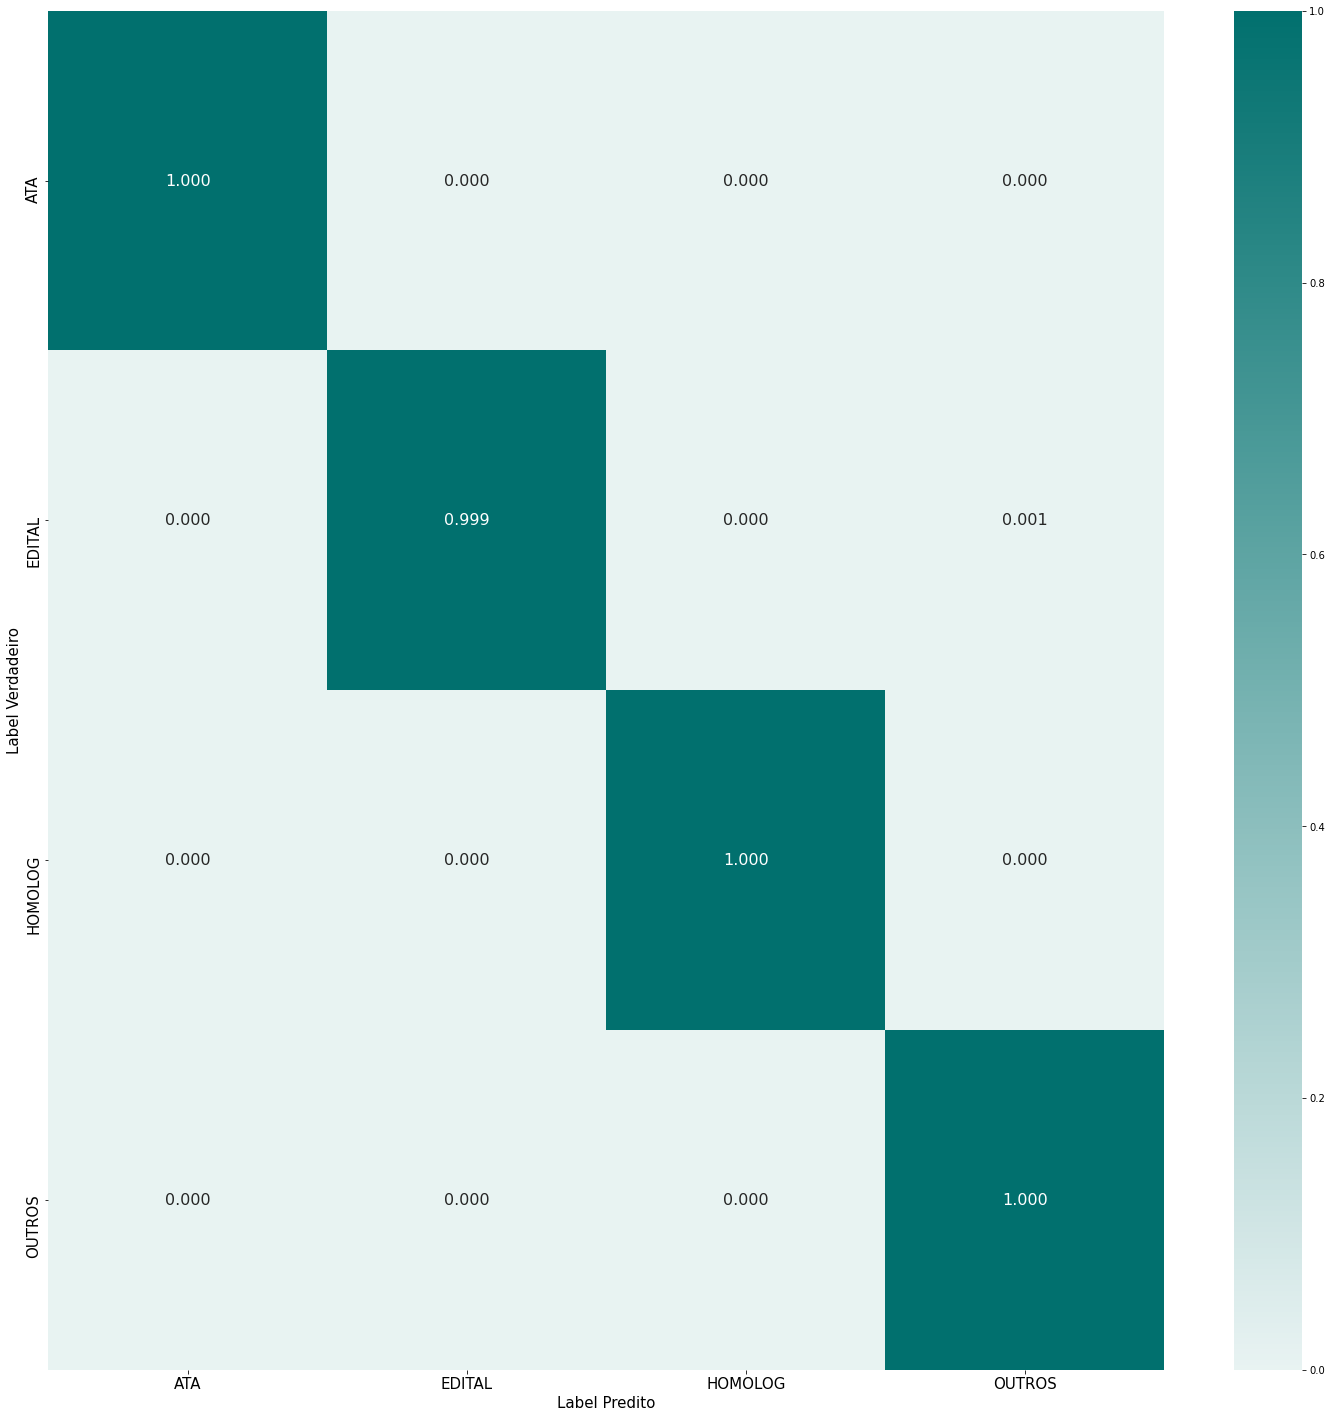

In [44]:
print("\n XGBoost sem feature selection")
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(tf_idf_train,y_train.values.ravel())

score_xgb = xgb_model.score(tf_idf_train, y_train.values.ravel())

print("\nTrain set score: ", score_xgb)

y_pred_train = xgb_model.predict(tf_idf_train)

evaluation_models(y_train, y_pred_train, "treino")

score_val_xgb = xgb_model.score(tf_idf_val_final, y_val.values.ravel())

print("\nValidation set score: ", score_val_xgb)

y_pred_val = xgb_model.predict(tf_idf_val_final)

evaluation_models(y_val, y_pred_val, "validação")

score_test_xgb = xgb_model.score(tf_idf_test_final, y_test.values.ravel())

print("\nTest set score: ", score_test_xgb)

y_pred_test = xgb_model.predict(tf_idf_test_final)

evaluation_models(y_test, y_pred_test, "teste")



In [ ]:
# Logistic Regression

clf = LogisticRegression(random_state=0).fit(tf_idf_train,y_train.values.ravel())

score_val_clf = clf.score(tf_idf_val_final, y_val.values.ravel())

print("\nValidation set score: ", score_val_clf)

y_pred_val = clf.predict(tf_idf_val_final)

evaluation_models(y_val, y_pred_val, "validação")